In [28]:
from skimage.io import imread, imshow, imsave
import pyclesperanto_prototype as cle
import numpy as np
from skimage.io import imshow
from cellpose import models
from cellpose.io import imread
import matplotlib.pyplot as plt
import glob as glob
from skimage import measure
import pandas as pd
import itertools
from skimage.filters import median
from skimage.morphology import disk
from napari_simpleitk_image_processing import label_statistics
from skimage.measure import label, regionprops_table
import pickle
import os

100%|████████████████████████████████████████| 282/282 [00:01<00:00, 149.48it/s]


In [ ]:
## Flat-Field correction

path_image_FF = r"/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C05-F6.tif"
image_io_FF = imread(path_image_FF)

In [29]:
## Compute the mean intensity of the flat-field images
mean_background_ff_GFP = [np.mean(image_io_FF[frame,0,...].flatten()) for frame in range(np.shape(image_io_FF)[0])]
mean_background_ff_mOrange = [np.mean(image_io_FF[frame,1,...].flatten()) for frame in range(np.shape(image_io_FF)[0])]
mean_background_ff_SNAP = [np.mean(image_io_FF[frame,2,...].flatten()) for frame in range(np.shape(image_io_FF)[0])]

## Divide the flat-field images by their mean: the average of the pixel intensity is now 1
image_ff_GFP = [image_io_FF[frame,0,...]/mean_background_ff_GFP[frame]  for frame in range(np.shape(image_io_FF)[0])]
image_ff_mOrange = [image_io_FF[frame,1,...]/mean_background_ff_mOrange[frame]  for frame in range(np.shape(image_io_FF)[0])]
image_ff_SNAP = [image_io_FF[frame,2,...]/mean_background_ff_SNAP[frame]  for frame in range(np.shape(image_io_FF)[0])]

## Apply median filter to remove dust etc.
image_ff_GFP = [ median(image_ff_GFP[frame], footprint=disk(5)) for frame in range(np.shape(image_io_FF)[0])]
image_ff_mOrange = [ median(image_ff_mOrange[frame], footprint=disk(5)) for frame in range(np.shape(image_io_FF)[0])]
image_ff_SNAP = [ median(image_ff_SNAP[frame], footprint=disk(5)) for frame in range(np.shape(image_io_FF)[0])]

4176.265881721023
4858.624191007702
7628.6864071939235
0.999919804719683
0.9998970451591669


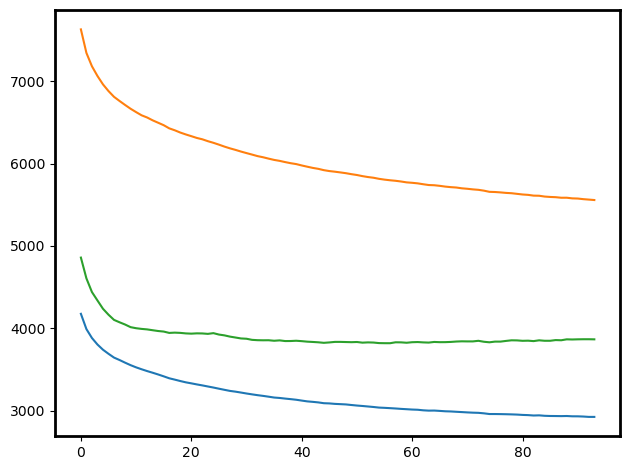

In [30]:
## Divide the flat-field images by their mean: the average of the pixel intensity is now 1
image_background_GFP_ff_corrected = [image_io_FF[frame,0,...]/image_ff_GFP[frame]  for frame in range(np.shape(image_io_FF)[0])]
image_background_mOrange_ff_corrected = [image_io_FF[frame,1,...]/image_ff_mOrange[frame]  for frame in range(np.shape(image_io_FF)[0])]
image_background_SNAP_ff_corrected = [image_io_FF[frame,2,...]/image_ff_SNAP[frame]  for frame in range(np.shape(image_io_FF)[0])]


check_background_list_GFP = [np.mean(image_background_GFP_ff_corrected[frame])  for frame in range(np.shape(image_io_FF)[0])] 
check_background_list_mOrange = [np.mean(image_background_mOrange_ff_corrected[frame])  for frame in range(np.shape(image_io_FF)[0])] 
check_background_list_SNAP = [np.mean(image_background_SNAP_ff_corrected[frame])  for frame in range(np.shape(image_io_FF)[0])] 

plt.plot(check_background_list_GFP)
plt.plot(check_background_list_mOrange)
plt.plot(check_background_list_SNAP)

print(check_background_list_GFP[0])
print(check_background_list_SNAP[0])
print(check_background_list_mOrange[0])

print(np.mean(image_ff_mOrange[0]))
print(np.mean(image_ff_SNAP[0]))

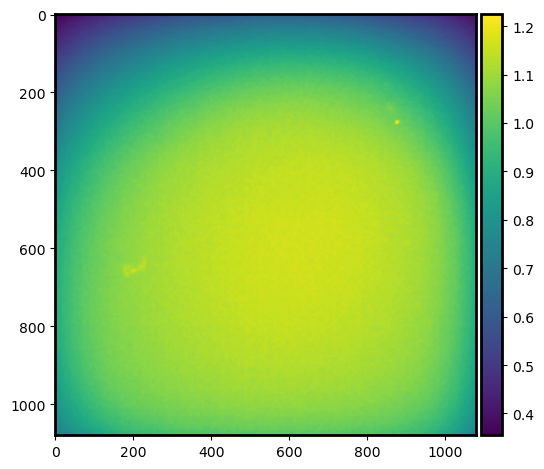

In [31]:
imshow(image_ff_GFP[0])

In [34]:
###################### Analysis ######################

list_files = glob.glob(r"/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R0*-C0*-F*.tif")
for path_image in list_files:
    print(path_image)
    path_results = path_image[:149]+"results_trajectories/"+path_image[198:-4]
    if not os.path.exists(path_results):
        os.makedirs(path_results)
        image_io = imread(path_image)
        imgs = [image_io[x,0,...] for x in range(len(image_io))]
        ### Segmentation using Cellpose ###
        model = models.Cellpose(model_type='nuclei')
        channels = [0,0]
        masks, flows, styles, diams = model.eval(imgs, diameter=30, min_size=70, resample=True, channels=channels,cellprob_threshold=-3,flow_threshold=0.5)
        ###
        from skimage.measure import label
        labels = np.array([label(masks[k]) for k in range(len(masks))])
        ## 
        imgs_GFP = [image_io[x,0,...]/image_ff_GFP[x] for x in range(len(image_io))]
        imgs_mOrange = [image_io[x,1,...]/image_ff_mOrange[x] for x in range(len(image_io))]
        imgs_SNAP = [image_io[x,2,...]/image_ff_SNAP[x] for x in range(len(image_io))]
        ###
        dictionnary_results = {"label":[]}
        for frame in range(len(imgs)):
            statistics_GFP = pd.DataFrame(label_statistics(imgs_GFP[frame], labels[frame,...], True, True, True, True, True, True))
            statistics_mOrange = pd.DataFrame(label_statistics(imgs_mOrange[frame], labels[frame,...], True, True, True, True, True, True))
            statistics_SNAP = pd.DataFrame(label_statistics(imgs_SNAP[frame], labels[frame,...], True, True, True, True, True, True))
            if len(statistics_GFP) == 0:
                print("we will continue for frame %s"%frame)
                continue
            for label in statistics_GFP["label"]:
                if label not in dictionnary_results["label"]:
                    dictionnary_results["label"] += [label]
                    dictionnary_results["frames_%s"%label] = [frame]
                    dictionnary_results["size_%s"%label] =[int(statistics_GFP[statistics_GFP["label"]==label]["number_of_pixels"])]
                    dictionnary_results["integrated_int_GFP_%s"%label] =[int(statistics_GFP[statistics_GFP["label"]==label]["sum"])]
                    dictionnary_results["integrated_int_mOrange_%s"%label] =[int(statistics_mOrange[statistics_mOrange["label"]==label]["sum"])]
                    dictionnary_results["integrated_int_SNAP_%s"%label] =[int(statistics_SNAP[statistics_SNAP["label"]==label]["sum"])]
                else:
                    dictionnary_results["frames_%s"%label] += [frame]
                    dictionnary_results["size_%s"%label] += [int(statistics_GFP[statistics_GFP["label"]==label]["number_of_pixels"])]
                    dictionnary_results["integrated_int_GFP_%s"%label] += [int(statistics_GFP[statistics_GFP["label"]==label]["sum"])]
                    dictionnary_results["integrated_int_mOrange_%s"%label] += [int(statistics_mOrange[statistics_mOrange["label"]==label]["sum"])]
                    dictionnary_results["integrated_int_SNAP_%s"%label] +=[int(statistics_SNAP[statistics_SNAP["label"]==label]["sum"])]

        ## Compute backgrounds
        # Background GFP
        threshold_list_GFP = len(masks)*[0]
        for k in range(len(masks)):
            cell_intensities_GFP_frame = []
            if np.max(masks[k])>0:
                ## Open your raw image from the pathlist "files"
                image_GFP = imgs_GFP[k]
                ## Remove the background using the median algorithm
                image_ff_corrected_GFP_median = median(image_GFP, footprint=disk(5))
                ## Compute threshold
                cell_intensities_GFP_frame = list(image_ff_corrected_GFP_median.flatten()[(masks[k]!=0).flatten()])
                threshold_GFP = np.percentile(cell_intensities_GFP_frame,5)
                threshold_list_GFP[k] = threshold_GFP
            print("Frame %s threshold GFP = "%k, threshold_list_GFP[k])
            


        background_list_GFP = len(masks)*[0]
        for k in range(len(masks)):
            if np.max(masks[k])>0:
                ## Open your raw image from the pathlist "files"
                image_GFP = np.array(imgs_GFP[k])
                ## Remove the background using the rolling ball algorithm
                image_ff_corrected_GFP_median = median(image_GFP, footprint=disk(5))
                if len(image_ff_corrected_GFP_median[image_ff_corrected_GFP_median<threshold_list_GFP[k]].flatten())>0:
                    background_rolling_GFP = np.mean(image_ff_corrected_GFP_median[image_ff_corrected_GFP_median<threshold_list_GFP[k]])
                else:
                    print("error")
                ###
                background_list_GFP[k] = background_rolling_GFP
            print("Frame %s background GFP = "%k, background_list_GFP[k])

        # Background mOrange
        threshold_list_mOrange = len(masks)*[0]
        for k in range(len(masks)):
            cell_intensities_mOrange_frame = []
            if np.max(masks[k])>0:
                ## Open your raw image from the pathlist "files"
                image_mOrange = imgs_mOrange[k]
                ## Remove the background using the median algorithm
                image_ff_corrected_mOrange_median = median(image_mOrange, footprint=disk(5))
                ## Compute threshold
                cell_intensities_mOrange_frame = list(image_ff_corrected_mOrange_median.flatten()[(masks[k]!=0).flatten()])
                threshold_mOrange = np.percentile(cell_intensities_mOrange_frame,5)
                threshold_list_mOrange[k] = threshold_mOrange
            print("Frame %s threshold mOrange = "%k, threshold_list_mOrange[k])


        background_list_mOrange = len(masks)*[0]
        for k in range(len(masks)):
            if np.max(masks[k])>0:
                ## Open your raw image from the pathlist "files"
                image_mOrange = np.array(imgs_mOrange[k])
                ## Remove the background using the rolling ball algorithm
                image_ff_corrected_mOrange_median = median(image_mOrange, footprint=disk(5))
                if len(image_ff_corrected_mOrange_median[image_ff_corrected_mOrange_median<threshold_list_mOrange[k]].flatten())>0:
                    background_rolling_mOrange = np.mean(image_ff_corrected_mOrange_median[image_ff_corrected_mOrange_median<threshold_list_mOrange[k]])
                else:
                    print("error")
                ###
                background_list_mOrange[k] = background_rolling_mOrange
            print("Frame %s background mOrange = "%k, background_list_mOrange[k])
            
        # Background SNAP
        threshold_list_SNAP = len(masks)*[0]
        for k in range(len(masks)):
            cell_intensities_SNAP_frame = []
            if np.max(masks[k])>0:
                ## Open your raw image from the pathlist "files"
                image_SNAP = imgs_SNAP[k]
                ## Remove the background using the median algorithm
                image_ff_corrected_SNAP_median = median(image_SNAP, footprint=disk(5))
                ## Compute threshold
                cell_intensities_SNAP_frame = list(image_ff_corrected_SNAP_median.flatten()[(masks[k]!=0).flatten()])
                threshold_SNAP = np.percentile(cell_intensities_SNAP_frame,5)
                threshold_list_SNAP[k] = threshold_SNAP
            print("Frame %s threshold SNAP = "%k, threshold_list_SNAP[k])


        background_list_SNAP = len(masks)*[0]
        for k in range(len(masks)):
            if np.max(masks[k])>0:
                ## Open your raw image from the pathlist "files"
                image_SNAP = np.array(imgs_SNAP[k])
                ## Remove the background using the rolling ball algorithm
                image_ff_corrected_SNAP_median = median(image_SNAP, footprint=disk(5))
                if len(image_ff_corrected_SNAP_median[image_ff_corrected_SNAP_median<threshold_list_SNAP[k]].flatten())>0:
                    background_rolling_SNAP = np.mean(image_ff_corrected_SNAP_median[image_ff_corrected_SNAP_median<threshold_list_SNAP[k]])
                else:
                    print("error")
                ###
                background_list_SNAP[k] = background_rolling_SNAP
            print("Frame %s background SNAP = "%k, background_list_SNAP[k])

        ### Select and generate final results
        dictionnary_results_bg_sub = {}
        dictionnary_results_bg_sub["label_selected"] = []
        list_results = []
        list_averaging_GFP = np.zeros([2,len(masks)])
        list_averaging_mOrange = np.zeros([2,len(masks)])
        list_averaging_SNAP = np.zeros([2,len(masks)])
        for label in dictionnary_results["label"]:
            ### Take raw results ###
            list_timepoint = np.array(dictionnary_results["frames_%s"%label])
            list_cell_size = np.array(dictionnary_results["size_%s"%label])
            list_GFP_int_int = np.array(dictionnary_results["integrated_int_GFP_%s"%label])
            list_mOrange_int_int = np.array(dictionnary_results["integrated_int_mOrange_%s"%label])
            list_SNAP_int_int = np.array(dictionnary_results["integrated_int_SNAP_%s"%label])
            ### Filter for cell size
            Mask_size = list_cell_size>100
            list_timepoint = list_timepoint[Mask_size]
            list_cell_size = list_cell_size[Mask_size]
            list_GFP_int_int = list_GFP_int_int[Mask_size]
            list_mOrange_int_int = list_mOrange_int_int[Mask_size]
            list_SNAP_int_int = list_SNAP_int_int[Mask_size]
            ### Remove background
            list_GFP_int_int_bg_sub = [list_GFP_int_int[index]  - background_list_GFP[frame]*list_cell_size[index] for index,frame in enumerate(list_timepoint)]#I added cell-size
            list_mOrange_int_int_bg_sub = [list_mOrange_int_int[index]  - background_list_mOrange[frame]*list_cell_size[index] for index,frame in enumerate(list_timepoint)]#I added cell-size
            list_SNAP_int_int_bg_sub = [list_SNAP_int_int[index]  - background_list_SNAP[frame]*list_cell_size[index] for index,frame in enumerate(list_timepoint)]#I added cell-size
            ### Compute mean intensity
            list_GFP_int_int_bg_sub = np.array(list_GFP_int_int_bg_sub)/np.array(list_cell_size)
            list_mOrange_int_int_bg_sub = np.array(list_mOrange_int_int_bg_sub)/np.array(list_cell_size)
            list_SNAP_int_int_bg_sub = np.array(list_SNAP_int_int_bg_sub)/np.array(list_cell_size)
            ### Update the final result dictionnary
            dictionnary_results_bg_sub["label_selected"] += [label]
            dictionnary_results_bg_sub["frame_%s"%label] = np.array(list_timepoint)
            dictionnary_results_bg_sub["time_%s"%label] = np.array(list_timepoint)*15/60
            dictionnary_results_bg_sub["integrated_int_GFP_bg_sub_%s"%label] = list_GFP_int_int_bg_sub
            dictionnary_results_bg_sub["integrated_int_mOrange_bg_sub_%s"%label] = list_mOrange_int_int_bg_sub
            dictionnary_results_bg_sub["integrated_int_SNAP_bg_sub_%s"%label] = list_SNAP_int_int_bg_sub
            dictionnary_results_bg_sub["cell_size_%s"%label] = list_cell_size
            ### Average the trajectories
            list_averaging_GFP[0,list_timepoint]+= np.array(list_GFP_int_int_bg_sub)
            list_averaging_GFP[1,list_timepoint] += 1
            list_averaging_mOrange[0,list_timepoint]+= np.array(list_mOrange_int_int_bg_sub)
            list_averaging_mOrange[1,list_timepoint] += 1
            list_averaging_SNAP[0,list_timepoint]+= np.array(list_SNAP_int_int_bg_sub)
            list_averaging_SNAP[1,list_timepoint] += 1
        average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
        average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
        average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]
        list_time = np.array(range(0,len(average_traj_GFP)))*15/60

        # save data
        f = open(path_results+"/dictionnary_results_single_cell.pkl","wb")
        pickle.dump(dictionnary_results_bg_sub,f)
        f.close()

        list_results_mean_df = pd.DataFrame(np.array([list_time,average_traj_GFP,average_traj_mOrange,average_traj_SNAP, np.array(list_averaging_GFP[1,:])]).T, columns=["time_hours", "GFP_avg_mean", "mOrange_avg_mean","SNAP_avg_mean", "cell_number"])
        list_results_mean_df.to_csv(path_results+"/results_mean.csv")
        
        
        dictionnary_results_reframed = {"frame":[]}
        for label in dictionnary_results_bg_sub["label_selected"]:
            list_timepoint = dictionnary_results_bg_sub["frame_%s"%label]
            for index,frame in enumerate(list_timepoint):
                if frame not in dictionnary_results_reframed["frame"]:
                    dictionnary_results_reframed["frame"] += [int(frame)]
                    dictionnary_results_reframed["GFP_%s"%int(frame)] = [dictionnary_results_bg_sub["integrated_int_GFP_bg_sub_%s"%label][index]]
                    dictionnary_results_reframed["mOrange_%s"%int(frame)] = [dictionnary_results_bg_sub["integrated_int_mOrange_bg_sub_%s"%label][index]]
                    dictionnary_results_reframed["SNAP_%s"%int(frame)] = [dictionnary_results_bg_sub["integrated_int_SNAP_bg_sub_%s"%label][index]]
                    dictionnary_results_reframed["size_%s"%int(frame)] = [dictionnary_results_bg_sub["cell_size_%s"%label][index]]
                else:
                    dictionnary_results_reframed["GFP_%s"%int(frame)] += [dictionnary_results_bg_sub["integrated_int_GFP_bg_sub_%s"%label][index]]
                    dictionnary_results_reframed["mOrange_%s"%int(frame)] += [dictionnary_results_bg_sub["integrated_int_mOrange_bg_sub_%s"%label][index]]
                    dictionnary_results_reframed["SNAP_%s"%int(frame)] += [dictionnary_results_bg_sub["integrated_int_SNAP_bg_sub_%s"%label][index]]
                    dictionnary_results_reframed["size_%s"%int(frame)] += [dictionnary_results_bg_sub["cell_size_%s"%label][index]]
                    
        f = open(path_results+"/dictionnary_results_per_timepoint.pkl","wb")
        pickle.dump(dictionnary_results_reframed,f)
        f.close()
                    
        list_GFP_median = []
        list_mOrange_median = []
        list_SNAP_median = []
        list_size_median = []
        list_time_final = np.array(dictionnary_results_reframed["frame"])*15/60
        for frame in dictionnary_results_reframed["frame"]:
            list_GFP_median += [np.median(dictionnary_results_reframed["GFP_%s"%frame])]
            list_mOrange_median += [np.median(dictionnary_results_reframed["mOrange_%s"%frame])]
            list_SNAP_median += [np.median(dictionnary_results_reframed["SNAP_%s"%frame])]
            list_size_median += [np.median(dictionnary_results_reframed["size_%s"%frame])]
            
        list_results_mean_df = pd.DataFrame(np.array([list_time_final,list_GFP_median,list_mOrange_median,list_SNAP_median,list_size_median]).T, columns=["time_hours", "GFP_avg_median", "mOrange_avg_median", "SNAP_avg_median", "cell_size_median"])
        list_results_mean_df.to_csv(path_results+"/results_median.csv")
     

/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C01-F11.tif


100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 81.12it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for

Frame 44 threshold mOrange =  5562.433601892444
Frame 45 threshold mOrange =  5523.297999547409
Frame 46 threshold mOrange =  5536.769735171286
Frame 47 threshold mOrange =  5515.507689126072
Frame 48 threshold mOrange =  0
Frame 49 threshold mOrange =  0
Frame 50 threshold mOrange =  0
Frame 51 threshold mOrange =  5473.928373801772
Frame 52 threshold mOrange =  0
Frame 53 threshold mOrange =  0
Frame 54 threshold mOrange =  0
Frame 55 threshold mOrange =  0
Frame 56 threshold mOrange =  0
Frame 57 threshold mOrange =  0
Frame 58 threshold mOrange =  0
Frame 59 threshold mOrange =  0
Frame 60 threshold mOrange =  0
Frame 61 threshold mOrange =  5330.435001189954
Frame 62 threshold mOrange =  0
Frame 63 threshold mOrange =  0
Frame 64 threshold mOrange =  0
Frame 65 threshold mOrange =  0
Frame 66 threshold mOrange =  5308.90504719605
Frame 67 threshold mOrange =  0
Frame 68 threshold mOrange =  5308.308306851477
Frame 69 threshold mOrange =  0
Frame 70 threshold mOrange =  0
Frame 71 

Frame 44 background SNAP =  3451.584016656265
Frame 45 background SNAP =  3459.834475198209
Frame 46 background SNAP =  3454.023833264399
Frame 47 background SNAP =  3445.5933061429087
Frame 48 background SNAP =  0
Frame 49 background SNAP =  0
Frame 50 background SNAP =  0
Frame 51 background SNAP =  3415.569774717831
Frame 52 background SNAP =  0
Frame 53 background SNAP =  0
Frame 54 background SNAP =  0
Frame 55 background SNAP =  0
Frame 56 background SNAP =  0
Frame 57 background SNAP =  0
Frame 58 background SNAP =  0
Frame 59 background SNAP =  0
Frame 60 background SNAP =  0
Frame 61 background SNAP =  3345.0094444581205
Frame 62 background SNAP =  0
Frame 63 background SNAP =  0
Frame 64 background SNAP =  0
Frame 65 background SNAP =  0
Frame 66 background SNAP =  3345.7390687390694
Frame 67 background SNAP =  0
Frame 68 background SNAP =  3349.468159910056
Frame 69 background SNAP =  0
Frame 70 background SNAP =  0
Frame 71 background SNAP =  0
Frame 72 background SNAP =  3

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 78 background SNAP =  3305.1175307879084
Frame 79 background SNAP =  0
Frame 80 background SNAP =  0
Frame 81 background SNAP =  0
Frame 82 background SNAP =  0
Frame 83 background SNAP =  0
Frame 84 background SNAP =  0
Frame 85 background SNAP =  0
Frame 86 background SNAP =  0
Frame 87 background SNAP =  0
Frame 88 background SNAP =  0
Frame 89 background SNAP =  0
Frame 90 background SNAP =  0
Frame 91 background SNAP =  0
Frame 92 background SNAP =  0
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C01-F7.tif


100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 82.97it/s]


Frame 0 threshold GFP =  4738.397132826897
Frame 1 threshold GFP =  4289.287781783953
Frame 2 threshold GFP =  4494.763483466697
Frame 3 threshold GFP =  4398.516349668738
Frame 4 threshold GFP =  4271.189395368138
Frame 5 threshold GFP =  4093.829118511602
Frame 6 threshold GFP =  4191.707005669279
Frame 7 threshold GFP =  3966.9978051394264
Frame 8 threshold GFP =  3870.357752821122
Frame 9 threshold GFP =  3987.1199266731487
Frame 10 threshold GFP =  4041.0590929913374
Frame 11 threshold GFP =  4053.1472545261736
Frame 12 threshold GFP =  4030.6837790347004
Frame 13 threshold GFP =  3957.727351091964
Frame 14 threshold GFP =  3871.2390955211927
Frame 15 threshold GFP =  3936.300340711764
Frame 16 threshold GFP =  3894.2068212478716
Frame 17 threshold GFP =  3875.7101621871593
Frame 18 threshold GFP =  3743.1597550326555
Frame 19 threshold GFP =  3730.5421067025513
Frame 20 threshold GFP =  3785.7114564300423
Frame 21 threshold GFP =  3724.005983572034
Frame 22 threshold GFP =  3715.

Frame 89 background GFP =  2766.341125046163
Frame 90 background GFP =  2767.330947754873
Frame 91 background GFP =  2766.9124422853374
Frame 92 background GFP =  2755.655315338126
Frame 93 background GFP =  2759.2816576140854
Frame 0 threshold mOrange =  8246.403275089031
Frame 1 threshold mOrange =  7710.676706893802
Frame 2 threshold mOrange =  7569.731607735235
Frame 3 threshold mOrange =  7384.130785084004
Frame 4 threshold mOrange =  7257.505021997761
Frame 5 threshold mOrange =  7095.491984697364
Frame 6 threshold mOrange =  7087.86843107195
Frame 7 threshold mOrange =  6897.370302889115
Frame 8 threshold mOrange =  6818.903778888346
Frame 9 threshold mOrange =  6876.941432573563
Frame 10 threshold mOrange =  6866.312693853285
Frame 11 threshold mOrange =  6845.800145558252
Frame 12 threshold mOrange =  6789.665655839366
Frame 13 threshold mOrange =  6730.653515762898
Frame 14 threshold mOrange =  6680.282869122953
Frame 15 threshold mOrange =  6673.009934266672
Frame 16 thresho

Frame 72 background mOrange =  5313.043554190389
Frame 73 background mOrange =  5300.937658746569
Frame 74 background mOrange =  5289.609819565111
Frame 75 background mOrange =  5280.874585817457
Frame 76 background mOrange =  5267.923657920251
Frame 77 background mOrange =  5261.511981125602
Frame 78 background mOrange =  5253.2744984512365
Frame 79 background mOrange =  5247.186105001622
Frame 80 background mOrange =  5238.940783189822
Frame 81 background mOrange =  5229.186099036196
Frame 82 background mOrange =  5219.330901905984
Frame 83 background mOrange =  5213.306612824396
Frame 84 background mOrange =  5204.5276951156
Frame 85 background mOrange =  5193.609666251535
Frame 86 background mOrange =  5187.973390890184
Frame 87 background mOrange =  5180.354991694086
Frame 88 background mOrange =  5168.916072554268
Frame 89 background mOrange =  5165.808289572483
Frame 90 background mOrange =  5155.036081345008
Frame 91 background mOrange =  5148.99927057043
Frame 92 background mO

Frame 62 background SNAP =  3422.2832120923626
Frame 63 background SNAP =  3414.9266714582177
Frame 64 background SNAP =  3410.8536560088914
Frame 65 background SNAP =  3403.819541489029
Frame 66 background SNAP =  3397.3427233221023
Frame 67 background SNAP =  3395.1095032568387
Frame 68 background SNAP =  3388.264766910084
Frame 69 background SNAP =  3383.0288756223167
Frame 70 background SNAP =  3381.406000646488
Frame 71 background SNAP =  3374.980898258146
Frame 72 background SNAP =  3370.009064945935
Frame 73 background SNAP =  3365.9602479269633
Frame 74 background SNAP =  3354.348216570155
Frame 75 background SNAP =  3349.8480598306014
Frame 76 background SNAP =  3348.4566644868164
Frame 77 background SNAP =  3339.9274696704197
Frame 78 background SNAP =  3348.5983304380234
Frame 79 background SNAP =  3346.3359886683907
Frame 80 background SNAP =  3342.291208745689
Frame 81 background SNAP =  3332.8280037354984
Frame 82 background SNAP =  3325.1329595420734
Frame 83 background 

100%|█████████████████████████████████████████| 282/282 [00:06<00:00, 42.73it/s]


Frame 0 threshold GFP =  4623.895270895119
Frame 1 threshold GFP =  4378.448508465619
Frame 2 threshold GFP =  4251.6687198272975
Frame 3 threshold GFP =  4152.780292448614
Frame 4 threshold GFP =  4082.4227603351546
Frame 5 threshold GFP =  4023.538771745834
Frame 6 threshold GFP =  3977.053914602932
Frame 7 threshold GFP =  3918.8524734093935
Frame 8 threshold GFP =  3901.8327014874753
Frame 9 threshold GFP =  3876.3666120975086
Frame 10 threshold GFP =  3849.9521755543046
Frame 11 threshold GFP =  3828.6199414130097
Frame 12 threshold GFP =  3788.475357823317
Frame 13 threshold GFP =  3765.5272920209427
Frame 14 threshold GFP =  3763.6813442393977
Frame 15 threshold GFP =  3737.524330637655
Frame 16 threshold GFP =  3709.7940829115446
Frame 17 threshold GFP =  3671.2222396771494
Frame 18 threshold GFP =  3658.5360440273917
Frame 19 threshold GFP =  3647.7793452082637
Frame 20 threshold GFP =  3610.792522293272
Frame 21 threshold GFP =  3606.6256106728993
Frame 22 threshold GFP =  35

Frame 89 background GFP =  2930.6998469599025
Frame 90 background GFP =  2926.7639013852854
Frame 91 background GFP =  2921.827649860522
Frame 92 background GFP =  2916.7934756066306
Frame 93 background GFP =  2917.146801318606
Frame 0 threshold mOrange =  8044.85848121951
Frame 1 threshold mOrange =  7695.604027523826
Frame 2 threshold mOrange =  7483.398704998709
Frame 3 threshold mOrange =  7331.452131749782
Frame 4 threshold mOrange =  7223.542749904547
Frame 5 threshold mOrange =  7130.754051970412
Frame 6 threshold mOrange =  7053.205427836938
Frame 7 threshold mOrange =  6990.5289829098865
Frame 8 threshold mOrange =  6944.214817633027
Frame 9 threshold mOrange =  6893.748099655452
Frame 10 threshold mOrange =  6850.2660921479965
Frame 11 threshold mOrange =  6808.279505373625
Frame 12 threshold mOrange =  6765.189258060586
Frame 13 threshold mOrange =  6725.855475134797
Frame 14 threshold mOrange =  6693.64270495926
Frame 15 threshold mOrange =  6661.298813123603
Frame 16 thres

Frame 71 background mOrange =  5598.982784007528
Frame 72 background mOrange =  5590.168034462745
Frame 73 background mOrange =  5579.693204257152
Frame 74 background mOrange =  5566.5515730429215
Frame 75 background mOrange =  5557.427411550774
Frame 76 background mOrange =  5547.025667921765
Frame 77 background mOrange =  5539.58399006028
Frame 78 background mOrange =  5537.035835724468
Frame 79 background mOrange =  5525.240587568975
Frame 80 background mOrange =  5516.724654582044
Frame 81 background mOrange =  5510.044288822972
Frame 82 background mOrange =  5503.501554572504
Frame 83 background mOrange =  5492.702652352758
Frame 84 background mOrange =  5483.743958916844
Frame 85 background mOrange =  5476.368191608179
Frame 86 background mOrange =  5470.84712366295
Frame 87 background mOrange =  5460.456866586893
Frame 88 background mOrange =  5455.170916436149
Frame 89 background mOrange =  5445.603570326833
Frame 90 background mOrange =  5437.281283914104
Frame 91 background m

Frame 61 background SNAP =  3351.945427558052
Frame 62 background SNAP =  3341.315127453561
Frame 63 background SNAP =  3338.7222879864685
Frame 64 background SNAP =  3333.5450805047244
Frame 65 background SNAP =  3327.6501092587214
Frame 66 background SNAP =  3324.675117858471
Frame 67 background SNAP =  3316.0155002824354
Frame 68 background SNAP =  3311.872858132606
Frame 69 background SNAP =  3312.4048147694616
Frame 70 background SNAP =  3306.6369580156183
Frame 71 background SNAP =  3299.6336519627434
Frame 72 background SNAP =  3295.9547160946645
Frame 73 background SNAP =  3286.266812551533
Frame 74 background SNAP =  3279.7674314248975
Frame 75 background SNAP =  3275.856789686361
Frame 76 background SNAP =  3269.7678840502786
Frame 77 background SNAP =  3272.361587501735
Frame 78 background SNAP =  3274.9725871094192
Frame 79 background SNAP =  3265.4380610465873
Frame 80 background SNAP =  3257.7724490199967
Frame 81 background SNAP =  3252.8547079971636
Frame 82 background 

100%|█████████████████████████████████████████| 282/282 [00:04<00:00, 70.44it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue fo

Frame 8 threshold mOrange =  6687.996578430476
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  6169.883046212077
Frame 28 threshold mOrange =  6140.890817974819
Frame 29 threshold mOrange =  0
Frame 30 threshold mOrange =  0
Frame 31 threshold mOrange =  0
Frame 32 threshold mOrange =  0
Frame 33 threshold mOrange =  0
Frame 34 threshold mOrange =  0
Frame 35 threshold mOrange =  0
Frame 36 threshold mOrange =  0
Frame 37 threshold mOrange

Frame 8 background SNAP =  4022.841596212727
Frame 9 background SNAP =  0
Frame 10 background SNAP =  0
Frame 11 background SNAP =  0
Frame 12 background SNAP =  0
Frame 13 background SNAP =  0
Frame 14 background SNAP =  0
Frame 15 background SNAP =  0
Frame 16 background SNAP =  0
Frame 17 background SNAP =  0
Frame 18 background SNAP =  0
Frame 19 background SNAP =  0
Frame 20 background SNAP =  0
Frame 21 background SNAP =  0
Frame 22 background SNAP =  0
Frame 23 background SNAP =  0
Frame 24 background SNAP =  0
Frame 25 background SNAP =  0
Frame 26 background SNAP =  0
Frame 27 background SNAP =  3877.273941574149


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 28 background SNAP =  3872.6539136546157
Frame 29 background SNAP =  0
Frame 30 background SNAP =  0
Frame 31 background SNAP =  0
Frame 32 background SNAP =  0
Frame 33 background SNAP =  0
Frame 34 background SNAP =  0
Frame 35 background SNAP =  0
Frame 36 background SNAP =  0
Frame 37 background SNAP =  0
Frame 38 background SNAP =  0
Frame 39 background SNAP =  0
Frame 40 background SNAP =  0
Frame 41 background SNAP =  0
Frame 42 background SNAP =  0
Frame 43 background SNAP =  0
Frame 44 background SNAP =  0
Frame 45 background SNAP =  0
Frame 46 background SNAP =  0
Frame 47 background SNAP =  0
Frame 48 background SNAP =  0
Frame 49 background SNAP =  0
Frame 50 background SNAP =  0
Frame 51 background SNAP =  0
Frame 52 background SNAP =  0
Frame 53 background SNAP =  0
Frame 54 background SNAP =  0
Frame 55 background SNAP =  0
Frame 56 background SNAP =  0
Frame 57 background SNAP =  0
Frame 58 background SNAP =  0
Frame 59 background SNAP =  0
Frame 60 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 106.33it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for

Frame 48 threshold mOrange =  5792.417696174411
Frame 49 threshold mOrange =  5835.310207691227
Frame 50 threshold mOrange =  0
Frame 51 threshold mOrange =  0
Frame 52 threshold mOrange =  0
Frame 53 threshold mOrange =  0
Frame 54 threshold mOrange =  6062.7371342560555
Frame 55 threshold mOrange =  5999.210605129274
Frame 56 threshold mOrange =  5955.879902051492
Frame 57 threshold mOrange =  5962.134400730154
Frame 58 threshold mOrange =  5924.004933508075
Frame 59 threshold mOrange =  5875.425700788234
Frame 60 threshold mOrange =  5922.434743883223
Frame 61 threshold mOrange =  5830.946001568298
Frame 62 threshold mOrange =  5863.786521900403
Frame 63 threshold mOrange =  5915.8129842659155
Frame 64 threshold mOrange =  5802.756349101429
Frame 65 threshold mOrange =  5773.386036979205
Frame 66 threshold mOrange =  5790.647915543762
Frame 67 threshold mOrange =  5743.962754155306
Frame 68 threshold mOrange =  5755.522139076903
Frame 69 threshold mOrange =  5668.53297009922
Frame 7

Frame 84 threshold SNAP =  3176.067839883195
Frame 85 threshold SNAP =  0
Frame 86 threshold SNAP =  3174.0665886799225
Frame 87 threshold SNAP =  0
Frame 88 threshold SNAP =  0
Frame 89 threshold SNAP =  3142.0898506107947
Frame 90 threshold SNAP =  0
Frame 91 threshold SNAP =  3156.371935063472
Frame 92 threshold SNAP =  3139.956271012253
Frame 93 threshold SNAP =  3120.679436847316
Frame 0 background SNAP =  0
Frame 1 background SNAP =  0
Frame 2 background SNAP =  0
Frame 3 background SNAP =  0
Frame 4 background SNAP =  0
Frame 5 background SNAP =  0
Frame 6 background SNAP =  0
Frame 7 background SNAP =  0
Frame 8 background SNAP =  0
Frame 9 background SNAP =  0
Frame 10 background SNAP =  0
Frame 11 background SNAP =  0
Frame 12 background SNAP =  0
Frame 13 background SNAP =  0
Frame 14 background SNAP =  0
Frame 15 background SNAP =  0
Frame 16 background SNAP =  0
Frame 17 background SNAP =  0
Frame 18 background SNAP =  0
Frame 19 background SNAP =  0
Frame 20 background SN

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3107.972186523818
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C04-F6.tif


100%|█████████████████████████████████████████| 282/282 [00:06<00:00, 45.33it/s]


Frame 0 threshold GFP =  5218.878811738751
Frame 1 threshold GFP =  4688.120089591278
Frame 2 threshold GFP =  4840.574850622799
Frame 3 threshold GFP =  4688.990874866693
Frame 4 threshold GFP =  4402.619829183472
Frame 5 threshold GFP =  4356.246097395854
Frame 6 threshold GFP =  4320.876576765597
Frame 7 threshold GFP =  4274.976678643545
Frame 8 threshold GFP =  4221.157025855656
Frame 9 threshold GFP =  4298.389631278229
Frame 10 threshold GFP =  4321.141521851949
Frame 11 threshold GFP =  4305.658068943704
Frame 12 threshold GFP =  4073.7181450516355
Frame 13 threshold GFP =  4072.48421324536
Frame 14 threshold GFP =  4197.370993206898
Frame 15 threshold GFP =  4171.920096449238
Frame 16 threshold GFP =  4114.340232078993
Frame 17 threshold GFP =  3957.7260711317513
Frame 18 threshold GFP =  3927.315751486171
Frame 19 threshold GFP =  4027.0057948400217
Frame 20 threshold GFP =  3876.4461257131366
Frame 21 threshold GFP =  3998.6489709914163
Frame 22 threshold GFP =  3840.8817211

Frame 89 background GFP =  2769.9671756376306
Frame 90 background GFP =  2770.4648746907897
Frame 91 background GFP =  2762.405190001457
Frame 92 background GFP =  2755.1614399862187
Frame 93 background GFP =  2752.7354474706503
Frame 0 threshold mOrange =  8704.794024237717
Frame 1 threshold mOrange =  8247.032673524187
Frame 2 threshold mOrange =  8108.8634883227605
Frame 3 threshold mOrange =  7899.327192688218
Frame 4 threshold mOrange =  7734.745357056578
Frame 5 threshold mOrange =  7641.602835198351
Frame 6 threshold mOrange =  7543.723874635095
Frame 7 threshold mOrange =  7463.31879727669
Frame 8 threshold mOrange =  7392.313237123567
Frame 9 threshold mOrange =  7343.879497756342
Frame 10 threshold mOrange =  7282.268592956747
Frame 11 threshold mOrange =  7231.851022350924
Frame 12 threshold mOrange =  7146.222349489093
Frame 13 threshold mOrange =  7118.547677164837
Frame 14 threshold mOrange =  7082.2238903367015
Frame 15 threshold mOrange =  7057.899934732442
Frame 16 thr

Frame 71 background mOrange =  5468.254096855946
Frame 72 background mOrange =  5460.5377888552675
Frame 73 background mOrange =  5445.120522296382
Frame 74 background mOrange =  5431.231628715419
Frame 75 background mOrange =  5418.480235773552
Frame 76 background mOrange =  5408.6159706334265
Frame 77 background mOrange =  5398.781152910704
Frame 78 background mOrange =  5392.747442340719
Frame 79 background mOrange =  5378.407124801131
Frame 80 background mOrange =  5369.455089896208
Frame 81 background mOrange =  5357.18117452309
Frame 82 background mOrange =  5345.259609299985
Frame 83 background mOrange =  5333.5985087384315
Frame 84 background mOrange =  5324.164336877432
Frame 85 background mOrange =  5313.0393049739
Frame 86 background mOrange =  5302.195795119585
Frame 87 background mOrange =  5291.664611898237
Frame 88 background mOrange =  5285.372414805186
Frame 89 background mOrange =  5274.884874829479
Frame 90 background mOrange =  5266.423630194197
Frame 91 background 

Frame 61 background SNAP =  3341.2356839003246
Frame 62 background SNAP =  3335.66031663381
Frame 63 background SNAP =  3330.777681366311
Frame 64 background SNAP =  3326.074390541063
Frame 65 background SNAP =  3312.8141317685036
Frame 66 background SNAP =  3309.2173568468406
Frame 67 background SNAP =  3302.978356704218
Frame 68 background SNAP =  3293.83314154347
Frame 69 background SNAP =  3291.1874518770674
Frame 70 background SNAP =  3277.946713720161
Frame 71 background SNAP =  3271.0657873952027
Frame 72 background SNAP =  3264.615386424817
Frame 73 background SNAP =  3256.3016986332227
Frame 74 background SNAP =  3247.730562346619
Frame 75 background SNAP =  3240.369518526574
Frame 76 background SNAP =  3230.5298064990207
Frame 77 background SNAP =  3229.9189809838363
Frame 78 background SNAP =  3230.2151463868126
Frame 79 background SNAP =  3222.7864079796254
Frame 80 background SNAP =  3214.146948902902
Frame 81 background SNAP =  3205.0089367656396
Frame 82 background SNAP 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 107.24it/s]


we will continue for frame 33
we will continue for frame 34
we will continue for frame 36
Frame 0 threshold GFP =  4473.109745860226
Frame 1 threshold GFP =  4298.358137794462
Frame 2 threshold GFP =  3877.105196304689
Frame 3 threshold GFP =  3774.0082940223706
Frame 4 threshold GFP =  3667.0021660673883
Frame 5 threshold GFP =  3595.027219409939
Frame 6 threshold GFP =  3620.738630121371
Frame 7 threshold GFP =  3521.5750011598543
Frame 8 threshold GFP =  3487.8758996244464
Frame 9 threshold GFP =  3449.6237941311488
Frame 10 threshold GFP =  3419.826906734295
Frame 11 threshold GFP =  3396.038696359682
Frame 12 threshold GFP =  3364.8998736014014
Frame 13 threshold GFP =  3382.636401169107
Frame 14 threshold GFP =  3369.9319116028187
Frame 15 threshold GFP =  3314.5858542582764
Frame 16 threshold GFP =  3275.8753619767645
Frame 17 threshold GFP =  3232.832025518708
Frame 18 threshold GFP =  3339.7089367847416
Frame 19 threshold GFP =  3251.327836265473
Frame 20 threshold GFP =  3250

Frame 89 background GFP =  2638.5960415616178
Frame 90 background GFP =  2623.0979567751533
Frame 91 background GFP =  2629.3124873050792
Frame 92 background GFP =  2627.316064379511
Frame 93 background GFP =  2623.3856190057677
Frame 0 threshold mOrange =  7929.099455197628
Frame 1 threshold mOrange =  7563.372377862807
Frame 2 threshold mOrange =  7035.218406620193
Frame 3 threshold mOrange =  6901.398225678438
Frame 4 threshold mOrange =  6738.875534195549
Frame 5 threshold mOrange =  6641.740532841622
Frame 6 threshold mOrange =  6620.266932293638
Frame 7 threshold mOrange =  6504.496794827964
Frame 8 threshold mOrange =  6450.35887163514
Frame 9 threshold mOrange =  6391.925063107554
Frame 10 threshold mOrange =  6347.030987997482
Frame 11 threshold mOrange =  6308.694477494794
Frame 12 threshold mOrange =  6236.3058200272135
Frame 13 threshold mOrange =  6244.045885320301
Frame 14 threshold mOrange =  6246.648521036576
Frame 15 threshold mOrange =  6166.189926707691
Frame 16 thre

Frame 74 background mOrange =  5086.937169080535
Frame 75 background mOrange =  5068.351572224864
Frame 76 background mOrange =  5056.026901150063
Frame 77 background mOrange =  5044.909662058616
Frame 78 background mOrange =  5035.4402473388445
Frame 79 background mOrange =  5028.14436866887
Frame 80 background mOrange =  5023.671438025608
Frame 81 background mOrange =  5005.858466254882
Frame 82 background mOrange =  5002.189848179973
Frame 83 background mOrange =  4993.6026499552245
Frame 84 background mOrange =  4982.354713755541
Frame 85 background mOrange =  4970.95587136884
Frame 86 background mOrange =  4959.422083895442
Frame 87 background mOrange =  4947.567466194548
Frame 88 background mOrange =  4941.546855157244
Frame 89 background mOrange =  4934.34588722555
Frame 90 background mOrange =  4921.424640124962
Frame 91 background mOrange =  4912.795827330146
Frame 92 background mOrange =  4906.428441666728
Frame 93 background mOrange =  4896.955838701372
Frame 0 threshold SNA

Frame 67 background SNAP =  3147.868245034846
Frame 68 background SNAP =  3138.529501544309
Frame 69 background SNAP =  3126.907120266661
Frame 70 background SNAP =  3133.604184722508
Frame 71 background SNAP =  3105.684884060416
Frame 72 background SNAP =  3114.039364055078
Frame 73 background SNAP =  3116.961134096901
Frame 74 background SNAP =  3095.1391434142156
Frame 75 background SNAP =  3091.603677087369
Frame 76 background SNAP =  3085.945618252517
Frame 77 background SNAP =  3065.683106724488
Frame 78 background SNAP =  3078.4967409763817
Frame 79 background SNAP =  3043.3003522645736
Frame 80 background SNAP =  3056.3854086370848
Frame 81 background SNAP =  3055.487476618881
Frame 82 background SNAP =  3044.3759703213086
Frame 83 background SNAP =  3043.9091977573316
Frame 84 background SNAP =  3037.6210269757808
Frame 85 background SNAP =  3021.7563831207713
Frame 86 background SNAP =  3024.330021542138
Frame 87 background SNAP =  3002.758089690195
Frame 88 background SNAP =

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  2971.2926650474824
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C04-F6.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C04-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C04-F6.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 117.96it/s]


Frame 0 threshold GFP =  4929.617870576102
Frame 1 threshold GFP =  4728.746945416062
Frame 2 threshold GFP =  4599.7603129606905
Frame 3 threshold GFP =  4553.4323958391
Frame 4 threshold GFP =  4375.272391312291
Frame 5 threshold GFP =  4386.0265750988265
Frame 6 threshold GFP =  4263.427006180142
Frame 7 threshold GFP =  4216.86860144874
Frame 8 threshold GFP =  4168.996112087746
Frame 9 threshold GFP =  4030.068310375182
Frame 10 threshold GFP =  4056.98163014085
Frame 11 threshold GFP =  4103.579416841496
Frame 12 threshold GFP =  4162.860325489337
Frame 13 threshold GFP =  4136.340232703954
Frame 14 threshold GFP =  4044.374874538595
Frame 15 threshold GFP =  4080.5169472844527
Frame 16 threshold GFP =  4073.6993958635776
Frame 17 threshold GFP =  4017.5764129665504
Frame 18 threshold GFP =  3897.8593786571864
Frame 19 threshold GFP =  3771.314914353143
Frame 20 threshold GFP =  3947.919803430279
Frame 21 threshold GFP =  3856.3341873022796
Frame 22 threshold GFP =  3943.39773889

Frame 89 background GFP =  2771.7239138935356
Frame 90 background GFP =  2766.762699849252
Frame 91 background GFP =  2762.985532275325
Frame 92 background GFP =  2759.335045768307
Frame 93 background GFP =  2752.9167908347035
Frame 0 threshold mOrange =  8385.393566870905
Frame 1 threshold mOrange =  8031.176906848259
Frame 2 threshold mOrange =  7814.845924933869
Frame 3 threshold mOrange =  7711.285196675828
Frame 4 threshold mOrange =  7527.2749925118505
Frame 5 threshold mOrange =  7456.235376029143
Frame 6 threshold mOrange =  7315.4563977463
Frame 7 threshold mOrange =  7234.093622187656
Frame 8 threshold mOrange =  7195.682290528963
Frame 9 threshold mOrange =  7090.458388449025
Frame 10 threshold mOrange =  7050.428086902629
Frame 11 threshold mOrange =  7051.86858410066
Frame 12 threshold mOrange =  7036.082047739076
Frame 13 threshold mOrange =  6996.656729147385
Frame 14 threshold mOrange =  6916.353613335211
Frame 15 threshold mOrange =  6911.816581200508
Frame 16 threshol

Frame 72 background mOrange =  5403.821883645812
Frame 73 background mOrange =  5391.917770141315
Frame 74 background mOrange =  5374.412563092436
Frame 75 background mOrange =  5364.699106588019
Frame 76 background mOrange =  5351.064129816006
Frame 77 background mOrange =  5336.441847980933
Frame 78 background mOrange =  5334.306906509978
Frame 79 background mOrange =  5321.612755088017
Frame 80 background mOrange =  5308.400367393026
Frame 81 background mOrange =  5299.881991417663
Frame 82 background mOrange =  5288.626055744109
Frame 83 background mOrange =  5276.7533309030305
Frame 84 background mOrange =  5267.5162386090005
Frame 85 background mOrange =  5255.375104139678
Frame 86 background mOrange =  5248.0920485066235
Frame 87 background mOrange =  5234.423983492616
Frame 88 background mOrange =  5228.559284573562
Frame 89 background mOrange =  5222.757537223542
Frame 90 background mOrange =  5211.860934722241
Frame 91 background mOrange =  5202.9918216684355
Frame 92 backgro

Frame 62 background SNAP =  3325.528247813948
Frame 63 background SNAP =  3317.0211043411487
Frame 64 background SNAP =  3314.1670741916
Frame 65 background SNAP =  3301.144363280116
Frame 66 background SNAP =  3297.7601706630403
Frame 67 background SNAP =  3288.8058725121537
Frame 68 background SNAP =  3281.792991920464
Frame 69 background SNAP =  3281.1627811929966
Frame 70 background SNAP =  3267.0458511278375
Frame 71 background SNAP =  3257.606039840379
Frame 72 background SNAP =  3252.6823340796846
Frame 73 background SNAP =  3244.98734023162
Frame 74 background SNAP =  3230.5023859975404
Frame 75 background SNAP =  3226.5413185732305
Frame 76 background SNAP =  3213.5145065045303
Frame 77 background SNAP =  3206.2654627940196
Frame 78 background SNAP =  3212.665810915761
Frame 79 background SNAP =  3208.246195151709
Frame 80 background SNAP =  3194.644788831217
Frame 81 background SNAP =  3188.3875694466856
Frame 82 background SNAP =  3182.5159144954773
Frame 83 background SNAP 

100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 75.23it/s]


we will continue for frame 29
we will continue for frame 31
we will continue for frame 33
we will continue for frame 35
we will continue for frame 37
we will continue for frame 39
we will continue for frame 40
we will continue for frame 41
we will continue for frame 42
we will continue for frame 43
we will continue for frame 44
we will continue for frame 45
we will continue for frame 46
we will continue for frame 47
we will continue for frame 48
we will continue for frame 49
we will continue for frame 50
we will continue for frame 54
we will continue for frame 55
we will continue for frame 56
we will continue for frame 57
we will continue for frame 64
Frame 0 threshold GFP =  4312.416883920428
Frame 1 threshold GFP =  4090.7909001056696
Frame 2 threshold GFP =  3952.9941136571215
Frame 3 threshold GFP =  3854.441472804018
Frame 4 threshold GFP =  3783.005897457535
Frame 5 threshold GFP =  3738.094186421935
Frame 6 threshold GFP =  3661.9646701778775
Frame 7 threshold GFP =  3633.387908

Frame 91 background GFP =  2748.0978121405196
Frame 92 background GFP =  2742.831401600801
Frame 93 background GFP =  2745.5074482980376
Frame 0 threshold mOrange =  7779.930705569676
Frame 1 threshold mOrange =  7460.498559199179
Frame 2 threshold mOrange =  7241.928776658338
Frame 3 threshold mOrange =  7098.134479070007
Frame 4 threshold mOrange =  7008.77975347364
Frame 5 threshold mOrange =  6915.995647502281
Frame 6 threshold mOrange =  6808.443300274545
Frame 7 threshold mOrange =  6757.371263543682
Frame 8 threshold mOrange =  6698.942136533464
Frame 9 threshold mOrange =  6649.858447682833
Frame 10 threshold mOrange =  6597.548404787426
Frame 11 threshold mOrange =  6562.579677882261
Frame 12 threshold mOrange =  6524.949672985277
Frame 13 threshold mOrange =  6480.24420537413
Frame 14 threshold mOrange =  6451.948566923085
Frame 15 threshold mOrange =  6403.946206150059
Frame 16 threshold mOrange =  6388.241912767248
Frame 17 threshold mOrange =  6357.997974406944
Frame 18 th

Frame 88 background mOrange =  5207.4485728739655
Frame 89 background mOrange =  5207.772436373716
Frame 90 background mOrange =  5198.805830954013
Frame 91 background mOrange =  5174.988147650967
Frame 92 background mOrange =  5159.818917458486
Frame 93 background mOrange =  5164.282926071184
Frame 0 threshold SNAP =  5102.996958711945
Frame 1 threshold SNAP =  4883.333325837186
Frame 2 threshold SNAP =  4712.531065161382
Frame 3 threshold SNAP =  4576.3418288157145
Frame 4 threshold SNAP =  4440.911984839022
Frame 5 threshold SNAP =  4348.719911214175
Frame 6 threshold SNAP =  4231.226262343552
Frame 7 threshold SNAP =  4166.310567454186
Frame 8 threshold SNAP =  4116.6711293344415
Frame 9 threshold SNAP =  4066.2870139418906
Frame 10 threshold SNAP =  4028.0985673730243
Frame 11 threshold SNAP =  3998.6259639916016
Frame 12 threshold SNAP =  3970.646773816289
Frame 13 threshold SNAP =  3964.98136081891
Frame 14 threshold SNAP =  3925.1744202885284
Frame 15 threshold SNAP =  3916.738

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3206.6563521291428
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C02-F6.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C04-F11.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C03-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C03-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_re

100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 89.81it/s]


Frame 0 threshold GFP =  4310.126148473733
Frame 1 threshold GFP =  4009.9637886229248
Frame 2 threshold GFP =  4002.5264756018414
Frame 3 threshold GFP =  4226.755736486788
Frame 4 threshold GFP =  3711.335249004715
Frame 5 threshold GFP =  3829.9807056217523
Frame 6 threshold GFP =  3831.627215035023
Frame 7 threshold GFP =  3759.3006047728577
Frame 8 threshold GFP =  3680.5556412486117
Frame 9 threshold GFP =  3954.7865646661267
Frame 10 threshold GFP =  4003.2153509668383
Frame 11 threshold GFP =  4012.8795713947216
Frame 12 threshold GFP =  4079.463343677608
Frame 13 threshold GFP =  4015.74409665496
Frame 14 threshold GFP =  4009.5097153909296
Frame 15 threshold GFP =  3960.363311239785
Frame 16 threshold GFP =  3935.917666603195
Frame 17 threshold GFP =  3919.910220064292
Frame 18 threshold GFP =  3875.2354309694
Frame 19 threshold GFP =  3879.4916002334
Frame 20 threshold GFP =  3906.510656803442
Frame 21 threshold GFP =  3801.9464350309763
Frame 22 threshold GFP =  3896.665697

Frame 89 background GFP =  2766.12322273115
Frame 90 background GFP =  2763.84060816407
Frame 91 background GFP =  2757.120036784718
Frame 92 background GFP =  2753.137707924181
Frame 93 background GFP =  2750.4923892586917
Frame 0 threshold mOrange =  7636.537546401849
Frame 1 threshold mOrange =  7244.334247364112
Frame 2 threshold mOrange =  7124.252614327067
Frame 3 threshold mOrange =  7258.135731521356
Frame 4 threshold mOrange =  6749.566266197094
Frame 5 threshold mOrange =  6801.744879050608
Frame 6 threshold mOrange =  6744.77691425657
Frame 7 threshold mOrange =  6706.349115853281
Frame 8 threshold mOrange =  6546.810015773586
Frame 9 threshold mOrange =  6760.538416567558
Frame 10 threshold mOrange =  6729.286553609346
Frame 11 threshold mOrange =  6722.726991302088
Frame 12 threshold mOrange =  6781.856134506054
Frame 13 threshold mOrange =  6700.90714049865
Frame 14 threshold mOrange =  6709.060697148509
Frame 15 threshold mOrange =  6673.453379937183
Frame 16 threshold m

Frame 71 background mOrange =  5296.240766693809
Frame 72 background mOrange =  5287.265252232057
Frame 73 background mOrange =  5278.681311443463
Frame 74 background mOrange =  5267.30061559681
Frame 75 background mOrange =  5254.95257643219
Frame 76 background mOrange =  5247.230232794759
Frame 77 background mOrange =  5239.4612461576335
Frame 78 background mOrange =  5233.50928551565
Frame 79 background mOrange =  5223.607091027178
Frame 80 background mOrange =  5211.817814737633
Frame 81 background mOrange =  5203.727220499263
Frame 82 background mOrange =  5190.916098695867
Frame 83 background mOrange =  5187.853221866993
Frame 84 background mOrange =  5175.578196143217
Frame 85 background mOrange =  5166.2643781506995
Frame 86 background mOrange =  5160.622408628933
Frame 87 background mOrange =  5151.766939065874
Frame 88 background mOrange =  5144.150518423167
Frame 89 background mOrange =  5141.988803032245
Frame 90 background mOrange =  5133.7121232891
Frame 91 background mOr

Frame 61 background SNAP =  3375.094978127885
Frame 62 background SNAP =  3370.365089340157
Frame 63 background SNAP =  3363.7335496554197
Frame 64 background SNAP =  3361.9872597224494
Frame 65 background SNAP =  3354.595149061399
Frame 66 background SNAP =  3350.8069957168327
Frame 67 background SNAP =  3344.269085061891
Frame 68 background SNAP =  3341.543167774839
Frame 69 background SNAP =  3337.996459106392
Frame 70 background SNAP =  3336.73704710264
Frame 71 background SNAP =  3329.3508624066917
Frame 72 background SNAP =  3323.6437922943046
Frame 73 background SNAP =  3322.162395164158
Frame 74 background SNAP =  3310.5145736155964
Frame 75 background SNAP =  3305.0382690691795
Frame 76 background SNAP =  3303.984332568659
Frame 77 background SNAP =  3298.678532611826
Frame 78 background SNAP =  3305.7143238346252
Frame 79 background SNAP =  3300.3971253544632
Frame 80 background SNAP =  3294.41204840059
Frame 81 background SNAP =  3288.207928166941
Frame 82 background SNAP = 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 130.13it/s]


we will continue for frame 35
Frame 0 threshold GFP =  4748.902346900676
Frame 1 threshold GFP =  4578.7027607527825
Frame 2 threshold GFP =  4377.117155013876
Frame 3 threshold GFP =  3734.3184593131064
Frame 4 threshold GFP =  4267.3784634861695
Frame 5 threshold GFP =  3572.644417556427
Frame 6 threshold GFP =  3513.987045922634
Frame 7 threshold GFP =  3477.8719431355926
Frame 8 threshold GFP =  3461.6575443553384
Frame 9 threshold GFP =  3422.1771608042773
Frame 10 threshold GFP =  3420.4052382279106
Frame 11 threshold GFP =  3484.755495283349
Frame 12 threshold GFP =  3969.618119745187
Frame 13 threshold GFP =  3918.9336557736256
Frame 14 threshold GFP =  3917.511450471636
Frame 15 threshold GFP =  3740.4683217608595
Frame 16 threshold GFP =  3245.8247775581594
Frame 17 threshold GFP =  3224.9694138158684
Frame 18 threshold GFP =  3199.7312762002744
Frame 19 threshold GFP =  3189.237413950969
Frame 20 threshold GFP =  3166.745356467984
Frame 21 threshold GFP =  3147.431324542806


Frame 89 background GFP =  2669.014051404962
Frame 90 background GFP =  2665.03587647363
Frame 91 background GFP =  2660.23051140891
Frame 92 background GFP =  2657.2628096005424
Frame 93 background GFP =  2653.2151067553577
Frame 0 threshold mOrange =  8207.525715071555
Frame 1 threshold mOrange =  7779.498275795355
Frame 2 threshold mOrange =  7526.283905918939
Frame 3 threshold mOrange =  6984.361344612461
Frame 4 threshold mOrange =  7331.814538766513
Frame 5 threshold mOrange =  6647.305516388819
Frame 6 threshold mOrange =  6535.427443979884
Frame 7 threshold mOrange =  6472.637306065364
Frame 8 threshold mOrange =  6446.3158645328
Frame 9 threshold mOrange =  6382.849753565357
Frame 10 threshold mOrange =  6413.281199720366
Frame 11 threshold mOrange =  6606.652047697565
Frame 12 threshold mOrange =  6613.67681969939
Frame 13 threshold mOrange =  6592.656358391094
Frame 14 threshold mOrange =  6601.741217759677
Frame 15 threshold mOrange =  6533.497050104246
Frame 16 threshold m

Frame 72 background mOrange =  5163.600195686783
Frame 73 background mOrange =  5147.25202962505
Frame 74 background mOrange =  5135.290989412281
Frame 75 background mOrange =  5123.331502241488
Frame 76 background mOrange =  5113.236827916659
Frame 77 background mOrange =  5102.262773176519
Frame 78 background mOrange =  5101.729527691353
Frame 79 background mOrange =  5090.130105174877
Frame 80 background mOrange =  5077.447680389497
Frame 81 background mOrange =  5067.717591260877
Frame 82 background mOrange =  5058.87127020879
Frame 83 background mOrange =  5045.856666687625
Frame 84 background mOrange =  5038.03308894965
Frame 85 background mOrange =  5027.81223658764
Frame 86 background mOrange =  5017.687127814816
Frame 87 background mOrange =  5009.216847777668
Frame 88 background mOrange =  5000.811775562277
Frame 89 background mOrange =  4994.80625720153
Frame 90 background mOrange =  4984.665581111938
Frame 91 background mOrange =  4976.8648739552245
Frame 92 background mOra

Frame 63 background SNAP =  3238.497143496928
Frame 64 background SNAP =  3234.8117551732516
Frame 65 background SNAP =  3226.4668279454004
Frame 66 background SNAP =  3215.42974346388
Frame 67 background SNAP =  3205.502961379426
Frame 68 background SNAP =  3196.8337255112133
Frame 69 background SNAP =  3193.903207716727
Frame 70 background SNAP =  3192.563777932469
Frame 71 background SNAP =  3183.8115537883655
Frame 72 background SNAP =  3170.815896164436
Frame 73 background SNAP =  3169.4423727537996
Frame 74 background SNAP =  3142.6253650113845
Frame 75 background SNAP =  3140.0481524103257
Frame 76 background SNAP =  3139.814597441696
Frame 77 background SNAP =  3127.761658835974
Frame 78 background SNAP =  3145.9161288925866
Frame 79 background SNAP =  3136.331397613112
Frame 80 background SNAP =  3123.6687512140566
Frame 81 background SNAP =  3122.156979857916
Frame 82 background SNAP =  3108.2864744108742
Frame 83 background SNAP =  3096.2827830666965
Frame 84 background SNAP

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3043.2057906573536
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C01-F8.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C01-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C03-F14.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 127.68it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


we will continue for frame 92
we will continue for frame 93
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  0
Frame 8 threshold GFP =  0
Frame 9 threshold GFP =  0
Frame 10 threshold GFP =  0
Frame 11 threshold GFP =  0
Frame 12 threshold GFP =  0
Frame 13 threshold GFP =  0
Frame 14 threshold GFP =  0
Frame 15 threshold GFP =  0
Frame 16 threshold GFP =  0
Frame 17 threshold GFP =  0
Frame 18 threshold GFP =  0
Frame 19 threshold GFP =  0
Frame 20 threshold GFP =  0
Frame 21 threshold GFP =  0
Frame 22 threshold GFP =  0
Frame 23 threshold GFP =  0
Frame 24 threshold GFP =  0
Frame 25 threshold GFP =  0
Frame 26 threshold GFP =  0
Frame 27 threshold GFP =  0
Frame 28 threshold GFP =  0
Frame 29 threshold GFP =  0
Frame 30 threshold GFP =  0
Frame 31 threshold GFP =  0
Frame 32 threshold GFP =  0
Frame 33 threshold GFP =  

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 107.29it/s]


Frame 0 threshold GFP =  4215.732724868581
Frame 1 threshold GFP =  4169.851172761885
Frame 2 threshold GFP =  4086.6814804525393
Frame 3 threshold GFP =  4005.6858817927528
Frame 4 threshold GFP =  3741.8845735756317
Frame 5 threshold GFP =  3894.7491595331603
Frame 6 threshold GFP =  3573.3504350018457
Frame 7 threshold GFP =  3572.949243740532
Frame 8 threshold GFP =  4138.201515314297
Frame 9 threshold GFP =  3845.8546426146295
Frame 10 threshold GFP =  3891.0202206850668
Frame 11 threshold GFP =  3768.4957132805034
Frame 12 threshold GFP =  3533.322704582922
Frame 13 threshold GFP =  3915.371480669974
Frame 14 threshold GFP =  3400.8730906042283
Frame 15 threshold GFP =  3910.7013497501475
Frame 16 threshold GFP =  3865.1086540396745
Frame 17 threshold GFP =  3556.967373290576
Frame 18 threshold GFP =  3811.412373845739
Frame 19 threshold GFP =  3806.155119746808
Frame 20 threshold GFP =  3673.8973883642725
Frame 21 threshold GFP =  3653.065871798921
Frame 22 threshold GFP =  3702

Frame 89 background GFP =  2697.107231363328
Frame 90 background GFP =  2691.5414342783906
Frame 91 background GFP =  2690.8763897434224
Frame 92 background GFP =  2684.950485547603
Frame 93 background GFP =  2681.4364396185792
Frame 0 threshold mOrange =  7614.656765361984
Frame 1 threshold mOrange =  7407.539043003982
Frame 2 threshold mOrange =  7219.993921900115
Frame 3 threshold mOrange =  7151.292729417435
Frame 4 threshold mOrange =  6839.295453663428
Frame 5 threshold mOrange =  6938.745713382684
Frame 6 threshold mOrange =  6615.125998392805
Frame 7 threshold mOrange =  6600.904524690824
Frame 8 threshold mOrange =  7002.531631569767
Frame 9 threshold mOrange =  6786.532868133835
Frame 10 threshold mOrange =  6732.105827997197
Frame 11 threshold mOrange =  6670.831261281251
Frame 12 threshold mOrange =  6422.686109576014
Frame 13 threshold mOrange =  6763.322519933796
Frame 14 threshold mOrange =  6286.08708703471
Frame 15 threshold mOrange =  6702.41683476946
Frame 16 thresho

Frame 71 background mOrange =  5229.536856488142
Frame 72 background mOrange =  5222.1664276277115
Frame 73 background mOrange =  5207.521775730747
Frame 74 background mOrange =  5193.933194849102
Frame 75 background mOrange =  5172.8549316580875
Frame 76 background mOrange =  5168.35442526031
Frame 77 background mOrange =  5158.274227802641
Frame 78 background mOrange =  5155.203463201537
Frame 79 background mOrange =  5140.369345187377
Frame 80 background mOrange =  5131.202862142017
Frame 81 background mOrange =  5120.729000038401
Frame 82 background mOrange =  5116.643174021192
Frame 83 background mOrange =  5107.583183712042
Frame 84 background mOrange =  5100.190381335258
Frame 85 background mOrange =  5083.064662623169
Frame 86 background mOrange =  5077.675422237207
Frame 87 background mOrange =  5057.8732249376335
Frame 88 background mOrange =  5051.0360397916365
Frame 89 background mOrange =  5047.878803224404
Frame 90 background mOrange =  5039.167531766956
Frame 91 backgrou

Frame 61 background SNAP =  3279.6511165050088
Frame 62 background SNAP =  3273.5849562632147
Frame 63 background SNAP =  3267.4170942820406
Frame 64 background SNAP =  3260.821864438898
Frame 65 background SNAP =  3234.118906101585
Frame 66 background SNAP =  3244.770151548613
Frame 67 background SNAP =  3213.978973099779
Frame 68 background SNAP =  3231.3093354638204
Frame 69 background SNAP =  3227.0524848130553
Frame 70 background SNAP =  3206.113255357354
Frame 71 background SNAP =  3191.821697462661
Frame 72 background SNAP =  3192.67704701385
Frame 73 background SNAP =  3168.57961145423
Frame 74 background SNAP =  3163.1858381010234
Frame 75 background SNAP =  3145.917562411803
Frame 76 background SNAP =  3143.979138944454
Frame 77 background SNAP =  3144.136363997567
Frame 78 background SNAP =  3145.201198430627
Frame 79 background SNAP =  3133.5599081237483
Frame 80 background SNAP =  3132.9613707657504
Frame 81 background SNAP =  3120.0080710617417
Frame 82 background SNAP = 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 132.09it/s]


Frame 0 threshold GFP =  5387.572837291734
Frame 1 threshold GFP =  4970.812349877409
Frame 2 threshold GFP =  4800.889107448896
Frame 3 threshold GFP =  4639.92456522269
Frame 4 threshold GFP =  4531.502535265454
Frame 5 threshold GFP =  4457.579683571869
Frame 6 threshold GFP =  4323.932790873528
Frame 7 threshold GFP =  4234.02642634696
Frame 8 threshold GFP =  4200.119939345303
Frame 9 threshold GFP =  4186.946515922069
Frame 10 threshold GFP =  4123.068836609369
Frame 11 threshold GFP =  4044.3634759230686
Frame 12 threshold GFP =  4040.9589762314545
Frame 13 threshold GFP =  4002.3635809484904
Frame 14 threshold GFP =  4032.9223269737936
Frame 15 threshold GFP =  4015.7079210165584
Frame 16 threshold GFP =  3971.635245195498
Frame 17 threshold GFP =  3985.7056895848236
Frame 18 threshold GFP =  3886.3918352301484
Frame 19 threshold GFP =  3733.0258200566345
Frame 20 threshold GFP =  3773.255295782463
Frame 21 threshold GFP =  3782.171269215499
Frame 22 threshold GFP =  3754.78131

Frame 89 background GFP =  2750.5818303639653
Frame 90 background GFP =  2749.375906396935
Frame 91 background GFP =  2745.618482043222
Frame 92 background GFP =  2738.7991205345133
Frame 93 background GFP =  2735.106258568985
Frame 0 threshold mOrange =  8228.522880815046
Frame 1 threshold mOrange =  7787.882788533166
Frame 2 threshold mOrange =  7536.602053929756
Frame 3 threshold mOrange =  7359.997341207644
Frame 4 threshold mOrange =  7234.897971756912
Frame 5 threshold mOrange =  7124.4310738053455
Frame 6 threshold mOrange =  7000.6515672878195
Frame 7 threshold mOrange =  6919.031259370202
Frame 8 threshold mOrange =  6882.382434169651
Frame 9 threshold mOrange =  6831.002414920119
Frame 10 threshold mOrange =  6782.799779626398
Frame 11 threshold mOrange =  6723.690010224895
Frame 12 threshold mOrange =  6696.888933828665
Frame 13 threshold mOrange =  6672.2606004656445
Frame 14 threshold mOrange =  6636.7673563512535
Frame 15 threshold mOrange =  6611.294852804466
Frame 16 th

Frame 71 background mOrange =  5264.74926475999
Frame 72 background mOrange =  5256.533480040974
Frame 73 background mOrange =  5245.624988027992
Frame 74 background mOrange =  5236.55082678455
Frame 75 background mOrange =  5224.1745382561785
Frame 76 background mOrange =  5214.618975266643
Frame 77 background mOrange =  5204.499438447841
Frame 78 background mOrange =  5197.309347983974
Frame 79 background mOrange =  5190.558343199355
Frame 80 background mOrange =  5180.955835131853
Frame 81 background mOrange =  5171.233945617977
Frame 82 background mOrange =  5161.869281868252
Frame 83 background mOrange =  5156.68014495742
Frame 84 background mOrange =  5145.749815712213
Frame 85 background mOrange =  5136.099324674211
Frame 86 background mOrange =  5129.513864704993
Frame 87 background mOrange =  5118.0061791640555
Frame 88 background mOrange =  5110.945171607822
Frame 89 background mOrange =  5106.952956836244
Frame 90 background mOrange =  5101.883995132025
Frame 91 background m

Frame 61 background SNAP =  3361.847125309909
Frame 62 background SNAP =  3357.826384591779
Frame 63 background SNAP =  3351.990593427267
Frame 64 background SNAP =  3348.429570976569
Frame 65 background SNAP =  3342.543269657903
Frame 66 background SNAP =  3337.5514517830493
Frame 67 background SNAP =  3333.0246435233844
Frame 68 background SNAP =  3327.103135233465
Frame 69 background SNAP =  3324.4874381179907
Frame 70 background SNAP =  3318.7566697967245
Frame 71 background SNAP =  3316.2898847926476
Frame 72 background SNAP =  3310.890247188189
Frame 73 background SNAP =  3308.109325984205
Frame 74 background SNAP =  3299.246127477846
Frame 75 background SNAP =  3291.8664139876955
Frame 76 background SNAP =  3290.229710209474
Frame 77 background SNAP =  3283.2661121234787
Frame 78 background SNAP =  3290.911190045844
Frame 79 background SNAP =  3286.1687096717
Frame 80 background SNAP =  3280.8416775444803
Frame 81 background SNAP =  3276.442908365919
Frame 82 background SNAP =  

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 105.31it/s]


Frame 0 threshold GFP =  4422.851137892957
Frame 1 threshold GFP =  4107.116708467339
Frame 2 threshold GFP =  4035.448382113247
Frame 3 threshold GFP =  3904.6146354077687
Frame 4 threshold GFP =  3853.99820115845
Frame 5 threshold GFP =  3774.066212131496
Frame 6 threshold GFP =  3594.4662105395373
Frame 7 threshold GFP =  3681.8005695627235
Frame 8 threshold GFP =  3650.846415474783
Frame 9 threshold GFP =  3597.4514965525404
Frame 10 threshold GFP =  3596.6372436151373
Frame 11 threshold GFP =  3568.522281447162
Frame 12 threshold GFP =  3573.5543059484576
Frame 13 threshold GFP =  3533.70943244683
Frame 14 threshold GFP =  3506.354910982895
Frame 15 threshold GFP =  3365.959111835124
Frame 16 threshold GFP =  3488.483935808844
Frame 17 threshold GFP =  3457.248741927551
Frame 18 threshold GFP =  3499.239765738799
Frame 19 threshold GFP =  3412.324686628394
Frame 20 threshold GFP =  3387.247661498529
Frame 21 threshold GFP =  3384.6006256084484
Frame 22 threshold GFP =  3359.187585

Frame 89 background GFP =  2686.3661802441147
Frame 90 background GFP =  2679.648610698405
Frame 91 background GFP =  2674.2807365964777
Frame 92 background GFP =  2669.20750996373
Frame 93 background GFP =  2666.112992238438
Frame 0 threshold mOrange =  7911.285106074596
Frame 1 threshold mOrange =  7448.754673994372
Frame 2 threshold mOrange =  7342.25393482042
Frame 3 threshold mOrange =  7180.711293785787
Frame 4 threshold mOrange =  7045.241681780383
Frame 5 threshold mOrange =  6863.176472636173
Frame 6 threshold mOrange =  6649.533474264752
Frame 7 threshold mOrange =  6803.482473005706
Frame 8 threshold mOrange =  6698.071681042989
Frame 9 threshold mOrange =  6630.350147718869
Frame 10 threshold mOrange =  6592.249885701063
Frame 11 threshold mOrange =  6534.81886712215
Frame 12 threshold mOrange =  6539.690194922106
Frame 13 threshold mOrange =  6462.353460855593
Frame 14 threshold mOrange =  6426.322444015146
Frame 15 threshold mOrange =  6276.598445245408
Frame 16 threshold

Frame 71 background mOrange =  5219.103761975222
Frame 72 background mOrange =  5209.262117377448
Frame 73 background mOrange =  5195.713514049505
Frame 74 background mOrange =  5180.764760716786
Frame 75 background mOrange =  5171.1384888150515
Frame 76 background mOrange =  5159.205696991377
Frame 77 background mOrange =  5148.9962430531905
Frame 78 background mOrange =  5144.826064921666
Frame 79 background mOrange =  5130.994513109308
Frame 80 background mOrange =  5121.853039499358
Frame 81 background mOrange =  5109.536642042417
Frame 82 background mOrange =  5099.920402501181
Frame 83 background mOrange =  5087.413488443733
Frame 84 background mOrange =  5077.313891372453
Frame 85 background mOrange =  5070.138800158775
Frame 86 background mOrange =  5058.51526648618
Frame 87 background mOrange =  5050.706548742014
Frame 88 background mOrange =  5042.277176396159
Frame 89 background mOrange =  5036.189000153924
Frame 90 background mOrange =  5024.964053871575
Frame 91 background

Frame 61 background SNAP =  3266.5492092940067
Frame 62 background SNAP =  3268.888402404467
Frame 63 background SNAP =  3246.431794346491
Frame 64 background SNAP =  3250.912867554632
Frame 65 background SNAP =  3238.8186979486804
Frame 66 background SNAP =  3224.577734622368
Frame 67 background SNAP =  3235.8098807228916
Frame 68 background SNAP =  3201.492131102018
Frame 69 background SNAP =  3220.830073782606
Frame 70 background SNAP =  3211.9338878366448
Frame 71 background SNAP =  3202.957072979553
Frame 72 background SNAP =  3199.9134488102113
Frame 73 background SNAP =  3188.5136867501374
Frame 74 background SNAP =  3170.9364439587875
Frame 75 background SNAP =  3170.872894150838
Frame 76 background SNAP =  3161.528849110464
Frame 77 background SNAP =  3158.1003411184206
Frame 78 background SNAP =  3161.0348674390816
Frame 79 background SNAP =  3152.907178036202
Frame 80 background SNAP =  3144.397048507853
Frame 81 background SNAP =  3136.205982450059
Frame 82 background SNAP 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 127.23it/s]


we will continue for frame 32
we will continue for frame 34
we will continue for frame 37
we will continue for frame 38
we will continue for frame 39
we will continue for frame 40
we will continue for frame 42
we will continue for frame 45
we will continue for frame 46
we will continue for frame 50
we will continue for frame 51
we will continue for frame 53
we will continue for frame 55
we will continue for frame 58
Frame 0 threshold GFP =  4968.894097046716
Frame 1 threshold GFP =  4688.051527444036
Frame 2 threshold GFP =  4668.975605445182
Frame 3 threshold GFP =  4556.277138785559
Frame 4 threshold GFP =  4768.444994293673
Frame 5 threshold GFP =  4531.622367007075
Frame 6 threshold GFP =  4408.229182581218
Frame 7 threshold GFP =  4366.833620074551
Frame 8 threshold GFP =  4311.880241563844
Frame 9 threshold GFP =  3561.0173597958155
Frame 10 threshold GFP =  4228.512074101594
Frame 11 threshold GFP =  4192.875136778304
Frame 12 threshold GFP =  4087.7617024028627
Frame 13 thresho

Frame 90 background GFP =  2709.543141188913
Frame 91 background GFP =  2714.3784660946594
Frame 92 background GFP =  2705.0031836569615
Frame 93 background GFP =  2712.513953232026
Frame 0 threshold mOrange =  8509.755663809976
Frame 1 threshold mOrange =  8141.608481435738
Frame 2 threshold mOrange =  7991.725844250289
Frame 3 threshold mOrange =  7813.191196250519
Frame 4 threshold mOrange =  7859.412502551904
Frame 5 threshold mOrange =  7534.264280255491
Frame 6 threshold mOrange =  7484.579714797912
Frame 7 threshold mOrange =  7416.622404758576
Frame 8 threshold mOrange =  7307.948945028948
Frame 9 threshold mOrange =  6672.297771071435
Frame 10 threshold mOrange =  7110.506010797353
Frame 11 threshold mOrange =  7096.930199500912
Frame 12 threshold mOrange =  7025.810827598033
Frame 13 threshold mOrange =  6986.72564749583
Frame 14 threshold mOrange =  7038.5204559085505
Frame 15 threshold mOrange =  7008.683335130174
Frame 16 threshold mOrange =  6858.719340302203
Frame 17 thr

Frame 82 background mOrange =  5235.863178006677
Frame 83 background mOrange =  5215.15040199232
Frame 84 background mOrange =  5212.221249283316
Frame 85 background mOrange =  5193.356068920849
Frame 86 background mOrange =  5169.007523228098
Frame 87 background mOrange =  5176.390951707625
Frame 88 background mOrange =  5184.656831771681
Frame 89 background mOrange =  5160.834571006337
Frame 90 background mOrange =  5135.449191479009
Frame 91 background mOrange =  5151.706574960177
Frame 92 background mOrange =  5132.528600622605
Frame 93 background mOrange =  5139.485358539937
Frame 0 threshold SNAP =  5236.204300727235
Frame 1 threshold SNAP =  4818.418141446988
Frame 2 threshold SNAP =  4848.6100376665045
Frame 3 threshold SNAP =  4685.117914767585
Frame 4 threshold SNAP =  4669.044911290246
Frame 5 threshold SNAP =  4480.298235714353
Frame 6 threshold SNAP =  4421.796712777756
Frame 7 threshold SNAP =  4339.517218837033
Frame 8 threshold SNAP =  4255.460199692975
Frame 9 threshol

Frame 83 background SNAP =  3119.3522608725107
Frame 84 background SNAP =  3117.6297783922955
Frame 85 background SNAP =  3093.3797221692935
Frame 86 background SNAP =  3107.1913860055975
Frame 87 background SNAP =  3101.574246417153
Frame 88 background SNAP =  3089.7959321688463
Frame 89 background SNAP =  3072.845577280063
Frame 90 background SNAP =  3073.8242037703612
Frame 91 background SNAP =  3070.286518527721
Frame 92 background SNAP =  3062.0138049888733


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3047.606928790929
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C03-F8.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C03-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C04-F11.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C05-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_re

100%|█████████████████████████████████████████| 282/282 [00:02<00:00, 96.14it/s]


Frame 0 threshold GFP =  4999.479070871477
Frame 1 threshold GFP =  4761.55509692187
Frame 2 threshold GFP =  4653.0910902488895
Frame 3 threshold GFP =  4567.792351398395
Frame 4 threshold GFP =  4469.649801476566
Frame 5 threshold GFP =  4396.0940594657795
Frame 6 threshold GFP =  4331.230216775039
Frame 7 threshold GFP =  4251.77749831663
Frame 8 threshold GFP =  4295.5752821008045
Frame 9 threshold GFP =  4262.882604067538
Frame 10 threshold GFP =  4305.763731394481
Frame 11 threshold GFP =  4200.619460938095
Frame 12 threshold GFP =  4243.178006250976
Frame 13 threshold GFP =  4215.340270754203
Frame 14 threshold GFP =  4134.324359956789
Frame 15 threshold GFP =  4128.927427918493
Frame 16 threshold GFP =  4145.761957849205
Frame 17 threshold GFP =  4114.647627139376
Frame 18 threshold GFP =  4077.162837418385
Frame 19 threshold GFP =  4026.0012472496396
Frame 20 threshold GFP =  4040.266536725917
Frame 21 threshold GFP =  4051.2020105413044
Frame 22 threshold GFP =  4016.97231538

Frame 89 background GFP =  2865.286209571108
Frame 90 background GFP =  2859.313699116767
Frame 91 background GFP =  2857.641534367306
Frame 92 background GFP =  2856.9739113191476
Frame 93 background GFP =  2846.6878465754244
Frame 0 threshold mOrange =  8318.83253455322
Frame 1 threshold mOrange =  8020.524113340601
Frame 2 threshold mOrange =  7815.668533202128
Frame 3 threshold mOrange =  7669.152044970867
Frame 4 threshold mOrange =  7542.578804044883
Frame 5 threshold mOrange =  7438.504039793487
Frame 6 threshold mOrange =  7369.90259334862
Frame 7 threshold mOrange =  7298.223193777253
Frame 8 threshold mOrange =  7259.612698998525
Frame 9 threshold mOrange =  7218.1886192654665
Frame 10 threshold mOrange =  7173.283405890373
Frame 11 threshold mOrange =  7118.712852460311
Frame 12 threshold mOrange =  7088.955244341926
Frame 13 threshold mOrange =  7060.477489880249
Frame 14 threshold mOrange =  7040.095014793579
Frame 15 threshold mOrange =  7000.8266807460095
Frame 16 thresh

Frame 71 background mOrange =  5565.364319255422
Frame 72 background mOrange =  5554.836962931549
Frame 73 background mOrange =  5545.8770875196515
Frame 74 background mOrange =  5530.710610042755
Frame 75 background mOrange =  5519.615562295528
Frame 76 background mOrange =  5508.718681789755
Frame 77 background mOrange =  5501.6556645539995
Frame 78 background mOrange =  5500.495277567684
Frame 79 background mOrange =  5488.02065776117
Frame 80 background mOrange =  5475.578308058979
Frame 81 background mOrange =  5468.904237997049
Frame 82 background mOrange =  5456.1345895780105
Frame 83 background mOrange =  5449.360277784166
Frame 84 background mOrange =  5438.500948757494
Frame 85 background mOrange =  5432.858585134318
Frame 86 background mOrange =  5424.67501350539
Frame 87 background mOrange =  5415.161797147947
Frame 88 background mOrange =  5409.635639362588
Frame 89 background mOrange =  5404.498065580854
Frame 90 background mOrange =  5395.562336762571
Frame 91 background

Frame 61 background SNAP =  3531.298295834543
Frame 62 background SNAP =  3526.047230070971
Frame 63 background SNAP =  3523.3413614769233
Frame 64 background SNAP =  3519.0919521303326
Frame 65 background SNAP =  3509.121295552822
Frame 66 background SNAP =  3510.533191686331
Frame 67 background SNAP =  3505.525726692595
Frame 68 background SNAP =  3502.824145106288
Frame 69 background SNAP =  3500.5715872472497
Frame 70 background SNAP =  3493.3560640722803
Frame 71 background SNAP =  3484.5197613655687
Frame 72 background SNAP =  3482.7832249337516
Frame 73 background SNAP =  3474.916847584098
Frame 74 background SNAP =  3466.4222741423764
Frame 75 background SNAP =  3459.669330742614
Frame 76 background SNAP =  3454.3469349591333
Frame 77 background SNAP =  3459.774219928549
Frame 78 background SNAP =  3466.109277609729
Frame 79 background SNAP =  3460.078501826622
Frame 80 background SNAP =  3449.619302967236
Frame 81 background SNAP =  3446.2786273992815
Frame 82 background SNAP 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 121.30it/s]


we will continue for frame 3
we will continue for frame 6
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 12
we will continue for frame 17
we will continue for frame 21
we will continue for frame 26
we will continue for frame 31
Frame 0 threshold GFP =  4538.95897757658
Frame 1 threshold GFP =  4036.39166075123
Frame 2 threshold GFP =  3879.676707719406
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  3961.2713192921765
Frame 5 threshold GFP =  3598.750348120549
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  3599.1348792005183
Frame 8 threshold GFP =  0
Frame 9 threshold GFP =  0
Frame 10 threshold GFP =  0
Frame 11 threshold GFP =  3368.9483960041466
Frame 12 threshold GFP =  0
Frame 13 threshold GFP =  3330.4850655410214
Frame 14 threshold GFP =  3391.137642094552
Frame 15 threshold GFP =  3326.4955472613005
Frame 16 threshold GFP =  3381.3808269497913
Frame 17 threshold GFP =  0
Frame 18 threshold GFP =  3669

Frame 90 background GFP =  2726.845682622553
Frame 91 background GFP =  2724.0190232513073
Frame 92 background GFP =  2723.766029618823
Frame 93 background GFP =  2720.2633811756336
Frame 0 threshold mOrange =  7835.48154026679
Frame 1 threshold mOrange =  7482.191551584777
Frame 2 threshold mOrange =  7161.592473164538
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  7059.445165474283
Frame 5 threshold mOrange =  6685.28902443603
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  6596.761239284423
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  6274.434524929469
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  6222.404463173336
Frame 14 threshold mOrange =  6280.200583104771
Frame 15 threshold mOrange =  6182.8594556140315
Frame 16 threshold mOrange =  6228.43294159859
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  6269.945571503008
Frame 19 threshold mOrange =  

Frame 79 background mOrange =  5120.427261000962
Frame 80 background mOrange =  5111.087191868312
Frame 81 background mOrange =  5099.979908142844
Frame 82 background mOrange =  5096.87177561207
Frame 83 background mOrange =  5089.338077938962
Frame 84 background mOrange =  5079.770876808858
Frame 85 background mOrange =  5070.633793297149
Frame 86 background mOrange =  5058.577022565306
Frame 87 background mOrange =  5054.637487021964
Frame 88 background mOrange =  5045.177724655342
Frame 89 background mOrange =  5038.868348613591
Frame 90 background mOrange =  5029.3631485775
Frame 91 background mOrange =  5021.050022546381
Frame 92 background mOrange =  5011.089727125993
Frame 93 background mOrange =  5004.294091434421
Frame 0 threshold SNAP =  4989.963290370299
Frame 1 threshold SNAP =  4888.791700150106
Frame 2 threshold SNAP =  4597.481433046372
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  4204.971702488701
Frame 5 threshold SNAP =  4073.982457713649
Frame 6 threshold SN

Frame 77 background SNAP =  3142.8385981789706
Frame 78 background SNAP =  3143.0665690699425
Frame 79 background SNAP =  3135.9711102661663
Frame 80 background SNAP =  3131.534567886371
Frame 81 background SNAP =  3118.671687099446
Frame 82 background SNAP =  3112.828233995795
Frame 83 background SNAP =  3107.6243188805947
Frame 84 background SNAP =  3097.5504637484296
Frame 85 background SNAP =  3095.521432175892
Frame 86 background SNAP =  3082.800859575847
Frame 87 background SNAP =  3078.9461723926356
Frame 88 background SNAP =  3074.8320524020387
Frame 89 background SNAP =  3069.839545628897
Frame 90 background SNAP =  3059.193530445528
Frame 91 background SNAP =  3056.2014829576374
Frame 92 background SNAP =  3050.4056367300577


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3041.002121386836
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C02-F3.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C01-F12.tif


100%|█████████████████████████████████████████| 282/282 [00:02<00:00, 95.99it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue for frame 36
we will continue for

Frame 26 threshold mOrange =  5900.30754407941
Frame 27 threshold mOrange =  5876.336275770032
Frame 28 threshold mOrange =  5849.790151354319
Frame 29 threshold mOrange =  5829.0291879411025
Frame 30 threshold mOrange =  0
Frame 31 threshold mOrange =  0
Frame 32 threshold mOrange =  0
Frame 33 threshold mOrange =  0
Frame 34 threshold mOrange =  0
Frame 35 threshold mOrange =  0
Frame 36 threshold mOrange =  0
Frame 37 threshold mOrange =  0
Frame 38 threshold mOrange =  0
Frame 39 threshold mOrange =  0
Frame 40 threshold mOrange =  0
Frame 41 threshold mOrange =  0
Frame 42 threshold mOrange =  0
Frame 43 threshold mOrange =  0
Frame 44 threshold mOrange =  5687.4605524110875
Frame 45 threshold mOrange =  0
Frame 46 threshold mOrange =  0
Frame 47 threshold mOrange =  0
Frame 48 threshold mOrange =  0
Frame 49 threshold mOrange =  0
Frame 50 threshold mOrange =  0
Frame 51 threshold mOrange =  0
Frame 52 threshold mOrange =  0
Frame 53 threshold mOrange =  0
Frame 54 threshold mOra

Frame 77 threshold SNAP =  3712.4690856737475
Frame 78 threshold SNAP =  0
Frame 79 threshold SNAP =  0
Frame 80 threshold SNAP =  0
Frame 81 threshold SNAP =  0
Frame 82 threshold SNAP =  0
Frame 83 threshold SNAP =  0
Frame 84 threshold SNAP =  0
Frame 85 threshold SNAP =  0
Frame 86 threshold SNAP =  0
Frame 87 threshold SNAP =  3695.244004674241
Frame 88 threshold SNAP =  3667.3863292428996
Frame 89 threshold SNAP =  3859.147015034679
Frame 90 threshold SNAP =  0
Frame 91 threshold SNAP =  0
Frame 92 threshold SNAP =  0
Frame 93 threshold SNAP =  3708.9186548061725
Frame 0 background SNAP =  0
Frame 1 background SNAP =  0
Frame 2 background SNAP =  0
Frame 3 background SNAP =  0
Frame 4 background SNAP =  0
Frame 5 background SNAP =  0
Frame 6 background SNAP =  0
Frame 7 background SNAP =  0
Frame 8 background SNAP =  0
Frame 9 background SNAP =  0
Frame 10 background SNAP =  0
Frame 11 background SNAP =  0
Frame 12 background SNAP =  0
Frame 13 background SNAP =  0
Frame 14 backg

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3646.1099716017075
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C01-F9.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C01-F0.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C02-F5.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C01-F0.tif


100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 91.98it/s]


we will continue for frame 0
we will continue for frame 21
we will continue for frame 22
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 35
we will continue for frame 44
we will continue for frame 57
we will continue for frame 62
we will continue for frame 83
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  4043.695215971698
Frame 2 threshold GFP =  3957.602433982974
Frame 3 threshold GFP =  3753.7071130661343
Frame 4 threshold GFP =  3749.7388287054323
Frame 5 threshold GFP =  3643.1367114421487
Frame 6 threshold GFP =  3569.3998424607817
Frame 7 threshold GFP =  3513.619054852647
Frame 8 threshold GFP =  3499.3969526246983
Frame 9 threshold GFP =  3458.305733454525
Frame 10 threshold GFP =  3406.6332914494537
Frame 11 threshold GFP =  3401.087548915963
Frame 12 threshold GFP =  3363.4093942266227
Frame 13 threshold GFP =  33

Frame 90 background GFP =  2716.689685185997
Frame 91 background GFP =  2716.791196802499
Frame 92 background GFP =  2710.960736147545
Frame 93 background GFP =  2706.6453570423546
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7451.836971688544
Frame 2 threshold mOrange =  7253.27203244179
Frame 3 threshold mOrange =  6999.777183541504
Frame 4 threshold mOrange =  6938.480885027622
Frame 5 threshold mOrange =  6839.010126193623
Frame 6 threshold mOrange =  6692.978247841954
Frame 7 threshold mOrange =  6631.919224382595
Frame 8 threshold mOrange =  6590.123825846009
Frame 9 threshold mOrange =  6524.054852833641
Frame 10 threshold mOrange =  6490.698003872423
Frame 11 threshold mOrange =  6440.959751228595
Frame 12 threshold mOrange =  6395.529162458053
Frame 13 threshold mOrange =  6387.432193345911
Frame 14 threshold mOrange =  6348.537234851694
Frame 15 threshold mOrange =  6377.115834337194
Frame 16 threshold mOrange =  6262.138922675051
Frame 17 threshold mOrange =  

Frame 81 background mOrange =  5255.309957363383
Frame 82 background mOrange =  5255.058619697871
Frame 83 background mOrange =  0
Frame 84 background mOrange =  5266.316817013616
Frame 85 background mOrange =  5254.885193756695
Frame 86 background mOrange =  5231.746355378718
Frame 87 background mOrange =  5203.971697506383
Frame 88 background mOrange =  5202.5472928637555
Frame 89 background mOrange =  5187.56514824826
Frame 90 background mOrange =  5187.975537369448
Frame 91 background mOrange =  5192.0952191450415
Frame 92 background mOrange =  5167.63212648031
Frame 93 background mOrange =  5167.459685976433
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  4906.296014278962
Frame 2 threshold SNAP =  4639.436767970527
Frame 3 threshold SNAP =  4428.204503626706
Frame 4 threshold SNAP =  4270.295133209944
Frame 5 threshold SNAP =  4190.276594171648
Frame 6 threshold SNAP =  4072.576748503212
Frame 7 threshold SNAP =  4018.571770078874
Frame 8 threshold SNAP =  3972.718503352652

Frame 81 background SNAP =  3287.736862190353
Frame 82 background SNAP =  3245.724956531697
Frame 83 background SNAP =  0
Frame 84 background SNAP =  3298.5537542916904
Frame 85 background SNAP =  3292.4164257768084
Frame 86 background SNAP =  3264.074816877361
Frame 87 background SNAP =  3236.447405394287
Frame 88 background SNAP =  3250.9765876282377
Frame 89 background SNAP =  3257.3802483534873
Frame 90 background SNAP =  3255.773444515424
Frame 91 background SNAP =  3244.711806404731
Frame 92 background SNAP =  3228.3956832191107


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3249.959452179794
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C04-F2.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C04-F0.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C02-F6.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C04-F10.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 114.71it/s]


Frame 0 threshold GFP =  5141.630956242819
Frame 1 threshold GFP =  4937.97658914021
Frame 2 threshold GFP =  4837.0453093100705
Frame 3 threshold GFP =  4637.06823115833
Frame 4 threshold GFP =  4598.559016240799
Frame 5 threshold GFP =  4450.7411965564115
Frame 6 threshold GFP =  4463.736949289791
Frame 7 threshold GFP =  4342.348269329406
Frame 8 threshold GFP =  4350.384515217805
Frame 9 threshold GFP =  4334.624392467196
Frame 10 threshold GFP =  4308.810997670374
Frame 11 threshold GFP =  4306.141480639151
Frame 12 threshold GFP =  4254.703647069919
Frame 13 threshold GFP =  4139.598330523328
Frame 14 threshold GFP =  4165.445221318903
Frame 15 threshold GFP =  4167.305587255619
Frame 16 threshold GFP =  4162.349845077311
Frame 17 threshold GFP =  4149.660746901979
Frame 18 threshold GFP =  4126.736713942353
Frame 19 threshold GFP =  4025.3524797222226
Frame 20 threshold GFP =  4024.543418582706
Frame 21 threshold GFP =  4060.2584702370323
Frame 22 threshold GFP =  4044.094253944

Frame 89 background GFP =  2858.608273756294
Frame 90 background GFP =  2858.7273585411904
Frame 91 background GFP =  2854.312434699756
Frame 92 background GFP =  2850.4371498238374
Frame 93 background GFP =  2846.0288551578215
Frame 0 threshold mOrange =  8644.273952242329
Frame 1 threshold mOrange =  8286.55127926445
Frame 2 threshold mOrange =  8063.948368169404
Frame 3 threshold mOrange =  7869.685048868312
Frame 4 threshold mOrange =  7740.33434341968
Frame 5 threshold mOrange =  7589.349942121659
Frame 6 threshold mOrange =  7544.398619303277
Frame 7 threshold mOrange =  7436.091422086365
Frame 8 threshold mOrange =  7417.792805685591
Frame 9 threshold mOrange =  7327.477638111892
Frame 10 threshold mOrange =  7293.014770816293
Frame 11 threshold mOrange =  7252.207425827813
Frame 12 threshold mOrange =  7200.271469390846
Frame 13 threshold mOrange =  7160.381395861212
Frame 14 threshold mOrange =  7129.136808310392
Frame 15 threshold mOrange =  7095.6448703776105
Frame 16 thresh

Frame 71 background mOrange =  5557.09208324851
Frame 72 background mOrange =  5549.845254503133
Frame 73 background mOrange =  5538.86823876528
Frame 74 background mOrange =  5526.358313248115
Frame 75 background mOrange =  5515.071933676859
Frame 76 background mOrange =  5504.917253999526
Frame 77 background mOrange =  5496.869574231931
Frame 78 background mOrange =  5494.279593791365
Frame 79 background mOrange =  5484.624884170811
Frame 80 background mOrange =  5473.52373941529
Frame 81 background mOrange =  5465.265435531732
Frame 82 background mOrange =  5454.682500959134
Frame 83 background mOrange =  5448.444454783665
Frame 84 background mOrange =  5436.458040842708
Frame 85 background mOrange =  5427.179436561968
Frame 86 background mOrange =  5421.355078483772
Frame 87 background mOrange =  5410.185558287333
Frame 88 background mOrange =  5404.896707718506
Frame 89 background mOrange =  5397.342806533425
Frame 90 background mOrange =  5392.9486195016
Frame 91 background mOran

Frame 61 background SNAP =  3543.6123281699843
Frame 62 background SNAP =  3546.0211847195233
Frame 63 background SNAP =  3541.4786380327546
Frame 64 background SNAP =  3541.669678084862
Frame 65 background SNAP =  3533.2932703583424
Frame 66 background SNAP =  3525.256661114441
Frame 67 background SNAP =  3529.4682306584746
Frame 68 background SNAP =  3513.233068386438
Frame 69 background SNAP =  3523.622736389583
Frame 70 background SNAP =  3515.1978492315548
Frame 71 background SNAP =  3506.894499843166
Frame 72 background SNAP =  3508.010338447414
Frame 73 background SNAP =  3500.5148955926375
Frame 74 background SNAP =  3489.3859653023505
Frame 75 background SNAP =  3486.7966217291246
Frame 76 background SNAP =  3479.1358484287402
Frame 77 background SNAP =  3482.896887528643
Frame 78 background SNAP =  3490.384784160211
Frame 79 background SNAP =  3486.1548021593003
Frame 80 background SNAP =  3476.5272509247325
Frame 81 background SNAP =  3469.1208782239855
Frame 82 background S

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 119.07it/s]


we will continue for frame 30
we will continue for frame 31
we will continue for frame 41
we will continue for frame 42
we will continue for frame 43
we will continue for frame 44
we will continue for frame 51
we will continue for frame 56
we will continue for frame 57
we will continue for frame 67
we will continue for frame 75
Frame 0 threshold GFP =  4150.1844438900025
Frame 1 threshold GFP =  3889.710415817468
Frame 2 threshold GFP =  3753.1124924189194
Frame 3 threshold GFP =  3659.4873557961705
Frame 4 threshold GFP =  3612.1327364483795
Frame 5 threshold GFP =  3539.096430189976
Frame 6 threshold GFP =  3499.9948104274977
Frame 7 threshold GFP =  3443.526032306283
Frame 8 threshold GFP =  3424.2111729027843
Frame 9 threshold GFP =  3398.2752806107233
Frame 10 threshold GFP =  3369.286029903019
Frame 11 threshold GFP =  3340.5015415821294
Frame 12 threshold GFP =  3323.1593218121166
Frame 13 threshold GFP =  3302.7951210233323
Frame 14 threshold GFP =  3281.535098226165
Frame 15 t

Frame 90 background GFP =  2702.2353806995784
Frame 91 background GFP =  2698.3000503474045
Frame 92 background GFP =  2700.4033430992376
Frame 93 background GFP =  2697.352044903359
Frame 0 threshold mOrange =  7503.644510895056
Frame 1 threshold mOrange =  7114.488242632494
Frame 2 threshold mOrange =  6898.879468477174
Frame 3 threshold mOrange =  6746.071724031234
Frame 4 threshold mOrange =  6653.154083420957
Frame 5 threshold mOrange =  6549.220593174643
Frame 6 threshold mOrange =  6465.475081890161
Frame 7 threshold mOrange =  6398.964676125542
Frame 8 threshold mOrange =  6375.520740088814
Frame 9 threshold mOrange =  6330.889696292177
Frame 10 threshold mOrange =  6285.655616251063
Frame 11 threshold mOrange =  6249.009277989137
Frame 12 threshold mOrange =  6194.300258699109
Frame 13 threshold mOrange =  6183.806769587592
Frame 14 threshold mOrange =  6132.889148951852
Frame 15 threshold mOrange =  6129.945650724095
Frame 16 threshold mOrange =  6083.851750172112
Frame 17 th

Frame 80 background mOrange =  5182.714637801765
Frame 81 background mOrange =  5172.36081854694
Frame 82 background mOrange =  5169.456749344537
Frame 83 background mOrange =  5108.877294792979
Frame 84 background mOrange =  5119.575304968122
Frame 85 background mOrange =  5106.183568823488
Frame 86 background mOrange =  5090.803707132952
Frame 87 background mOrange =  5066.671698741345
Frame 88 background mOrange =  5060.173268807141
Frame 89 background mOrange =  5076.570151395052
Frame 90 background mOrange =  5053.487278098828
Frame 91 background mOrange =  5034.403840954135
Frame 92 background mOrange =  5054.728141861102
Frame 93 background mOrange =  5044.535130471589
Frame 0 threshold SNAP =  4921.466124574418
Frame 1 threshold SNAP =  4623.7053487053145
Frame 2 threshold SNAP =  4431.224888623447
Frame 3 threshold SNAP =  4248.371438626845
Frame 4 threshold SNAP =  4116.610660956416
Frame 5 threshold SNAP =  4016.4048187204603
Frame 6 threshold SNAP =  3936.4543037142153
Fram

Frame 78 background SNAP =  3386.356794498567
Frame 79 background SNAP =  3380.225963784379
Frame 80 background SNAP =  3381.19793947439
Frame 81 background SNAP =  3381.047795950127
Frame 82 background SNAP =  3384.9613281407437
Frame 83 background SNAP =  3359.634614403561
Frame 84 background SNAP =  3357.836799177823
Frame 85 background SNAP =  3344.100423808022
Frame 86 background SNAP =  3344.759994518623
Frame 87 background SNAP =  3338.3043449677148
Frame 88 background SNAP =  3332.142262192276
Frame 89 background SNAP =  3341.364822723467
Frame 90 background SNAP =  3342.191379312444
Frame 91 background SNAP =  3317.649080762592
Frame 92 background SNAP =  3338.1424033104377


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3328.479583984929
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C04-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C03-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C04-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C03-F15.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 110.32it/s]


we will continue for frame 50
we will continue for frame 53
we will continue for frame 54
we will continue for frame 55
we will continue for frame 57
we will continue for frame 83
we will continue for frame 90
Frame 0 threshold GFP =  4187.134219519851
Frame 1 threshold GFP =  3968.6409104167774
Frame 2 threshold GFP =  3762.793613026251
Frame 3 threshold GFP =  3738.643644014771
Frame 4 threshold GFP =  3670.078724168414
Frame 5 threshold GFP =  3594.967418968669
Frame 6 threshold GFP =  3583.612928920847
Frame 7 threshold GFP =  3489.571620998727
Frame 8 threshold GFP =  3488.070016186617
Frame 9 threshold GFP =  3438.1377472454537
Frame 10 threshold GFP =  3391.4045558136563
Frame 11 threshold GFP =  3356.2839463463147
Frame 12 threshold GFP =  3326.091372414627
Frame 13 threshold GFP =  3314.9895818623204
Frame 14 threshold GFP =  3282.707180666419
Frame 15 threshold GFP =  3267.288174688818
Frame 16 threshold GFP =  3233.489342019767
Frame 17 threshold GFP =  3217.8984407167754
Fr

Frame 89 background GFP =  2612.4778079541934
Frame 90 background GFP =  0
Frame 91 background GFP =  2598.999142251074
Frame 92 background GFP =  2598.204294751129
Frame 93 background GFP =  2616.83120327067
Frame 0 threshold mOrange =  7488.715290669199
Frame 1 threshold mOrange =  7210.539487413142
Frame 2 threshold mOrange =  6949.123272648857
Frame 3 threshold mOrange =  6866.480595729524
Frame 4 threshold mOrange =  6749.02196923448
Frame 5 threshold mOrange =  6626.731894208908
Frame 6 threshold mOrange =  6560.79777737841
Frame 7 threshold mOrange =  6464.3283249901715
Frame 8 threshold mOrange =  6431.591171290981
Frame 9 threshold mOrange =  6375.931288146499
Frame 10 threshold mOrange =  6304.557534975801
Frame 11 threshold mOrange =  6255.09628648455
Frame 12 threshold mOrange =  6202.926631711614
Frame 13 threshold mOrange =  6185.584192171439
Frame 14 threshold mOrange =  6139.324451725646
Frame 15 threshold mOrange =  6123.609604966223
Frame 16 threshold mOrange =  6066.

Frame 76 background mOrange =  4998.806699659525
Frame 77 background mOrange =  4989.635724340811
Frame 78 background mOrange =  5010.397952558999
Frame 79 background mOrange =  4986.948999873582
Frame 80 background mOrange =  4970.611113822178
Frame 81 background mOrange =  4962.077434186097
Frame 82 background mOrange =  4965.639918906134
Frame 83 background mOrange =  0
Frame 84 background mOrange =  4865.147742673359
Frame 85 background mOrange =  4968.038780110951
Frame 86 background mOrange =  4921.586317197405
Frame 87 background mOrange =  4911.261268058505
Frame 88 background mOrange =  4901.307498565789
Frame 89 background mOrange =  4896.000951993768
Frame 90 background mOrange =  0
Frame 91 background mOrange =  4859.226504864066
Frame 92 background mOrange =  4870.919012619116
Frame 93 background mOrange =  4899.057236876465
Frame 0 threshold SNAP =  4798.80985667518
Frame 1 threshold SNAP =  4591.900337507065
Frame 2 threshold SNAP =  4353.694362661266
Frame 3 threshold S

Frame 71 background SNAP =  3029.944937842077
Frame 72 background SNAP =  3013.4168505861926
Frame 73 background SNAP =  3013.76880070575
Frame 74 background SNAP =  2949.199053482839
Frame 75 background SNAP =  2998.982421792831
Frame 76 background SNAP =  2980.654407742591
Frame 77 background SNAP =  2953.6645474498223
Frame 78 background SNAP =  3009.456665164566
Frame 79 background SNAP =  2949.5278477854563
Frame 80 background SNAP =  2973.6594593830514
Frame 81 background SNAP =  2965.382127435905
Frame 82 background SNAP =  2954.9652508818326
Frame 83 background SNAP =  0
Frame 84 background SNAP =  2949.4211593120176
Frame 85 background SNAP =  2921.6106994038396
Frame 86 background SNAP =  2931.057191771116
Frame 87 background SNAP =  2934.215591101066
Frame 88 background SNAP =  2904.31542541091
Frame 89 background SNAP =  2923.78972230315
Frame 90 background SNAP =  0
Frame 91 background SNAP =  2895.7732102926657
Frame 92 background SNAP =  2895.990662539916


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  2884.04381032551
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C01-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C02-F5.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C02-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C04-F1.tif


100%|████████████████████████████████████████| 282/282 [00:01<00:00, 145.38it/s]


Frame 0 threshold GFP =  4887.040576191608
Frame 1 threshold GFP =  4678.101809810774
Frame 2 threshold GFP =  4444.855969583459
Frame 3 threshold GFP =  4443.881642720435
Frame 4 threshold GFP =  4229.367393650003
Frame 5 threshold GFP =  4252.41653843046
Frame 6 threshold GFP =  4196.447504187801
Frame 7 threshold GFP =  4183.022424667419
Frame 8 threshold GFP =  4178.229295437767
Frame 9 threshold GFP =  4168.912790716124
Frame 10 threshold GFP =  3960.282337397282
Frame 11 threshold GFP =  3964.7774313403534
Frame 12 threshold GFP =  4336.283554529118
Frame 13 threshold GFP =  4287.628434722969
Frame 14 threshold GFP =  3969.6344125074543
Frame 15 threshold GFP =  3810.049646476457
Frame 16 threshold GFP =  3966.2566923946847
Frame 17 threshold GFP =  3737.5992576869976
Frame 18 threshold GFP =  4042.4182585411695
Frame 19 threshold GFP =  3704.3846342260167
Frame 20 threshold GFP =  3758.296440964961
Frame 21 threshold GFP =  3960.1120223682105
Frame 22 threshold GFP =  3626.08098

Frame 89 background GFP =  2771.3911831124205
Frame 90 background GFP =  2770.1424857639645
Frame 91 background GFP =  2763.87274862215
Frame 92 background GFP =  2759.9141614875225
Frame 93 background GFP =  2755.8031181286437
Frame 0 threshold mOrange =  8389.467394341053
Frame 1 threshold mOrange =  8073.4791810673105
Frame 2 threshold mOrange =  7830.298393409653
Frame 3 threshold mOrange =  7698.626170278637
Frame 4 threshold mOrange =  7520.807320591243
Frame 5 threshold mOrange =  7443.398126707338
Frame 6 threshold mOrange =  7352.0481342736875
Frame 7 threshold mOrange =  7285.073814454686
Frame 8 threshold mOrange =  7207.542212062449
Frame 9 threshold mOrange =  7156.7054474531915
Frame 10 threshold mOrange =  7039.335134984462
Frame 11 threshold mOrange =  7011.528022304497
Frame 12 threshold mOrange =  7109.91341100998
Frame 13 threshold mOrange =  7059.002805377527
Frame 14 threshold mOrange =  6897.504240968842
Frame 15 threshold mOrange =  6821.5282140125955
Frame 16 th

Frame 71 background mOrange =  5361.530029916587
Frame 72 background mOrange =  5351.25648205449
Frame 73 background mOrange =  5337.297281654042
Frame 74 background mOrange =  5324.073738578861
Frame 75 background mOrange =  5310.3938789834765
Frame 76 background mOrange =  5300.538948317382
Frame 77 background mOrange =  5290.419353238908
Frame 78 background mOrange =  5285.478017566826
Frame 79 background mOrange =  5268.112837868003
Frame 80 background mOrange =  5256.112263798768
Frame 81 background mOrange =  5246.16680947525
Frame 82 background mOrange =  5232.529989468606
Frame 83 background mOrange =  5225.374547203598
Frame 84 background mOrange =  5215.45323238586
Frame 85 background mOrange =  5205.6060028671845
Frame 86 background mOrange =  5194.901643527274
Frame 87 background mOrange =  5186.210341390474
Frame 88 background mOrange =  5177.090016974859
Frame 89 background mOrange =  5166.525776000408
Frame 90 background mOrange =  5159.863117688714
Frame 91 background m

Frame 61 background SNAP =  3283.901890013227
Frame 62 background SNAP =  3273.8860056044737
Frame 63 background SNAP =  3268.2618130996398
Frame 64 background SNAP =  3262.2467673151136
Frame 65 background SNAP =  3245.6373347376243
Frame 66 background SNAP =  3247.7377245532493
Frame 67 background SNAP =  3237.9579451928507
Frame 68 background SNAP =  3231.93783113671
Frame 69 background SNAP =  3226.2210425747135
Frame 70 background SNAP =  3211.387581451832
Frame 71 background SNAP =  3209.4448856633157
Frame 72 background SNAP =  3202.326075668179
Frame 73 background SNAP =  3195.4952682003595
Frame 74 background SNAP =  3185.44380757312
Frame 75 background SNAP =  3174.659057956211
Frame 76 background SNAP =  3168.9538497280655
Frame 77 background SNAP =  3165.3797632295336
Frame 78 background SNAP =  3170.823773465933
Frame 79 background SNAP =  3158.645569018935
Frame 80 background SNAP =  3148.5792670627397
Frame 81 background SNAP =  3139.6037173943255
Frame 82 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 137.65it/s]


Frame 0 threshold GFP =  5073.573611400513
Frame 1 threshold GFP =  4814.302198908382
Frame 2 threshold GFP =  4614.461692057495
Frame 3 threshold GFP =  4569.635160050312
Frame 4 threshold GFP =  4439.546945012116
Frame 5 threshold GFP =  4301.344848746487
Frame 6 threshold GFP =  4250.246543688328
Frame 7 threshold GFP =  4262.187886448673
Frame 8 threshold GFP =  4154.770818052263
Frame 9 threshold GFP =  4117.157046645843
Frame 10 threshold GFP =  4157.946774487014
Frame 11 threshold GFP =  4043.78798815658
Frame 12 threshold GFP =  4083.534834311459
Frame 13 threshold GFP =  4071.7851820358237
Frame 14 threshold GFP =  4076.2029204768546
Frame 15 threshold GFP =  4031.678758889061
Frame 16 threshold GFP =  4019.2578467775306
Frame 17 threshold GFP =  4042.9668781751766
Frame 18 threshold GFP =  4021.9474254807756
Frame 19 threshold GFP =  4047.784889453089
Frame 20 threshold GFP =  4035.193008721346
Frame 21 threshold GFP =  3990.599572720088
Frame 22 threshold GFP =  3971.2664524

Frame 89 background GFP =  2758.269768257933
Frame 90 background GFP =  2753.537528432236
Frame 91 background GFP =  2748.4681957697253
Frame 92 background GFP =  2744.160202431091
Frame 93 background GFP =  2739.6673847130064
Frame 0 threshold mOrange =  8485.809640490581
Frame 1 threshold mOrange =  8163.904401594044
Frame 2 threshold mOrange =  7921.728013412911
Frame 3 threshold mOrange =  7790.187377489212
Frame 4 threshold mOrange =  7644.34243020908
Frame 5 threshold mOrange =  7493.362541263115
Frame 6 threshold mOrange =  7347.725182479758
Frame 7 threshold mOrange =  7335.256378974099
Frame 8 threshold mOrange =  7242.476943808209
Frame 9 threshold mOrange =  7164.593924445327
Frame 10 threshold mOrange =  7183.69734835292
Frame 11 threshold mOrange =  7017.027727275414
Frame 12 threshold mOrange =  7042.331384558955
Frame 13 threshold mOrange =  7003.411521835323
Frame 14 threshold mOrange =  6991.851891979097
Frame 15 threshold mOrange =  6928.14162837541
Frame 16 threshold

Frame 72 background mOrange =  5398.197422332999
Frame 73 background mOrange =  5385.363998806795
Frame 74 background mOrange =  5372.987834160236
Frame 75 background mOrange =  5362.436924595929
Frame 76 background mOrange =  5350.854088953793
Frame 77 background mOrange =  5339.024829337754
Frame 78 background mOrange =  5333.154947329036
Frame 79 background mOrange =  5322.8278187387405
Frame 80 background mOrange =  5307.91629802036
Frame 81 background mOrange =  5297.6022248064255
Frame 82 background mOrange =  5288.025682688142
Frame 83 background mOrange =  5281.13832326334
Frame 84 background mOrange =  5271.5983346444345
Frame 85 background mOrange =  5261.382893222605
Frame 86 background mOrange =  5252.231453227126
Frame 87 background mOrange =  5241.5811191379335
Frame 88 background mOrange =  5231.599735604123
Frame 89 background mOrange =  5224.516793753754
Frame 90 background mOrange =  5214.188627338111
Frame 91 background mOrange =  5204.986900711578
Frame 92 backgroun

Frame 62 background SNAP =  3281.6176687565853
Frame 63 background SNAP =  3275.438185430509
Frame 64 background SNAP =  3269.246466741091
Frame 65 background SNAP =  3255.9626836696657
Frame 66 background SNAP =  3251.2270779408573
Frame 67 background SNAP =  3241.8677669718268
Frame 68 background SNAP =  3233.8909273856866
Frame 69 background SNAP =  3229.3459671430105
Frame 70 background SNAP =  3219.0482094820118
Frame 71 background SNAP =  3211.5063502516778
Frame 72 background SNAP =  3203.434439886223
Frame 73 background SNAP =  3194.187426378254
Frame 74 background SNAP =  3184.9108225177615
Frame 75 background SNAP =  3175.9338394920633
Frame 76 background SNAP =  3170.3337596728134
Frame 77 background SNAP =  3169.109880288307
Frame 78 background SNAP =  3168.061652076308
Frame 79 background SNAP =  3159.2255593937575
Frame 80 background SNAP =  3147.5099125685383
Frame 81 background SNAP =  3138.6652297948303
Frame 82 background SNAP =  3133.5728541033222
Frame 83 background

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 115.95it/s]


Frame 0 threshold GFP =  5295.172934131453
Frame 1 threshold GFP =  4968.627886882172
Frame 2 threshold GFP =  4822.003432285739
Frame 3 threshold GFP =  4811.5474392216765
Frame 4 threshold GFP =  4743.099643203646
Frame 5 threshold GFP =  4683.45513589071
Frame 6 threshold GFP =  4596.407694235631
Frame 7 threshold GFP =  4577.96109502042
Frame 8 threshold GFP =  4466.407899978263
Frame 9 threshold GFP =  4478.899488804109
Frame 10 threshold GFP =  4427.194635981498
Frame 11 threshold GFP =  4380.687302852782
Frame 12 threshold GFP =  4413.505469685173
Frame 13 threshold GFP =  4358.723100598603
Frame 14 threshold GFP =  4338.125222715973
Frame 15 threshold GFP =  4228.199541494026
Frame 16 threshold GFP =  4267.620990750471
Frame 17 threshold GFP =  4262.3894398156
Frame 18 threshold GFP =  4237.499676296576
Frame 19 threshold GFP =  4250.538057257513
Frame 20 threshold GFP =  4234.621636016114
Frame 21 threshold GFP =  4178.561411277689
Frame 22 threshold GFP =  4159.687939909435
F

Frame 89 background GFP =  2952.504141256671
Frame 90 background GFP =  2950.621125077496
Frame 91 background GFP =  2949.585212687398
Frame 92 background GFP =  2942.7232410074625
Frame 93 background GFP =  2942.998803159821
Frame 0 threshold mOrange =  8516.221444576606
Frame 1 threshold mOrange =  8117.870159644501
Frame 2 threshold mOrange =  7903.376779483139
Frame 3 threshold mOrange =  7798.513754042721
Frame 4 threshold mOrange =  7660.39815402062
Frame 5 threshold mOrange =  7582.643722009441
Frame 6 threshold mOrange =  7477.8751748610675
Frame 7 threshold mOrange =  7418.13293904946
Frame 8 threshold mOrange =  7311.267453353479
Frame 9 threshold mOrange =  7296.282868211711
Frame 10 threshold mOrange =  7230.490444503903
Frame 11 threshold mOrange =  7170.875018396289
Frame 12 threshold mOrange =  7145.688579048593
Frame 13 threshold mOrange =  7113.6028422149775
Frame 14 threshold mOrange =  7067.87742669435
Frame 15 threshold mOrange =  6993.418720572119
Frame 16 threshol

Frame 71 background mOrange =  5566.750650433751
Frame 72 background mOrange =  5558.483831421071
Frame 73 background mOrange =  5544.478594135364
Frame 74 background mOrange =  5536.412775071154
Frame 75 background mOrange =  5524.405331608123
Frame 76 background mOrange =  5517.287690808638
Frame 77 background mOrange =  5508.639471844245
Frame 78 background mOrange =  5510.3463713870415
Frame 79 background mOrange =  5494.852629033428
Frame 80 background mOrange =  5489.000209657369
Frame 81 background mOrange =  5480.9004236668225
Frame 82 background mOrange =  5467.846515519995
Frame 83 background mOrange =  5465.176213973798
Frame 84 background mOrange =  5457.4341635042665
Frame 85 background mOrange =  5451.496612277682
Frame 86 background mOrange =  5438.759114539823
Frame 87 background mOrange =  5432.909734299884
Frame 88 background mOrange =  5427.566040236103
Frame 89 background mOrange =  5418.613523240679
Frame 90 background mOrange =  5413.200285937332
Frame 91 backgrou

Frame 61 background SNAP =  3522.3117510053908
Frame 62 background SNAP =  3518.7345276219467
Frame 63 background SNAP =  3513.2671457205292
Frame 64 background SNAP =  3514.7038029989935
Frame 65 background SNAP =  3504.975426404358
Frame 66 background SNAP =  3506.0221206441774
Frame 67 background SNAP =  3501.703372684919
Frame 68 background SNAP =  3497.436641134908
Frame 69 background SNAP =  3500.084946071732
Frame 70 background SNAP =  3486.583250410619
Frame 71 background SNAP =  3483.0354284465443
Frame 72 background SNAP =  3481.768385578216
Frame 73 background SNAP =  3473.610805544908
Frame 74 background SNAP =  3464.9918398250743
Frame 75 background SNAP =  3460.207857185648
Frame 76 background SNAP =  3454.389084858858
Frame 77 background SNAP =  3457.9731838223447
Frame 78 background SNAP =  3465.9128699346575
Frame 79 background SNAP =  3457.1507197748565
Frame 80 background SNAP =  3451.2706497744834
Frame 81 background SNAP =  3443.775214907683
Frame 82 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 126.11it/s]


Frame 0 threshold GFP =  4491.574903296794
Frame 1 threshold GFP =  4635.998829618446
Frame 2 threshold GFP =  4321.13621916843
Frame 3 threshold GFP =  4382.883770011913
Frame 4 threshold GFP =  4098.888113353336
Frame 5 threshold GFP =  4320.562942742836
Frame 6 threshold GFP =  4150.972094869275
Frame 7 threshold GFP =  4003.9671120503326
Frame 8 threshold GFP =  4032.620531775601
Frame 9 threshold GFP =  3951.5011284999805
Frame 10 threshold GFP =  3755.7728786901757
Frame 11 threshold GFP =  3799.9768310389245
Frame 12 threshold GFP =  3944.0660136216325
Frame 13 threshold GFP =  3993.5172380259623
Frame 14 threshold GFP =  3690.6638465622113
Frame 15 threshold GFP =  3799.972522711167
Frame 16 threshold GFP =  3641.1284528284996
Frame 17 threshold GFP =  3362.943402338472
Frame 18 threshold GFP =  3725.7590216626472
Frame 19 threshold GFP =  3518.3604167129156
Frame 20 threshold GFP =  3905.180478123814
Frame 21 threshold GFP =  3366.399904001608
Frame 22 threshold GFP =  3444.87

Frame 89 background GFP =  2747.5182772684093
Frame 90 background GFP =  2742.993427979234
Frame 91 background GFP =  2744.480649380267
Frame 92 background GFP =  2740.1202622055416
Frame 93 background GFP =  2739.246942947365
Frame 0 threshold mOrange =  7868.888786329797
Frame 1 threshold mOrange =  7769.2739103018675
Frame 2 threshold mOrange =  7464.366662135365
Frame 3 threshold mOrange =  7349.1070637895955
Frame 4 threshold mOrange =  7151.253731829568
Frame 5 threshold mOrange =  7139.8238786945885
Frame 6 threshold mOrange =  7035.367239358104
Frame 7 threshold mOrange =  6934.167865050674
Frame 8 threshold mOrange =  6854.056629961074
Frame 9 threshold mOrange =  6777.013816971019
Frame 10 threshold mOrange =  6632.083395590994
Frame 11 threshold mOrange =  6649.0243231506665
Frame 12 threshold mOrange =  6695.214474970331
Frame 13 threshold mOrange =  6715.171546342806
Frame 14 threshold mOrange =  6552.419710828183
Frame 15 threshold mOrange =  6535.168518822858
Frame 16 th

Frame 71 background mOrange =  5308.894779721628
Frame 72 background mOrange =  5297.857310790038
Frame 73 background mOrange =  5287.910461522303
Frame 74 background mOrange =  5280.301489599985
Frame 75 background mOrange =  5267.09028940467
Frame 76 background mOrange =  5253.049995580501
Frame 77 background mOrange =  5242.83547215127
Frame 78 background mOrange =  5234.833700124629
Frame 79 background mOrange =  5231.343322923567
Frame 80 background mOrange =  5217.632123260296
Frame 81 background mOrange =  5203.144928748207
Frame 82 background mOrange =  5192.097748660708
Frame 83 background mOrange =  5195.845543967898
Frame 84 background mOrange =  5181.2456470505385
Frame 85 background mOrange =  5172.8317221116895
Frame 86 background mOrange =  5160.922954758404
Frame 87 background mOrange =  5156.116354427424
Frame 88 background mOrange =  5147.675998984469
Frame 89 background mOrange =  5139.9670117101505
Frame 90 background mOrange =  5128.556201632283
Frame 91 background

Frame 61 background SNAP =  3421.2732422646422
Frame 62 background SNAP =  3422.634815429868
Frame 63 background SNAP =  3416.215952000132
Frame 64 background SNAP =  3412.081892371171
Frame 65 background SNAP =  3401.3744383010358
Frame 66 background SNAP =  3397.175799101003
Frame 67 background SNAP =  3392.4808816813015
Frame 68 background SNAP =  3390.8057117423855
Frame 69 background SNAP =  3379.2362501755365
Frame 70 background SNAP =  3382.0147741728274
Frame 71 background SNAP =  3384.1789688314257
Frame 72 background SNAP =  3374.3941654421747
Frame 73 background SNAP =  3369.266812104291
Frame 74 background SNAP =  3362.792411631373
Frame 75 background SNAP =  3357.4118301065137
Frame 76 background SNAP =  3339.1247108895773
Frame 77 background SNAP =  3334.4380923400863
Frame 78 background SNAP =  3326.8818329676687
Frame 79 background SNAP =  3354.495562230185
Frame 80 background SNAP =  3335.696064313661
Frame 81 background SNAP =  3331.165104608529
Frame 82 background SN

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 133.98it/s]


Frame 0 threshold GFP =  4764.018948321338
Frame 1 threshold GFP =  4489.838160026887
Frame 2 threshold GFP =  4322.653222460313
Frame 3 threshold GFP =  4179.191416886352
Frame 4 threshold GFP =  4004.7963264088444
Frame 5 threshold GFP =  3928.5920534546635
Frame 6 threshold GFP =  4710.40031692245
Frame 7 threshold GFP =  4687.959898289285
Frame 8 threshold GFP =  4635.207607991371
Frame 9 threshold GFP =  4651.109245096807
Frame 10 threshold GFP =  4586.241685509546
Frame 11 threshold GFP =  3509.72923337591
Frame 12 threshold GFP =  3376.585394187876
Frame 13 threshold GFP =  3340.759632139683
Frame 14 threshold GFP =  4722.882173687044
Frame 15 threshold GFP =  3818.7059838686464
Frame 16 threshold GFP =  4166.560641592315
Frame 17 threshold GFP =  3365.098666026159
Frame 18 threshold GFP =  4582.933924674104
Frame 19 threshold GFP =  4447.5262819298405
Frame 20 threshold GFP =  4568.303716122979
Frame 21 threshold GFP =  4356.348078788915
Frame 22 threshold GFP =  4486.114395780

Frame 89 background GFP =  2643.161785988979
Frame 90 background GFP =  2639.7192832739106
Frame 91 background GFP =  2635.45454602516
Frame 92 background GFP =  2627.366832322526
Frame 93 background GFP =  2622.9822028577473
Frame 0 threshold mOrange =  7977.734025486643
Frame 1 threshold mOrange =  7586.477521147147
Frame 2 threshold mOrange =  7363.909430875673
Frame 3 threshold mOrange =  7197.997961035519
Frame 4 threshold mOrange =  7001.749808977852
Frame 5 threshold mOrange =  6875.29369947147
Frame 6 threshold mOrange =  7347.716331703826
Frame 7 threshold mOrange =  7256.914026963092
Frame 8 threshold mOrange =  7248.536673115595
Frame 9 threshold mOrange =  7217.264518348344
Frame 10 threshold mOrange =  7146.753101369454
Frame 11 threshold mOrange =  6373.645599938112
Frame 12 threshold mOrange =  6268.17600106839
Frame 13 threshold mOrange =  6230.754583810766
Frame 14 threshold mOrange =  7015.9084208342765
Frame 15 threshold mOrange =  6339.434416436117
Frame 16 threshol

Frame 71 background mOrange =  5110.433673644026
Frame 72 background mOrange =  5098.9923542824845
Frame 73 background mOrange =  5081.361580813052
Frame 74 background mOrange =  5077.703662743668
Frame 75 background mOrange =  5066.034311519216
Frame 76 background mOrange =  5047.746676897989
Frame 77 background mOrange =  5041.827731145667
Frame 78 background mOrange =  5037.47577208828
Frame 79 background mOrange =  5020.624134699588
Frame 80 background mOrange =  5010.426626621138
Frame 81 background mOrange =  5001.282491278765
Frame 82 background mOrange =  4993.066468847649
Frame 83 background mOrange =  4992.101430291635
Frame 84 background mOrange =  4980.45923433272
Frame 85 background mOrange =  4969.277088530223
Frame 86 background mOrange =  4963.166195102717
Frame 87 background mOrange =  4954.6640616708755
Frame 88 background mOrange =  4945.472734304576
Frame 89 background mOrange =  4941.265930777872
Frame 90 background mOrange =  4930.864188928266
Frame 91 background 

Frame 61 background SNAP =  3147.985734970991
Frame 62 background SNAP =  3188.178076570011
Frame 63 background SNAP =  3180.03448899367
Frame 64 background SNAP =  3184.967778403646
Frame 65 background SNAP =  3170.076511429794
Frame 66 background SNAP =  3166.383734581273
Frame 67 background SNAP =  3157.48011311133
Frame 68 background SNAP =  3149.67025275926
Frame 69 background SNAP =  3146.822431775563
Frame 70 background SNAP =  3139.5669587577486
Frame 71 background SNAP =  3125.050180178587
Frame 72 background SNAP =  3122.0141125073287
Frame 73 background SNAP =  3082.5229377591554
Frame 74 background SNAP =  3099.7929456463007
Frame 75 background SNAP =  3095.335098461143
Frame 76 background SNAP =  3081.791842998818
Frame 77 background SNAP =  3081.0075326266383
Frame 78 background SNAP =  3097.668719569566
Frame 79 background SNAP =  3085.1489962403725
Frame 80 background SNAP =  3043.6781221106594
Frame 81 background SNAP =  3070.891988650786
Frame 82 background SNAP =  30

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  2953.654561742247
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C01-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C04-F0.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C04-F3.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 136.12it/s]


we will continue for frame 11
we will continue for frame 15
we will continue for frame 19
we will continue for frame 43
we will continue for frame 53
we will continue for frame 54
Frame 0 threshold GFP =  4358.818445958567
Frame 1 threshold GFP =  4118.732186517963
Frame 2 threshold GFP =  3990.8847383572097
Frame 3 threshold GFP =  3903.3766005870484
Frame 4 threshold GFP =  3833.903947676945
Frame 5 threshold GFP =  3754.440255478378
Frame 6 threshold GFP =  3714.511650690487
Frame 7 threshold GFP =  3739.9740333446375
Frame 8 threshold GFP =  3758.0865029003307
Frame 9 threshold GFP =  3673.940432753643
Frame 10 threshold GFP =  3550.61797606411
Frame 11 threshold GFP =  0
Frame 12 threshold GFP =  3535.3089847529895
Frame 13 threshold GFP =  3516.5508022302124
Frame 14 threshold GFP =  3466.041890104615
Frame 15 threshold GFP =  0
Frame 16 threshold GFP =  3492.486434784625
Frame 17 threshold GFP =  3413.955383517403
Frame 18 threshold GFP =  3388.7116089785786
Frame 19 threshold G

Frame 90 background GFP =  2726.437197988685
Frame 91 background GFP =  2718.99800529593
Frame 92 background GFP =  2714.3189907379037
Frame 93 background GFP =  2706.40110405057
Frame 0 threshold mOrange =  7833.08693890099
Frame 1 threshold mOrange =  7542.696876674124
Frame 2 threshold mOrange =  7381.555276469258
Frame 3 threshold mOrange =  7211.130325084952
Frame 4 threshold mOrange =  7088.558402246221
Frame 5 threshold mOrange =  6995.720189181174
Frame 6 threshold mOrange =  6897.610652980827
Frame 7 threshold mOrange =  6896.607123180818
Frame 8 threshold mOrange =  6886.540284484377
Frame 9 threshold mOrange =  6776.807815237123
Frame 10 threshold mOrange =  6613.33338823565
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  6597.003874354003
Frame 13 threshold mOrange =  6538.274091220747
Frame 14 threshold mOrange =  6484.844363331778
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6478.9441214226
Frame 17 threshold mOrange =  6409.6885190061885
Fr

Frame 76 background mOrange =  5291.743571493958
Frame 77 background mOrange =  5279.017620257146
Frame 78 background mOrange =  5275.90600174149
Frame 79 background mOrange =  5259.549056910629
Frame 80 background mOrange =  5244.968076893908
Frame 81 background mOrange =  5237.047625345832
Frame 82 background mOrange =  5225.753127372444
Frame 83 background mOrange =  5217.539710990663
Frame 84 background mOrange =  5209.339417130476
Frame 85 background mOrange =  5200.520693545638
Frame 86 background mOrange =  5190.397082072817
Frame 87 background mOrange =  5180.08791117088
Frame 88 background mOrange =  5171.034730162664
Frame 89 background mOrange =  5161.267082980287
Frame 90 background mOrange =  5151.739946645819
Frame 91 background mOrange =  5139.690268462148
Frame 92 background mOrange =  5121.339735325483
Frame 93 background mOrange =  5119.653244969694
Frame 0 threshold SNAP =  5053.855720079273
Frame 1 threshold SNAP =  4937.970678629253
Frame 2 threshold SNAP =  4817.5

Frame 71 background SNAP =  3237.806122096472
Frame 72 background SNAP =  3233.945507169131
Frame 73 background SNAP =  3221.173029495581
Frame 74 background SNAP =  3211.6949145276008
Frame 75 background SNAP =  3205.770976243251
Frame 76 background SNAP =  3193.9523283818057
Frame 77 background SNAP =  3192.0035505539518
Frame 78 background SNAP =  3197.002319776634
Frame 79 background SNAP =  3180.133615321789
Frame 80 background SNAP =  3167.556047325315
Frame 81 background SNAP =  3165.2461309487953
Frame 82 background SNAP =  3157.198701920606
Frame 83 background SNAP =  3156.4326644574553
Frame 84 background SNAP =  3141.6631578497245
Frame 85 background SNAP =  3128.5636799142317
Frame 86 background SNAP =  3132.76879882067
Frame 87 background SNAP =  3116.4524039070834
Frame 88 background SNAP =  3126.5669624952156
Frame 89 background SNAP =  3121.3094207874524
Frame 90 background SNAP =  3110.3712563514787
Frame 91 background SNAP =  3108.6012961928172
Frame 92 background SNA

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3089.4876188867493
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C03-F5.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C03-F4.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C03-F4.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C01-F2.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_rele

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 113.78it/s]


we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 21
we will continue for frame 22
we will continue for frame 24
we will continue for frame 25
we will continue for frame 27
we will continue for frame 28
we will continue for frame 30
we will continue for frame 32
we will continue for frame 33
we will continue for frame 34
we will continue for frame 42
we will continue for frame 43
we will continue for frame 44
we will continue for frame 45
we will continue for frame 46
we will continue for frame 47
we will continue for frame 49
we will continue for frame 50
we will continue for frame 52
we will continue for frame 54
we will continue for frame 55
we will continue for frame 58
we will continue for frame 60
we will continue for frame 65
we will continue for frame 69
we will continue for frame 71
we will continue for frame 72
we will continue for frame 73
we will co

Frame 92 background GFP =  2593.386220603266
Frame 93 background GFP =  2570.6413181964454
Frame 0 threshold mOrange =  8067.2840201154
Frame 1 threshold mOrange =  7681.827655030287
Frame 2 threshold mOrange =  7413.613822149831
Frame 3 threshold mOrange =  7210.482001995738
Frame 4 threshold mOrange =  7213.943553722116
Frame 5 threshold mOrange =  7127.242740527269
Frame 6 threshold mOrange =  6839.520453355819
Frame 7 threshold mOrange =  6901.910259927382
Frame 8 threshold mOrange =  6834.042462770933
Frame 9 threshold mOrange =  6799.136899244853
Frame 10 threshold mOrange =  6837.072511707574
Frame 11 threshold mOrange =  6751.262608298642
Frame 12 threshold mOrange =  6705.906453192703
Frame 13 threshold mOrange =  6472.734105027721
Frame 14 threshold mOrange =  6505.042777516687
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  6141.998174

Frame 8 threshold SNAP =  3978.295907422173
Frame 9 threshold SNAP =  3969.4642558512364
Frame 10 threshold SNAP =  3993.9303604101474
Frame 11 threshold SNAP =  3939.6022334155955
Frame 12 threshold SNAP =  3933.224777153762
Frame 13 threshold SNAP =  3755.4458113429896
Frame 14 threshold SNAP =  3831.656539357975
Frame 15 threshold SNAP =  0
Frame 16 threshold SNAP =  0
Frame 17 threshold SNAP =  0
Frame 18 threshold SNAP =  0
Frame 19 threshold SNAP =  0
Frame 20 threshold SNAP =  3675.392696030267
Frame 21 threshold SNAP =  0
Frame 22 threshold SNAP =  0
Frame 23 threshold SNAP =  3563.305712642621
Frame 24 threshold SNAP =  0
Frame 25 threshold SNAP =  0
Frame 26 threshold SNAP =  3569.922384669577
Frame 27 threshold SNAP =  0
Frame 28 threshold SNAP =  0
Frame 29 threshold SNAP =  3644.7440781823925
Frame 30 threshold SNAP =  0
Frame 31 threshold SNAP =  3462.891435150185
Frame 32 threshold SNAP =  0
Frame 33 threshold SNAP =  0
Frame 34 threshold SNAP =  0
Frame 35 threshold SNA

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  2939.3431940860905
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C03-F8.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C04-F0.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C04-F9.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 133.61it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 9
we will continue for frame 13
we will continue for frame 16
we will continue for frame 19
we will continue for frame 31
we will continue for frame 35
we will continue for frame 44
we will continue for frame 45
we will continue for frame 47
we will continue for frame 91
we will continue for frame 92
we will continue for frame 93
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  3898.6466116675483
Frame 7 threshold GFP =  3627.606653955466
Frame 8 threshold GFP =  3832.268188408462
Frame 9 threshold GFP =  0
Frame 10 threshold GFP =  4029.820876806506
Frame 11 threshold GFP =  3955.1222897178695
Frame 12 threshold GFP =  3905.435804624579
Frame 13 thresh

Frame 89 background GFP =  2855.4964261581554
Frame 90 background GFP =  2857.3636185091013
Frame 91 background GFP =  0
Frame 92 background GFP =  0
Frame 93 background GFP =  0
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  7117.229154088359
Frame 7 threshold mOrange =  6788.019392292357
Frame 8 threshold mOrange =  6947.594418860487
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  6975.85423155672
Frame 11 threshold mOrange =  6958.657065071934
Frame 12 threshold mOrange =  6908.990445302547
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  6918.089952812428
Frame 15 threshold mOrange =  6464.231729096712
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  6371.726606684228
Frame 18 threshold mOrange =  6539.370647068039
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  67

Frame 83 background mOrange =  5429.77707079614
Frame 84 background mOrange =  5421.396475668837
Frame 85 background mOrange =  5412.072063298833
Frame 86 background mOrange =  5404.013569733716
Frame 87 background mOrange =  5395.62218019424
Frame 88 background mOrange =  5389.069535058165
Frame 89 background mOrange =  5383.20636346778
Frame 90 background mOrange =  5378.0089383326585
Frame 91 background mOrange =  0
Frame 92 background mOrange =  0
Frame 93 background mOrange =  0
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  4134.553995718003
Frame 7 threshold SNAP =  4080.144859834733
Frame 8 threshold SNAP =  4017.577639681492
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  4022.301540528645
Frame 11 threshold SNAP =  4025.781618017836
Frame 12 threshold SNAP =  3919.563495581891
Frame 13 threshold SNAP =  0
Frame 14 threshold 

Frame 87 background SNAP =  3438.714253768831
Frame 88 background SNAP =  3429.2838188893784
Frame 89 background SNAP =  3428.1564831380424


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 90 background SNAP =  3403.4717175152914
Frame 91 background SNAP =  0
Frame 92 background SNAP =  0
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C01-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C01-F3.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C04-F6.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C04-F5.tif
/mnt/upsut

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 138.49it/s]


we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue for frame 36
we will continue for frame 37
we will continue for frame 38
we will continue for frame 39
we will continue for frame 40
we will continue for frame 41
we will continue for frame 42
we will continue for frame 43
we will continue for frame 44
we will co

Frame 0 threshold mOrange =  7833.422294762513
Frame 1 threshold mOrange =  7434.781615067778
Frame 2 threshold mOrange =  7218.018916089424
Frame 3 threshold mOrange =  7041.6447360232505
Frame 4 threshold mOrange =  6948.123570000849
Frame 5 threshold mOrange =  6852.368572078121
Frame 6 threshold mOrange =  6778.950785697386
Frame 7 threshold mOrange =  6736.503343730638
Frame 8 threshold mOrange =  6677.281412482141
Frame 9 threshold mOrange =  6515.810001225551
Frame 10 threshold mOrange =  6459.473587502352
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  6391.055077856504
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshol

Frame 0 background SNAP =  5046.027805923189
Frame 1 background SNAP =  4682.702284617835
Frame 2 background SNAP =  4458.793623306495
Frame 3 background SNAP =  4289.237180852563
Frame 4 background SNAP =  4161.335217669932
Frame 5 background SNAP =  4070.7885599570195
Frame 6 background SNAP =  3998.346776732173
Frame 7 background SNAP =  3959.41770573343
Frame 8 background SNAP =  3930.1941040492075
Frame 9 background SNAP =  3864.8525256867597
Frame 10 background SNAP =  3857.276914903828
Frame 11 background SNAP =  0
Frame 12 background SNAP =  0
Frame 13 background SNAP =  0


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 14 background SNAP =  3798.919447076629
Frame 15 background SNAP =  0
Frame 16 background SNAP =  0
Frame 17 background SNAP =  0
Frame 18 background SNAP =  0
Frame 19 background SNAP =  0
Frame 20 background SNAP =  0
Frame 21 background SNAP =  0
Frame 22 background SNAP =  0
Frame 23 background SNAP =  0
Frame 24 background SNAP =  0
Frame 25 background SNAP =  0
Frame 26 background SNAP =  0
Frame 27 background SNAP =  0
Frame 28 background SNAP =  0
Frame 29 background SNAP =  0
Frame 30 background SNAP =  0
Frame 31 background SNAP =  0
Frame 32 background SNAP =  0
Frame 33 background SNAP =  0
Frame 34 background SNAP =  0
Frame 35 background SNAP =  0
Frame 36 background SNAP =  0
Frame 37 background SNAP =  0
Frame 38 background SNAP =  0
Frame 39 background SNAP =  0
Frame 40 background SNAP =  0
Frame 41 background SNAP =  0
Frame 42 background SNAP =  0
Frame 43 background SNAP =  0
Frame 44 background SNAP =  0
Frame 45 background SNAP =  0
Frame 46 background SNAP

100%|█████████████████████████████████████████| 282/282 [00:10<00:00, 27.96it/s]


Frame 0 threshold GFP =  4966.344986907873
Frame 1 threshold GFP =  4721.666639322726
Frame 2 threshold GFP =  4589.30590729315
Frame 3 threshold GFP =  4464.65174458694
Frame 4 threshold GFP =  4396.52783353608
Frame 5 threshold GFP =  4368.858147447008
Frame 6 threshold GFP =  4308.249623199255
Frame 7 threshold GFP =  4329.367560662848
Frame 8 threshold GFP =  4312.734900233111
Frame 9 threshold GFP =  4310.370091565049
Frame 10 threshold GFP =  4325.70344546973
Frame 11 threshold GFP =  4306.812417960976
Frame 12 threshold GFP =  4274.718804972254
Frame 13 threshold GFP =  4276.689884377133
Frame 14 threshold GFP =  4111.487374050339
Frame 15 threshold GFP =  4223.628669840988
Frame 16 threshold GFP =  4278.341745450582
Frame 17 threshold GFP =  4261.485586929597
Frame 18 threshold GFP =  4277.218841627042
Frame 19 threshold GFP =  4295.666371957745
Frame 20 threshold GFP =  4275.846031474822
Frame 21 threshold GFP =  4324.773005657517
Frame 22 threshold GFP =  4349.7090566376155
F

Frame 90 background GFP =  3040.920417408338
Frame 91 background GFP =  3053.850596881213
Frame 92 background GFP =  3045.098163778952
Frame 93 background GFP =  3037.5958733715765
Frame 0 threshold mOrange =  8177.356305080256
Frame 1 threshold mOrange =  7802.818804164954
Frame 2 threshold mOrange =  7560.540777589861
Frame 3 threshold mOrange =  7400.659947805756
Frame 4 threshold mOrange =  7277.320403468099
Frame 5 threshold mOrange =  7160.855404409015
Frame 6 threshold mOrange =  7078.599654686405
Frame 7 threshold mOrange =  7030.647046017256
Frame 8 threshold mOrange =  6982.482427718369
Frame 9 threshold mOrange =  6929.055785565005
Frame 10 threshold mOrange =  6890.048305723838
Frame 11 threshold mOrange =  6836.052529633928
Frame 12 threshold mOrange =  6794.399049364035
Frame 13 threshold mOrange =  6759.705631062981
Frame 14 threshold mOrange =  6695.263949040281
Frame 15 threshold mOrange =  6683.234103314556
Frame 16 threshold mOrange =  6655.281968808981
Frame 17 thre

Frame 72 background mOrange =  5364.1097958398
Frame 73 background mOrange =  5359.183696441278
Frame 74 background mOrange =  5347.404442840907
Frame 75 background mOrange =  5335.764008109412
Frame 76 background mOrange =  5328.682524943735
Frame 77 background mOrange =  5320.459520584466
Frame 78 background mOrange =  5316.296986401848
Frame 79 background mOrange =  5304.928347113985
Frame 80 background mOrange =  5302.936360406248
Frame 81 background mOrange =  5296.99452741235
Frame 82 background mOrange =  5288.730244895934
Frame 83 background mOrange =  5285.147792926661
Frame 84 background mOrange =  5270.849110336026
Frame 85 background mOrange =  5259.076464677297
Frame 86 background mOrange =  5252.910994582505
Frame 87 background mOrange =  5248.687455124685
Frame 88 background mOrange =  5239.134295014557
Frame 89 background mOrange =  5229.65785726733
Frame 90 background mOrange =  5218.7807926106325
Frame 91 background mOrange =  5209.993220746486
Frame 92 background mOr

Frame 62 background SNAP =  3233.500168873014
Frame 63 background SNAP =  3223.8909603605643
Frame 64 background SNAP =  3220.218293133998
Frame 65 background SNAP =  3208.9940727949174
Frame 66 background SNAP =  3202.801393391256
Frame 67 background SNAP =  3198.2126469179825
Frame 68 background SNAP =  3186.4571123528176
Frame 69 background SNAP =  3180.0299635420506
Frame 70 background SNAP =  3173.400516776743
Frame 71 background SNAP =  3167.145545939676
Frame 72 background SNAP =  3161.515617671462
Frame 73 background SNAP =  3157.1834406707308
Frame 74 background SNAP =  3140.9839826832444
Frame 75 background SNAP =  3132.4804456149163
Frame 76 background SNAP =  3126.820275534258
Frame 77 background SNAP =  3119.7743034240602
Frame 78 background SNAP =  3124.49827409885
Frame 79 background SNAP =  3116.8925090660623
Frame 80 background SNAP =  3107.9789843020926
Frame 81 background SNAP =  3099.6017572427604
Frame 82 background SNAP =  3089.90860930597
Frame 83 background SNAP

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 121.46it/s]


Frame 0 threshold GFP =  5299.504782450275
Frame 1 threshold GFP =  4598.285392282325
Frame 2 threshold GFP =  4533.652661543966
Frame 3 threshold GFP =  5107.557480813576
Frame 4 threshold GFP =  4605.543713462359
Frame 5 threshold GFP =  4675.437885159937
Frame 6 threshold GFP =  4578.232175795789
Frame 7 threshold GFP =  4756.775613543922
Frame 8 threshold GFP =  4816.223974480087
Frame 9 threshold GFP =  4768.661519121979
Frame 10 threshold GFP =  4600.179806411469
Frame 11 threshold GFP =  4676.67779882466
Frame 12 threshold GFP =  4605.624173372176
Frame 13 threshold GFP =  4301.4285400739955
Frame 14 threshold GFP =  3646.032686018302
Frame 15 threshold GFP =  3668.904833562828
Frame 16 threshold GFP =  3599.2111354073218
Frame 17 threshold GFP =  3596.870701751701
Frame 18 threshold GFP =  3622.5986501276097
Frame 19 threshold GFP =  4502.7564057664085
Frame 20 threshold GFP =  4554.031799867646
Frame 21 threshold GFP =  4573.07231659634
Frame 22 threshold GFP =  4598.395709557

Frame 90 background GFP =  2823.653441662001
Frame 91 background GFP =  2823.901696564921
Frame 92 background GFP =  2826.3847042843827
Frame 93 background GFP =  2811.2470830024745
Frame 0 threshold mOrange =  8380.298894937112
Frame 1 threshold mOrange =  7761.899238281665
Frame 2 threshold mOrange =  7594.262031252899
Frame 3 threshold mOrange =  7665.416250331124
Frame 4 threshold mOrange =  7413.40610758673
Frame 5 threshold mOrange =  7365.950424690362
Frame 6 threshold mOrange =  7239.997485172613
Frame 7 threshold mOrange =  7231.4324765199935
Frame 8 threshold mOrange =  7201.007846545228
Frame 9 threshold mOrange =  7155.436632389732
Frame 10 threshold mOrange =  7064.556048343779
Frame 11 threshold mOrange =  7050.578728560712
Frame 12 threshold mOrange =  6983.757227240471
Frame 13 threshold mOrange =  6916.847534287281
Frame 14 threshold mOrange =  6787.23240568405
Frame 15 threshold mOrange =  6796.389128685785
Frame 16 threshold mOrange =  6679.943245582843
Frame 17 thre

Frame 72 background mOrange =  5438.646049769092
Frame 73 background mOrange =  5433.631885598353
Frame 74 background mOrange =  5418.936193890138
Frame 75 background mOrange =  5407.7135540606705
Frame 76 background mOrange =  5394.275297877722
Frame 77 background mOrange =  5387.394081349509
Frame 78 background mOrange =  5384.843051272363
Frame 79 background mOrange =  5373.911719809277
Frame 80 background mOrange =  5365.268424097323
Frame 81 background mOrange =  5357.736189357052
Frame 82 background mOrange =  5347.167372049334
Frame 83 background mOrange =  5340.311817104114
Frame 84 background mOrange =  5327.687927906993
Frame 85 background mOrange =  5317.460395502549
Frame 86 background mOrange =  5310.875390695576
Frame 87 background mOrange =  5306.15346789656
Frame 88 background mOrange =  5295.6298890393
Frame 89 background mOrange =  5291.636275895671
Frame 90 background mOrange =  5283.307986197413
Frame 91 background mOrange =  5279.194861086056
Frame 92 background mO

Frame 62 background SNAP =  3509.970722291375
Frame 63 background SNAP =  3508.6446327836566
Frame 64 background SNAP =  3502.0859393997102
Frame 65 background SNAP =  3493.5926033496266
Frame 66 background SNAP =  3493.029019250783
Frame 67 background SNAP =  3488.2247815385945
Frame 68 background SNAP =  3481.881154771018
Frame 69 background SNAP =  3480.776216661114
Frame 70 background SNAP =  3476.0559749764734
Frame 71 background SNAP =  3472.9117945496055
Frame 72 background SNAP =  3468.94889843039
Frame 73 background SNAP =  3463.900245834862
Frame 74 background SNAP =  3457.6222331750823
Frame 75 background SNAP =  3452.0171347045834
Frame 76 background SNAP =  3441.3367661688876
Frame 77 background SNAP =  3444.6376195656085
Frame 78 background SNAP =  3450.9311190235057
Frame 79 background SNAP =  3447.5766091855535
Frame 80 background SNAP =  3440.960017044463
Frame 81 background SNAP =  3435.675618221858
Frame 82 background SNAP =  3426.574168718508
Frame 83 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 128.71it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 8
we will continue for frame 9
we will continue for frame 21
we will continue for frame 26
we will continue for frame 28
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for frame 37
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  3634.068942949849
Frame 7 threshold GFP =  3529.6175306582045
Frame 8 threshold GFP =  0
Frame 9 threshold GFP =  0
Frame 10 threshold GFP =  3711.0433747630755
Frame 11 threshold GFP =  3335.6393469756676
Frame 12 threshold GFP =  3654.9715500911343
Frame 13 threshold GFP =  3399.3280894785858
Frame 14 threshold GFP =  3424.337498478894
Frame 15 threshold GFP =  3233.

Frame 90 background GFP =  2731.1722152586162
Frame 91 background GFP =  2731.190199563323
Frame 92 background GFP =  2727.51814009679
Frame 93 background GFP =  2724.3687181066944
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  6564.2806591249955
Frame 7 threshold mOrange =  6466.260714637452
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  6586.882403309328
Frame 11 threshold mOrange =  6223.2726340084155
Frame 12 threshold mOrange =  6474.472242660563
Frame 13 threshold mOrange =  6253.807444787922
Frame 14 threshold mOrange =  6291.110486066799
Frame 15 threshold mOrange =  6059.348093361525
Frame 16 threshold mOrange =  6152.577538067505
Frame 17 threshold mOrange =  6064.055869508172
Frame 18 threshold mOrange =  6099.4829512319975
Frame 19 threshold mOrange =  6036.1779314

Frame 82 background mOrange =  5145.971632430312
Frame 83 background mOrange =  5138.047486900954
Frame 84 background mOrange =  5129.101760832854
Frame 85 background mOrange =  5123.895563746674
Frame 86 background mOrange =  5112.945558925036
Frame 87 background mOrange =  5105.335072521344
Frame 88 background mOrange =  5101.421523026333
Frame 89 background mOrange =  5095.639377714614
Frame 90 background mOrange =  5088.7888327006
Frame 91 background mOrange =  5083.142495917512
Frame 92 background mOrange =  5079.875151939629
Frame 93 background mOrange =  5072.5526633889385
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  3870.1676837332016
Frame 7 threshold SNAP =  3839.967450106611
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  3777.5213908611363
Frame 11 threshold SNAP =  3740.585423364439
Frame 12 

Frame 83 background SNAP =  3295.472750847975
Frame 84 background SNAP =  3279.6163037899346
Frame 85 background SNAP =  3302.0103534775744
Frame 86 background SNAP =  3313.1406436768316
Frame 87 background SNAP =  3286.1404433008806
Frame 88 background SNAP =  3303.302117525951
Frame 89 background SNAP =  3260.8889270067407
Frame 90 background SNAP =  3254.1924846894253
Frame 91 background SNAP =  3298.0458993077004
Frame 92 background SNAP =  3291.9405102082223


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3289.80860658193
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C03-F3.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C05-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C01-F2.tif


100%|█████████████████████████████████████████| 282/282 [00:02<00:00, 96.31it/s]


we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 31
we will continue for frame 33
we will continue for frame 34
we will continue for frame 36
we will continue for frame 38
we will continue for frame 39
we will continue for frame 46
we will continue for frame 48
we will continue for frame 49
we will continue for frame 50
we will continue for frame 51
we will continue for frame 52
we will continue for frame 53
we will continue for frame 54
we will continue for frame 55
we will continue for frame 56
we will continue for frame 57
we will continue for frame 58
we will continue for frame 59
we will continue for frame 60
we will continue for frame 61
we will continue for frame 62
we will continue for frame 65
we will continue for frame 66
we will continue for frame 71
we will co

Frame 0 threshold mOrange =  7992.281605637336
Frame 1 threshold mOrange =  7506.7443916221355
Frame 2 threshold mOrange =  7334.44448948791
Frame 3 threshold mOrange =  7239.985384538744
Frame 4 threshold mOrange =  7048.652876211116
Frame 5 threshold mOrange =  7064.059396547485
Frame 6 threshold mOrange =  7006.095725182671
Frame 7 threshold mOrange =  6890.887395614491
Frame 8 threshold mOrange =  6838.379711013835
Frame 9 threshold mOrange =  7259.248484911844
Frame 10 threshold mOrange =  7031.965736019392
Frame 11 threshold mOrange =  6810.651835169012
Frame 12 threshold mOrange =  6889.728924396808
Frame 13 threshold mOrange =  7234.708133078225
Frame 14 threshold mOrange =  6201.027705469172
Frame 15 threshold mOrange =  6176.1087126400735
Frame 16 threshold mOrange =  6953.45962765155
Frame 17 threshold mOrange =  7117.403217446239
Frame 18 threshold mOrange =  6279.13539553592
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Fra

Frame 13 threshold SNAP =  3880.025531682439
Frame 14 threshold SNAP =  3844.7991315868003
Frame 15 threshold SNAP =  3822.7446219282533
Frame 16 threshold SNAP =  3839.9599971708035
Frame 17 threshold SNAP =  3808.3402043973542
Frame 18 threshold SNAP =  3755.2579771415017
Frame 19 threshold SNAP =  0
Frame 20 threshold SNAP =  0
Frame 21 threshold SNAP =  0
Frame 22 threshold SNAP =  3844.6268331880556
Frame 23 threshold SNAP =  3785.704911691887
Frame 24 threshold SNAP =  3773.0351251206403
Frame 25 threshold SNAP =  0
Frame 26 threshold SNAP =  0
Frame 27 threshold SNAP =  0
Frame 28 threshold SNAP =  0
Frame 29 threshold SNAP =  0
Frame 30 threshold SNAP =  3728.162045282857
Frame 31 threshold SNAP =  0
Frame 32 threshold SNAP =  3677.626113044671
Frame 33 threshold SNAP =  0
Frame 34 threshold SNAP =  0
Frame 35 threshold SNAP =  3707.0499119307638
Frame 36 threshold SNAP =  0
Frame 37 threshold SNAP =  3635.5426946959083
Frame 38 threshold SNAP =  0
Frame 39 threshold SNAP =  0


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 89 background SNAP =  3530.693768741482
Frame 90 background SNAP =  0
Frame 91 background SNAP =  0
Frame 92 background SNAP =  0
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C04-F2.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C02-F8.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C03-F14.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 131.43it/s]


Frame 0 threshold GFP =  4783.304143958434
Frame 1 threshold GFP =  4604.173719701475
Frame 2 threshold GFP =  4437.635552753602
Frame 3 threshold GFP =  4374.301870582153
Frame 4 threshold GFP =  4323.810957404546
Frame 5 threshold GFP =  4276.937918080107
Frame 6 threshold GFP =  4192.06395524936
Frame 7 threshold GFP =  4065.045030862806
Frame 8 threshold GFP =  4043.7355966497653
Frame 9 threshold GFP =  4095.6907712288785
Frame 10 threshold GFP =  3990.999070809739
Frame 11 threshold GFP =  3910.086414196131
Frame 12 threshold GFP =  4096.566574663445
Frame 13 threshold GFP =  3931.834034301998
Frame 14 threshold GFP =  3958.838116028924
Frame 15 threshold GFP =  4014.0912429082705
Frame 16 threshold GFP =  3954.296051872006
Frame 17 threshold GFP =  3938.192457476837
Frame 18 threshold GFP =  3903.3864198264655
Frame 19 threshold GFP =  3937.335322615645
Frame 20 threshold GFP =  3939.593838658222
Frame 21 threshold GFP =  3905.8100477338203
Frame 22 threshold GFP =  3944.3467410

Frame 89 background GFP =  2718.625417233642
Frame 90 background GFP =  2714.8449400564896
Frame 91 background GFP =  2710.274644140708
Frame 92 background GFP =  2706.8851631080647
Frame 93 background GFP =  2701.1582156691225
Frame 0 threshold mOrange =  7952.443068404266
Frame 1 threshold mOrange =  7656.870650516833
Frame 2 threshold mOrange =  7434.755975244635
Frame 3 threshold mOrange =  7285.684192269518
Frame 4 threshold mOrange =  7219.32953279055
Frame 5 threshold mOrange =  7194.279209220452
Frame 6 threshold mOrange =  7053.037272731456
Frame 7 threshold mOrange =  6886.703995950144
Frame 8 threshold mOrange =  6859.100249882216
Frame 9 threshold mOrange =  6896.94123900009
Frame 10 threshold mOrange =  6778.076538638369
Frame 11 threshold mOrange =  6740.0066522866455
Frame 12 threshold mOrange =  6864.3177852898525
Frame 13 threshold mOrange =  6755.275326707107
Frame 14 threshold mOrange =  6723.58665181291
Frame 15 threshold mOrange =  6765.969823799107
Frame 16 thresh

Frame 71 background mOrange =  5268.440745011813
Frame 72 background mOrange =  5254.191811076806
Frame 73 background mOrange =  5242.144410780427
Frame 74 background mOrange =  5229.78035440278
Frame 75 background mOrange =  5217.139176412616
Frame 76 background mOrange =  5206.85550748723
Frame 77 background mOrange =  5197.14020073614
Frame 78 background mOrange =  5191.19779181214
Frame 79 background mOrange =  5174.880479812205
Frame 80 background mOrange =  5164.779569703368
Frame 81 background mOrange =  5153.0420965892945
Frame 82 background mOrange =  5141.087552757185
Frame 83 background mOrange =  5132.049824245116
Frame 84 background mOrange =  5122.209641590234
Frame 85 background mOrange =  5111.141579506141
Frame 86 background mOrange =  5101.4425377148145
Frame 87 background mOrange =  5094.998313761315
Frame 88 background mOrange =  5083.567688058111
Frame 89 background mOrange =  5074.766647312923
Frame 90 background mOrange =  5064.2921980501515
Frame 91 background m

Frame 61 background SNAP =  3263.903308232079
Frame 62 background SNAP =  3256.9619581942775
Frame 63 background SNAP =  3248.4922788326676
Frame 64 background SNAP =  3241.543276774663
Frame 65 background SNAP =  3229.2215262071386
Frame 66 background SNAP =  3227.7619216650883
Frame 67 background SNAP =  3219.4107067451273
Frame 68 background SNAP =  3208.874370996952
Frame 69 background SNAP =  3205.187865080826
Frame 70 background SNAP =  3196.126532441246
Frame 71 background SNAP =  3188.094523319207
Frame 72 background SNAP =  3182.240070626906
Frame 73 background SNAP =  3171.998993927121
Frame 74 background SNAP =  3161.1936416957324
Frame 75 background SNAP =  3153.915584376222
Frame 76 background SNAP =  3143.255636487859
Frame 77 background SNAP =  3141.177408048131
Frame 78 background SNAP =  3144.7749476256386
Frame 79 background SNAP =  3135.2350230824904
Frame 80 background SNAP =  3125.90017977114
Frame 81 background SNAP =  3116.9937469629485
Frame 82 background SNAP =

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 131.04it/s]


Frame 0 threshold GFP =  4991.986904964217
Frame 1 threshold GFP =  4680.1156557960285
Frame 2 threshold GFP =  4449.45794694064
Frame 3 threshold GFP =  4342.335195800108
Frame 4 threshold GFP =  4122.450875099228
Frame 5 threshold GFP =  3643.5068140029807
Frame 6 threshold GFP =  4119.415743665445
Frame 7 threshold GFP =  3947.9965125016784
Frame 8 threshold GFP =  4126.230169501193
Frame 9 threshold GFP =  4091.918236529015
Frame 10 threshold GFP =  3436.283111335578
Frame 11 threshold GFP =  3404.2869234358423
Frame 12 threshold GFP =  3886.998763994395
Frame 13 threshold GFP =  3794.1145477566956
Frame 14 threshold GFP =  3847.121060549549
Frame 15 threshold GFP =  3878.1320352506445
Frame 16 threshold GFP =  3529.517140431283
Frame 17 threshold GFP =  3792.046929117997
Frame 18 threshold GFP =  3976.6073110509724
Frame 19 threshold GFP =  3713.138471206456
Frame 20 threshold GFP =  3220.0483690468536
Frame 21 threshold GFP =  3684.7318124809226
Frame 22 threshold GFP =  3181.623

Frame 89 background GFP =  2659.2498769028193
Frame 90 background GFP =  2653.6401199701495
Frame 91 background GFP =  2650.0088245194975
Frame 92 background GFP =  2636.8174334239443
Frame 93 background GFP =  2633.6438853012046
Frame 0 threshold mOrange =  8087.830080154088
Frame 1 threshold mOrange =  7738.425100771816
Frame 2 threshold mOrange =  7483.603580375697
Frame 3 threshold mOrange =  7306.8263068658625
Frame 4 threshold mOrange =  7113.05001897335
Frame 5 threshold mOrange =  6758.274861417317
Frame 6 threshold mOrange =  7017.312747324804
Frame 7 threshold mOrange =  6752.480380263358
Frame 8 threshold mOrange =  6829.266850591968
Frame 9 threshold mOrange =  6796.830803127033
Frame 10 threshold mOrange =  6419.920622856223
Frame 11 threshold mOrange =  6339.962046790773
Frame 12 threshold mOrange =  6634.3779715496485
Frame 13 threshold mOrange =  6548.393522790868
Frame 14 threshold mOrange =  6531.292518509501
Frame 15 threshold mOrange =  6535.703602608632
Frame 16 th

Frame 71 background mOrange =  5156.9812450768795
Frame 72 background mOrange =  5142.03101692869
Frame 73 background mOrange =  5131.154932490317
Frame 74 background mOrange =  5117.640229251638
Frame 75 background mOrange =  5105.9585091880635
Frame 76 background mOrange =  5095.086501998315
Frame 77 background mOrange =  5086.502790408248
Frame 78 background mOrange =  5084.339353722045
Frame 79 background mOrange =  5068.627453302821
Frame 80 background mOrange =  5059.70821577538
Frame 81 background mOrange =  5050.919162372606
Frame 82 background mOrange =  5038.574489848684
Frame 83 background mOrange =  5029.872721773834
Frame 84 background mOrange =  5018.872436061008
Frame 85 background mOrange =  5009.712673310249
Frame 86 background mOrange =  4998.126527778459
Frame 87 background mOrange =  4991.802579348265
Frame 88 background mOrange =  4981.759579808138
Frame 89 background mOrange =  4975.103806222595
Frame 90 background mOrange =  4964.592751471981
Frame 91 background 

Frame 61 background SNAP =  3224.715239922121
Frame 62 background SNAP =  3217.350897271754
Frame 63 background SNAP =  3208.7468161625384
Frame 64 background SNAP =  3202.9122350823936
Frame 65 background SNAP =  3193.107729462651
Frame 66 background SNAP =  3188.242532433014
Frame 67 background SNAP =  3175.5100235712985
Frame 68 background SNAP =  3167.532321422309
Frame 69 background SNAP =  3164.9627828547377
Frame 70 background SNAP =  3156.2440810986764
Frame 71 background SNAP =  3150.758646958222
Frame 72 background SNAP =  3138.6801051663697
Frame 73 background SNAP =  3133.017624436208
Frame 74 background SNAP =  3121.5880471728055
Frame 75 background SNAP =  3108.6468398888974
Frame 76 background SNAP =  3095.1501352557634
Frame 77 background SNAP =  3097.082321647679
Frame 78 background SNAP =  3108.57888671947
Frame 79 background SNAP =  3096.857296212079
Frame 80 background SNAP =  3088.2967185415005
Frame 81 background SNAP =  3081.008674555912
Frame 82 background SNAP 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 126.79it/s]


Frame 0 threshold GFP =  5274.374460886305
Frame 1 threshold GFP =  5130.805637320512
Frame 2 threshold GFP =  5022.69502844369
Frame 3 threshold GFP =  5035.074934766968
Frame 4 threshold GFP =  4913.1375130140295
Frame 5 threshold GFP =  4842.616604656173
Frame 6 threshold GFP =  4935.1575174655845
Frame 7 threshold GFP =  4464.874604589404
Frame 8 threshold GFP =  4459.705617195173
Frame 9 threshold GFP =  4547.810899088506
Frame 10 threshold GFP =  4758.824469002548
Frame 11 threshold GFP =  4651.393478450139
Frame 12 threshold GFP =  4656.4621111778015
Frame 13 threshold GFP =  4553.815230359167
Frame 14 threshold GFP =  4675.013742176728
Frame 15 threshold GFP =  4635.38141956647
Frame 16 threshold GFP =  4857.988270055394
Frame 17 threshold GFP =  4710.262742538704
Frame 18 threshold GFP =  4522.427801630735
Frame 19 threshold GFP =  4495.0155726629155
Frame 20 threshold GFP =  4786.455986795495
Frame 21 threshold GFP =  4665.356291441649
Frame 22 threshold GFP =  3557.557077610

Frame 89 background GFP =  2797.443842471766
Frame 90 background GFP =  2795.2002924920553
Frame 91 background GFP =  2784.873558810771
Frame 92 background GFP =  2778.091872865291
Frame 93 background GFP =  2776.8520964613035
Frame 0 threshold mOrange =  8071.2249845662545
Frame 1 threshold mOrange =  7739.154266574205
Frame 2 threshold mOrange =  7551.048372630166
Frame 3 threshold mOrange =  7412.425232052875
Frame 4 threshold mOrange =  7283.241077317928
Frame 5 threshold mOrange =  7156.855682952391
Frame 6 threshold mOrange =  7101.942791487076
Frame 7 threshold mOrange =  6908.390343422731
Frame 8 threshold mOrange =  6923.785435027972
Frame 9 threshold mOrange =  6934.050301690942
Frame 10 threshold mOrange =  6939.729597396731
Frame 11 threshold mOrange =  6921.809934650872
Frame 12 threshold mOrange =  6854.870327126719
Frame 13 threshold mOrange =  6819.457247447595
Frame 14 threshold mOrange =  6852.41482039813
Frame 15 threshold mOrange =  6793.888702426697
Frame 16 thresh

Frame 72 background mOrange =  5336.9356001938595
Frame 73 background mOrange =  5321.364367604469
Frame 74 background mOrange =  5313.699652588263
Frame 75 background mOrange =  5298.334799339691
Frame 76 background mOrange =  5293.383471513455
Frame 77 background mOrange =  5282.925613006835
Frame 78 background mOrange =  5283.728299196022
Frame 79 background mOrange =  5271.164832048851
Frame 80 background mOrange =  5262.640982085109
Frame 81 background mOrange =  5255.576169409263
Frame 82 background mOrange =  5248.641845684259
Frame 83 background mOrange =  5240.297737612109
Frame 84 background mOrange =  5233.103435568916
Frame 85 background mOrange =  5220.9997109662445
Frame 86 background mOrange =  5214.534175304767
Frame 87 background mOrange =  5205.453115805869
Frame 88 background mOrange =  5199.705375434524
Frame 89 background mOrange =  5197.496925119224
Frame 90 background mOrange =  5188.765378726269
Frame 91 background mOrange =  5179.279801829024
Frame 92 backgroun

Frame 62 background SNAP =  3438.518395260945
Frame 63 background SNAP =  3419.3451851323725
Frame 64 background SNAP =  3424.815577410802
Frame 65 background SNAP =  3407.6517823647464
Frame 66 background SNAP =  3411.1426411424623
Frame 67 background SNAP =  3408.939490555947
Frame 68 background SNAP =  3413.5809952799673
Frame 69 background SNAP =  3413.34159209751
Frame 70 background SNAP =  3408.912119126343
Frame 71 background SNAP =  3399.950170721787
Frame 72 background SNAP =  3400.3583481242404
Frame 73 background SNAP =  3389.95820587468
Frame 74 background SNAP =  3382.424445915075
Frame 75 background SNAP =  3374.045203752595
Frame 76 background SNAP =  3372.2252608832264
Frame 77 background SNAP =  3368.6027218479016
Frame 78 background SNAP =  3380.0310807730602
Frame 79 background SNAP =  3369.6858860333145
Frame 80 background SNAP =  3357.0409659967518
Frame 81 background SNAP =  3353.879550969997
Frame 82 background SNAP =  3358.7589259211745
Frame 83 background SNAP 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 124.04it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 25
we will continue for frame 27
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 35
we will continue for frame 37
we will continue for frame 40
we will continue for frame 41
we will continue for frame 43
we will continue f

Frame 93 background GFP =  2697.321826103704
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  6920.540651038721
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  6639.1093635125
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  6161.428779021591
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  6084.6259559292785
Frame 27 threshold mOrange =  0
Frame 

Frame 26 threshold SNAP =  3728.9774530955347
Frame 27 threshold SNAP =  0
Frame 28 threshold SNAP =  3709.052814766391
Frame 29 threshold SNAP =  0
Frame 30 threshold SNAP =  0
Frame 31 threshold SNAP =  0
Frame 32 threshold SNAP =  0
Frame 33 threshold SNAP =  3717.6116733777285
Frame 34 threshold SNAP =  3644.7661278608853
Frame 35 threshold SNAP =  0
Frame 36 threshold SNAP =  3603.5431481955916
Frame 37 threshold SNAP =  0
Frame 38 threshold SNAP =  3617.8294382328986
Frame 39 threshold SNAP =  3599.0539650412466
Frame 40 threshold SNAP =  0
Frame 41 threshold SNAP =  0
Frame 42 threshold SNAP =  3606.849559855761
Frame 43 threshold SNAP =  0
Frame 44 threshold SNAP =  3552.537477436777
Frame 45 threshold SNAP =  0
Frame 46 threshold SNAP =  0
Frame 47 threshold SNAP =  0
Frame 48 threshold SNAP =  0
Frame 49 threshold SNAP =  0
Frame 50 threshold SNAP =  0
Frame 51 threshold SNAP =  0
Frame 52 threshold SNAP =  0
Frame 53 threshold SNAP =  3526.91068785854
Frame 54 threshold SNAP

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3287.342756409362
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C01-F4.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C01-F14.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 127.37it/s]


we will continue for frame 47
we will continue for frame 48
we will continue for frame 49
we will continue for frame 51
we will continue for frame 52
we will continue for frame 53
we will continue for frame 54
we will continue for frame 55
we will continue for frame 56
we will continue for frame 60
we will continue for frame 61
we will continue for frame 62
Frame 0 threshold GFP =  5018.951895228025
Frame 1 threshold GFP =  4670.543248589336
Frame 2 threshold GFP =  4481.000671995887
Frame 3 threshold GFP =  4351.225927707904
Frame 4 threshold GFP =  4267.8895726398905
Frame 5 threshold GFP =  4206.450807385203
Frame 6 threshold GFP =  4209.66937691768
Frame 7 threshold GFP =  4128.116131952436
Frame 8 threshold GFP =  4088.8732323348518
Frame 9 threshold GFP =  4046.178774767566
Frame 10 threshold GFP =  4008.16915410163
Frame 11 threshold GFP =  3948.0544012784926
Frame 12 threshold GFP =  3990.5808958207945
Frame 13 threshold GFP =  3936.0434333755293
Frame 14 threshold GFP =  3919.

Frame 90 background GFP =  2692.200671988657
Frame 91 background GFP =  2689.3982415019773
Frame 92 background GFP =  2685.1713283077843
Frame 93 background GFP =  2681.8483874402386
Frame 0 threshold mOrange =  8416.296319303372
Frame 1 threshold mOrange =  7959.384202701458
Frame 2 threshold mOrange =  7720.442851761268
Frame 3 threshold mOrange =  7545.588803205557
Frame 4 threshold mOrange =  7338.673453172189
Frame 5 threshold mOrange =  7219.176177556891
Frame 6 threshold mOrange =  7206.350165358066
Frame 7 threshold mOrange =  7126.418577953203
Frame 8 threshold mOrange =  7042.828225558675
Frame 9 threshold mOrange =  7001.048332937682
Frame 10 threshold mOrange =  6916.604907256115
Frame 11 threshold mOrange =  6866.495650495943
Frame 12 threshold mOrange =  6825.095746134313
Frame 13 threshold mOrange =  6770.392577888703
Frame 14 threshold mOrange =  6752.473763485034
Frame 15 threshold mOrange =  6686.680000976357
Frame 16 threshold mOrange =  6710.5699929365255
Frame 17 t

Frame 80 background mOrange =  5149.660467319123
Frame 81 background mOrange =  5141.621881752727
Frame 82 background mOrange =  5132.106035404697
Frame 83 background mOrange =  5126.810426806867
Frame 84 background mOrange =  5115.168023063546
Frame 85 background mOrange =  5106.5703637004935
Frame 86 background mOrange =  5100.6427829975955
Frame 87 background mOrange =  5092.080384437788
Frame 88 background mOrange =  5084.492656103271
Frame 89 background mOrange =  5079.21207083001
Frame 90 background mOrange =  5067.648762649185
Frame 91 background mOrange =  5061.130080107362
Frame 92 background mOrange =  5053.928433234929
Frame 93 background mOrange =  5045.549523822474
Frame 0 threshold SNAP =  5377.634327755868
Frame 1 threshold SNAP =  4998.304658023445
Frame 2 threshold SNAP =  4738.720589846965
Frame 3 threshold SNAP =  4551.422929459729
Frame 4 threshold SNAP =  4422.846574993282
Frame 5 threshold SNAP =  4316.420215346219
Frame 6 threshold SNAP =  4366.265051934259
Frame

Frame 79 background SNAP =  3264.2031652853693
Frame 80 background SNAP =  3236.29852248403
Frame 81 background SNAP =  3239.8109726595458
Frame 82 background SNAP =  3229.146472288143
Frame 83 background SNAP =  3225.9760550977653
Frame 84 background SNAP =  3219.0929619261137
Frame 85 background SNAP =  3204.8554647352075
Frame 86 background SNAP =  3207.0453072229093
Frame 87 background SNAP =  3184.468322343803
Frame 88 background SNAP =  3216.7160504159942
Frame 89 background SNAP =  3208.040791325036
Frame 90 background SNAP =  3203.9020491820693
Frame 91 background SNAP =  3192.7888233253643
Frame 92 background SNAP =  3205.996655765727


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3204.7883113020775
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C05-F0.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C04-F11.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C03-F2.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 105.07it/s]


we will continue for frame 27
we will continue for frame 36
we will continue for frame 66
we will continue for frame 67
we will continue for frame 72
we will continue for frame 73
we will continue for frame 83
Frame 0 threshold GFP =  4245.630603179636
Frame 1 threshold GFP =  4014.0757049713034
Frame 2 threshold GFP =  3872.11376948272
Frame 3 threshold GFP =  3769.983988504205
Frame 4 threshold GFP =  3695.3587927050926
Frame 5 threshold GFP =  3637.5065647633915
Frame 6 threshold GFP =  3581.94014000304
Frame 7 threshold GFP =  3551.0564907842245
Frame 8 threshold GFP =  3524.7963813540655
Frame 9 threshold GFP =  3477.128136341283
Frame 10 threshold GFP =  3444.8124824665765
Frame 11 threshold GFP =  3416.7386085299236
Frame 12 threshold GFP =  3397.5091182908845
Frame 13 threshold GFP =  3380.349346299282
Frame 14 threshold GFP =  3354.713260436245
Frame 15 threshold GFP =  3334.8256037239903
Frame 16 threshold GFP =  3301.8644513642544
Frame 17 threshold GFP =  3274.6300991363905

Frame 90 background GFP =  2651.697534377778
Frame 91 background GFP =  2649.407356336824
Frame 92 background GFP =  2639.6939269975205
Frame 93 background GFP =  2628.4526286218556
Frame 0 threshold mOrange =  7689.908964869963
Frame 1 threshold mOrange =  7349.071107458861
Frame 2 threshold mOrange =  7127.332502291201
Frame 3 threshold mOrange =  6976.642133586132
Frame 4 threshold mOrange =  6844.479077497394
Frame 5 threshold mOrange =  6759.262804170174
Frame 6 threshold mOrange =  6656.149249253368
Frame 7 threshold mOrange =  6593.352293950578
Frame 8 threshold mOrange =  6542.379123417813
Frame 9 threshold mOrange =  6491.063094806552
Frame 10 threshold mOrange =  6442.722257596521
Frame 11 threshold mOrange =  6388.728262108427
Frame 12 threshold mOrange =  6358.66518690207
Frame 13 threshold mOrange =  6353.333746249367
Frame 14 threshold mOrange =  6283.802860616789
Frame 15 threshold mOrange =  6253.9510040312425
Frame 16 threshold mOrange =  6225.095934627319
Frame 17 thr

Frame 77 background mOrange =  5134.355379053283
Frame 78 background mOrange =  5131.085735922955
Frame 79 background mOrange =  5112.959737938925
Frame 80 background mOrange =  5102.396872646528
Frame 81 background mOrange =  5092.774123670294
Frame 82 background mOrange =  5081.591587596259
Frame 83 background mOrange =  0
Frame 84 background mOrange =  5064.966025932418
Frame 85 background mOrange =  5055.263560406764
Frame 86 background mOrange =  5028.901429628865
Frame 87 background mOrange =  5032.0382755035325
Frame 88 background mOrange =  5023.563190499834
Frame 89 background mOrange =  4988.474765888681
Frame 90 background mOrange =  4998.209493868513
Frame 91 background mOrange =  4992.881118562116
Frame 92 background mOrange =  4982.334503922064
Frame 93 background mOrange =  4955.852566810804
Frame 0 threshold SNAP =  5087.172412842788
Frame 1 threshold SNAP =  4830.941062767318
Frame 2 threshold SNAP =  4641.928874992042
Frame 3 threshold SNAP =  4465.354747646381
Frame 

Frame 74 background SNAP =  3171.13393542302
Frame 75 background SNAP =  3160.6834266065493
Frame 76 background SNAP =  3158.4363175669637
Frame 77 background SNAP =  3156.347212548347
Frame 78 background SNAP =  3162.614790350512
Frame 79 background SNAP =  3148.166876858746
Frame 80 background SNAP =  3138.716410590279
Frame 81 background SNAP =  3131.254815638522
Frame 82 background SNAP =  3121.8131611666245
Frame 83 background SNAP =  0
Frame 84 background SNAP =  3113.3933354665137
Frame 85 background SNAP =  3106.359235571803
Frame 86 background SNAP =  3071.182793452615
Frame 87 background SNAP =  2965.8915851544944
Frame 88 background SNAP =  3056.3276131548405
Frame 89 background SNAP =  3059.524032771781
Frame 90 background SNAP =  3037.6590677478775
Frame 91 background SNAP =  3019.4988130349534
Frame 92 background SNAP =  3030.766498535953


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  2996.5072841446295
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C01-F3.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C05-F10.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C02-F2.tif


100%|█████████████████████████████████████████| 282/282 [00:02<00:00, 98.94it/s]


we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 17
we will continue for frame 19
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue for frame 37
we will continue for frame 38
Frame 0 threshold GFP =  5802.874907199072
Frame 1 threshold GFP =  0
Frame 2 t

Frame 91 background GFP =  2741.2277228307353
Frame 92 background GFP =  2744.9178572457995
Frame 93 background GFP =  2728.110189760162
Frame 0 threshold mOrange =  8660.979988781444
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6249.445598705964
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  6217.310491095459
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  6085.443741824643
Frame 21 threshold mOrange =  6319.826474654896
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrang

Frame 0 threshold SNAP =  5403.398416100653
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  0
Frame 11 threshold SNAP =  0
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  0
Frame 14 threshold SNAP =  0
Frame 15 threshold SNAP =  0
Frame 16 threshold SNAP =  3846.178503765877
Frame 17 threshold SNAP =  0
Frame 18 threshold SNAP =  3848.7565736743195
Frame 19 threshold SNAP =  0
Frame 20 threshold SNAP =  3744.7893833388257
Frame 21 threshold SNAP =  3823.9379120077756
Frame 22 threshold SNAP =  0
Frame 23 threshold SNAP =  0
Frame 24 threshold SNAP =  0
Frame 25 threshold SNAP =  0
Frame 26 threshold SNAP =  0
Frame 27 threshold SNAP =  0
Frame 28 threshold SNAP =  0
Frame 29 threshold SNAP =  3637.5700347682564
Frame 30 threshold SNAP =  3643.20061890

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3320.6176460093916
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C03-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C02-F5.tif


100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 82.80it/s]


we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for frame 35
we will continue for frame 36
we will continue for frame 39
we will continue for frame 40
we will continue for frame 41
we will continue for frame 43
we will continue for frame 44
we will continue for frame 45
we will continue for frame 49
we will continue for frame 50
we will continue for frame 51
we will continue for frame 52
we will continue for frame 53
we will continue for frame 54
we will co

Frame 92 background GFP =  2633.89050737982
Frame 93 background GFP =  2631.120170480003
Frame 0 threshold mOrange =  7665.826955105947
Frame 1 threshold mOrange =  7329.680452212855
Frame 2 threshold mOrange =  7109.3156173862835
Frame 3 threshold mOrange =  6942.18968551428
Frame 4 threshold mOrange =  6840.529660449548
Frame 5 threshold mOrange =  6720.1633020848785
Frame 6 threshold mOrange =  6666.900475761864
Frame 7 threshold mOrange =  6583.242538608866
Frame 8 threshold mOrange =  6557.588055059313
Frame 9 threshold mOrange =  6538.761192326034
Frame 10 threshold mOrange =  6502.997780105865
Frame 11 threshold mOrange =  6375.253951747253
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  6373.3728740052575
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 2

Frame 6 threshold SNAP =  4031.5058785435076
Frame 7 threshold SNAP =  3995.8114941885797
Frame 8 threshold SNAP =  3941.620009965619
Frame 9 threshold SNAP =  3901.746091253075
Frame 10 threshold SNAP =  3899.585674934922
Frame 11 threshold SNAP =  3849.887986032416
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  0
Frame 14 threshold SNAP =  0
Frame 15 threshold SNAP =  0
Frame 16 threshold SNAP =  0
Frame 17 threshold SNAP =  3765.3004773619223
Frame 18 threshold SNAP =  0
Frame 19 threshold SNAP =  0
Frame 20 threshold SNAP =  0
Frame 21 threshold SNAP =  0
Frame 22 threshold SNAP =  0
Frame 23 threshold SNAP =  0
Frame 24 threshold SNAP =  3664.399482471242
Frame 25 threshold SNAP =  0
Frame 26 threshold SNAP =  0
Frame 27 threshold SNAP =  0
Frame 28 threshold SNAP =  0
Frame 29 threshold SNAP =  0
Frame 30 threshold SNAP =  3534.8964269914786
Frame 31 threshold SNAP =  0
Frame 32 threshold SNAP =  0
Frame 33 threshold SNAP =  0
Frame 34 threshold SNAP =  3481.585107420494

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3030.3479023244295
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C01-F15.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C02-F12.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 134.04it/s]


Frame 0 threshold GFP =  5221.006095093127
Frame 1 threshold GFP =  4942.635601128472
Frame 2 threshold GFP =  4864.474775806687
Frame 3 threshold GFP =  4724.948217511043
Frame 4 threshold GFP =  4657.570988780502
Frame 5 threshold GFP =  4594.327651091148
Frame 6 threshold GFP =  4547.655887570555
Frame 7 threshold GFP =  4570.992232673137
Frame 8 threshold GFP =  4545.540388596279
Frame 9 threshold GFP =  4560.2661830131
Frame 10 threshold GFP =  4526.855378246092
Frame 11 threshold GFP =  4404.966421402408
Frame 12 threshold GFP =  4630.084790591107
Frame 13 threshold GFP =  4450.116831775672
Frame 14 threshold GFP =  4525.864147956524
Frame 15 threshold GFP =  4489.601053395351
Frame 16 threshold GFP =  4476.154652578819
Frame 17 threshold GFP =  4415.400007343517
Frame 18 threshold GFP =  4216.74103956433
Frame 19 threshold GFP =  4204.084521841941
Frame 20 threshold GFP =  4192.050250191386
Frame 21 threshold GFP =  4395.13421514996
Frame 22 threshold GFP =  4225.716188568353
Fr

Frame 89 background GFP =  2884.0880520468486
Frame 90 background GFP =  2884.89367832853
Frame 91 background GFP =  2884.52271848031
Frame 92 background GFP =  2882.1774880099183
Frame 93 background GFP =  2880.0139387621316
Frame 0 threshold mOrange =  8187.306078021047
Frame 1 threshold mOrange =  7796.386098974977
Frame 2 threshold mOrange =  7585.276249369458
Frame 3 threshold mOrange =  7396.070786940309
Frame 4 threshold mOrange =  7272.723367843809
Frame 5 threshold mOrange =  7192.47352669198
Frame 6 threshold mOrange =  7097.446917895374
Frame 7 threshold mOrange =  7052.463223823601
Frame 8 threshold mOrange =  6999.886564365721
Frame 9 threshold mOrange =  6965.061844045337
Frame 10 threshold mOrange =  6935.083856584433
Frame 11 threshold mOrange =  6882.05928636833
Frame 12 threshold mOrange =  6900.575099132537
Frame 13 threshold mOrange =  6860.526523589086
Frame 14 threshold mOrange =  6817.879634107289
Frame 15 threshold mOrange =  6767.596677656404
Frame 16 threshold

Frame 71 background mOrange =  5430.663351346951
Frame 72 background mOrange =  5423.902328428027
Frame 73 background mOrange =  5410.887638618146
Frame 74 background mOrange =  5403.552641039912
Frame 75 background mOrange =  5390.432886379989
Frame 76 background mOrange =  5384.627074950966
Frame 77 background mOrange =  5378.617807193677
Frame 78 background mOrange =  5374.816421178141
Frame 79 background mOrange =  5361.818295006258
Frame 80 background mOrange =  5356.261500402862
Frame 81 background mOrange =  5347.099807728563
Frame 82 background mOrange =  5343.895663158642
Frame 83 background mOrange =  5333.293130013008
Frame 84 background mOrange =  5324.731751940487
Frame 85 background mOrange =  5316.418326718191
Frame 86 background mOrange =  5313.378738629863
Frame 87 background mOrange =  5305.8239050919865
Frame 88 background mOrange =  5301.415352227505
Frame 89 background mOrange =  5299.102155584778
Frame 90 background mOrange =  5290.775911333516
Frame 91 background

Frame 61 background SNAP =  3458.586431174709
Frame 62 background SNAP =  3457.2768523367313
Frame 63 background SNAP =  3448.2899222527294
Frame 64 background SNAP =  3446.9271507343387
Frame 65 background SNAP =  3438.2076804952785
Frame 66 background SNAP =  3435.667358410845
Frame 67 background SNAP =  3432.637977263303
Frame 68 background SNAP =  3423.2219274046893
Frame 69 background SNAP =  3418.3545102037747
Frame 70 background SNAP =  3420.0241478852763
Frame 71 background SNAP =  3407.909180696147
Frame 72 background SNAP =  3409.574953939397
Frame 73 background SNAP =  3398.020927389342
Frame 74 background SNAP =  3388.8284167667775
Frame 75 background SNAP =  3386.8369771356315
Frame 76 background SNAP =  3382.63367281716
Frame 77 background SNAP =  3381.7949011497394
Frame 78 background SNAP =  3392.774558056729
Frame 79 background SNAP =  3383.295629928209
Frame 80 background SNAP =  3382.5168534402937
Frame 81 background SNAP =  3373.7493839871386
Frame 82 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 116.02it/s]


Frame 0 threshold GFP =  5203.887522633311
Frame 1 threshold GFP =  5039.246656742523
Frame 2 threshold GFP =  4846.43984725398
Frame 3 threshold GFP =  4653.047164933156
Frame 4 threshold GFP =  4501.231222189763
Frame 5 threshold GFP =  4413.210738515371
Frame 6 threshold GFP =  4333.322674795446
Frame 7 threshold GFP =  4308.499711163419
Frame 8 threshold GFP =  4388.067490649022
Frame 9 threshold GFP =  4289.936374125515
Frame 10 threshold GFP =  4274.059191440718
Frame 11 threshold GFP =  4262.352992864329
Frame 12 threshold GFP =  4216.219070090475
Frame 13 threshold GFP =  4246.38252284414
Frame 14 threshold GFP =  4190.146963797236
Frame 15 threshold GFP =  4178.374081129551
Frame 16 threshold GFP =  4124.101716261003
Frame 17 threshold GFP =  4111.273898466294
Frame 18 threshold GFP =  4074.2509263623033
Frame 19 threshold GFP =  4110.75837218584
Frame 20 threshold GFP =  3961.8381802371473
Frame 21 threshold GFP =  4104.491945857852
Frame 22 threshold GFP =  3932.453427752212

Frame 89 background GFP =  2787.6085566380316
Frame 90 background GFP =  2782.006122442142
Frame 91 background GFP =  2777.2468617734467
Frame 92 background GFP =  2776.1357156399404
Frame 93 background GFP =  2768.8898501279336
Frame 0 threshold mOrange =  8599.27132366628
Frame 1 threshold mOrange =  8313.871381080702
Frame 2 threshold mOrange =  8084.002055221639
Frame 3 threshold mOrange =  7890.482984966784
Frame 4 threshold mOrange =  7711.143145455144
Frame 5 threshold mOrange =  7553.933361736705
Frame 6 threshold mOrange =  7450.384226050236
Frame 7 threshold mOrange =  7390.965212743665
Frame 8 threshold mOrange =  7375.6601836489235
Frame 9 threshold mOrange =  7275.4540695303285
Frame 10 threshold mOrange =  7236.215028785477
Frame 11 threshold mOrange =  7160.988908452315
Frame 12 threshold mOrange =  7116.266305032358
Frame 13 threshold mOrange =  7100.228996799277
Frame 14 threshold mOrange =  7049.971046866719
Frame 15 threshold mOrange =  7000.220136339326
Frame 16 thr

Frame 71 background mOrange =  5445.8403676662265
Frame 72 background mOrange =  5434.901306540292
Frame 73 background mOrange =  5423.123349821975
Frame 74 background mOrange =  5408.411423797691
Frame 75 background mOrange =  5394.1923369784145
Frame 76 background mOrange =  5382.0953293855455
Frame 77 background mOrange =  5368.743692897495
Frame 78 background mOrange =  5365.398340810507
Frame 79 background mOrange =  5351.812881967396
Frame 80 background mOrange =  5337.461791672755
Frame 81 background mOrange =  5327.707955558464
Frame 82 background mOrange =  5317.971029017512
Frame 83 background mOrange =  5308.033555724322
Frame 84 background mOrange =  5298.58478454442
Frame 85 background mOrange =  5287.393541683677
Frame 86 background mOrange =  5276.366126235282
Frame 87 background mOrange =  5266.7335891713155
Frame 88 background mOrange =  5257.841342098553
Frame 89 background mOrange =  5248.277088252657
Frame 90 background mOrange =  5237.96832000655
Frame 91 backgroun

Frame 61 background SNAP =  3334.781937566672
Frame 62 background SNAP =  3328.8067973793977
Frame 63 background SNAP =  3321.7932987037457
Frame 64 background SNAP =  3320.0237943987195
Frame 65 background SNAP =  3302.9531239026733
Frame 66 background SNAP =  3298.6335543541177
Frame 67 background SNAP =  3294.4144364365084
Frame 68 background SNAP =  3284.49174562131
Frame 69 background SNAP =  3277.8346459049294
Frame 70 background SNAP =  3266.8141436123015
Frame 71 background SNAP =  3260.9631304469904
Frame 72 background SNAP =  3255.3988098657737
Frame 73 background SNAP =  3244.6054954021088
Frame 74 background SNAP =  3232.5033026679944
Frame 75 background SNAP =  3221.8913228336232
Frame 76 background SNAP =  3217.0779183961113
Frame 77 background SNAP =  3211.984603078291
Frame 78 background SNAP =  3213.874749728625
Frame 79 background SNAP =  3204.2976879179805
Frame 80 background SNAP =  3194.0542464956343
Frame 81 background SNAP =  3187.5416256673034
Frame 82 backgroun

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 114.99it/s]


Frame 0 threshold GFP =  5431.731437183666
Frame 1 threshold GFP =  5265.547217124634
Frame 2 threshold GFP =  5097.525124901846
Frame 3 threshold GFP =  4936.117316625596
Frame 4 threshold GFP =  4858.941266086879
Frame 5 threshold GFP =  4877.236540291004
Frame 6 threshold GFP =  4649.06709603678
Frame 7 threshold GFP =  4756.202208116322
Frame 8 threshold GFP =  4663.401962410672
Frame 9 threshold GFP =  4592.1334652159685
Frame 10 threshold GFP =  4576.751906639667
Frame 11 threshold GFP =  4538.297315449944
Frame 12 threshold GFP =  4468.202827519345
Frame 13 threshold GFP =  4474.398004558075
Frame 14 threshold GFP =  4406.544834704483
Frame 15 threshold GFP =  4414.144376673938
Frame 16 threshold GFP =  4322.275714308169
Frame 17 threshold GFP =  4330.2839474382945
Frame 18 threshold GFP =  4273.699401836572
Frame 19 threshold GFP =  4293.453347697413
Frame 20 threshold GFP =  4274.391335832728
Frame 21 threshold GFP =  4248.410553707509
Frame 22 threshold GFP =  4151.0022671167

Frame 89 background GFP =  3105.4816636980804
Frame 90 background GFP =  3103.3015000980167
Frame 91 background GFP =  3102.4986024950563
Frame 92 background GFP =  3097.5801455981327
Frame 93 background GFP =  3094.012080847184
Frame 0 threshold mOrange =  8236.373330058643
Frame 1 threshold mOrange =  7919.23332554573
Frame 2 threshold mOrange =  7715.700681827346
Frame 3 threshold mOrange =  7580.611127771502
Frame 4 threshold mOrange =  7476.1777534151015
Frame 5 threshold mOrange =  7420.430083115704
Frame 6 threshold mOrange =  7272.449593275996
Frame 7 threshold mOrange =  7267.366365756262
Frame 8 threshold mOrange =  7192.840766369852
Frame 9 threshold mOrange =  7151.477050570354
Frame 10 threshold mOrange =  7125.959983131956
Frame 11 threshold mOrange =  7085.375696989605
Frame 12 threshold mOrange =  7006.010417470322
Frame 13 threshold mOrange =  6982.787575984743
Frame 14 threshold mOrange =  6916.3719854656965
Frame 15 threshold mOrange =  6917.433817270251
Frame 16 thr

Frame 71 background mOrange =  5634.12312576811
Frame 72 background mOrange =  5625.332295888381
Frame 73 background mOrange =  5611.775986324404
Frame 74 background mOrange =  5612.064758422706
Frame 75 background mOrange =  5606.704321312278
Frame 76 background mOrange =  5603.609579696561
Frame 77 background mOrange =  5588.236620270937
Frame 78 background mOrange =  5588.91611056102
Frame 79 background mOrange =  5580.233894425702
Frame 80 background mOrange =  5573.118613932376
Frame 81 background mOrange =  5569.540493617531
Frame 82 background mOrange =  5548.612082382398
Frame 83 background mOrange =  5552.238540849405
Frame 84 background mOrange =  5544.82472212438
Frame 85 background mOrange =  5544.055405713272
Frame 86 background mOrange =  5537.105265898155
Frame 87 background mOrange =  5533.54551889368
Frame 88 background mOrange =  5523.249673128931
Frame 89 background mOrange =  5523.735424136371
Frame 90 background mOrange =  5518.5799236411685
Frame 91 background mOr

Frame 61 background SNAP =  3652.284494613522
Frame 62 background SNAP =  3655.973903695956
Frame 63 background SNAP =  3651.011475961197
Frame 64 background SNAP =  3643.6971979334503
Frame 65 background SNAP =  3642.7620946416787
Frame 66 background SNAP =  3645.0735719076247
Frame 67 background SNAP =  3643.957748207318
Frame 68 background SNAP =  3641.840977133981
Frame 69 background SNAP =  3642.649614777174
Frame 70 background SNAP =  3651.824206594179
Frame 71 background SNAP =  3647.2169857813615
Frame 72 background SNAP =  3645.911586031909
Frame 73 background SNAP =  3642.653873289187
Frame 74 background SNAP =  3644.5713030186507
Frame 75 background SNAP =  3640.569909059211
Frame 76 background SNAP =  3644.3477641238346
Frame 77 background SNAP =  3638.2257828268
Frame 78 background SNAP =  3651.912814219324
Frame 79 background SNAP =  3654.9656359661612
Frame 80 background SNAP =  3653.0750358510086
Frame 81 background SNAP =  3652.2240044587575
Frame 82 background SNAP = 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 106.64it/s]


Frame 0 threshold GFP =  4648.965823358539
Frame 1 threshold GFP =  4406.612469790209
Frame 2 threshold GFP =  4272.350705220144
Frame 3 threshold GFP =  4178.16200255703
Frame 4 threshold GFP =  4099.983276615819
Frame 5 threshold GFP =  4053.90958839009
Frame 6 threshold GFP =  4006.9253366804282
Frame 7 threshold GFP =  3980.0353090512394
Frame 8 threshold GFP =  3936.3793412070936
Frame 9 threshold GFP =  3901.5520679311576
Frame 10 threshold GFP =  3873.6188951034264
Frame 11 threshold GFP =  3845.9901642771274
Frame 12 threshold GFP =  3827.5484486015444
Frame 13 threshold GFP =  3808.7102152468506
Frame 14 threshold GFP =  3781.693032131677
Frame 15 threshold GFP =  3754.5739786856907
Frame 16 threshold GFP =  3732.203923392907
Frame 17 threshold GFP =  3711.045678413335
Frame 18 threshold GFP =  3698.4409394982126
Frame 19 threshold GFP =  3684.343909607415
Frame 20 threshold GFP =  3659.323720632828
Frame 21 threshold GFP =  3648.2433349272437
Frame 22 threshold GFP =  3626.19

Frame 89 background GFP =  2952.0094596065173
Frame 90 background GFP =  2949.359089743214
Frame 91 background GFP =  2947.675367694645
Frame 92 background GFP =  2944.4197009619356
Frame 93 background GFP =  2939.765477971798
Frame 0 threshold mOrange =  8070.576736303876
Frame 1 threshold mOrange =  7735.543527610298
Frame 2 threshold mOrange =  7536.831229022412
Frame 3 threshold mOrange =  7388.3477077903835
Frame 4 threshold mOrange =  7276.228932366085
Frame 5 threshold mOrange =  7185.575687319973
Frame 6 threshold mOrange =  7107.412485127715
Frame 7 threshold mOrange =  7049.871556112849
Frame 8 threshold mOrange =  6994.672869124082
Frame 9 threshold mOrange =  6951.188066728589
Frame 10 threshold mOrange =  6896.533726839007
Frame 11 threshold mOrange =  6856.610325401594
Frame 12 threshold mOrange =  6821.130257497772
Frame 13 threshold mOrange =  6784.808681280919
Frame 14 threshold mOrange =  6743.581204496045
Frame 15 threshold mOrange =  6713.71079059829
Frame 16 thresh

Frame 71 background mOrange =  5656.555560146432
Frame 72 background mOrange =  5642.392382845754
Frame 73 background mOrange =  5633.34131356528
Frame 74 background mOrange =  5623.577359891563
Frame 75 background mOrange =  5614.705517463053
Frame 76 background mOrange =  5604.5740176454
Frame 77 background mOrange =  5596.340131002742
Frame 78 background mOrange =  5591.444877526727
Frame 79 background mOrange =  5576.138223172837
Frame 80 background mOrange =  5568.460598787895
Frame 81 background mOrange =  5562.939505433593
Frame 82 background mOrange =  5550.146271594998
Frame 83 background mOrange =  5540.528617872302
Frame 84 background mOrange =  5529.105756298477
Frame 85 background mOrange =  5522.263843587213
Frame 86 background mOrange =  5516.665839247537
Frame 87 background mOrange =  5504.850969082659
Frame 88 background mOrange =  5499.353761769871
Frame 89 background mOrange =  5489.732606136843
Frame 90 background mOrange =  5481.964150961253
Frame 91 background mOr

Frame 61 background SNAP =  3350.000277449036
Frame 62 background SNAP =  3343.969820057407
Frame 63 background SNAP =  3338.1332590740158
Frame 64 background SNAP =  3334.379428658048
Frame 65 background SNAP =  3328.366615775269
Frame 66 background SNAP =  3325.559724997331
Frame 67 background SNAP =  3318.774213199639
Frame 68 background SNAP =  3315.624364021174
Frame 69 background SNAP =  3314.801170561858
Frame 70 background SNAP =  3303.6125327528616
Frame 71 background SNAP =  3297.230751642814
Frame 72 background SNAP =  3292.8697382955597
Frame 73 background SNAP =  3281.843262300957
Frame 74 background SNAP =  3276.574022420227
Frame 75 background SNAP =  3271.4070656658987
Frame 76 background SNAP =  3263.664156925655
Frame 77 background SNAP =  3266.461280509942
Frame 78 background SNAP =  3268.4837077093703
Frame 79 background SNAP =  3260.724515579476
Frame 80 background SNAP =  3256.0932356328235
Frame 81 background SNAP =  3248.0733793678614
Frame 82 background SNAP = 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 111.06it/s]


Frame 0 threshold GFP =  5544.303378968635
Frame 1 threshold GFP =  5163.782749987114
Frame 2 threshold GFP =  4986.304564005166
Frame 3 threshold GFP =  4823.024526482659
Frame 4 threshold GFP =  4760.553276345756
Frame 5 threshold GFP =  4574.536806215789
Frame 6 threshold GFP =  4553.912290289127
Frame 7 threshold GFP =  4490.628860882626
Frame 8 threshold GFP =  4447.5620686397815
Frame 9 threshold GFP =  4403.287420031975
Frame 10 threshold GFP =  3993.895698610599
Frame 11 threshold GFP =  4278.850777102933
Frame 12 threshold GFP =  4188.467346197644
Frame 13 threshold GFP =  4162.191880827379
Frame 14 threshold GFP =  4100.773824792942
Frame 15 threshold GFP =  4000.1330014750365
Frame 16 threshold GFP =  3891.393546114773
Frame 17 threshold GFP =  3920.4296825946394
Frame 18 threshold GFP =  3783.580331010641
Frame 19 threshold GFP =  3728.0595293413953
Frame 20 threshold GFP =  3801.8999259320985
Frame 21 threshold GFP =  3782.149605193796
Frame 22 threshold GFP =  3706.040514

Frame 89 background GFP =  2760.426596773785
Frame 90 background GFP =  2755.151259344688
Frame 91 background GFP =  2752.3573005181624
Frame 92 background GFP =  2744.8397677525286
Frame 93 background GFP =  2741.7452521440428
Frame 0 threshold mOrange =  8570.83174027152
Frame 1 threshold mOrange =  8177.307123494908
Frame 2 threshold mOrange =  7943.282746983384
Frame 3 threshold mOrange =  7715.613832750743
Frame 4 threshold mOrange =  7607.516308185115
Frame 5 threshold mOrange =  7479.851048017162
Frame 6 threshold mOrange =  7351.603836235584
Frame 7 threshold mOrange =  7296.426867714414
Frame 8 threshold mOrange =  7215.278899466403
Frame 9 threshold mOrange =  7112.524128639972
Frame 10 threshold mOrange =  6897.1769977682525
Frame 11 threshold mOrange =  7010.66540569103
Frame 12 threshold mOrange =  6951.635637692215
Frame 13 threshold mOrange =  6939.990987647323
Frame 14 threshold mOrange =  6904.730288836426
Frame 15 threshold mOrange =  6781.34073901314
Frame 16 thresho

Frame 71 background mOrange =  5339.627603757065
Frame 72 background mOrange =  5329.45580033273
Frame 73 background mOrange =  5317.36924361697
Frame 74 background mOrange =  5310.063543032563
Frame 75 background mOrange =  5292.837432828266
Frame 76 background mOrange =  5286.762503353661
Frame 77 background mOrange =  5278.394541401791
Frame 78 background mOrange =  5272.486271840899
Frame 79 background mOrange =  5265.581654378676
Frame 80 background mOrange =  5258.049234961489
Frame 81 background mOrange =  5245.171664795049
Frame 82 background mOrange =  5235.727600199654
Frame 83 background mOrange =  5227.9609354796285
Frame 84 background mOrange =  5217.8359859203965
Frame 85 background mOrange =  5210.783778003979
Frame 86 background mOrange =  5200.500479756616
Frame 87 background mOrange =  5195.316468909533
Frame 88 background mOrange =  5185.021256649444
Frame 89 background mOrange =  5181.0500841685425
Frame 90 background mOrange =  5170.648570344655
Frame 91 background

Frame 61 background SNAP =  3384.9440807715805
Frame 62 background SNAP =  3377.1207638477804
Frame 63 background SNAP =  3366.7186597185564
Frame 64 background SNAP =  3357.970142892252
Frame 65 background SNAP =  3360.472734833067
Frame 66 background SNAP =  3349.989464268548
Frame 67 background SNAP =  3349.6065728055382
Frame 68 background SNAP =  3348.8441761317704
Frame 69 background SNAP =  3345.486163812677
Frame 70 background SNAP =  3340.4936960093096
Frame 71 background SNAP =  3338.865773096621
Frame 72 background SNAP =  3326.1823789006676
Frame 73 background SNAP =  3322.8443123476964
Frame 74 background SNAP =  3316.435330395839
Frame 75 background SNAP =  3306.5678116963936
Frame 76 background SNAP =  3304.717575664969
Frame 77 background SNAP =  3298.7795176700665
Frame 78 background SNAP =  3310.0766301798003
Frame 79 background SNAP =  3305.3488624559664
Frame 80 background SNAP =  3301.6613202916383
Frame 81 background SNAP =  3296.4172623469067
Frame 82 background 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 137.90it/s]


Frame 0 threshold GFP =  5223.24743891585
Frame 1 threshold GFP =  5002.678648333311
Frame 2 threshold GFP =  4859.668558279276
Frame 3 threshold GFP =  4793.739964519998
Frame 4 threshold GFP =  4673.755045201412
Frame 5 threshold GFP =  4574.449633825271
Frame 6 threshold GFP =  4506.237565029295
Frame 7 threshold GFP =  4492.2072947690895
Frame 8 threshold GFP =  4384.43345388642
Frame 9 threshold GFP =  4363.673744244034
Frame 10 threshold GFP =  4344.635448178398
Frame 11 threshold GFP =  4302.4834401232565
Frame 12 threshold GFP =  4276.141946575449
Frame 13 threshold GFP =  4268.434656406924
Frame 14 threshold GFP =  4246.9482506390805
Frame 15 threshold GFP =  4126.827108755974
Frame 16 threshold GFP =  4077.143931196165
Frame 17 threshold GFP =  4200.601908515696
Frame 18 threshold GFP =  4173.260036748062
Frame 19 threshold GFP =  4151.161008588373
Frame 20 threshold GFP =  4144.3754325870495
Frame 21 threshold GFP =  4130.973930665347
Frame 22 threshold GFP =  4122.991163955

Frame 89 background GFP =  2861.5324742982607
Frame 90 background GFP =  2856.2712045318676
Frame 91 background GFP =  2852.8821958905805
Frame 92 background GFP =  2847.4514157554586
Frame 93 background GFP =  2844.816845753732
Frame 0 threshold mOrange =  8703.79346675735
Frame 1 threshold mOrange =  8361.36737196246
Frame 2 threshold mOrange =  8111.706031400885
Frame 3 threshold mOrange =  7944.932898834039
Frame 4 threshold mOrange =  7833.459479999459
Frame 5 threshold mOrange =  7714.623346798573
Frame 6 threshold mOrange =  7615.12111159666
Frame 7 threshold mOrange =  7555.303483708528
Frame 8 threshold mOrange =  7445.732165870818
Frame 9 threshold mOrange =  7385.214390537548
Frame 10 threshold mOrange =  7336.408705453465
Frame 11 threshold mOrange =  7279.975417298312
Frame 12 threshold mOrange =  7241.630156437757
Frame 13 threshold mOrange =  7199.431946622887
Frame 14 threshold mOrange =  7162.98742806678
Frame 15 threshold mOrange =  7066.783775717917
Frame 16 threshol

Frame 71 background mOrange =  5535.659567650079
Frame 72 background mOrange =  5523.839424891787
Frame 73 background mOrange =  5509.699707081694
Frame 74 background mOrange =  5497.447774626341
Frame 75 background mOrange =  5483.61817450883
Frame 76 background mOrange =  5473.314623844089
Frame 77 background mOrange =  5461.022175640643
Frame 78 background mOrange =  5458.008707969442
Frame 79 background mOrange =  5441.2173473350285
Frame 80 background mOrange =  5431.967325873614
Frame 81 background mOrange =  5418.812145299236
Frame 82 background mOrange =  5407.883162331964
Frame 83 background mOrange =  5402.001686217454
Frame 84 background mOrange =  5390.491777482337
Frame 85 background mOrange =  5380.022259852204
Frame 86 background mOrange =  5368.896707151922
Frame 87 background mOrange =  5359.926436409751
Frame 88 background mOrange =  5351.339977959784
Frame 89 background mOrange =  5341.70962303685
Frame 90 background mOrange =  5328.071416724079
Frame 91 background m

Frame 61 background SNAP =  3375.349729786742
Frame 62 background SNAP =  3365.2561712782576
Frame 63 background SNAP =  3360.053431207085
Frame 64 background SNAP =  3351.4811019300837
Frame 65 background SNAP =  3339.7750823060323
Frame 66 background SNAP =  3337.3360623321723
Frame 67 background SNAP =  3326.0932912424832
Frame 68 background SNAP =  3317.0960969704943
Frame 69 background SNAP =  3311.818304729087
Frame 70 background SNAP =  3302.6433532644087
Frame 71 background SNAP =  3289.1022044683573
Frame 72 background SNAP =  3284.522316823939
Frame 73 background SNAP =  3270.285117537055
Frame 74 background SNAP =  3266.1951385594775
Frame 75 background SNAP =  3257.2688251699615
Frame 76 background SNAP =  3249.029692664706
Frame 77 background SNAP =  3243.2076174934136
Frame 78 background SNAP =  3246.849751596894
Frame 79 background SNAP =  3235.2866894569966
Frame 80 background SNAP =  3227.9255762833636
Frame 81 background SNAP =  3213.4626676991356
Frame 82 background 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 104.62it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 14
we will continue for frame 15
we will continue for frame 25
we will continue for frame 48
we will continue for frame 62
we will continue for frame 64
we will continue for frame 72
we will continue for frame 73
we will continue for frame 74
we will continue for frame 80
we will continue for frame 81
we will continue for frame 82
we will continue for frame 83
we will continue for frame 87
we will continue for frame 88
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  0
Frame 6 

Frame 91 background GFP =  2923.4071543739533
Frame 92 background GFP =  2909.3326071929387
Frame 93 background GFP =  2916.0629649744155
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  6654.17824959848
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6560.876401637457
Frame 17 threshold mOrange =  6568.522086750461
Frame 18 threshold mOrange =  6452.305086587314
Frame 19 threshold mOrange =  6409.146455865198
Frame 20 threshold mOrange =  6468.072868418218
Frame 21 threshold mOrange =  6425.41915059902
Frame 22 threshold mOrange =  6501.562302606184
Frame 23 t

Frame 92 background mOrange =  5563.940961557852
Frame 93 background mOrange =  5546.324161741349
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  0
Frame 11 threshold SNAP =  0
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  4021.4976020013887
Frame 14 threshold SNAP =  0
Frame 15 threshold SNAP =  0
Frame 16 threshold SNAP =  3988.0551407671273
Frame 17 threshold SNAP =  4033.014021579807
Frame 18 threshold SNAP =  3964.5587967223714
Frame 19 threshold SNAP =  3960.6243797698407
Frame 20 threshold SNAP =  3984.7004073050925
Frame 21 threshold SNAP =  3975.611676619146
Frame 22 threshold SNAP =  4019.2139984306846
Frame 23 threshold SNAP =  4019.480593683721
Frame 24 threshold SNAP =  4018.8025387853672
Frame 25 threshold S

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3814.5300928147485
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C01-F13.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C03-F10.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C01-F3.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 131.58it/s]


we will continue for frame 2
we will continue for frame 4
we will continue for frame 6
we will continue for frame 7
we will continue for frame 10
we will continue for frame 26
we will continue for frame 29
we will continue for frame 37
we will continue for frame 39
we will continue for frame 40
we will continue for frame 41
we will continue for frame 86
Frame 0 threshold GFP =  4211.489217238363
Frame 1 threshold GFP =  3930.1417676538517
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  3698.470879780068
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  3637.92338089352
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  0
Frame 8 threshold GFP =  3474.024249942784
Frame 9 threshold GFP =  3475.34663957566
Frame 10 threshold GFP =  0
Frame 11 threshold GFP =  3372.3372085914907
Frame 12 threshold GFP =  3365.395300187649
Frame 13 threshold GFP =  3541.5346136638473
Frame 14 threshold GFP =  3295.4609208361044
Frame 15 threshold GFP =  3504.8124802519856
Frame 16 threshold GFP =  3

Frame 90 background GFP =  2802.8633215663267
Frame 91 background GFP =  2801.3460890788624
Frame 92 background GFP =  2802.195342655136
Frame 93 background GFP =  2800.983718992287
Frame 0 threshold mOrange =  7612.875168676996
Frame 1 threshold mOrange =  7215.753868176293
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  6818.471073465883
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  6715.586125385232
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  6483.7855700408745
Frame 9 threshold mOrange =  6494.07993707915
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  6303.651879793233
Frame 12 threshold mOrange =  6280.102865722447
Frame 13 threshold mOrange =  6369.203095921625
Frame 14 threshold mOrange =  6185.11085816404
Frame 15 threshold mOrange =  6403.711097886867
Frame 16 threshold mOrange =  6651.974966557194
Frame 17 threshold mOrange =  6081.895875482234
Frame 18 threshold mOrange =  6084.0566313251

Frame 80 background mOrange =  5280.87947430107
Frame 81 background mOrange =  5272.539472582971
Frame 82 background mOrange =  5310.968477838641
Frame 83 background mOrange =  5304.25202728473
Frame 84 background mOrange =  5295.95828898195
Frame 85 background mOrange =  5250.08988635347
Frame 86 background mOrange =  0
Frame 87 background mOrange =  5231.746833429736
Frame 88 background mOrange =  5225.683536281672
Frame 89 background mOrange =  5224.864333994474
Frame 90 background mOrange =  5220.59133770018
Frame 91 background mOrange =  5213.314973579701
Frame 92 background mOrange =  5211.923837550938
Frame 93 background mOrange =  5199.400346480666
Frame 0 threshold SNAP =  5087.825334209855
Frame 1 threshold SNAP =  4793.6363772078885
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  4389.11572197724
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  4187.1302773372145
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP =  3981.8470665879186
F

Frame 79 background SNAP =  3521.304734509899
Frame 80 background SNAP =  3549.8972176975117
Frame 81 background SNAP =  3535.01405858975
Frame 82 background SNAP =  3585.129687235142
Frame 83 background SNAP =  3584.545345997704
Frame 84 background SNAP =  3584.097546857072
Frame 85 background SNAP =  3523.5678850994254
Frame 86 background SNAP =  0
Frame 87 background SNAP =  3535.9771144784677
Frame 88 background SNAP =  3526.4082770378022
Frame 89 background SNAP =  3472.088872504589
Frame 90 background SNAP =  3508.448372247674
Frame 91 background SNAP =  3514.0056139681474
Frame 92 background SNAP =  3522.1694875410217
Frame 93 background SNAP =  3498.9103898759
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C03-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]
100%|████████████████████████████████████████| 282/282 [00:02<00:00, 132.32it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 28
we will continue for frame 30
we will continue for frame 31
we will continue for frame 33
we will continue for frame 34
we will continue for frame 37
we will continue for frame 53
we will continue for

Frame 92 background GFP =  2623.4430262462256
Frame 93 background GFP =  2622.6350688835805
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  5922.548821008099
Frame 27 threshold mOrange =  5901.080

Frame 26 threshold SNAP =  3713.744222056155
Frame 27 threshold SNAP =  3709.115846124775
Frame 28 threshold SNAP =  0
Frame 29 threshold SNAP =  3651.79223765316
Frame 30 threshold SNAP =  0
Frame 31 threshold SNAP =  0
Frame 32 threshold SNAP =  3588.4834842113823
Frame 33 threshold SNAP =  0
Frame 34 threshold SNAP =  0
Frame 35 threshold SNAP =  3567.550464141651
Frame 36 threshold SNAP =  3563.8012767931673
Frame 37 threshold SNAP =  0
Frame 38 threshold SNAP =  3541.927897349008
Frame 39 threshold SNAP =  3536.5549961027855
Frame 40 threshold SNAP =  3511.3019575633716
Frame 41 threshold SNAP =  3502.3716544451695
Frame 42 threshold SNAP =  3494.979025460922
Frame 43 threshold SNAP =  3482.202172388496
Frame 44 threshold SNAP =  3475.8643245642643
Frame 45 threshold SNAP =  3469.1973489103157
Frame 46 threshold SNAP =  3444.2629914136583
Frame 47 threshold SNAP =  3449.754505765391
Frame 48 threshold SNAP =  3534.7369147973027
Frame 49 threshold SNAP =  3425.9574196239923
Frame 5

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3100.230415616131
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C02-F9.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C02-F5.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C05-F8.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 129.32it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for

Frame 92 background GFP =  2908.501624133544
Frame 93 background GFP =  2901.4414589851685
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  0
Frame 28 threshold mOra

Frame 33 threshold SNAP =  3793.8401672638142
Frame 34 threshold SNAP =  3783.4353530362796
Frame 35 threshold SNAP =  3790.338597965391
Frame 36 threshold SNAP =  3796.613442128645
Frame 37 threshold SNAP =  3785.5595947069623
Frame 38 threshold SNAP =  3804.451818264881
Frame 39 threshold SNAP =  3791.210395329576
Frame 40 threshold SNAP =  3801.798831121679
Frame 41 threshold SNAP =  3789.243194858722
Frame 42 threshold SNAP =  0
Frame 43 threshold SNAP =  3775.676695246301
Frame 44 threshold SNAP =  3762.1952466064517
Frame 45 threshold SNAP =  3785.633602113352
Frame 46 threshold SNAP =  3789.7137356549856
Frame 47 threshold SNAP =  3770.5545711944355
Frame 48 threshold SNAP =  3774.780542186954
Frame 49 threshold SNAP =  3764.724268575185
Frame 50 threshold SNAP =  3772.369591608114
Frame 51 threshold SNAP =  0
Frame 52 threshold SNAP =  0
Frame 53 threshold SNAP =  3788.3329975633883
Frame 54 threshold SNAP =  0
Frame 55 threshold SNAP =  3773.4110809884746
Frame 56 threshold SN

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3785.437759140499
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C03-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C01-F2.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 135.05it/s]


we will continue for frame 0
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 14
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 22
we will continue for frame 23
we will continue for frame 26
we will continue for frame 28
we will continue for frame 30
we will continue for frame 32
we will continue for frame 35
we will continue for frame 37
we will continue for frame 38
we will continue for frame 41
we will continue for frame 42
we will continue for frame 43
we will continue for frame 44
we will continue for frame 45
we will continue for frame 46
we will continue for frame 47
we will continue fo

Frame 1 threshold mOrange =  7973.425715617088
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  6308.413600130144
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  6475.952643513938
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  6375.498479522797
Frame 21 threshold mOrange =  6732.822178488025
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  6506.870435123059
Frame 25 threshold mOrange =  6593.612829596524
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  6460.071296502156
Frame 28 threshol

Frame 39 threshold SNAP =  3512.7889800319167
Frame 40 threshold SNAP =  3495.9663647647967
Frame 41 threshold SNAP =  0
Frame 42 threshold SNAP =  0
Frame 43 threshold SNAP =  0
Frame 44 threshold SNAP =  0
Frame 45 threshold SNAP =  0
Frame 46 threshold SNAP =  0
Frame 47 threshold SNAP =  0
Frame 48 threshold SNAP =  3428.228554840212
Frame 49 threshold SNAP =  0
Frame 50 threshold SNAP =  3420.3877787177566
Frame 51 threshold SNAP =  0
Frame 52 threshold SNAP =  0
Frame 53 threshold SNAP =  0
Frame 54 threshold SNAP =  0
Frame 55 threshold SNAP =  0
Frame 56 threshold SNAP =  0
Frame 57 threshold SNAP =  0
Frame 58 threshold SNAP =  3355.0744806947896
Frame 59 threshold SNAP =  0
Frame 60 threshold SNAP =  0
Frame 61 threshold SNAP =  3337.4813098295313
Frame 62 threshold SNAP =  3368.7776931823673
Frame 63 threshold SNAP =  0
Frame 64 threshold SNAP =  0
Frame 65 threshold SNAP =  0
Frame 66 threshold SNAP =  0
Frame 67 threshold SNAP =  0
Frame 68 threshold SNAP =  0
Frame 69 thr

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 92 background SNAP =  3215.554753145248
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C01-F9.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C01-F7.tif


100%|█████████████████████████████████████████| 282/282 [00:08<00:00, 31.76it/s]


we will continue for frame 70
we will continue for frame 77
we will continue for frame 80
we will continue for frame 81
we will continue for frame 82
we will continue for frame 84
we will continue for frame 90
Frame 0 threshold GFP =  4259.105706102837
Frame 1 threshold GFP =  4014.384799987617
Frame 2 threshold GFP =  3832.0216107548836
Frame 3 threshold GFP =  3775.22883341206
Frame 4 threshold GFP =  3713.089940835947
Frame 5 threshold GFP =  3703.3258777128076
Frame 6 threshold GFP =  3609.8217755911137
Frame 7 threshold GFP =  3599.3667550451937
Frame 8 threshold GFP =  3591.943548204151
Frame 9 threshold GFP =  3634.793535685134
Frame 10 threshold GFP =  3524.467883646283
Frame 11 threshold GFP =  3523.9041546603016
Frame 12 threshold GFP =  3563.712645583892
Frame 13 threshold GFP =  3514.660207364825
Frame 14 threshold GFP =  3759.115030787465
Frame 15 threshold GFP =  3485.535791703659
Frame 16 threshold GFP =  3415.2587285466348
Frame 17 threshold GFP =  3356.052259236471
Fra

Frame 89 background GFP =  2710.3298841699097
Frame 90 background GFP =  0
Frame 91 background GFP =  2706.569622422414
Frame 92 background GFP =  2689.279204763124
Frame 93 background GFP =  2691.7472589776
Frame 0 threshold mOrange =  7725.393966582898
Frame 1 threshold mOrange =  7352.984897534852
Frame 2 threshold mOrange =  7071.962916607413
Frame 3 threshold mOrange =  6966.839519323348
Frame 4 threshold mOrange =  6843.870198962689
Frame 5 threshold mOrange =  6819.627937940647
Frame 6 threshold mOrange =  6698.895877446808
Frame 7 threshold mOrange =  6673.202140837512
Frame 8 threshold mOrange =  6691.601905475009
Frame 9 threshold mOrange =  6823.436029534336
Frame 10 threshold mOrange =  6589.001732902367
Frame 11 threshold mOrange =  6568.437129895783
Frame 12 threshold mOrange =  6620.82554264984
Frame 13 threshold mOrange =  6483.514524378089
Frame 14 threshold mOrange =  6721.699866584966
Frame 15 threshold mOrange =  6534.260170408117
Frame 16 threshold mOrange =  6392.

Frame 74 background mOrange =  5228.140987183534
Frame 75 background mOrange =  5211.394453699188
Frame 76 background mOrange =  5203.265481057823
Frame 77 background mOrange =  0
Frame 78 background mOrange =  5190.60277651163
Frame 79 background mOrange =  5183.408723496582
Frame 80 background mOrange =  0
Frame 81 background mOrange =  0
Frame 82 background mOrange =  0
Frame 83 background mOrange =  5155.767210477718
Frame 84 background mOrange =  0
Frame 85 background mOrange =  5124.709667174518
Frame 86 background mOrange =  5122.263320626882
Frame 87 background mOrange =  5109.2431652732585
Frame 88 background mOrange =  5103.490130367014
Frame 89 background mOrange =  5099.4089497954155
Frame 90 background mOrange =  0
Frame 91 background mOrange =  5084.637656009003
Frame 92 background mOrange =  5066.4295533681325
Frame 93 background mOrange =  5051.163643683957
Frame 0 threshold SNAP =  5136.91995535428
Frame 1 threshold SNAP =  4923.873615872379
Frame 2 threshold SNAP =  4

Frame 69 background SNAP =  3322.278024557733
Frame 70 background SNAP =  0
Frame 71 background SNAP =  3313.3134924918854
Frame 72 background SNAP =  3313.212591046314
Frame 73 background SNAP =  3307.3865777803644
Frame 74 background SNAP =  3302.343116805303
Frame 75 background SNAP =  3262.2114827887053
Frame 76 background SNAP =  3289.6007581535036
Frame 77 background SNAP =  0
Frame 78 background SNAP =  3285.350968797957
Frame 79 background SNAP =  3284.633715631813
Frame 80 background SNAP =  0
Frame 81 background SNAP =  0
Frame 82 background SNAP =  0
Frame 83 background SNAP =  3273.492596740292
Frame 84 background SNAP =  0
Frame 85 background SNAP =  3253.941935259601
Frame 86 background SNAP =  3256.958612476036
Frame 87 background SNAP =  3252.7324915241597
Frame 88 background SNAP =  3246.3337068765018
Frame 89 background SNAP =  3248.463677594186
Frame 90 background SNAP =  0
Frame 91 background SNAP =  3241.453709006226
Frame 92 background SNAP =  3229.7202323566667


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3213.575519149515
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C02-F0.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C01-F9.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C03-F13.tif


100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 79.36it/s]


Frame 0 threshold GFP =  5216.138348435687
Frame 1 threshold GFP =  4462.683191684545
Frame 2 threshold GFP =  4808.055268384378
Frame 3 threshold GFP =  4678.108583525838
Frame 4 threshold GFP =  4420.427008961117
Frame 5 threshold GFP =  4275.738868017653
Frame 6 threshold GFP =  4153.625839323174
Frame 7 threshold GFP =  4407.210020934624
Frame 8 threshold GFP =  4306.542441856085
Frame 9 threshold GFP =  4334.015159256712
Frame 10 threshold GFP =  4384.642572740183
Frame 11 threshold GFP =  4359.059542540335
Frame 12 threshold GFP =  4434.912378862423
Frame 13 threshold GFP =  4165.475859513212
Frame 14 threshold GFP =  4232.75822463474
Frame 15 threshold GFP =  4184.999496572312
Frame 16 threshold GFP =  4373.44750409423
Frame 17 threshold GFP =  4359.984998191917
Frame 18 threshold GFP =  4348.035853327456
Frame 19 threshold GFP =  4381.202639736777
Frame 20 threshold GFP =  4346.184476624532
Frame 21 threshold GFP =  4379.264781120265
Frame 22 threshold GFP =  4282.526687377589


Frame 90 background GFP =  2740.430488599367
Frame 91 background GFP =  2731.2271151244663
Frame 92 background GFP =  2728.3761816433457
Frame 93 background GFP =  2723.5468266333182
Frame 0 threshold mOrange =  8611.674693874082
Frame 1 threshold mOrange =  7799.762287491098
Frame 2 threshold mOrange =  7867.1103101519375
Frame 3 threshold mOrange =  7644.169763229038
Frame 4 threshold mOrange =  7475.760738120886
Frame 5 threshold mOrange =  7378.734430667413
Frame 6 threshold mOrange =  7267.774048093074
Frame 7 threshold mOrange =  7353.085419494667
Frame 8 threshold mOrange =  7253.975585257512
Frame 9 threshold mOrange =  7209.802902391876
Frame 10 threshold mOrange =  7226.220575231337
Frame 11 threshold mOrange =  7105.379194861109
Frame 12 threshold mOrange =  7158.370502781372
Frame 13 threshold mOrange =  6996.956460455605
Frame 14 threshold mOrange =  7014.294196894318
Frame 15 threshold mOrange =  6975.533863596655
Frame 16 threshold mOrange =  6996.324283262844
Frame 17 t

Frame 72 background mOrange =  5283.111840648242
Frame 73 background mOrange =  5260.414912425853
Frame 74 background mOrange =  5255.8859584482525
Frame 75 background mOrange =  5244.050930944235
Frame 76 background mOrange =  5230.221338410684
Frame 77 background mOrange =  5222.223534671472
Frame 78 background mOrange =  5217.992192444324
Frame 79 background mOrange =  5207.074723544219
Frame 80 background mOrange =  5187.48409193794
Frame 81 background mOrange =  5180.627412084864
Frame 82 background mOrange =  5169.893616638585
Frame 83 background mOrange =  5153.7116169658975
Frame 84 background mOrange =  5153.157622675428
Frame 85 background mOrange =  5143.157664925022
Frame 86 background mOrange =  5129.953244387345
Frame 87 background mOrange =  5121.639275305799
Frame 88 background mOrange =  5111.069290590741
Frame 89 background mOrange =  5107.488219676442
Frame 90 background mOrange =  5098.623286466453
Frame 91 background mOrange =  5088.222614449423
Frame 92 background

Frame 62 background SNAP =  3273.572021537725
Frame 63 background SNAP =  3264.6247778853335
Frame 64 background SNAP =  3260.7704105155626
Frame 65 background SNAP =  3248.8077001063734
Frame 66 background SNAP =  3245.1536993956906
Frame 67 background SNAP =  3233.203761935173
Frame 68 background SNAP =  3225.8650020418786
Frame 69 background SNAP =  3223.210548858713
Frame 70 background SNAP =  3208.2262789402994
Frame 71 background SNAP =  3202.4659322834914
Frame 72 background SNAP =  3202.052277028463
Frame 73 background SNAP =  3176.9932881308723
Frame 74 background SNAP =  3180.0130133580774
Frame 75 background SNAP =  3173.201919566607
Frame 76 background SNAP =  3161.4278447700226
Frame 77 background SNAP =  3158.9041872589955
Frame 78 background SNAP =  3162.892184727845
Frame 79 background SNAP =  3156.316502129635
Frame 80 background SNAP =  3133.9715274615796
Frame 81 background SNAP =  3132.0689128576532
Frame 82 background SNAP =  3123.115141083394
Frame 83 background S

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 113.75it/s]


we will continue for frame 10
we will continue for frame 11
we will continue for frame 15
Frame 0 threshold GFP =  4625.6748841363005
Frame 1 threshold GFP =  4174.875285797043
Frame 2 threshold GFP =  3877.916864806685
Frame 3 threshold GFP =  3994.166651105711
Frame 4 threshold GFP =  3987.156887973813
Frame 5 threshold GFP =  3923.410469289185
Frame 6 threshold GFP =  3748.5437886228606
Frame 7 threshold GFP =  4044.5370694544945
Frame 8 threshold GFP =  3827.8284296488996
Frame 9 threshold GFP =  3784.2762590455354
Frame 10 threshold GFP =  0
Frame 11 threshold GFP =  0
Frame 12 threshold GFP =  3500.101047749721
Frame 13 threshold GFP =  3713.404244466927
Frame 14 threshold GFP =  3365.2548339832024
Frame 15 threshold GFP =  0
Frame 16 threshold GFP =  3385.30176293376
Frame 17 threshold GFP =  3368.077792208426
Frame 18 threshold GFP =  3278.3171246878615
Frame 19 threshold GFP =  3325.0801427043793
Frame 20 threshold GFP =  3242.1778585292022
Frame 21 threshold GFP =  3234.81292

Frame 89 background GFP =  2680.5464222201854
Frame 90 background GFP =  2673.428119491726
Frame 91 background GFP =  2665.8629592224825
Frame 92 background GFP =  2661.5715602258156
Frame 93 background GFP =  2657.2718660002142
Frame 0 threshold mOrange =  8116.447870633868
Frame 1 threshold mOrange =  7501.965554808203
Frame 2 threshold mOrange =  7175.763139861025
Frame 3 threshold mOrange =  7224.62889732173
Frame 4 threshold mOrange =  7230.921377542291
Frame 5 threshold mOrange =  7098.916380179677
Frame 6 threshold mOrange =  6824.009226633803
Frame 7 threshold mOrange =  7248.3162311870265
Frame 8 threshold mOrange =  7018.962435624332
Frame 9 threshold mOrange =  6830.355786880424
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  6498.290575943013
Frame 13 threshold mOrange =  6602.721945049824
Frame 14 threshold mOrange =  6304.5759259111355
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6342.605630583283
Frame 17 thr

Frame 73 background mOrange =  5221.321184173673
Frame 74 background mOrange =  5212.431315697327
Frame 75 background mOrange =  5197.455283540763
Frame 76 background mOrange =  5185.960064427468
Frame 77 background mOrange =  5169.349282814831
Frame 78 background mOrange =  5167.326453487901
Frame 79 background mOrange =  5157.086329632192
Frame 80 background mOrange =  5148.573356623554
Frame 81 background mOrange =  5140.754076379542
Frame 82 background mOrange =  5132.3948208684815
Frame 83 background mOrange =  5122.772325314036
Frame 84 background mOrange =  5111.727901611627
Frame 85 background mOrange =  5098.186267128043
Frame 86 background mOrange =  5086.268065234185
Frame 87 background mOrange =  5079.1184428891165
Frame 88 background mOrange =  5069.573473350607
Frame 89 background mOrange =  5063.527325894795
Frame 90 background mOrange =  5051.560691445182
Frame 91 background mOrange =  5037.272592538731
Frame 92 background mOrange =  5025.234126931795
Frame 93 backgroun

Frame 65 background SNAP =  3238.1342984914377
Frame 66 background SNAP =  3235.6406062670826
Frame 67 background SNAP =  3228.4674626845717
Frame 68 background SNAP =  3219.8126040154602
Frame 69 background SNAP =  3212.8108958591542
Frame 70 background SNAP =  3208.3247209980523
Frame 71 background SNAP =  3194.976487629134
Frame 72 background SNAP =  3195.444457316403
Frame 73 background SNAP =  3186.182055965137
Frame 74 background SNAP =  3175.426210995722
Frame 75 background SNAP =  3166.8472349417416
Frame 76 background SNAP =  3157.2705729880427
Frame 77 background SNAP =  3144.8847479877327
Frame 78 background SNAP =  3157.4241301894867
Frame 79 background SNAP =  3148.9269729546327
Frame 80 background SNAP =  3140.9700271933752
Frame 81 background SNAP =  3136.444509783367
Frame 82 background SNAP =  3128.1935714912174
Frame 83 background SNAP =  3125.580212789186
Frame 84 background SNAP =  3117.1873373746685
Frame 85 background SNAP =  3109.171346128203
Frame 86 background 

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3061.03417531976
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C04-F14.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C03-F15.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C01-F6.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 102.90it/s]


Frame 0 threshold GFP =  4417.400736103044
Frame 1 threshold GFP =  4152.951008575779
Frame 2 threshold GFP =  4106.075372843521
Frame 3 threshold GFP =  4015.1557793155002
Frame 4 threshold GFP =  4071.104376327319
Frame 5 threshold GFP =  4147.842859999217
Frame 6 threshold GFP =  4071.3322768431726
Frame 7 threshold GFP =  3728.080335852466
Frame 8 threshold GFP =  3630.476648431722
Frame 9 threshold GFP =  3535.7435716489126
Frame 10 threshold GFP =  3946.190338719879
Frame 11 threshold GFP =  3858.1207696914375
Frame 12 threshold GFP =  3673.3994575908882
Frame 13 threshold GFP =  3484.0982499119477
Frame 14 threshold GFP =  3503.6660079621965
Frame 15 threshold GFP =  3437.617379619416
Frame 16 threshold GFP =  3536.090630687928
Frame 17 threshold GFP =  3445.275290261569
Frame 18 threshold GFP =  3477.1677703639366
Frame 19 threshold GFP =  3329.516836595672
Frame 20 threshold GFP =  3726.735893117824
Frame 21 threshold GFP =  3752.3023122050445
Frame 22 threshold GFP =  3676.58

Frame 89 background GFP =  2856.8229852892746
Frame 90 background GFP =  2852.1765022844493
Frame 91 background GFP =  2852.284375396321
Frame 92 background GFP =  2848.006921545893
Frame 93 background GFP =  2846.1422521780337
Frame 0 threshold mOrange =  7777.088496400789
Frame 1 threshold mOrange =  7399.386786788578
Frame 2 threshold mOrange =  7259.541658282704
Frame 3 threshold mOrange =  7114.24601281122
Frame 4 threshold mOrange =  7147.814012700732
Frame 5 threshold mOrange =  7104.546318602065
Frame 6 threshold mOrange =  7030.985685071331
Frame 7 threshold mOrange =  6741.348382834756
Frame 8 threshold mOrange =  6624.494404417645
Frame 9 threshold mOrange =  6523.365461170683
Frame 10 threshold mOrange =  6827.729781581757
Frame 11 threshold mOrange =  6740.51608954366
Frame 12 threshold mOrange =  6559.879556644736
Frame 13 threshold mOrange =  6419.182045631208
Frame 14 threshold mOrange =  6415.49021485091
Frame 15 threshold mOrange =  6350.212327771861
Frame 16 threshol

Frame 71 background mOrange =  5450.546112843763
Frame 72 background mOrange =  5443.4487558148285
Frame 73 background mOrange =  5433.389355620521
Frame 74 background mOrange =  5426.180933099513
Frame 75 background mOrange =  5415.139499764601
Frame 76 background mOrange =  5411.289988174237
Frame 77 background mOrange =  5403.465721807058
Frame 78 background mOrange =  5400.62429808124
Frame 79 background mOrange =  5397.646827851425
Frame 80 background mOrange =  5385.8196754301
Frame 81 background mOrange =  5382.195198977258
Frame 82 background mOrange =  5373.060627901279
Frame 83 background mOrange =  5370.839032213396
Frame 84 background mOrange =  5365.076257048755
Frame 85 background mOrange =  5356.923183464336
Frame 86 background mOrange =  5349.333481789096
Frame 87 background mOrange =  5347.768539110237
Frame 88 background mOrange =  5339.222679624414
Frame 89 background mOrange =  5338.463971266758
Frame 90 background mOrange =  5331.178488541163
Frame 91 background mO

Frame 61 background SNAP =  3672.0364495461636
Frame 62 background SNAP =  3672.9688218996794
Frame 63 background SNAP =  3672.3240424461687
Frame 64 background SNAP =  3671.3335569546934
Frame 65 background SNAP =  3670.495731043219
Frame 66 background SNAP =  3674.2585499092907
Frame 67 background SNAP =  3673.4223592051517
Frame 68 background SNAP =  3671.02990230574
Frame 69 background SNAP =  3670.848941083396
Frame 70 background SNAP =  3668.06944938932
Frame 71 background SNAP =  3671.00132576347
Frame 72 background SNAP =  3670.5753735528015
Frame 73 background SNAP =  3668.541815126544
Frame 74 background SNAP =  3661.7986822897487
Frame 75 background SNAP =  3658.4978931457404
Frame 76 background SNAP =  3664.086677752956
Frame 77 background SNAP =  3665.453956022611
Frame 78 background SNAP =  3678.693384549147
Frame 79 background SNAP =  3680.772565675492
Frame 80 background SNAP =  3676.104362626022
Frame 81 background SNAP =  3678.0606511317155
Frame 82 background SNAP = 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 117.71it/s]


Frame 0 threshold GFP =  4922.244751186468
Frame 1 threshold GFP =  4700.6067424317225
Frame 2 threshold GFP =  4598.681003550992
Frame 3 threshold GFP =  4544.098705913951
Frame 4 threshold GFP =  4433.448358608771
Frame 5 threshold GFP =  4386.531998938565
Frame 6 threshold GFP =  4198.321148078312
Frame 7 threshold GFP =  4213.674268831763
Frame 8 threshold GFP =  4195.806590000923
Frame 9 threshold GFP =  4123.947271423267
Frame 10 threshold GFP =  4142.801637532285
Frame 11 threshold GFP =  4154.567890280018
Frame 12 threshold GFP =  4076.309741676377
Frame 13 threshold GFP =  4073.0426653786976
Frame 14 threshold GFP =  4014.8314776859215
Frame 15 threshold GFP =  4009.2569218941626
Frame 16 threshold GFP =  4007.8614677051874
Frame 17 threshold GFP =  3985.687424946794
Frame 18 threshold GFP =  3981.753409266688
Frame 19 threshold GFP =  3955.428401798492
Frame 20 threshold GFP =  4017.3892862838916
Frame 21 threshold GFP =  3914.045787429255
Frame 22 threshold GFP =  3933.26668

Frame 89 background GFP =  2767.3190730555657
Frame 90 background GFP =  2761.49418541944
Frame 91 background GFP =  2758.1293349871426
Frame 92 background GFP =  2749.2237353129735
Frame 93 background GFP =  2743.915574266664
Frame 0 threshold mOrange =  8441.73110014968
Frame 1 threshold mOrange =  8103.703975574581
Frame 2 threshold mOrange =  7913.273209599666
Frame 3 threshold mOrange =  7749.920598361416
Frame 4 threshold mOrange =  7625.494260629633
Frame 5 threshold mOrange =  7513.684574716559
Frame 6 threshold mOrange =  7313.717538300579
Frame 7 threshold mOrange =  7324.1499396919035
Frame 8 threshold mOrange =  7255.16430489921
Frame 9 threshold mOrange =  7190.311780661916
Frame 10 threshold mOrange =  7163.330179908534
Frame 11 threshold mOrange =  7114.449034366842
Frame 12 threshold mOrange =  7051.364610290834
Frame 13 threshold mOrange =  7025.253647345834
Frame 14 threshold mOrange =  6967.452491888517
Frame 15 threshold mOrange =  6912.423117295318
Frame 16 thresho

Frame 71 background mOrange =  5432.835092736426
Frame 72 background mOrange =  5422.85467340758
Frame 73 background mOrange =  5408.701340023505
Frame 74 background mOrange =  5394.505693484263
Frame 75 background mOrange =  5381.12603588272
Frame 76 background mOrange =  5371.347002372734
Frame 77 background mOrange =  5361.655304995085
Frame 78 background mOrange =  5355.712417001617
Frame 79 background mOrange =  5341.7900936075785
Frame 80 background mOrange =  5331.451249583064
Frame 81 background mOrange =  5320.776480560024
Frame 82 background mOrange =  5309.1412027029
Frame 83 background mOrange =  5297.614109641348
Frame 84 background mOrange =  5284.8240547673995
Frame 85 background mOrange =  5274.35906386921
Frame 86 background mOrange =  5262.996121236328
Frame 87 background mOrange =  5252.030803076843
Frame 88 background mOrange =  5245.745779862246
Frame 89 background mOrange =  5236.00290090982
Frame 90 background mOrange =  5226.06279142717
Frame 91 background mOran

Frame 61 background SNAP =  3340.244635174187
Frame 62 background SNAP =  3328.6182374401915
Frame 63 background SNAP =  3323.6686265617495
Frame 64 background SNAP =  3316.907476783987
Frame 65 background SNAP =  3306.3152375725667
Frame 66 background SNAP =  3299.2994842444045
Frame 67 background SNAP =  3292.7125683806426
Frame 68 background SNAP =  3285.479919306872
Frame 69 background SNAP =  3283.273900280349
Frame 70 background SNAP =  3270.994439228009
Frame 71 background SNAP =  3262.9392354114098
Frame 72 background SNAP =  3260.2510758216968
Frame 73 background SNAP =  3245.1659978344537
Frame 74 background SNAP =  3237.859266766776
Frame 75 background SNAP =  3228.4956131098884
Frame 76 background SNAP =  3220.0592555623916
Frame 77 background SNAP =  3219.359638997251
Frame 78 background SNAP =  3217.018113962059
Frame 79 background SNAP =  3209.3931522930334
Frame 80 background SNAP =  3201.457123924026
Frame 81 background SNAP =  3193.160506232221
Frame 82 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 112.28it/s]


Frame 0 threshold GFP =  4605.5848578024015
Frame 1 threshold GFP =  4354.890525685531
Frame 2 threshold GFP =  4212.315010182815
Frame 3 threshold GFP =  4109.248784225202
Frame 4 threshold GFP =  4037.9592311324523
Frame 5 threshold GFP =  3973.8213824349173
Frame 6 threshold GFP =  3916.581374245675
Frame 7 threshold GFP =  3873.7554122841807
Frame 8 threshold GFP =  3854.898376235522
Frame 9 threshold GFP =  3815.227188544873
Frame 10 threshold GFP =  3789.0068933350667
Frame 11 threshold GFP =  3749.3327164593866
Frame 12 threshold GFP =  3722.107595552779
Frame 13 threshold GFP =  3702.034223351963
Frame 14 threshold GFP =  3691.419639618556
Frame 15 threshold GFP =  3655.1953943180315
Frame 16 threshold GFP =  3631.3899831290223
Frame 17 threshold GFP =  3624.964487664701
Frame 18 threshold GFP =  3605.5462563307506
Frame 19 threshold GFP =  3592.269369320283
Frame 20 threshold GFP =  3569.4145665808433
Frame 21 threshold GFP =  3582.296234291965
Frame 22 threshold GFP =  3546.6

Frame 89 background GFP =  2885.402294838312
Frame 90 background GFP =  2882.5373559638683
Frame 91 background GFP =  2878.1048553044434
Frame 92 background GFP =  2873.280440431557
Frame 93 background GFP =  2870.8492978198938
Frame 0 threshold mOrange =  8096.055817860678
Frame 1 threshold mOrange =  7754.94594105455
Frame 2 threshold mOrange =  7536.443103126654
Frame 3 threshold mOrange =  7375.5909553788515
Frame 4 threshold mOrange =  7258.131283077792
Frame 5 threshold mOrange =  7159.50056930159
Frame 6 threshold mOrange =  7075.437006157294
Frame 7 threshold mOrange =  7000.079268963295
Frame 8 threshold mOrange =  6957.691327840061
Frame 9 threshold mOrange =  6899.911646015619
Frame 10 threshold mOrange =  6854.888063380774
Frame 11 threshold mOrange =  6796.410194731433
Frame 12 threshold mOrange =  6760.138702210996
Frame 13 threshold mOrange =  6717.072494095109
Frame 14 threshold mOrange =  6677.968049655889
Frame 15 threshold mOrange =  6648.042409952411
Frame 16 thresh

Frame 71 background mOrange =  5620.170156085464
Frame 72 background mOrange =  5606.767755625786
Frame 73 background mOrange =  5596.577566624272
Frame 74 background mOrange =  5584.4272614475285
Frame 75 background mOrange =  5572.645323867679
Frame 76 background mOrange =  5567.936054152344
Frame 77 background mOrange =  5557.299082157354
Frame 78 background mOrange =  5552.221674960287
Frame 79 background mOrange =  5536.025215834871
Frame 80 background mOrange =  5528.8521650425955
Frame 81 background mOrange =  5520.276783779166
Frame 82 background mOrange =  5510.62222142272
Frame 83 background mOrange =  5499.375426724292
Frame 84 background mOrange =  5488.075945192088
Frame 85 background mOrange =  5482.621302069008
Frame 86 background mOrange =  5474.809168215934
Frame 87 background mOrange =  5463.956334311942
Frame 88 background mOrange =  5461.720676072962
Frame 89 background mOrange =  5453.649494297807
Frame 90 background mOrange =  5444.630975167746
Frame 91 background

Frame 61 background SNAP =  3381.861815939178
Frame 62 background SNAP =  3378.481128168611
Frame 63 background SNAP =  3374.629228404028
Frame 64 background SNAP =  3370.1864295960763
Frame 65 background SNAP =  3362.6450716753825
Frame 66 background SNAP =  3358.83316268691
Frame 67 background SNAP =  3354.43889500943
Frame 68 background SNAP =  3350.548303359938
Frame 69 background SNAP =  3346.2387402216305
Frame 70 background SNAP =  3340.5973250416628
Frame 71 background SNAP =  3335.67799097299
Frame 72 background SNAP =  3331.774285784634
Frame 73 background SNAP =  3321.2668215212743
Frame 74 background SNAP =  3315.765338781648
Frame 75 background SNAP =  3313.839253465501
Frame 76 background SNAP =  3305.6567837676166
Frame 77 background SNAP =  3303.455081394341
Frame 78 background SNAP =  3308.9736201612905
Frame 79 background SNAP =  3297.0118565709977
Frame 80 background SNAP =  3295.3604580847905
Frame 81 background SNAP =  3285.3042522348865
Frame 82 background SNAP = 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 110.71it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 6
we will continue for frame 8
we will continue for frame 9
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 31
we will continue for frame 35
we will continue for frame 36
we will continue for frame 41
we will continue for frame 50
we will continue for frame 51
we will continue for frame 52
we will continue for frame 55
we will continue for frame 56
we will continue for frame 57
we will continue for frame 58
we will continue for frame 60
we will continue for frame 61
we will continue for frame 62
we will continue for frame 65
we will continue for frame 67
we will continue for frame 69
we will continue for frame 70
we will continue f

Frame 92 background GFP =  2744.4211639729274
Frame 93 background GFP =  0
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  7133.8868631598925
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  6613.714851351241
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  6360.91430334765
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  6162.964794091735
Frame 19 threshold mOrange =  6130.91961339797
Frame 20 threshold mOrange =  6116.245301669266
Frame 21 threshold mOrange =  6083.351436700947
Frame 22 threshold mOrange =  6079.392662168345
Frame 23 threshold mOrange =  6028.322672305094
Frame 24 threshold mOran

Frame 18 threshold SNAP =  3767.1878254595786
Frame 19 threshold SNAP =  3738.022623791441
Frame 20 threshold SNAP =  3727.0959799752663
Frame 21 threshold SNAP =  3746.440248728287
Frame 22 threshold SNAP =  3732.914931102272
Frame 23 threshold SNAP =  3712.629423583951
Frame 24 threshold SNAP =  3716.1060705032774
Frame 25 threshold SNAP =  3706.601621138484
Frame 26 threshold SNAP =  3699.4389918384013
Frame 27 threshold SNAP =  3671.705349235105
Frame 28 threshold SNAP =  3657.630451063604
Frame 29 threshold SNAP =  3642.9011450417993
Frame 30 threshold SNAP =  3624.9297737114075
Frame 31 threshold SNAP =  0
Frame 32 threshold SNAP =  3586.0237729131513
Frame 33 threshold SNAP =  3586.7149085497026
Frame 34 threshold SNAP =  3603.8618587743435
Frame 35 threshold SNAP =  0
Frame 36 threshold SNAP =  0
Frame 37 threshold SNAP =  3552.3904988764148
Frame 38 threshold SNAP =  3553.7787699271557
Frame 39 threshold SNAP =  3533.616373515994
Frame 40 threshold SNAP =  3597.3121461268765
F

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 92 background SNAP =  3296.0105144711515
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C03-F15.tif


100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 89.03it/s]


Frame 0 threshold GFP =  5395.668432843264
Frame 1 threshold GFP =  5086.379743171245
Frame 2 threshold GFP =  4925.776204884597
Frame 3 threshold GFP =  4723.6987800052375
Frame 4 threshold GFP =  4603.139852525319
Frame 5 threshold GFP =  4611.791473661551
Frame 6 threshold GFP =  4586.6243323528
Frame 7 threshold GFP =  4514.880952656033
Frame 8 threshold GFP =  4357.300584796226
Frame 9 threshold GFP =  4299.410515522354
Frame 10 threshold GFP =  4505.906080993553
Frame 11 threshold GFP =  4191.880846844927
Frame 12 threshold GFP =  4244.641231161343
Frame 13 threshold GFP =  4278.958924858076
Frame 14 threshold GFP =  4313.950775374472
Frame 15 threshold GFP =  4316.006326778077
Frame 16 threshold GFP =  4146.897574395346
Frame 17 threshold GFP =  4270.302675126499
Frame 18 threshold GFP =  4229.423968423766
Frame 19 threshold GFP =  4112.26079916149
Frame 20 threshold GFP =  4122.635497677587
Frame 21 threshold GFP =  3949.300590312584
Frame 22 threshold GFP =  3994.3352847756623

Frame 89 background GFP =  2714.8702230010836
Frame 90 background GFP =  2712.599509622922
Frame 91 background GFP =  2712.7860779141256
Frame 92 background GFP =  2705.4388295418453
Frame 93 background GFP =  2702.5069504172866
Frame 0 threshold mOrange =  8463.554188815175
Frame 1 threshold mOrange =  8056.014141677343
Frame 2 threshold mOrange =  7779.285581240814
Frame 3 threshold mOrange =  7575.986121578284
Frame 4 threshold mOrange =  7440.764623904267
Frame 5 threshold mOrange =  7365.201973455716
Frame 6 threshold mOrange =  7268.023127923463
Frame 7 threshold mOrange =  7226.112146463981
Frame 8 threshold mOrange =  7067.9203421217035
Frame 9 threshold mOrange =  6965.548033895034
Frame 10 threshold mOrange =  7066.5572116512185
Frame 11 threshold mOrange =  6878.739351206777
Frame 12 threshold mOrange =  6905.320287338335
Frame 13 threshold mOrange =  6885.266996844798
Frame 14 threshold mOrange =  6854.214278755363
Frame 15 threshold mOrange =  6848.186484959279
Frame 16 th

Frame 71 background mOrange =  5236.266931184578
Frame 72 background mOrange =  5228.10436671115
Frame 73 background mOrange =  5212.642243432489
Frame 74 background mOrange =  5196.281585133229
Frame 75 background mOrange =  5187.4448418031325
Frame 76 background mOrange =  5175.849623714305
Frame 77 background mOrange =  5163.895963962839
Frame 78 background mOrange =  5159.70565280837
Frame 79 background mOrange =  5146.725640914678
Frame 80 background mOrange =  5134.951345458367
Frame 81 background mOrange =  5125.339213708637
Frame 82 background mOrange =  5112.890445881642
Frame 83 background mOrange =  5103.522404310233
Frame 84 background mOrange =  5090.9177095914
Frame 85 background mOrange =  5080.3303540615725
Frame 86 background mOrange =  5069.223560384661
Frame 87 background mOrange =  5056.282725013462
Frame 88 background mOrange =  5044.80548096405
Frame 89 background mOrange =  5038.732005074742
Frame 90 background mOrange =  5031.040762327947
Frame 91 background mOr

Frame 61 background SNAP =  3207.376917957418
Frame 62 background SNAP =  3197.627786498966
Frame 63 background SNAP =  3193.0494164813063
Frame 64 background SNAP =  3184.888799236558
Frame 65 background SNAP =  3176.8853040205477
Frame 66 background SNAP =  3171.2321061847115
Frame 67 background SNAP =  3164.33168951776
Frame 68 background SNAP =  3155.251171072778
Frame 69 background SNAP =  3150.741563633375
Frame 70 background SNAP =  3139.7798943262405
Frame 71 background SNAP =  3132.5042711754418
Frame 72 background SNAP =  3129.6915831041633
Frame 73 background SNAP =  3113.808318428311
Frame 74 background SNAP =  3097.762229713946
Frame 75 background SNAP =  3096.5412050558693
Frame 76 background SNAP =  3082.7231951548865
Frame 77 background SNAP =  3078.908850046608
Frame 78 background SNAP =  3084.244436001516
Frame 79 background SNAP =  3077.870996956245
Frame 80 background SNAP =  3067.9822687338024
Frame 81 background SNAP =  3062.682030580004
Frame 82 background SNAP =

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 122.34it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 13
we will continue for frame 22
we will continue for frame 35
we will continue for frame 38
we will continue for frame 42
we will continue for frame 43
we will continue for frame 48
we will continue for frame 49
we will continue for frame 50
we will continue for frame 51
we will continue for frame 53
we will continue for frame 54
we will continue for frame 55
we will continue for frame 57
we will continue for frame 58
we will continue for frame 59
we will continue for frame 60
we will continue for frame 62
we will continue for frame 64
we will continue for frame 65
we will continue for frame 66
we will continue for frame 67
we will continue for frame 68
we will continue f

Frame 92 background GFP =  2737.504756877358
Frame 93 background GFP =  2731.5647889735847
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  7221.696542383712
Frame 4 threshold mOrange =  7210.473124475352
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  6890.245742662349
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  6663.391211597902
Frame 15 threshold mOrange =  6687.228123940929
Frame 16 threshold mOrange =  6421.045388932358
Frame 17 threshold mOrange =  6387.865494101556
Frame 18 threshold mOrange =  6358.586237812601
Frame 19 threshold mOrange =  6334.369328371168
Frame 20 threshold mOrange =  6320.163451086454
Frame 21 threshold mOrange =  6329.986693125948
Frame 22 threshold mOrange =  0
Frame 2

Frame 14 threshold SNAP =  3900.9943458616312
Frame 15 threshold SNAP =  3901.389478328309
Frame 16 threshold SNAP =  3866.0441345782874
Frame 17 threshold SNAP =  3845.274031611546
Frame 18 threshold SNAP =  3837.693535201868
Frame 19 threshold SNAP =  3805.2384251167523
Frame 20 threshold SNAP =  3803.872945472541
Frame 21 threshold SNAP =  3818.091593850392
Frame 22 threshold SNAP =  0
Frame 23 threshold SNAP =  3774.6255048350854
Frame 24 threshold SNAP =  3752.01393030145
Frame 25 threshold SNAP =  3740.095357669007
Frame 26 threshold SNAP =  3742.623078397725
Frame 27 threshold SNAP =  3711.0065673552053
Frame 28 threshold SNAP =  3705.0974575209084
Frame 29 threshold SNAP =  3686.180050221301
Frame 30 threshold SNAP =  3671.2181149257835
Frame 31 threshold SNAP =  3658.613000923515
Frame 32 threshold SNAP =  3644.729285854164
Frame 33 threshold SNAP =  3614.604426143283
Frame 34 threshold SNAP =  3618.282821180039
Frame 35 threshold SNAP =  0
Frame 36 threshold SNAP =  3601.7612

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3111.9140420411204
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C04-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C02-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C01-F4.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 132.50it/s]


Frame 0 threshold GFP =  4861.524782031381
Frame 1 threshold GFP =  4619.264390918296
Frame 2 threshold GFP =  4440.181506663303
Frame 3 threshold GFP =  4323.777005566927
Frame 4 threshold GFP =  4198.695350087179
Frame 5 threshold GFP =  4188.377970246069
Frame 6 threshold GFP =  4144.999586509736
Frame 7 threshold GFP =  4097.558220735395
Frame 8 threshold GFP =  4064.681391909741
Frame 9 threshold GFP =  4018.2422960830077
Frame 10 threshold GFP =  4001.4867903903605
Frame 11 threshold GFP =  3953.9242966306165
Frame 12 threshold GFP =  3956.2903444260733
Frame 13 threshold GFP =  3900.701227110138
Frame 14 threshold GFP =  3913.0944721181954
Frame 15 threshold GFP =  3885.6338032563126
Frame 16 threshold GFP =  3842.656237357751
Frame 17 threshold GFP =  3851.010777899952
Frame 18 threshold GFP =  3858.4979880166798
Frame 19 threshold GFP =  3835.484414276282
Frame 20 threshold GFP =  3762.720783873343
Frame 21 threshold GFP =  3754.560098294678
Frame 22 threshold GFP =  3782.1260

Frame 89 background GFP =  2835.3531612029356
Frame 90 background GFP =  2828.237605274101
Frame 91 background GFP =  2824.136299064538
Frame 92 background GFP =  2823.599378479956
Frame 93 background GFP =  2820.2321972192635
Frame 0 threshold mOrange =  8189.302207603884
Frame 1 threshold mOrange =  7757.066217806818
Frame 2 threshold mOrange =  7497.429103640354
Frame 3 threshold mOrange =  7335.44014936363
Frame 4 threshold mOrange =  7186.8761540045125
Frame 5 threshold mOrange =  7118.830981452214
Frame 6 threshold mOrange =  7027.772203410943
Frame 7 threshold mOrange =  6967.885334852652
Frame 8 threshold mOrange =  6902.9301921464785
Frame 9 threshold mOrange =  6858.608759848063
Frame 10 threshold mOrange =  6813.6932665724935
Frame 11 threshold mOrange =  6762.725745779888
Frame 12 threshold mOrange =  6738.36362490137
Frame 13 threshold mOrange =  6687.792149815229
Frame 14 threshold mOrange =  6664.851242935511
Frame 15 threshold mOrange =  6642.012457140886
Frame 16 thres

Frame 71 background mOrange =  5345.0343379488595
Frame 72 background mOrange =  5336.234749523311
Frame 73 background mOrange =  5325.382651898744
Frame 74 background mOrange =  5315.014104547723
Frame 75 background mOrange =  5302.6523603873575
Frame 76 background mOrange =  5290.876388853677
Frame 77 background mOrange =  5280.633842332553
Frame 78 background mOrange =  5276.926057754494
Frame 79 background mOrange =  5269.791649251426
Frame 80 background mOrange =  5257.71816178545
Frame 81 background mOrange =  5249.702350652284
Frame 82 background mOrange =  5240.713282837032
Frame 83 background mOrange =  5232.016723806235
Frame 84 background mOrange =  5223.44604431817
Frame 85 background mOrange =  5213.281077706916
Frame 86 background mOrange =  5205.998927322687
Frame 87 background mOrange =  5200.987134788158
Frame 88 background mOrange =  5194.627785547321
Frame 89 background mOrange =  5194.951660337801
Frame 90 background mOrange =  5182.833554444845
Frame 91 background 

Frame 61 background SNAP =  3398.023216726272
Frame 62 background SNAP =  3395.6646192346707
Frame 63 background SNAP =  3388.8613675748884
Frame 64 background SNAP =  3385.8779520970807
Frame 65 background SNAP =  3380.1440206383386
Frame 66 background SNAP =  3372.029984247055
Frame 67 background SNAP =  3367.6833998835377
Frame 68 background SNAP =  3362.238836439745
Frame 69 background SNAP =  3359.3953791376007
Frame 70 background SNAP =  3357.8695379608607
Frame 71 background SNAP =  3348.661359928936
Frame 72 background SNAP =  3342.584901364539
Frame 73 background SNAP =  3341.1215465043806
Frame 74 background SNAP =  3332.01034951207
Frame 75 background SNAP =  3322.9129905470604
Frame 76 background SNAP =  3320.8117182128753
Frame 77 background SNAP =  3313.932782308901
Frame 78 background SNAP =  3322.6793567488608
Frame 79 background SNAP =  3319.9786812409207
Frame 80 background SNAP =  3313.373309419258
Frame 81 background SNAP =  3306.9653471687034
Frame 82 background SN

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 123.02it/s]


we will continue for frame 1
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 19
we will continue for frame 20
we will continue for frame 23
we will continue for frame 24
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for frame 35
we will continue for frame 36
we will continue for frame 37
Frame 0 threshold GFP =  4434.942666702527
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  4143.38283552894
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  0
Fram

Frame 91 background GFP =  2596.8233370753587
Frame 92 background GFP =  2594.2579129875085
Frame 93 background GFP =  2584.003643506755
Frame 0 threshold mOrange =  7725.845214019672
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  7301.168182158957
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  6648.571603028466
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  6387.301341076593
Frame 18 threshold mOrange =  6187.704926817322
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  6166.7810288981045
Frame 22 threshold mOrange =  5894.642992877991
Frame 23 threshold mOran

Frame 91 background mOrange =  4890.769900033914
Frame 92 background mOrange =  4884.4904274908795
Frame 93 background mOrange =  4863.561406596029
Frame 0 threshold SNAP =  5086.721752966756
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  4445.839249571383
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  4045.6829650472264
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  0
Frame 11 threshold SNAP =  0
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  0
Frame 14 threshold SNAP =  0
Frame 15 threshold SNAP =  0
Frame 16 threshold SNAP =  0
Frame 17 threshold SNAP =  3716.40468056488
Frame 18 threshold SNAP =  3674.992124293661
Frame 19 threshold SNAP =  0
Frame 20 threshold SNAP =  0
Frame 21 threshold SNAP =  3669.7879176199394
Frame 22 threshold SNAP =  3620.909647015975
Frame 23 threshold SNAP =  0
Frame 24 threshold SNAP =  0
Frame 25 threshold SNAP 

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  2962.6841769160064
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C03-F9.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C01-F9.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 126.15it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 6
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 21
we will continue for frame 22
we will continue for frame 91
we will continue for frame 92
we will continue for frame 93
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  3664.438395810377
Frame 5 threshold GFP =  3634.2713133237485
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  3540.630685037272
Frame 8 threshold GFP =  3571.434466987576
Frame 9 threshold GFP =  0
Frame 10 threshold GFP =  0
Frame 11 thre

Frame 90 background GFP =  2747.620121133459
Frame 91 background GFP =  0
Frame 92 background GFP =  0
Frame 93 background GFP =  0
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  6749.802128205542
Frame 5 threshold mOrange =  6704.461780384686
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  6567.397483353348
Frame 8 threshold mOrange =  6628.574864590312
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  6548.36891970492
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  6752.07727644294
Frame 24 thresho

Frame 86 background mOrange =  5166.994086596805
Frame 87 background mOrange =  5159.651501080291
Frame 88 background mOrange =  5150.234961947752
Frame 89 background mOrange =  5147.943652029962
Frame 90 background mOrange =  5138.251758201222
Frame 91 background mOrange =  0
Frame 92 background mOrange =  0
Frame 93 background mOrange =  0
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  4283.924941906973
Frame 5 threshold SNAP =  4191.360755597186
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  4030.3148620279408
Frame 8 threshold SNAP =  4018.4440418447825
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  0
Frame 11 threshold SNAP =  0
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  0
Frame 14 threshold SNAP =  0
Frame 15 threshold SNAP =  0
Frame 16 threshold SNAP =  0
Frame 17 threshold SNAP =  0
Frame 18 threshold SNAP =  0
Frame 19 threshold SNAP =  0
Frame 20 threshold S

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 90 background SNAP =  3326.759214626305
Frame 91 background SNAP =  0
Frame 92 background SNAP =  0
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C04-F8.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C03-F2.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 129.10it/s]


we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue for frame 36
we will continue f

Frame 93 background GFP =  2760.969106703375
Frame 0 threshold mOrange =  8035.159860728507
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  6623.8756604774435
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  6413.123617461686
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  6112.64836386153
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  0
Frame

Frame 39 threshold SNAP =  3564.5002964987716
Frame 40 threshold SNAP =  3558.043211870141
Frame 41 threshold SNAP =  0
Frame 42 threshold SNAP =  3539.963732528935
Frame 43 threshold SNAP =  0
Frame 44 threshold SNAP =  0
Frame 45 threshold SNAP =  0
Frame 46 threshold SNAP =  0
Frame 47 threshold SNAP =  3502.0952707622387
Frame 48 threshold SNAP =  0
Frame 49 threshold SNAP =  0
Frame 50 threshold SNAP =  3505.2580570771925
Frame 51 threshold SNAP =  0
Frame 52 threshold SNAP =  0
Frame 53 threshold SNAP =  0
Frame 54 threshold SNAP =  0
Frame 55 threshold SNAP =  3449.459084719313
Frame 56 threshold SNAP =  3460.097099092662
Frame 57 threshold SNAP =  0
Frame 58 threshold SNAP =  0
Frame 59 threshold SNAP =  0
Frame 60 threshold SNAP =  3440.949155383124
Frame 61 threshold SNAP =  0
Frame 62 threshold SNAP =  0
Frame 63 threshold SNAP =  0
Frame 64 threshold SNAP =  0
Frame 65 threshold SNAP =  3412.3579996146154
Frame 66 threshold SNAP =  3406.1337943910985
Frame 67 threshold SNAP

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3311.5102098987604
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C01-F2.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C01-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C02-F12.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 140.17it/s]


Frame 0 threshold GFP =  4810.369850630473
Frame 1 threshold GFP =  4579.199768580714
Frame 2 threshold GFP =  4392.276351609852
Frame 3 threshold GFP =  4347.983420621286
Frame 4 threshold GFP =  4226.555839984693
Frame 5 threshold GFP =  4157.834689103571
Frame 6 threshold GFP =  4130.959752661085
Frame 7 threshold GFP =  4128.59437641907
Frame 8 threshold GFP =  4128.637795571314
Frame 9 threshold GFP =  4087.9189876277173
Frame 10 threshold GFP =  4047.413231872332
Frame 11 threshold GFP =  4024.7363472732627
Frame 12 threshold GFP =  4026.7487195560666
Frame 13 threshold GFP =  3997.3063675170656
Frame 14 threshold GFP =  3985.505455454925
Frame 15 threshold GFP =  3989.4030680335954
Frame 16 threshold GFP =  3969.2243473839235
Frame 17 threshold GFP =  3914.822728889122
Frame 18 threshold GFP =  3968.7321257277345
Frame 19 threshold GFP =  3976.4450115346126
Frame 20 threshold GFP =  3937.2146350031458
Frame 21 threshold GFP =  3891.5283820031364
Frame 22 threshold GFP =  3885.14

Frame 89 background GFP =  2738.15713910449
Frame 90 background GFP =  2732.5769479007404
Frame 91 background GFP =  2733.8897751388877
Frame 92 background GFP =  2729.482150372286
Frame 93 background GFP =  2727.4610949684325
Frame 0 threshold mOrange =  8032.434767690461
Frame 1 threshold mOrange =  7704.807838178933
Frame 2 threshold mOrange =  7437.661606280324
Frame 3 threshold mOrange =  7327.614205510576
Frame 4 threshold mOrange =  7142.343890444361
Frame 5 threshold mOrange =  7023.173914891523
Frame 6 threshold mOrange =  6941.105135379452
Frame 7 threshold mOrange =  6881.204197086273
Frame 8 threshold mOrange =  6849.552481061813
Frame 9 threshold mOrange =  6782.506593542494
Frame 10 threshold mOrange =  6714.50748202405
Frame 11 threshold mOrange =  6652.715310895016
Frame 12 threshold mOrange =  6634.3711200586295
Frame 13 threshold mOrange =  6586.111089724903
Frame 14 threshold mOrange =  6569.208008953631
Frame 15 threshold mOrange =  6541.544875900925
Frame 16 thresh

Frame 71 background mOrange =  5177.457859902295
Frame 72 background mOrange =  5168.402541144139
Frame 73 background mOrange =  5155.865895790639
Frame 74 background mOrange =  5145.148751570131
Frame 75 background mOrange =  5134.362383819068
Frame 76 background mOrange =  5124.040213397539
Frame 77 background mOrange =  5114.135769333958
Frame 78 background mOrange =  5108.938822217528
Frame 79 background mOrange =  5100.9184850020565
Frame 80 background mOrange =  5087.92976646793
Frame 81 background mOrange =  5076.50317152185
Frame 82 background mOrange =  5067.390018214093
Frame 83 background mOrange =  5058.937554174926
Frame 84 background mOrange =  5051.506886342306
Frame 85 background mOrange =  5043.69101914066
Frame 86 background mOrange =  5034.015036030845
Frame 87 background mOrange =  5023.851647196818
Frame 88 background mOrange =  5015.815518923655
Frame 89 background mOrange =  5011.178545848283
Frame 90 background mOrange =  5001.149337592542
Frame 91 background mO

Frame 61 background SNAP =  3187.7727323935087
Frame 62 background SNAP =  3182.2210936620354
Frame 63 background SNAP =  3160.778522641183
Frame 64 background SNAP =  3159.868101402607
Frame 65 background SNAP =  3149.8365750734774
Frame 66 background SNAP =  3146.1135281771653
Frame 67 background SNAP =  3136.052821138502
Frame 68 background SNAP =  3122.809463134238
Frame 69 background SNAP =  3112.8209002421563
Frame 70 background SNAP =  3111.584895661317
Frame 71 background SNAP =  3106.4506963303074
Frame 72 background SNAP =  3100.53116782577
Frame 73 background SNAP =  3085.2335861251754
Frame 74 background SNAP =  3072.9052644246067
Frame 75 background SNAP =  3066.3666454004783
Frame 76 background SNAP =  3061.5583306488847
Frame 77 background SNAP =  3058.3968480699787
Frame 78 background SNAP =  3058.064968943247
Frame 79 background SNAP =  3054.827592370772
Frame 80 background SNAP =  3045.020879737907
Frame 81 background SNAP =  3038.4221446920023
Frame 82 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 114.32it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 28
we will continue for frame 29
we will continue for frame 32
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue for frame 36
we will continue for

Frame 26 threshold mOrange =  5808.135718853187
Frame 27 threshold mOrange =  5813.314318911649
Frame 28 threshold mOrange =  0
Frame 29 threshold mOrange =  0
Frame 30 threshold mOrange =  5741.286822155901
Frame 31 threshold mOrange =  5735.119758550706
Frame 32 threshold mOrange =  0
Frame 33 threshold mOrange =  0
Frame 34 threshold mOrange =  0
Frame 35 threshold mOrange =  0
Frame 36 threshold mOrange =  0
Frame 37 threshold mOrange =  0
Frame 38 threshold mOrange =  0
Frame 39 threshold mOrange =  0
Frame 40 threshold mOrange =  0
Frame 41 threshold mOrange =  0
Frame 42 threshold mOrange =  0
Frame 43 threshold mOrange =  0
Frame 44 threshold mOrange =  0
Frame 45 threshold mOrange =  0
Frame 46 threshold mOrange =  0
Frame 47 threshold mOrange =  0
Frame 48 threshold mOrange =  0
Frame 49 threshold mOrange =  0
Frame 50 threshold mOrange =  0
Frame 51 threshold mOrange =  0
Frame 52 threshold mOrange =  0
Frame 53 threshold mOrange =  0
Frame 54 threshold mOrange =  0
Frame 55

Frame 26 background SNAP =  3563.6278146521
Frame 27 background SNAP =  3554.035811151189
Frame 28 background SNAP =  0
Frame 29 background SNAP =  0
Frame 30 background SNAP =  3474.0019843659225


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 31 background SNAP =  3487.5108076176402
Frame 32 background SNAP =  0
Frame 33 background SNAP =  0
Frame 34 background SNAP =  0
Frame 35 background SNAP =  0
Frame 36 background SNAP =  0
Frame 37 background SNAP =  0
Frame 38 background SNAP =  0
Frame 39 background SNAP =  0
Frame 40 background SNAP =  0
Frame 41 background SNAP =  0
Frame 42 background SNAP =  0
Frame 43 background SNAP =  0
Frame 44 background SNAP =  0
Frame 45 background SNAP =  0
Frame 46 background SNAP =  0
Frame 47 background SNAP =  0
Frame 48 background SNAP =  0
Frame 49 background SNAP =  0
Frame 50 background SNAP =  0
Frame 51 background SNAP =  0
Frame 52 background SNAP =  0
Frame 53 background SNAP =  0
Frame 54 background SNAP =  0
Frame 55 background SNAP =  0
Frame 56 background SNAP =  0
Frame 57 background SNAP =  0
Frame 58 background SNAP =  0
Frame 59 background SNAP =  0
Frame 60 background SNAP =  0
Frame 61 background SNAP =  0
Frame 62 background SNAP =  0
Frame 63 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 136.97it/s]


Frame 0 threshold GFP =  4572.534266098757
Frame 1 threshold GFP =  4317.472934101971
Frame 2 threshold GFP =  4187.021035542458
Frame 3 threshold GFP =  4099.539998446574
Frame 4 threshold GFP =  4030.000107218515
Frame 5 threshold GFP =  3967.716559698921
Frame 6 threshold GFP =  3880.307778685641
Frame 7 threshold GFP =  3832.176796474048
Frame 8 threshold GFP =  3835.4451661921503
Frame 9 threshold GFP =  3803.0007347194623
Frame 10 threshold GFP =  3776.2871466638353
Frame 11 threshold GFP =  3692.2893518054093
Frame 12 threshold GFP =  3722.9176059785873
Frame 13 threshold GFP =  3693.220513871943
Frame 14 threshold GFP =  3664.3997439558602
Frame 15 threshold GFP =  3625.303590790055
Frame 16 threshold GFP =  3622.019722572505
Frame 17 threshold GFP =  3606.4401227647213
Frame 18 threshold GFP =  3584.0629006016125
Frame 19 threshold GFP =  3586.6996292118197
Frame 20 threshold GFP =  3568.9010003104086
Frame 21 threshold GFP =  3547.4637416118144
Frame 22 threshold GFP =  3525.

Frame 89 background GFP =  2836.8392382437255
Frame 90 background GFP =  2834.019585302725
Frame 91 background GFP =  2829.8277162180093
Frame 92 background GFP =  2825.093814370484
Frame 93 background GFP =  2822.595469710949
Frame 0 threshold mOrange =  7903.075520598456
Frame 1 threshold mOrange =  7583.048030737008
Frame 2 threshold mOrange =  7370.281596507516
Frame 3 threshold mOrange =  7224.067564983708
Frame 4 threshold mOrange =  7102.221516532412
Frame 5 threshold mOrange =  7006.7005196138925
Frame 6 threshold mOrange =  6910.584056779999
Frame 7 threshold mOrange =  6849.869958151598
Frame 8 threshold mOrange =  6823.019313574413
Frame 9 threshold mOrange =  6756.189243437583
Frame 10 threshold mOrange =  6738.684435154177
Frame 11 threshold mOrange =  6650.018172513144
Frame 12 threshold mOrange =  6647.43059612418
Frame 13 threshold mOrange =  6622.144513378552
Frame 14 threshold mOrange =  6584.7335626395825
Frame 15 threshold mOrange =  6541.253753042228
Frame 16 thres

Frame 71 background mOrange =  5522.741383823083
Frame 72 background mOrange =  5511.834302724784
Frame 73 background mOrange =  5501.318405042692
Frame 74 background mOrange =  5488.4147481112
Frame 75 background mOrange =  5479.766364567843
Frame 76 background mOrange =  5469.305267984356
Frame 77 background mOrange =  5461.904404326164
Frame 78 background mOrange =  5457.4051756131
Frame 79 background mOrange =  5445.323237864615
Frame 80 background mOrange =  5441.480095054142
Frame 81 background mOrange =  5431.415971821729
Frame 82 background mOrange =  5421.929196195763
Frame 83 background mOrange =  5413.56345754155
Frame 84 background mOrange =  5405.6099269018605
Frame 85 background mOrange =  5395.441399469852
Frame 86 background mOrange =  5387.478175373095
Frame 87 background mOrange =  5379.936709153628
Frame 88 background mOrange =  5372.903839541252
Frame 89 background mOrange =  5366.514449456043
Frame 90 background mOrange =  5359.197265115285
Frame 91 background mOra

Frame 61 background SNAP =  3331.439340623312
Frame 62 background SNAP =  3326.7018377822947
Frame 63 background SNAP =  3323.0616051170828
Frame 64 background SNAP =  3318.0216514431754
Frame 65 background SNAP =  3302.171550232922
Frame 66 background SNAP =  3306.3132864572012
Frame 67 background SNAP =  3302.3751432268245
Frame 68 background SNAP =  3305.227695526974
Frame 69 background SNAP =  3303.7660912077126
Frame 70 background SNAP =  3294.9395055519576
Frame 71 background SNAP =  3290.2693800887014
Frame 72 background SNAP =  3290.0450643221247
Frame 73 background SNAP =  3280.1963175513606
Frame 74 background SNAP =  3271.1020618285165
Frame 75 background SNAP =  3268.95119772997
Frame 76 background SNAP =  3263.069502767415
Frame 77 background SNAP =  3265.096752458005
Frame 78 background SNAP =  3264.4074121737353
Frame 79 background SNAP =  3258.7936273251717
Frame 80 background SNAP =  3253.7918595473625
Frame 81 background SNAP =  3246.3884025050675
Frame 82 background 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 106.66it/s]


we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 26
we will continue for frame 27
we will continue for frame 30
we will continue for frame 31
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue for frame 36
we will continue for frame 38
we will continue for frame 39
we will continue for frame 40
we will continue for frame 41
we will continue for frame 43
we will continue for frame 47
we will continue for frame 48
we will continue for frame 49
we will continue for frame 50
we will continue for frame 51
we will continue for frame 52
we will continue for frame 53
we will continue for frame 54
we will continue for frame 55
we will continue for frame 56
we will continue for frame 57
we will continue for frame 58
we will continue for frame 59
we will continue for frame 61
we will continue for frame 65
we will co

Frame 92 background GFP =  2789.6371262715834
Frame 93 background GFP =  2789.8654356279753
Frame 0 threshold mOrange =  8376.048848008693
Frame 1 threshold mOrange =  7997.608199682687
Frame 2 threshold mOrange =  7727.977169139093
Frame 3 threshold mOrange =  7440.264566407288
Frame 4 threshold mOrange =  7602.168957184901
Frame 5 threshold mOrange =  7500.217434913487
Frame 6 threshold mOrange =  7434.5250326316345
Frame 7 threshold mOrange =  7374.125209100554
Frame 8 threshold mOrange =  7182.350694349373
Frame 9 threshold mOrange =  7055.509082589768
Frame 10 threshold mOrange =  7070.747805217436
Frame 11 threshold mOrange =  6928.845048284967
Frame 12 threshold mOrange =  6786.625373944986
Frame 13 threshold mOrange =  6777.824527222335
Frame 14 threshold mOrange =  6746.445362798327
Frame 15 threshold mOrange =  6685.010596086282
Frame 16 threshold mOrange =  6581.670407530984
Frame 17 threshold mOrange =  6625.485082384384
Frame 18 threshold mOrange =  6581.0604927557
Frame 1

Frame 11 threshold SNAP =  4003.607208200968
Frame 12 threshold SNAP =  3896.551463908034
Frame 13 threshold SNAP =  3948.437577178004
Frame 14 threshold SNAP =  3865.775438513171
Frame 15 threshold SNAP =  3903.3497915685953
Frame 16 threshold SNAP =  3861.691372215275
Frame 17 threshold SNAP =  3796.967610671939
Frame 18 threshold SNAP =  3835.121151710881
Frame 19 threshold SNAP =  0
Frame 20 threshold SNAP =  0
Frame 21 threshold SNAP =  0
Frame 22 threshold SNAP =  0
Frame 23 threshold SNAP =  0
Frame 24 threshold SNAP =  3825.591199648416
Frame 25 threshold SNAP =  3750.0143722920166
Frame 26 threshold SNAP =  0
Frame 27 threshold SNAP =  0
Frame 28 threshold SNAP =  3701.4997734837284
Frame 29 threshold SNAP =  3673.0783752550033
Frame 30 threshold SNAP =  0
Frame 31 threshold SNAP =  0
Frame 32 threshold SNAP =  3641.71445383802
Frame 33 threshold SNAP =  0
Frame 34 threshold SNAP =  0
Frame 35 threshold SNAP =  0
Frame 36 threshold SNAP =  0
Frame 37 threshold SNAP =  3629.245

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3405.2667536979284
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C02-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C02-F6.tif


100%|█████████████████████████████████████████| 282/282 [00:07<00:00, 38.65it/s]


we will continue for frame 0
we will continue for frame 2
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 8
we will continue for frame 13
we will continue for frame 15
we will continue for frame 16
we will continue for frame 18
we will continue for frame 20
we will continue for frame 25
we will continue for frame 27
we will continue for frame 32
we will continue for frame 49
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  3972.832887394606
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  3819.445463655179
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  3648.7413188198125
Frame 8 threshold GFP =  0
Frame 9 threshold GFP =  3538.091854948878
Frame 10 threshold GFP =  3425.374265098769
Frame 11 threshold GFP =  3468.746248448539
Frame 12 threshold GFP =  3461.8269536418156
Frame 13 threshold GFP =  0
Frame 14 threshold GFP =  3480.633181743509
Frame 15 thresho

Frame 90 background GFP =  2687.4150475718734
Frame 91 background GFP =  2682.6632709269165
Frame 92 background GFP =  2679.6608702399467
Frame 93 background GFP =  2670.10669070006
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7332.192878090816
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  7035.511866684691
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  6811.180608167603
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  6614.860373956326
Frame 10 threshold mOrange =  6396.536097455021
Frame 11 threshold mOrange =  6509.989482422791
Frame 12 threshold mOrange =  6468.252283869601
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  6395.740834939086
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  6240.93781282392
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  6132.646276399068
Frame 20 threshold mOrange = 

Frame 82 background mOrange =  5108.217694128409
Frame 83 background mOrange =  5098.312382325836
Frame 84 background mOrange =  5089.7875270202585
Frame 85 background mOrange =  5077.562680742295
Frame 86 background mOrange =  5065.093960627658
Frame 87 background mOrange =  5054.683086855423
Frame 88 background mOrange =  5046.896805146889
Frame 89 background mOrange =  5040.121388428399
Frame 90 background mOrange =  5030.235581709922
Frame 91 background mOrange =  5017.5662906781945
Frame 92 background mOrange =  5012.022752121252
Frame 93 background mOrange =  4997.85241937295
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  4897.406477308175
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  4555.439273665766
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  4201.030441243703
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  4179.0919661428
Frame 10 threshold SNAP =  4005.4776525193774
Frame 11 threshold SNAP

Frame 83 background SNAP =  3206.300338216902
Frame 84 background SNAP =  3196.533902018708
Frame 85 background SNAP =  3188.694109650944
Frame 86 background SNAP =  3186.3346986099486
Frame 87 background SNAP =  3177.9526937990577
Frame 88 background SNAP =  3172.2380536033243
Frame 89 background SNAP =  3168.501475022615
Frame 90 background SNAP =  3162.3506054199825
Frame 91 background SNAP =  3148.9521400521767
Frame 92 background SNAP =  3145.5324669926813


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3133.4504926432087
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C04-F15.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C02-F4.tif


100%|████████████████████████████████████████| 282/282 [00:01<00:00, 151.85it/s]


Frame 0 threshold GFP =  5134.045488186931
Frame 1 threshold GFP =  4903.993869957505
Frame 2 threshold GFP =  4675.948501664987
Frame 3 threshold GFP =  4627.869796288969
Frame 4 threshold GFP =  4621.270242375975
Frame 5 threshold GFP =  4556.678389314038
Frame 6 threshold GFP =  4498.41545507884
Frame 7 threshold GFP =  4523.879896731149
Frame 8 threshold GFP =  4473.614691339455
Frame 9 threshold GFP =  4511.989157395427
Frame 10 threshold GFP =  4448.432294601342
Frame 11 threshold GFP =  4408.810247753114
Frame 12 threshold GFP =  4439.767109902348
Frame 13 threshold GFP =  4455.124744864239
Frame 14 threshold GFP =  4390.388254636293
Frame 15 threshold GFP =  4449.329069642275
Frame 16 threshold GFP =  4239.317224005283
Frame 17 threshold GFP =  4471.834461462428
Frame 18 threshold GFP =  4395.6017672105645
Frame 19 threshold GFP =  4397.119426553779
Frame 20 threshold GFP =  4401.872708900505
Frame 21 threshold GFP =  4405.486365291942
Frame 22 threshold GFP =  4423.03078190184

Frame 90 background GFP =  2717.5636676458075
Frame 91 background GFP =  2711.8053669306537
Frame 92 background GFP =  2708.4350965994304
Frame 93 background GFP =  2705.2101185613624
Frame 0 threshold mOrange =  8265.501563958167
Frame 1 threshold mOrange =  7913.5293723965215
Frame 2 threshold mOrange =  7659.187535325687
Frame 3 threshold mOrange =  7492.091577359372
Frame 4 threshold mOrange =  7376.912787509098
Frame 5 threshold mOrange =  7251.382741002792
Frame 6 threshold mOrange =  7171.14856621769
Frame 7 threshold mOrange =  7087.846474029332
Frame 8 threshold mOrange =  7026.826389705224
Frame 9 threshold mOrange =  6976.236852497606
Frame 10 threshold mOrange =  6912.029690320745
Frame 11 threshold mOrange =  6845.888464791913
Frame 12 threshold mOrange =  6817.317850216117
Frame 13 threshold mOrange =  6798.556906592531
Frame 14 threshold mOrange =  6736.762566495894
Frame 15 threshold mOrange =  6717.836520629866
Frame 16 threshold mOrange =  6610.931917453822
Frame 17 t

Frame 72 background mOrange =  5163.0339545588495
Frame 73 background mOrange =  5154.297113299016
Frame 74 background mOrange =  5142.165277068792
Frame 75 background mOrange =  5129.623626619231
Frame 76 background mOrange =  5118.681485661881
Frame 77 background mOrange =  5107.051718843183
Frame 78 background mOrange =  5102.5320550915485
Frame 79 background mOrange =  5087.304905949079
Frame 80 background mOrange =  5076.835255053502
Frame 81 background mOrange =  5066.049185753366
Frame 82 background mOrange =  5056.049337953523
Frame 83 background mOrange =  5048.721730584548
Frame 84 background mOrange =  5034.7351764274445
Frame 85 background mOrange =  5027.227784391597
Frame 86 background mOrange =  5019.122594477129
Frame 87 background mOrange =  5008.805520247203
Frame 88 background mOrange =  4999.254974403877
Frame 89 background mOrange =  4994.3285618132795
Frame 90 background mOrange =  4985.272033059289
Frame 91 background mOrange =  4976.477676702305
Frame 92 backgro

Frame 62 background SNAP =  3198.757848778938
Frame 63 background SNAP =  3189.0326678561023
Frame 64 background SNAP =  3181.7522636894573
Frame 65 background SNAP =  3169.1288960338243
Frame 66 background SNAP =  3165.1496750919964
Frame 67 background SNAP =  3155.598064166271
Frame 68 background SNAP =  3145.3821183130685
Frame 69 background SNAP =  3139.1309846755776
Frame 70 background SNAP =  3134.117155106147
Frame 71 background SNAP =  3126.2194820544973
Frame 72 background SNAP =  3114.4940450112404
Frame 73 background SNAP =  3109.3390082160427
Frame 74 background SNAP =  3096.6692008341433
Frame 75 background SNAP =  3088.6366125595323
Frame 76 background SNAP =  3080.069261756039
Frame 77 background SNAP =  3073.4184072805247
Frame 78 background SNAP =  3074.5464771154843
Frame 79 background SNAP =  3065.0578753232458
Frame 80 background SNAP =  3055.1898147144734
Frame 81 background SNAP =  3046.873985670777
Frame 82 background SNAP =  3038.9298099011244
Frame 83 backgroun

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 137.52it/s]


we will continue for frame 15
we will continue for frame 19
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue for frame 54
we will continue for frame 55
we will continue for frame 61
Frame 0 threshold GFP =  4158.928882747758
Frame 1 threshold GFP =  4015.954612465249
Frame 2 threshold GFP =  3864.8897109318787
Frame 3 threshold GFP =  3773.2553631698997
Frame 4 threshold GFP =  3709.7534802323316
Frame 5 threshold GFP =  3649.23271769992
Frame 6 threshold GFP =  3619.5633756140105
Frame 7 threshold GFP =  3551.278669208209
Frame 8 threshold GFP =  3585.7855527957818
Frame 9 threshold GFP =  3502.8564573838753
Frame 10 threshold GFP =  3569.744048104401
Frame 11 threshold GFP =  3555.6997907382524
Frame 12 threshold GFP =  3510.876042737784
Frame 13 threshold GFP =  3429.3280387422315
Frame 14 threshold GFP =  3390.531486568006
Frame 15 thre

Frame 90 background GFP =  2774.206143427968
Frame 91 background GFP =  2773.2890440446213
Frame 92 background GFP =  2768.5710444874385
Frame 93 background GFP =  2764.987521630373
Frame 0 threshold mOrange =  7337.724870818983
Frame 1 threshold mOrange =  7379.518746435187
Frame 2 threshold mOrange =  7146.096462643464
Frame 3 threshold mOrange =  6968.651474570578
Frame 4 threshold mOrange =  6867.07918340678
Frame 5 threshold mOrange =  6790.606543476941
Frame 6 threshold mOrange =  6712.9615061105305
Frame 7 threshold mOrange =  6638.978429103102
Frame 8 threshold mOrange =  6635.528394949395
Frame 9 threshold mOrange =  6554.172500397839
Frame 10 threshold mOrange =  6569.257683765757
Frame 11 threshold mOrange =  6539.894801788104
Frame 12 threshold mOrange =  6493.7285081386735
Frame 13 threshold mOrange =  6407.722815669611
Frame 14 threshold mOrange =  6367.218885806931
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6379.695213994665
Frame 17 threshold mOrange 

Frame 79 background mOrange =  5301.219703985986
Frame 80 background mOrange =  5300.367582197253
Frame 81 background mOrange =  5283.573427228596
Frame 82 background mOrange =  5279.728425834392
Frame 83 background mOrange =  5266.217425086164
Frame 84 background mOrange =  5262.698953711763
Frame 85 background mOrange =  5260.252305101375
Frame 86 background mOrange =  5243.201543040796
Frame 87 background mOrange =  5224.0690436868135
Frame 88 background mOrange =  5238.843991851854
Frame 89 background mOrange =  5219.107675046949
Frame 90 background mOrange =  5221.847650815005
Frame 91 background mOrange =  5215.585882297102
Frame 92 background mOrange =  5205.895732546447
Frame 93 background mOrange =  5198.006251179526
Frame 0 threshold SNAP =  4851.678864619381
Frame 1 threshold SNAP =  4844.147987738645
Frame 2 threshold SNAP =  4543.341495142191
Frame 3 threshold SNAP =  4379.3864475463015
Frame 4 threshold SNAP =  4249.495556038344
Frame 5 threshold SNAP =  4154.650747310875

Frame 77 background SNAP =  3386.5784909843533
Frame 78 background SNAP =  3390.951788309788
Frame 79 background SNAP =  3372.9000276444476
Frame 80 background SNAP =  3367.1818308062284
Frame 81 background SNAP =  3365.250876816372
Frame 82 background SNAP =  3360.3216737961675
Frame 83 background SNAP =  3346.0304447519115
Frame 84 background SNAP =  3336.797545386538
Frame 85 background SNAP =  3325.2658104305438
Frame 86 background SNAP =  3337.378562151007
Frame 87 background SNAP =  3337.481790174538
Frame 88 background SNAP =  3350.4249924312026
Frame 89 background SNAP =  3337.7249902638155
Frame 90 background SNAP =  3335.904340576881
Frame 91 background SNAP =  3335.1580100624233
Frame 92 background SNAP =  3320.757570409082


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3333.248626184112
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C02-F5.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C04-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C03-F7.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 125.27it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 16
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  3807.0205549715956
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  0
Frame 8 threshold GFP =  0
Frame 9 threshold GFP =  0
Frame 10 threshold GFP =  3500.650035248993
Frame 11 threshold GFP =  3459.6625313585773
Frame 12 threshold GFP =  3558.3178494674744
Frame 13 threshold GFP =  3454.60883362891
Frame 14 threshold GFP =  3416.939018611574
Frame 15 threshold GFP =  3366.8774558160903
Frame 16 threshold GFP =  0
Frame 17 threshold GFP =  3320.5804068986486
Frame 18 threshold GFP =  3300.235341810271
Frame 19 threshold GFP =  3378.29667468

Frame 90 background GFP =  2658.898612562318
Frame 91 background GFP =  2650.614664558702
Frame 92 background GFP =  2645.5897716744607
Frame 93 background GFP =  2647.5067760177017
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  7089.8562512787385
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  6526.189018284909
Frame 11 threshold mOrange =  6481.95268142512
Frame 12 threshold mOrange =  6533.127591664928
Frame 13 threshold mOrange =  6437.312714415069
Frame 14 threshold mOrange =  6356.413806534354
Frame 15 threshold mOrange =  6320.989135604414
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  6249.974099034573
Frame 18 threshold mOrange =  6238.675006898061
Frame 19 threshold mOrange =  6288.026945753389
Frame 20 threshold mOrange =

Frame 79 background mOrange =  5149.020667184598
Frame 80 background mOrange =  5146.11009710743
Frame 81 background mOrange =  5127.441723303245
Frame 82 background mOrange =  5127.052650506276
Frame 83 background mOrange =  5104.711525962341
Frame 84 background mOrange =  5107.147630804126
Frame 85 background mOrange =  5101.229045445107
Frame 86 background mOrange =  5085.35252427284
Frame 87 background mOrange =  5072.556680418198
Frame 88 background mOrange =  5053.4278089359495
Frame 89 background mOrange =  5057.7925843282355
Frame 90 background mOrange =  5039.004508903303
Frame 91 background mOrange =  5036.104029448097
Frame 92 background mOrange =  5026.096421847555
Frame 93 background mOrange =  5015.75717401489
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  4373.7763673393765
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP = 

Frame 77 background SNAP =  3165.519888495008
Frame 78 background SNAP =  3163.5744184881123
Frame 79 background SNAP =  3158.0255201330574
Frame 80 background SNAP =  3143.184771171502
Frame 81 background SNAP =  3141.5234043272144
Frame 82 background SNAP =  3127.2566742713434
Frame 83 background SNAP =  3124.9674635258625
Frame 84 background SNAP =  3119.365084566377
Frame 85 background SNAP =  3109.4943759798985
Frame 86 background SNAP =  3109.7538062816775
Frame 87 background SNAP =  3096.870034077495
Frame 88 background SNAP =  3096.6779191512182
Frame 89 background SNAP =  3086.1717097256515
Frame 90 background SNAP =  3080.9874409441068
Frame 91 background SNAP =  3070.9438637586195
Frame 92 background SNAP =  3072.6093143962817


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3055.4586372093763
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C02-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C01-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C03-F6.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 114.77it/s]


Frame 0 threshold GFP =  4672.020324495869
Frame 1 threshold GFP =  4418.7315776398245
Frame 2 threshold GFP =  3930.2516236728757
Frame 3 threshold GFP =  3926.4720287019563
Frame 4 threshold GFP =  3772.616234724028
Frame 5 threshold GFP =  3732.6816230113727
Frame 6 threshold GFP =  4064.670716205875
Frame 7 threshold GFP =  4075.2400121240644
Frame 8 threshold GFP =  3937.5783405518646
Frame 9 threshold GFP =  3500.922662281499
Frame 10 threshold GFP =  3475.912188853151
Frame 11 threshold GFP =  3450.5288963521125
Frame 12 threshold GFP =  3411.961833503694
Frame 13 threshold GFP =  3428.6750785325858
Frame 14 threshold GFP =  3383.657907768832
Frame 15 threshold GFP =  3357.7084213555854
Frame 16 threshold GFP =  3305.5108003952528
Frame 17 threshold GFP =  3305.4564143043244
Frame 18 threshold GFP =  3291.7949624747253
Frame 19 threshold GFP =  3311.5084931691913
Frame 20 threshold GFP =  3279.08206232291
Frame 21 threshold GFP =  3278.6275667752357
Frame 22 threshold GFP =  328

Frame 89 background GFP =  2693.493520090625
Frame 90 background GFP =  2688.6638147772364
Frame 91 background GFP =  2684.851952573672
Frame 92 background GFP =  2679.783303130306
Frame 93 background GFP =  2675.2595699487565
Frame 0 threshold mOrange =  7987.159638017057
Frame 1 threshold mOrange =  7582.334932479483
Frame 2 threshold mOrange =  7193.057036876755
Frame 3 threshold mOrange =  7088.283051328754
Frame 4 threshold mOrange =  6921.460033304294
Frame 5 threshold mOrange =  6836.355875232289
Frame 6 threshold mOrange =  7085.170757335349
Frame 7 threshold mOrange =  7073.2581331074225
Frame 8 threshold mOrange =  6927.258674243294
Frame 9 threshold mOrange =  6501.3760165331205
Frame 10 threshold mOrange =  6456.607405042228
Frame 11 threshold mOrange =  6414.579658995083
Frame 12 threshold mOrange =  6385.143193571565
Frame 13 threshold mOrange =  6372.895458885034
Frame 14 threshold mOrange =  6328.069393673546
Frame 15 threshold mOrange =  6286.562895449916
Frame 16 thre

Frame 72 background mOrange =  5234.219407056829
Frame 73 background mOrange =  5222.325795605509
Frame 74 background mOrange =  5208.902562649896
Frame 75 background mOrange =  5196.9934660616855
Frame 76 background mOrange =  5184.769422107405
Frame 77 background mOrange =  5176.511967001464
Frame 78 background mOrange =  5169.690140391142
Frame 79 background mOrange =  5156.181433418797
Frame 80 background mOrange =  5144.857919756095
Frame 81 background mOrange =  5135.067754376657
Frame 82 background mOrange =  5122.910106598508
Frame 83 background mOrange =  5113.758964525767
Frame 84 background mOrange =  5103.007006463267
Frame 85 background mOrange =  5093.256507293741
Frame 86 background mOrange =  5083.749530911361
Frame 87 background mOrange =  5073.619088475965
Frame 88 background mOrange =  5063.499408180908
Frame 89 background mOrange =  5058.1739175976345
Frame 90 background mOrange =  5048.191929948992
Frame 91 background mOrange =  5038.630008980698
Frame 92 backgroun

Frame 62 background SNAP =  3271.0556031623582
Frame 63 background SNAP =  3261.335999056799
Frame 64 background SNAP =  3255.786317771065
Frame 65 background SNAP =  3245.4788050506986
Frame 66 background SNAP =  3239.675090499705
Frame 67 background SNAP =  3225.955469980051
Frame 68 background SNAP =  3222.1544682867493
Frame 69 background SNAP =  3215.857952582533
Frame 70 background SNAP =  3204.702041930444
Frame 71 background SNAP =  3200.0815100780833
Frame 72 background SNAP =  3194.555696935564
Frame 73 background SNAP =  3180.643178178023
Frame 74 background SNAP =  3170.3123493897006
Frame 75 background SNAP =  3162.863611918428
Frame 76 background SNAP =  3151.1761293433383
Frame 77 background SNAP =  3150.6186472432955
Frame 78 background SNAP =  3156.317711056562
Frame 79 background SNAP =  3146.7455728221003
Frame 80 background SNAP =  3134.59845177995
Frame 81 background SNAP =  3127.72038280158
Frame 82 background SNAP =  3115.566052251115
Frame 83 background SNAP =  

100%|████████████████████████████████████████| 282/282 [00:01<00:00, 152.67it/s]


we will continue for frame 3
we will continue for frame 5
Frame 0 threshold GFP =  4687.07472230403
Frame 1 threshold GFP =  4319.737989493435
Frame 2 threshold GFP =  4002.1000017676192
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  4031.9729958222897
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  3530.0637933678686
Frame 7 threshold GFP =  3479.232124006182
Frame 8 threshold GFP =  3460.395976224589
Frame 9 threshold GFP =  3879.401943480714
Frame 10 threshold GFP =  3421.8328125
Frame 11 threshold GFP =  3374.1509440954924
Frame 12 threshold GFP =  3359.6355704000543
Frame 13 threshold GFP =  3325.502561669518
Frame 14 threshold GFP =  3384.9862012623153
Frame 15 threshold GFP =  3351.3452056114006
Frame 16 threshold GFP =  3438.871681557215
Frame 17 threshold GFP =  3844.868681790642
Frame 18 threshold GFP =  3972.0777607922246
Frame 19 threshold GFP =  3902.6445435742335
Frame 20 threshold GFP =  3558.8834264525544
Frame 21 threshold GFP =  3742.079483032582
Frame 22 thr

Frame 90 background GFP =  2673.8299752691346
Frame 91 background GFP =  2670.1782331156996
Frame 92 background GFP =  2666.1965335502964
Frame 93 background GFP =  2661.0961654173866
Frame 0 threshold mOrange =  8010.012516549733
Frame 1 threshold mOrange =  7536.376830148878
Frame 2 threshold mOrange =  7113.027997213398
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  7033.455326922026
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  6562.525486626271
Frame 7 threshold mOrange =  6454.183760622852
Frame 8 threshold mOrange =  6426.096458819448
Frame 9 threshold mOrange =  6696.079998833473
Frame 10 threshold mOrange =  6371.875684640466
Frame 11 threshold mOrange =  6289.758352562328
Frame 12 threshold mOrange =  6266.128639940836
Frame 13 threshold mOrange =  6231.744471580403
Frame 14 threshold mOrange =  6311.735178427338
Frame 15 threshold mOrange =  6298.501957507895
Frame 16 threshold mOrange =  6399.90401689439
Frame 17 threshold mOrange =  6404.63806334

Frame 74 background mOrange =  5138.892253422428
Frame 75 background mOrange =  5128.384952511208
Frame 76 background mOrange =  5119.103621963577
Frame 77 background mOrange =  5104.852161896395
Frame 78 background mOrange =  5099.875603030467
Frame 79 background mOrange =  5088.959762415964
Frame 80 background mOrange =  5077.9299062296395
Frame 81 background mOrange =  5065.851800193576
Frame 82 background mOrange =  5057.338715410935
Frame 83 background mOrange =  5047.802948494333
Frame 84 background mOrange =  5038.134939164519
Frame 85 background mOrange =  5027.18990288746
Frame 86 background mOrange =  5019.810081099396
Frame 87 background mOrange =  5005.220821663077
Frame 88 background mOrange =  4993.906881251136
Frame 89 background mOrange =  4995.010034886279
Frame 90 background mOrange =  4985.101037048584
Frame 91 background mOrange =  4974.510657309449
Frame 92 background mOrange =  4967.376050004003
Frame 93 background mOrange =  4955.632920773127
Frame 0 threshold SN

Frame 66 background SNAP =  3222.402782605533
Frame 67 background SNAP =  3218.3546028216024
Frame 68 background SNAP =  3209.3927029476536
Frame 69 background SNAP =  3205.9866055261045
Frame 70 background SNAP =  3197.1279299880684
Frame 71 background SNAP =  3190.8072623715702
Frame 72 background SNAP =  3182.8208912181735
Frame 73 background SNAP =  3173.4362263916237
Frame 74 background SNAP =  3158.6817107384286
Frame 75 background SNAP =  3152.2261398709447
Frame 76 background SNAP =  3148.665572508484
Frame 77 background SNAP =  3139.9579687333835
Frame 78 background SNAP =  3141.450746320681
Frame 79 background SNAP =  3137.9593351988688
Frame 80 background SNAP =  3129.9911772691785
Frame 81 background SNAP =  3121.204624550385
Frame 82 background SNAP =  3110.23667771361
Frame 83 background SNAP =  3106.1636099710654
Frame 84 background SNAP =  3101.5436341376
Frame 85 background SNAP =  3090.3208990745748
Frame 86 background SNAP =  3084.0237648860943
Frame 87 background SN

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3038.0521822882315
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C04-F15.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C04-F4.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C01-F3.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C02-F5.tif


100%|█████████████████████████████████████████| 282/282 [00:08<00:00, 33.32it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for frame 35
we will continue for frame 36
we will continue for frame 65
we will continue for frame 66
we will continue for frame 71
we will continue for frame 72
we will continue for frame 77
we will continue for frame 78
we will continue for frame 86
we will continue for frame 87
we will continue f

Frame 8 threshold mOrange =  6534.887134086561
Frame 9 threshold mOrange =  6581.828610274671
Frame 10 threshold mOrange =  6485.252191708605
Frame 11 threshold mOrange =  6406.6687769450655
Frame 12 threshold mOrange =  6353.978723096753
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6460.812761984862
Frame 17 threshold mOrange =  6381.785362966205
Frame 18 threshold mOrange =  6287.855112294393
Frame 19 threshold mOrange =  6205.404990867979
Frame 20 threshold mOrange =  6000.185634609155
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  5907.272082709454
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  0
Frame 28 threshold mOrange =  0
Frame 29 threshold mOrange =  0
Frame 30 threshold mOrange =  0
Frame 31 threshold mOrange =  0
Frame 32 threshold mOrange =  0
Frame 33 threshold mOrang

Frame 18 threshold SNAP =  3845.086473086944
Frame 19 threshold SNAP =  3755.2721589444577
Frame 20 threshold SNAP =  3708.970319439508
Frame 21 threshold SNAP =  0
Frame 22 threshold SNAP =  0
Frame 23 threshold SNAP =  0
Frame 24 threshold SNAP =  0
Frame 25 threshold SNAP =  3654.12706499262
Frame 26 threshold SNAP =  0
Frame 27 threshold SNAP =  0
Frame 28 threshold SNAP =  0
Frame 29 threshold SNAP =  0
Frame 30 threshold SNAP =  0
Frame 31 threshold SNAP =  0
Frame 32 threshold SNAP =  0
Frame 33 threshold SNAP =  0
Frame 34 threshold SNAP =  3527.927787621698
Frame 35 threshold SNAP =  0
Frame 36 threshold SNAP =  0
Frame 37 threshold SNAP =  3550.2154753209543
Frame 38 threshold SNAP =  3517.884499371316
Frame 39 threshold SNAP =  3451.5356747242067
Frame 40 threshold SNAP =  3451.0526472906827
Frame 41 threshold SNAP =  3442.434778938862
Frame 42 threshold SNAP =  3408.9390572688358
Frame 43 threshold SNAP =  3392.6652890671803
Frame 44 threshold SNAP =  3410.333759123123
Fram

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 85 background SNAP =  3060.0246742486825
Frame 86 background SNAP =  0
Frame 87 background SNAP =  0
Frame 88 background SNAP =  0
Frame 89 background SNAP =  0
Frame 90 background SNAP =  0
Frame 91 background SNAP =  0
Frame 92 background SNAP =  0
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C01-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C01-F4.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 120.54it/s]


we will continue for frame 88
Frame 0 threshold GFP =  4209.783205410682
Frame 1 threshold GFP =  4540.038178620363
Frame 2 threshold GFP =  4464.946720620519
Frame 3 threshold GFP =  4456.376148881987
Frame 4 threshold GFP =  4221.381467339628
Frame 5 threshold GFP =  4140.767898928126
Frame 6 threshold GFP =  4093.6451376059445
Frame 7 threshold GFP =  3923.1048814818027
Frame 8 threshold GFP =  3807.215317667101
Frame 9 threshold GFP =  3928.0032976853627
Frame 10 threshold GFP =  3875.843619534858
Frame 11 threshold GFP =  3926.353317127599
Frame 12 threshold GFP =  3836.9000731924075
Frame 13 threshold GFP =  3794.9952161883916
Frame 14 threshold GFP =  3837.416034855915
Frame 15 threshold GFP =  3878.9219802307243
Frame 16 threshold GFP =  3796.0818805521676
Frame 17 threshold GFP =  3794.3204364459016
Frame 18 threshold GFP =  3498.4326202274447
Frame 19 threshold GFP =  3378.8202895470527
Frame 20 threshold GFP =  3384.7773849361865
Frame 21 threshold GFP =  3263.818408026824
F

Frame 89 background GFP =  2704.0150270980203
Frame 90 background GFP =  2707.749730866834
Frame 91 background GFP =  2706.562656664994
Frame 92 background GFP =  2703.8661025902957
Frame 93 background GFP =  2692.7996515411205
Frame 0 threshold mOrange =  7594.081836310915
Frame 1 threshold mOrange =  7801.45147435207
Frame 2 threshold mOrange =  7612.019710318948
Frame 3 threshold mOrange =  7399.555331521023
Frame 4 threshold mOrange =  7204.5251016855345
Frame 5 threshold mOrange =  7104.695856678099
Frame 6 threshold mOrange =  6963.7235491053625
Frame 7 threshold mOrange =  6842.026763882577
Frame 8 threshold mOrange =  6762.36919723523
Frame 9 threshold mOrange =  6840.930413932419
Frame 10 threshold mOrange =  6761.555707922026
Frame 11 threshold mOrange =  6755.743942808855
Frame 12 threshold mOrange =  6689.602736730458
Frame 13 threshold mOrange =  6646.463983610015
Frame 14 threshold mOrange =  6649.467233329897
Frame 15 threshold mOrange =  6696.75092099333
Frame 16 thresh

Frame 72 background mOrange =  5224.7594059876665
Frame 73 background mOrange =  5213.821548099306
Frame 74 background mOrange =  5203.381970040487
Frame 75 background mOrange =  5192.5672729571315
Frame 76 background mOrange =  5181.6181781931
Frame 77 background mOrange =  5173.363066721027
Frame 78 background mOrange =  5170.060842190104
Frame 79 background mOrange =  5158.792293448017
Frame 80 background mOrange =  5148.073940812236
Frame 81 background mOrange =  5122.817165876326
Frame 82 background mOrange =  5134.084893039474
Frame 83 background mOrange =  5114.316830330064
Frame 84 background mOrange =  5115.949943630243
Frame 85 background mOrange =  5106.651108885689
Frame 86 background mOrange =  5101.3771303451485
Frame 87 background mOrange =  5091.063355127649
Frame 88 background mOrange =  0
Frame 89 background mOrange =  5065.764460410929
Frame 90 background mOrange =  5066.01647944488
Frame 91 background mOrange =  5059.538438843118
Frame 92 background mOrange =  5052.

Frame 63 background SNAP =  3319.9639921973985
Frame 64 background SNAP =  3325.94257518029
Frame 65 background SNAP =  3319.8110853245335
Frame 66 background SNAP =  3312.851457046505
Frame 67 background SNAP =  3309.7968788457897
Frame 68 background SNAP =  3299.0137976034434
Frame 69 background SNAP =  3302.747538899951
Frame 70 background SNAP =  3299.349145094236
Frame 71 background SNAP =  3293.209184829104
Frame 72 background SNAP =  3287.705937724718
Frame 73 background SNAP =  3286.2239730477318
Frame 74 background SNAP =  3274.456124745743
Frame 75 background SNAP =  3269.166503813215
Frame 76 background SNAP =  3266.2162330331653
Frame 77 background SNAP =  3259.7590937110135
Frame 78 background SNAP =  3267.3464821645716
Frame 79 background SNAP =  3266.218738793499
Frame 80 background SNAP =  3260.934030525784
Frame 81 background SNAP =  3249.5878122229606
Frame 82 background SNAP =  3249.482337268413
Frame 83 background SNAP =  3208.1815690670546
Frame 84 background SNAP 

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3186.349669212469
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C04-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C02-F10.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C04-F13.tif


100%|█████████████████████████████████████████| 282/282 [00:06<00:00, 41.89it/s]


Frame 0 threshold GFP =  5058.2158694738155
Frame 1 threshold GFP =  4736.570255931306
Frame 2 threshold GFP =  4636.201449574825
Frame 3 threshold GFP =  4500.527000129513
Frame 4 threshold GFP =  4409.400617765409
Frame 5 threshold GFP =  4372.271836770726
Frame 6 threshold GFP =  4340.86237730775
Frame 7 threshold GFP =  4310.052177168898
Frame 8 threshold GFP =  4256.669239417996
Frame 9 threshold GFP =  4237.252453068057
Frame 10 threshold GFP =  4156.828938169978
Frame 11 threshold GFP =  4206.535966438422
Frame 12 threshold GFP =  4151.378073101132
Frame 13 threshold GFP =  4132.125216203438
Frame 14 threshold GFP =  4068.6736357454956
Frame 15 threshold GFP =  4064.0226906358457
Frame 16 threshold GFP =  4042.28787893245
Frame 17 threshold GFP =  3990.5922497213533
Frame 18 threshold GFP =  3953.892815260858
Frame 19 threshold GFP =  3961.4462546355167
Frame 20 threshold GFP =  3950.6564465304696
Frame 21 threshold GFP =  3863.3327818763587
Frame 22 threshold GFP =  3953.034770

Frame 89 background GFP =  2885.44681673877
Frame 90 background GFP =  2880.4668651288816
Frame 91 background GFP =  2878.2318353047112
Frame 92 background GFP =  2872.627899427061
Frame 93 background GFP =  2872.3036919725077
Frame 0 threshold mOrange =  8466.07359708955
Frame 1 threshold mOrange =  8084.640781580982
Frame 2 threshold mOrange =  7871.617248990812
Frame 3 threshold mOrange =  7730.758692232274
Frame 4 threshold mOrange =  7614.980275264942
Frame 5 threshold mOrange =  7493.986320207098
Frame 6 threshold mOrange =  7443.641629633302
Frame 7 threshold mOrange =  7379.182941947821
Frame 8 threshold mOrange =  7309.472285726993
Frame 9 threshold mOrange =  7268.780740645594
Frame 10 threshold mOrange =  7167.770150070209
Frame 11 threshold mOrange =  7165.0132959620605
Frame 12 threshold mOrange =  7103.831538604656
Frame 13 threshold mOrange =  7045.2031230354105
Frame 14 threshold mOrange =  6991.427501999877
Frame 15 threshold mOrange =  6996.103938528714
Frame 16 thres

Frame 71 background mOrange =  5614.098639575726
Frame 72 background mOrange =  5603.994312372658
Frame 73 background mOrange =  5592.09686308077
Frame 74 background mOrange =  5582.387798922689
Frame 75 background mOrange =  5571.584895926054
Frame 76 background mOrange =  5562.293517670759
Frame 77 background mOrange =  5548.348341007312
Frame 78 background mOrange =  5548.031220240479
Frame 79 background mOrange =  5536.634553665115
Frame 80 background mOrange =  5527.734114258209
Frame 81 background mOrange =  5517.371225210015
Frame 82 background mOrange =  5510.988170920871
Frame 83 background mOrange =  5500.17735549758
Frame 84 background mOrange =  5490.952783287598
Frame 85 background mOrange =  5484.424332417619
Frame 86 background mOrange =  5474.413837645373
Frame 87 background mOrange =  5460.6322319019955
Frame 88 background mOrange =  5460.1877866586
Frame 89 background mOrange =  5451.238055282131
Frame 90 background mOrange =  5441.035274015669
Frame 91 background mOr

Frame 61 background SNAP =  3532.2819678805886
Frame 62 background SNAP =  3523.4952651910144
Frame 63 background SNAP =  3514.353162756171
Frame 64 background SNAP =  3524.861826203075
Frame 65 background SNAP =  3508.293485410496
Frame 66 background SNAP =  3501.247013747226
Frame 67 background SNAP =  3506.542893332709
Frame 68 background SNAP =  3497.860527473277
Frame 69 background SNAP =  3499.1655293284825
Frame 70 background SNAP =  3497.7179092099964
Frame 71 background SNAP =  3490.2360964352692
Frame 72 background SNAP =  3492.6892389984537
Frame 73 background SNAP =  3478.5477062829896
Frame 74 background SNAP =  3478.2701153926005
Frame 75 background SNAP =  3466.930144175638
Frame 76 background SNAP =  3464.446775814331
Frame 77 background SNAP =  3461.508087418739
Frame 78 background SNAP =  3467.3201556334643
Frame 79 background SNAP =  3462.7104522538107
Frame 80 background SNAP =  3455.4256927531546
Frame 81 background SNAP =  3447.3947743266085
Frame 82 background SN

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 109.53it/s]


Frame 0 threshold GFP =  4488.1577281064165
Frame 1 threshold GFP =  4135.392159286905
Frame 2 threshold GFP =  3901.7311587173367
Frame 3 threshold GFP =  3827.734385702624
Frame 4 threshold GFP =  3738.266327712349
Frame 5 threshold GFP =  3716.5482884297458
Frame 6 threshold GFP =  3663.9438092524297
Frame 7 threshold GFP =  3619.4589439518763
Frame 8 threshold GFP =  3553.502904507514
Frame 9 threshold GFP =  3518.8404667346667
Frame 10 threshold GFP =  3484.3721379179856
Frame 11 threshold GFP =  3456.583797452459
Frame 12 threshold GFP =  3431.7981302379053
Frame 13 threshold GFP =  3417.8815745172487
Frame 14 threshold GFP =  3399.4001565408444
Frame 15 threshold GFP =  3701.0539644708324
Frame 16 threshold GFP =  3420.1809294063514
Frame 17 threshold GFP =  3678.1408627519054
Frame 18 threshold GFP =  3386.3089341597074
Frame 19 threshold GFP =  3365.8887198908697
Frame 20 threshold GFP =  3315.055638235194
Frame 21 threshold GFP =  3531.727237276316
Frame 22 threshold GFP =  3

Frame 89 background GFP =  2774.842084599581
Frame 90 background GFP =  2768.6915022605403
Frame 91 background GFP =  2769.2616990710917
Frame 92 background GFP =  2770.787268638517
Frame 93 background GFP =  2767.1564267620493
Frame 0 threshold mOrange =  7895.930182026527
Frame 1 threshold mOrange =  7476.22802119476
Frame 2 threshold mOrange =  7163.085131070615
Frame 3 threshold mOrange =  6992.761867144376
Frame 4 threshold mOrange =  6879.476336987707
Frame 5 threshold mOrange =  6801.91105052094
Frame 6 threshold mOrange =  6757.552455806222
Frame 7 threshold mOrange =  6664.812066818472
Frame 8 threshold mOrange =  6590.564920698448
Frame 9 threshold mOrange =  6543.511980551217
Frame 10 threshold mOrange =  6487.088482640692
Frame 11 threshold mOrange =  6445.454908367592
Frame 12 threshold mOrange =  6411.052436738489
Frame 13 threshold mOrange =  6397.5528086774875
Frame 14 threshold mOrange =  6368.457575128344
Frame 15 threshold mOrange =  6618.349531194093
Frame 16 thresh

Frame 71 background mOrange =  5393.801763235008
Frame 72 background mOrange =  5389.613171403305
Frame 73 background mOrange =  5362.017105906747
Frame 74 background mOrange =  5354.045022119497
Frame 75 background mOrange =  5359.864276222195
Frame 76 background mOrange =  5340.792335869831
Frame 77 background mOrange =  5337.992316108075
Frame 78 background mOrange =  5315.36571696962
Frame 79 background mOrange =  5317.059406658001
Frame 80 background mOrange =  5295.57405538432
Frame 81 background mOrange =  5291.424993453269
Frame 82 background mOrange =  5285.288352872163
Frame 83 background mOrange =  5279.123456346629
Frame 84 background mOrange =  5267.507590808448
Frame 85 background mOrange =  5261.5365661334945
Frame 86 background mOrange =  5252.51839206388
Frame 87 background mOrange =  5246.065989342843
Frame 88 background mOrange =  5239.0789964000505
Frame 89 background mOrange =  5228.387861813135
Frame 90 background mOrange =  5220.108889593133
Frame 91 background m

Frame 61 background SNAP =  3501.2300615376553
Frame 62 background SNAP =  3478.8881298020915
Frame 63 background SNAP =  3479.458955095978
Frame 64 background SNAP =  3484.59327472649
Frame 65 background SNAP =  3462.286370397578
Frame 66 background SNAP =  3478.0907314343926
Frame 67 background SNAP =  3474.248840737163
Frame 68 background SNAP =  3464.745309922505
Frame 69 background SNAP =  3457.0750085984987
Frame 70 background SNAP =  3460.4477356422058
Frame 71 background SNAP =  3452.8671823728378
Frame 72 background SNAP =  3456.668390548591
Frame 73 background SNAP =  3436.0043382799477
Frame 74 background SNAP =  3435.731114738918
Frame 75 background SNAP =  3441.3359456543244
Frame 76 background SNAP =  3412.0035136480838
Frame 77 background SNAP =  3431.794975838295
Frame 78 background SNAP =  3418.2804275018566
Frame 79 background SNAP =  3413.9739268287453
Frame 80 background SNAP =  3412.6460112004825
Frame 81 background SNAP =  3409.8535245589474
Frame 82 background SN

100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 88.96it/s]


we will continue for frame 0
we will continue for frame 30
we will continue for frame 62
we will continue for frame 70
we will continue for frame 75
we will continue for frame 76
we will continue for frame 77
we will continue for frame 81
we will continue for frame 82
we will continue for frame 84
we will continue for frame 85
we will continue for frame 86
we will continue for frame 93
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  3910.251971663875
Frame 2 threshold GFP =  3771.2850554556067
Frame 3 threshold GFP =  3667.7072386951604
Frame 4 threshold GFP =  3607.1953289165917
Frame 5 threshold GFP =  3547.432576555082
Frame 6 threshold GFP =  3516.866872391974
Frame 7 threshold GFP =  3481.6151699167303
Frame 8 threshold GFP =  3461.614110598035
Frame 9 threshold GFP =  3415.5819299511595
Frame 10 threshold GFP =  3388.0218747533418
Frame 11 threshold GFP =  3366.8318425333127
Frame 12 threshold GFP =  3347.636445674157
Frame 13 threshold GFP =  3309.223452504772
Frame 14 thres

Frame 90 background GFP =  2665.1390327183262
Frame 91 background GFP =  2668.8200390573015
Frame 92 background GFP =  2665.3386942037414
Frame 93 background GFP =  0
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7245.308902322501
Frame 2 threshold mOrange =  7019.379618802717
Frame 3 threshold mOrange =  6890.609643253625
Frame 4 threshold mOrange =  6749.44271526917
Frame 5 threshold mOrange =  6677.455583622701
Frame 6 threshold mOrange =  6605.726667791844
Frame 7 threshold mOrange =  6538.927206915792
Frame 8 threshold mOrange =  6487.871629368832
Frame 9 threshold mOrange =  6437.163996233324
Frame 10 threshold mOrange =  6396.237162994014
Frame 11 threshold mOrange =  6336.728201721211
Frame 12 threshold mOrange =  6319.122109168603
Frame 13 threshold mOrange =  6263.265882924022
Frame 14 threshold mOrange =  6233.533113773874
Frame 15 threshold mOrange =  6208.267683690141
Frame 16 threshold mOrange =  6187.298559423787
Frame 17 threshold mOrange =  6158.726561469

Frame 79 background mOrange =  5145.81839975393
Frame 80 background mOrange =  5145.99709492501
Frame 81 background mOrange =  0
Frame 82 background mOrange =  0
Frame 83 background mOrange =  5121.012148094648
Frame 84 background mOrange =  0
Frame 85 background mOrange =  0
Frame 86 background mOrange =  0
Frame 87 background mOrange =  5083.943360697229
Frame 88 background mOrange =  5079.8423236289855
Frame 89 background mOrange =  5072.196735664306
Frame 90 background mOrange =  5062.70702370709
Frame 91 background mOrange =  5056.309988893019
Frame 92 background mOrange =  5051.045124458279
Frame 93 background mOrange =  0
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  4643.840702622414
Frame 2 threshold SNAP =  4442.400177601275
Frame 3 threshold SNAP =  4276.87301706088
Frame 4 threshold SNAP =  4167.752841838293
Frame 5 threshold SNAP =  4056.4794061244575
Frame 6 threshold SNAP =  4005.1855474557547
Frame 7 threshold SNAP =  3945.622335432347
Frame 8 threshold SNAP =  

Frame 79 background SNAP =  3240.5883915308023
Frame 80 background SNAP =  3239.984220901978
Frame 81 background SNAP =  0
Frame 82 background SNAP =  0
Frame 83 background SNAP =  3217.6845864789757
Frame 84 background SNAP =  0
Frame 85 background SNAP =  0
Frame 86 background SNAP =  0
Frame 87 background SNAP =  3199.68318258619
Frame 88 background SNAP =  3203.7992945281203
Frame 89 background SNAP =  3201.5992261696056
Frame 90 background SNAP =  3196.443814300948
Frame 91 background SNAP =  3189.4011815296017


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 92 background SNAP =  3193.666705373473
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C04-F5.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C02-F2.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C03-F4.tif


100%|████████████████████████████████████████| 282/282 [00:01<00:00, 141.16it/s]


we will continue for frame 39
we will continue for frame 54
we will continue for frame 56
we will continue for frame 59
we will continue for frame 61
we will continue for frame 62
Frame 0 threshold GFP =  4274.270168563674
Frame 1 threshold GFP =  4049.9286768794486
Frame 2 threshold GFP =  3908.3094626977304
Frame 3 threshold GFP =  4407.0447553619815
Frame 4 threshold GFP =  3802.342621963518
Frame 5 threshold GFP =  3670.0653166709517
Frame 6 threshold GFP =  3623.7354691084834
Frame 7 threshold GFP =  3572.10160264851
Frame 8 threshold GFP =  3535.0777514503825
Frame 9 threshold GFP =  3505.4869993680363
Frame 10 threshold GFP =  3475.184600584759
Frame 11 threshold GFP =  3435.9611666963397
Frame 12 threshold GFP =  3417.635463170164
Frame 13 threshold GFP =  3827.7030472001534
Frame 14 threshold GFP =  3790.895837798962
Frame 15 threshold GFP =  3741.9922542967315
Frame 16 threshold GFP =  3706.3867421003297
Frame 17 threshold GFP =  3734.525478339641
Frame 18 threshold GFP =  36

Frame 89 background GFP =  2684.6308801990044
Frame 90 background GFP =  2678.276388184037
Frame 91 background GFP =  2680.947312553431
Frame 92 background GFP =  2675.9981103774926
Frame 93 background GFP =  2672.6125660686334
Frame 0 threshold mOrange =  7736.770328544747
Frame 1 threshold mOrange =  7424.269967242142
Frame 2 threshold mOrange =  7210.815153877481
Frame 3 threshold mOrange =  7485.271313448444
Frame 4 threshold mOrange =  6992.85334443471
Frame 5 threshold mOrange =  6829.02358142935
Frame 6 threshold mOrange =  6750.981007262029
Frame 7 threshold mOrange =  6654.435117296849
Frame 8 threshold mOrange =  6597.95436786998
Frame 9 threshold mOrange =  6556.531850292553
Frame 10 threshold mOrange =  6500.576897603478
Frame 11 threshold mOrange =  6468.239778314204
Frame 12 threshold mOrange =  6416.7867694176175
Frame 13 threshold mOrange =  6696.281603511887
Frame 14 threshold mOrange =  6642.999197241665
Frame 15 threshold mOrange =  6617.19336960626
Frame 16 threshol

Frame 75 background mOrange =  5218.467688391152
Frame 76 background mOrange =  5209.361299358143
Frame 77 background mOrange =  5197.770043093031
Frame 78 background mOrange =  5193.943634346272
Frame 79 background mOrange =  5179.781760066571
Frame 80 background mOrange =  5168.899014569951
Frame 81 background mOrange =  5154.671702601837
Frame 82 background mOrange =  5147.781529192388
Frame 83 background mOrange =  5130.535913541657
Frame 84 background mOrange =  5124.332489163632
Frame 85 background mOrange =  5113.6550462724745
Frame 86 background mOrange =  5102.954090850548
Frame 87 background mOrange =  5097.224330603397
Frame 88 background mOrange =  5082.142907915398
Frame 89 background mOrange =  5076.304371122213
Frame 90 background mOrange =  5064.941912857043
Frame 91 background mOrange =  5059.499985368886
Frame 92 background mOrange =  5047.864456458044
Frame 93 background mOrange =  5041.077484789217
Frame 0 threshold SNAP =  5088.975762033428
Frame 1 threshold SNAP =

Frame 70 background SNAP =  3234.556557852226
Frame 71 background SNAP =  3225.1588635015673
Frame 72 background SNAP =  3217.7640440981604
Frame 73 background SNAP =  3206.056094332966
Frame 74 background SNAP =  3184.0285787932435
Frame 75 background SNAP =  3182.5823794188364
Frame 76 background SNAP =  3173.896818564388
Frame 77 background SNAP =  3167.6972533558787
Frame 78 background SNAP =  3179.0559364405267
Frame 79 background SNAP =  3157.033661325161
Frame 80 background SNAP =  3154.524341765222
Frame 81 background SNAP =  3147.463855068906
Frame 82 background SNAP =  3146.32857278102
Frame 83 background SNAP =  3136.409823812006
Frame 84 background SNAP =  3115.4249552506444
Frame 85 background SNAP =  3120.4917584587606
Frame 86 background SNAP =  3110.008041338061
Frame 87 background SNAP =  3115.7578700754666
Frame 88 background SNAP =  3107.463684045046
Frame 89 background SNAP =  3097.0254735506924
Frame 90 background SNAP =  3094.6399467380725
Frame 91 background SNAP

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3069.4090813130065
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C02-F10.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C03-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C05-F13.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C04-F10.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 113.58it/s]


we will continue for frame 30
we will continue for frame 31
we will continue for frame 47
we will continue for frame 49
we will continue for frame 51
we will continue for frame 53
we will continue for frame 55
we will continue for frame 56
we will continue for frame 57
we will continue for frame 64
we will continue for frame 66
we will continue for frame 67
we will continue for frame 68
we will continue for frame 69
we will continue for frame 70
we will continue for frame 71
we will continue for frame 72
we will continue for frame 74
we will continue for frame 76
we will continue for frame 77
we will continue for frame 83
we will continue for frame 84
we will continue for frame 85
we will continue for frame 87
we will continue for frame 88
we will continue for frame 89
we will continue for frame 90
we will continue for frame 91
we will continue for frame 92
we will continue for frame 93
Frame 0 threshold GFP =  4935.0704454426495
Frame 1 threshold GFP =  4747.504868099557
Frame 2 thres

Frame 0 threshold mOrange =  8406.849028904366
Frame 1 threshold mOrange =  8146.271499203988
Frame 2 threshold mOrange =  7940.347329273956
Frame 3 threshold mOrange =  7802.039830015968
Frame 4 threshold mOrange =  7666.436141299729
Frame 5 threshold mOrange =  7576.039366822927
Frame 6 threshold mOrange =  7445.390902564988
Frame 7 threshold mOrange =  7355.888683285342
Frame 8 threshold mOrange =  7427.943457438337
Frame 9 threshold mOrange =  7318.910143710572
Frame 10 threshold mOrange =  7238.606441018177
Frame 11 threshold mOrange =  6669.383737285058
Frame 12 threshold mOrange =  6629.412713670243
Frame 13 threshold mOrange =  6620.449862329939
Frame 14 threshold mOrange =  6584.083259287092
Frame 15 threshold mOrange =  6551.655260800613
Frame 16 threshold mOrange =  6527.368260018987
Frame 17 threshold mOrange =  6524.864223172051
Frame 18 threshold mOrange =  6845.986306648989
Frame 19 threshold mOrange =  6435.843529555358
Frame 20 threshold mOrange =  6736.728688333735
Fr

Frame 2 threshold SNAP =  4682.754938200006
Frame 3 threshold SNAP =  4550.071810696724
Frame 4 threshold SNAP =  4430.6791865324485
Frame 5 threshold SNAP =  4326.258659836029
Frame 6 threshold SNAP =  4234.064701824837
Frame 7 threshold SNAP =  4194.464662677396
Frame 8 threshold SNAP =  4170.344505270181
Frame 9 threshold SNAP =  4101.882092890039
Frame 10 threshold SNAP =  4093.852291604922
Frame 11 threshold SNAP =  4003.627765006155
Frame 12 threshold SNAP =  3992.648715663124
Frame 13 threshold SNAP =  3979.9934606326433
Frame 14 threshold SNAP =  3955.587783025748
Frame 15 threshold SNAP =  3940.516944171934
Frame 16 threshold SNAP =  3918.307352653361
Frame 17 threshold SNAP =  3921.9370460332643
Frame 18 threshold SNAP =  3914.948287559178
Frame 19 threshold SNAP =  3895.1416495442386
Frame 20 threshold SNAP =  3902.398774639853
Frame 21 threshold SNAP =  3899.011031275507
Frame 22 threshold SNAP =  3872.0634267122146
Frame 23 threshold SNAP =  3859.4212750656984
Frame 24 thr

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 86 background SNAP =  3404.2160543451873
Frame 87 background SNAP =  0
Frame 88 background SNAP =  0
Frame 89 background SNAP =  0
Frame 90 background SNAP =  0
Frame 91 background SNAP =  0
Frame 92 background SNAP =  0
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C01-F15.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C04-F6.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 131.66it/s]


we will continue for frame 0
we will continue for frame 25
we will continue for frame 30
we will continue for frame 33
we will continue for frame 34
we will continue for frame 36
we will continue for frame 37
we will continue for frame 49
we will continue for frame 55
we will continue for frame 58
we will continue for frame 60
we will continue for frame 62
we will continue for frame 67
we will continue for frame 69
we will continue for frame 71
we will continue for frame 72
we will continue for frame 76
we will continue for frame 79
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  4089.7598179909564
Frame 2 threshold GFP =  4033.8237942414444
Frame 3 threshold GFP =  3881.459646241733
Frame 4 threshold GFP =  3801.50207212273
Frame 5 threshold GFP =  3756.755346737481
Frame 6 threshold GFP =  3698.3922392164504
Frame 7 threshold GFP =  3675.5549975964955
Frame 8 threshold GFP =  3639.193394440725
Frame 9 threshold GFP =  3561.443642613641
Frame 10 threshold GFP =  3511.239780080212


Frame 90 background GFP =  2736.3097666794097
Frame 91 background GFP =  2732.0589868089032
Frame 92 background GFP =  2727.535733812707
Frame 93 background GFP =  2716.7510525264406
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7503.772305047913
Frame 2 threshold mOrange =  7356.4047692397135
Frame 3 threshold mOrange =  7175.284022683073
Frame 4 threshold mOrange =  7062.831462778331
Frame 5 threshold mOrange =  6967.795745008138
Frame 6 threshold mOrange =  6888.657761894746
Frame 7 threshold mOrange =  6841.118882604885
Frame 8 threshold mOrange =  6765.377717845828
Frame 9 threshold mOrange =  6670.521776091065
Frame 10 threshold mOrange =  6614.575274514639
Frame 11 threshold mOrange =  6559.55022627712
Frame 12 threshold mOrange =  6534.641106521415
Frame 13 threshold mOrange =  6480.230196602073
Frame 14 threshold mOrange =  6455.94658323164
Frame 15 threshold mOrange =  6548.303737332445
Frame 16 threshold mOrange =  6431.3250024099225
Frame 17 threshold mOrange 

Frame 84 background mOrange =  5239.237167209253
Frame 85 background mOrange =  5236.973100856151
Frame 86 background mOrange =  5251.270718069374
Frame 87 background mOrange =  5221.541389015808
Frame 88 background mOrange =  5235.451528265476
Frame 89 background mOrange =  5227.287123605983
Frame 90 background mOrange =  5217.515826887574
Frame 91 background mOrange =  5206.1045469166675
Frame 92 background mOrange =  5197.823265448524
Frame 93 background mOrange =  5179.841705068228
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  4759.566290386085
Frame 2 threshold SNAP =  4621.388173604176
Frame 3 threshold SNAP =  4488.237278582557
Frame 4 threshold SNAP =  4343.119716460748
Frame 5 threshold SNAP =  4273.674461612043
Frame 6 threshold SNAP =  4171.131449595079
Frame 7 threshold SNAP =  4116.5147682047445
Frame 8 threshold SNAP =  4064.2301924881735
Frame 9 threshold SNAP =  4019.8689039042106
Frame 10 threshold SNAP =  3962.094260653127
Frame 11 threshold SNAP =  3947.85553

Frame 88 background SNAP =  3209.3237760194233
Frame 89 background SNAP =  3204.8370742755783
Frame 90 background SNAP =  3196.1291813178123
Frame 91 background SNAP =  3162.0820601337196
Frame 92 background SNAP =  3155.3427283787637


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3142.9052555124676
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C01-F14.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C02-F11.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C04-F1.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 128.33it/s]


Frame 0 threshold GFP =  5156.3579117401205
Frame 1 threshold GFP =  4555.149581920321
Frame 2 threshold GFP =  4478.624698242186
Frame 3 threshold GFP =  4393.463644471136
Frame 4 threshold GFP =  4315.69201811795
Frame 5 threshold GFP =  4241.543572924018
Frame 6 threshold GFP =  4160.950156345411
Frame 7 threshold GFP =  4073.7911277841513
Frame 8 threshold GFP =  4028.2120008732118
Frame 9 threshold GFP =  3946.424597986876
Frame 10 threshold GFP =  4376.1420111834
Frame 11 threshold GFP =  4343.518285899399
Frame 12 threshold GFP =  4320.0641728683395
Frame 13 threshold GFP =  4277.424854587578
Frame 14 threshold GFP =  4258.514563115526
Frame 15 threshold GFP =  4219.642852108182
Frame 16 threshold GFP =  4068.8443293917794
Frame 17 threshold GFP =  4235.164966357624
Frame 18 threshold GFP =  4221.266518984383
Frame 19 threshold GFP =  4182.959053425683
Frame 20 threshold GFP =  4174.498832452383
Frame 21 threshold GFP =  4135.222715801433
Frame 22 threshold GFP =  4010.659856334

Frame 89 background GFP =  2771.679415524575
Frame 90 background GFP =  2769.5298584107168
Frame 91 background GFP =  2761.3852285841467
Frame 92 background GFP =  2756.6953419224374
Frame 93 background GFP =  2752.209697047474
Frame 0 threshold mOrange =  8460.603290795103
Frame 1 threshold mOrange =  8010.771357116503
Frame 2 threshold mOrange =  7840.224973317364
Frame 3 threshold mOrange =  7675.050837057102
Frame 4 threshold mOrange =  7564.682653773056
Frame 5 threshold mOrange =  7436.675021720291
Frame 6 threshold mOrange =  7329.294494244208
Frame 7 threshold mOrange =  7228.692282957649
Frame 8 threshold mOrange =  7190.297503306879
Frame 9 threshold mOrange =  7105.885745067951
Frame 10 threshold mOrange =  7220.109490546782
Frame 11 threshold mOrange =  7176.393403170817
Frame 12 threshold mOrange =  7139.81927011583
Frame 13 threshold mOrange =  7080.5477633383425
Frame 14 threshold mOrange =  7047.6321478925665
Frame 15 threshold mOrange =  7015.703123085434
Frame 16 thre

Frame 71 background mOrange =  5385.402032049807
Frame 72 background mOrange =  5375.56093004194
Frame 73 background mOrange =  5361.976660830811
Frame 74 background mOrange =  5343.9489070473
Frame 75 background mOrange =  5336.666257660192
Frame 76 background mOrange =  5327.4743643655975
Frame 77 background mOrange =  5316.419085698741
Frame 78 background mOrange =  5311.25869935418
Frame 79 background mOrange =  5298.486027938281
Frame 80 background mOrange =  5287.62939757891
Frame 81 background mOrange =  5276.896105867848
Frame 82 background mOrange =  5265.155445431652
Frame 83 background mOrange =  5252.163726225324
Frame 84 background mOrange =  5248.692022267857
Frame 85 background mOrange =  5230.37944562803
Frame 86 background mOrange =  5229.15202371176
Frame 87 background mOrange =  5214.892092453253
Frame 88 background mOrange =  5208.364043018867
Frame 89 background mOrange =  5198.965299624336
Frame 90 background mOrange =  5189.388413936213
Frame 91 background mOrang

Frame 61 background SNAP =  3309.407575600996
Frame 62 background SNAP =  3303.4565720411233
Frame 63 background SNAP =  3296.3545578983376
Frame 64 background SNAP =  3290.3607096908286
Frame 65 background SNAP =  3280.3906682096494
Frame 66 background SNAP =  3277.3836922411665
Frame 67 background SNAP =  3269.1496264476186
Frame 68 background SNAP =  3261.6011753491816
Frame 69 background SNAP =  3254.8330941623326
Frame 70 background SNAP =  3245.38347709834
Frame 71 background SNAP =  3238.2590741608265
Frame 72 background SNAP =  3234.812120802166
Frame 73 background SNAP =  3222.587045639394
Frame 74 background SNAP =  3212.90571651285
Frame 75 background SNAP =  3207.524724135408
Frame 76 background SNAP =  3197.1688221307595
Frame 77 background SNAP =  3196.3060932252006
Frame 78 background SNAP =  3197.6197683967416
Frame 79 background SNAP =  3190.732568660941
Frame 80 background SNAP =  3182.0752797591786
Frame 81 background SNAP =  3174.980205630618
Frame 82 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 134.94it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 10
we will continue for frame 11
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue for frame 36
we will continue for frame 37
we will continue for frame 38
we will continue for frame 39
we will continue

Frame 6 threshold mOrange =  6753.783000897043
Frame 7 threshold mOrange =  6709.3380851451375
Frame 8 threshold mOrange =  6589.323672905085
Frame 9 threshold mOrange =  6568.457161574756
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  6453.913177467455
Frame 13 threshold mOrange =  6428.439342346933
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  6531.721549241804
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  0
Frame 28 threshold mOrange =  0
Frame 29 threshold mOrange =  0
Frame 30 threshold mOrange =  0
Frame 31 threshold mOrange =  0
Frame 32 threshold mOrange =  0
Frame 33 threshold mOrange 

Frame 6 background SNAP =  4082.75286026363
Frame 7 background SNAP =  4034.7505364240897
Frame 8 background SNAP =  3979.279461300392
Frame 9 background SNAP =  3940.3027728215848
Frame 10 background SNAP =  0
Frame 11 background SNAP =  0
Frame 12 background SNAP =  3866.662556337577
Frame 13 background SNAP =  3860.623068454145
Frame 14 background SNAP =  0
Frame 15 background SNAP =  0
Frame 16 background SNAP =  0
Frame 17 background SNAP =  3796.3235681546657
Frame 18 background SNAP =  0
Frame 19 background SNAP =  0
Frame 20 background SNAP =  0
Frame 21 background SNAP =  0
Frame 22 background SNAP =  0
Frame 23 background SNAP =  0
Frame 24 background SNAP =  0
Frame 25 background SNAP =  0
Frame 26 background SNAP =  0
Frame 27 background SNAP =  0
Frame 28 background SNAP =  0
Frame 29 background SNAP =  0
Frame 30 background SNAP =  0
Frame 31 background SNAP =  0
Frame 32 background SNAP =  0
Frame 33 background SNAP =  0
Frame 34 background SNAP =  0
Frame 35 background 

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 42 background SNAP =  3474.970238219515
Frame 43 background SNAP =  0
Frame 44 background SNAP =  0
Frame 45 background SNAP =  0
Frame 46 background SNAP =  0
Frame 47 background SNAP =  0
Frame 48 background SNAP =  0
Frame 49 background SNAP =  0
Frame 50 background SNAP =  0
Frame 51 background SNAP =  0
Frame 52 background SNAP =  0
Frame 53 background SNAP =  0
Frame 54 background SNAP =  0
Frame 55 background SNAP =  0
Frame 56 background SNAP =  0
Frame 57 background SNAP =  0
Frame 58 background SNAP =  0
Frame 59 background SNAP =  0
Frame 60 background SNAP =  0
Frame 61 background SNAP =  0
Frame 62 background SNAP =  0
Frame 63 background SNAP =  0
Frame 64 background SNAP =  0
Frame 65 background SNAP =  0
Frame 66 background SNAP =  0
Frame 67 background SNAP =  0
Frame 68 background SNAP =  0
Frame 69 background SNAP =  0
Frame 70 background SNAP =  0
Frame 71 background SNAP =  0
Frame 72 background SNAP =  0
Frame 73 background SNAP =  0
Frame 74 background SNAP

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 120.46it/s]


we will continue for frame 1
we will continue for frame 2
Frame 0 threshold GFP =  4377.168332263207
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  3832.297792929089
Frame 4 threshold GFP =  3783.99687913954
Frame 5 threshold GFP =  3776.1281234469493
Frame 6 threshold GFP =  3656.460009015403
Frame 7 threshold GFP =  3652.9442810744285
Frame 8 threshold GFP =  3633.4008721920845
Frame 9 threshold GFP =  3607.706476760527
Frame 10 threshold GFP =  3535.606596974334
Frame 11 threshold GFP =  3507.852966511259
Frame 12 threshold GFP =  3513.5779966604855
Frame 13 threshold GFP =  3466.1876110828834
Frame 14 threshold GFP =  3459.38568592509
Frame 15 threshold GFP =  3436.8505385279323
Frame 16 threshold GFP =  3423.8618692268687
Frame 17 threshold GFP =  3409.922596897769
Frame 18 threshold GFP =  3388.6272604209867
Frame 19 threshold GFP =  3416.7848823452005
Frame 20 threshold GFP =  3437.947870784568
Frame 21 threshold GFP =  3470.2403519538866
Frame 22

Frame 89 background GFP =  2717.087569763473
Frame 90 background GFP =  2712.4321884016226
Frame 91 background GFP =  2708.1207035345888
Frame 92 background GFP =  2705.7980559860493
Frame 93 background GFP =  2708.035218832669
Frame 0 threshold mOrange =  7885.662544351588
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  7074.495238912615
Frame 4 threshold mOrange =  6994.8992932302945
Frame 5 threshold mOrange =  6898.543971772455
Frame 6 threshold mOrange =  6774.590549611625
Frame 7 threshold mOrange =  6741.287165158092
Frame 8 threshold mOrange =  6708.519424283739
Frame 9 threshold mOrange =  6669.611640644806
Frame 10 threshold mOrange =  6587.12524520581
Frame 11 threshold mOrange =  6552.791017402986
Frame 12 threshold mOrange =  6511.733063614517
Frame 13 threshold mOrange =  6490.962743448889
Frame 14 threshold mOrange =  6444.511660608053
Frame 15 threshold mOrange =  6412.216264366132
Frame 16 threshold mOrange =  6365.85974099073

Frame 73 background mOrange =  5266.925760718447
Frame 74 background mOrange =  5254.799474166592
Frame 75 background mOrange =  5234.373588682289
Frame 76 background mOrange =  5232.253465231716
Frame 77 background mOrange =  5220.246133628124
Frame 78 background mOrange =  5215.9807979522475
Frame 79 background mOrange =  5198.645971091414
Frame 80 background mOrange =  5188.793667241168
Frame 81 background mOrange =  5178.123969454842
Frame 82 background mOrange =  5168.886632562527
Frame 83 background mOrange =  5157.056284843252
Frame 84 background mOrange =  5149.12230153888
Frame 85 background mOrange =  5135.565002304269
Frame 86 background mOrange =  5128.496419901217
Frame 87 background mOrange =  5112.030658799122
Frame 88 background mOrange =  5106.5607588714265
Frame 89 background mOrange =  5098.632758574178
Frame 90 background mOrange =  5088.597368439348
Frame 91 background mOrange =  5079.646873816979
Frame 92 background mOrange =  5071.369615034585
Frame 93 background

Frame 64 background SNAP =  3278.2467664206233
Frame 65 background SNAP =  3266.044221132348
Frame 66 background SNAP =  3263.9195763114844
Frame 67 background SNAP =  3254.8873448696977
Frame 68 background SNAP =  3244.7386341489823
Frame 69 background SNAP =  3239.9726504278315
Frame 70 background SNAP =  3232.8913865550235
Frame 71 background SNAP =  3223.2860957472813
Frame 72 background SNAP =  3202.9835641132236
Frame 73 background SNAP =  3208.351701624784
Frame 74 background SNAP =  3196.4905806078336
Frame 75 background SNAP =  3174.950841966609
Frame 76 background SNAP =  3180.0429904070647
Frame 77 background SNAP =  3174.6826047382638
Frame 78 background SNAP =  3179.8667026415205
Frame 79 background SNAP =  3164.920498984191
Frame 80 background SNAP =  3155.2199838212237
Frame 81 background SNAP =  3140.222979925043
Frame 82 background SNAP =  3124.041314941817
Frame 83 background SNAP =  3118.9841105458686
Frame 84 background SNAP =  3115.18494350819
Frame 85 background S

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3060.536639936925
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C05-F6.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C01-F4.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C01-F9.tif


100%|█████████████████████████████████████████| 282/282 [00:30<00:00,  9.30it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 17
we will continue for frame 18
we will continue for frame 22
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 46
we will continue for frame 47
we will continue for frame 48
we will continue for frame 50
we will continue for frame 51
we will continue for frame 53
we will continue for frame 58
we will continue for frame 59
we will continue for frame 60
we will continue for frame 62
we will continue for frame 63
we will continue for frame 64
we will continue for frame 65
we will continue fo

Frame 9 threshold mOrange =  6546.130396586234
Frame 10 threshold mOrange =  6347.182103371294
Frame 11 threshold mOrange =  6311.551102659252
Frame 12 threshold mOrange =  6291.866665157778
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6230.3356860981
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  6156.999059393274
Frame 20 threshold mOrange =  6812.551219241844
Frame 21 threshold mOrange =  6220.715067641982
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  6760.341403952255
Frame 24 threshold mOrange =  6001.781559074679
Frame 25 threshold mOrange =  6224.943831115876
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  0
Frame 28 threshold mOrange =  0
Frame 29 threshold mOrange =  0
Frame 30 threshold mOrange =  0
Frame 31 threshold mOrange =  6171.553603303729
Frame 32 threshold mOrange =  6023.96486197415
Frame 33 threshold mOrange =

Frame 25 threshold SNAP =  3813.3378713924144
Frame 26 threshold SNAP =  0
Frame 27 threshold SNAP =  0
Frame 28 threshold SNAP =  0
Frame 29 threshold SNAP =  0
Frame 30 threshold SNAP =  0
Frame 31 threshold SNAP =  3711.420803737524
Frame 32 threshold SNAP =  3732.702705806839
Frame 33 threshold SNAP =  3721.7432301561425
Frame 34 threshold SNAP =  3712.2610759063955
Frame 35 threshold SNAP =  3688.456844907262
Frame 36 threshold SNAP =  3700.14930900978
Frame 37 threshold SNAP =  3722.6899872667427
Frame 38 threshold SNAP =  3686.6924861781863
Frame 39 threshold SNAP =  3695.250598777956
Frame 40 threshold SNAP =  3693.3272964315265
Frame 41 threshold SNAP =  3702.6300128937896
Frame 42 threshold SNAP =  3693.3810336381976
Frame 43 threshold SNAP =  3698.922004297859
Frame 44 threshold SNAP =  3656.295107369553
Frame 45 threshold SNAP =  3668.1311814872442
Frame 46 threshold SNAP =  0
Frame 47 threshold SNAP =  0
Frame 48 threshold SNAP =  0
Frame 49 threshold SNAP =  3683.93136856

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 89 background SNAP =  3637.927783418681
Frame 90 background SNAP =  0
Frame 91 background SNAP =  0
Frame 92 background SNAP =  0
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C05-F11.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C03-F10.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C03-F15.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 112.10it/s]


Frame 0 threshold GFP =  5064.10878952554
Frame 1 threshold GFP =  4822.760332113517
Frame 2 threshold GFP =  4752.671044555179
Frame 3 threshold GFP =  4580.438317010635
Frame 4 threshold GFP =  4474.983172145828
Frame 5 threshold GFP =  4432.563574255281
Frame 6 threshold GFP =  4390.071079271633
Frame 7 threshold GFP =  4332.037803912751
Frame 8 threshold GFP =  4311.133149204241
Frame 9 threshold GFP =  4302.355135421317
Frame 10 threshold GFP =  4272.79650939496
Frame 11 threshold GFP =  4159.56419537244
Frame 12 threshold GFP =  4172.851449690312
Frame 13 threshold GFP =  4101.783427301283
Frame 14 threshold GFP =  4086.6684636148584
Frame 15 threshold GFP =  4062.4297894077654
Frame 16 threshold GFP =  4016.966143969099
Frame 17 threshold GFP =  4001.8470735578235
Frame 18 threshold GFP =  3971.998260136817
Frame 19 threshold GFP =  3948.5215192514956
Frame 20 threshold GFP =  3971.6185966844437
Frame 21 threshold GFP =  3950.557641929238
Frame 22 threshold GFP =  3957.848127080

Frame 89 background GFP =  2757.211873573805
Frame 90 background GFP =  2748.279256102742
Frame 91 background GFP =  2751.741414209709
Frame 92 background GFP =  2747.9797062283933
Frame 93 background GFP =  2738.999826590926
Frame 0 threshold mOrange =  8259.878928226019
Frame 1 threshold mOrange =  7856.5757673799835
Frame 2 threshold mOrange =  7674.677262113391
Frame 3 threshold mOrange =  7465.506921836691
Frame 4 threshold mOrange =  7320.932469246849
Frame 5 threshold mOrange =  7221.6010487021285
Frame 6 threshold mOrange =  7136.440493068701
Frame 7 threshold mOrange =  7070.348768062709
Frame 8 threshold mOrange =  7019.044593701229
Frame 9 threshold mOrange =  6965.823328126201
Frame 10 threshold mOrange =  6913.299636266022
Frame 11 threshold mOrange =  6799.557646435314
Frame 12 threshold mOrange =  6792.011787814899
Frame 13 threshold mOrange =  6739.848374345227
Frame 14 threshold mOrange =  6713.329500831077
Frame 15 threshold mOrange =  6665.0138704277015
Frame 16 thre

Frame 71 background mOrange =  5263.814881092952
Frame 72 background mOrange =  5254.646954037872
Frame 73 background mOrange =  5243.495063854956
Frame 74 background mOrange =  5227.018697454294
Frame 75 background mOrange =  5215.578934122375
Frame 76 background mOrange =  5204.009574729595
Frame 77 background mOrange =  5195.840086447439
Frame 78 background mOrange =  5191.673113300317
Frame 79 background mOrange =  5179.431858007004
Frame 80 background mOrange =  5165.2098865095395
Frame 81 background mOrange =  5155.930930851291
Frame 82 background mOrange =  5145.221330674571
Frame 83 background mOrange =  5133.004408574238
Frame 84 background mOrange =  5123.105258561753
Frame 85 background mOrange =  5110.930285297505
Frame 86 background mOrange =  5105.569368339818
Frame 87 background mOrange =  5091.1367818682975
Frame 88 background mOrange =  5082.810135148636
Frame 89 background mOrange =  5080.0129068072365
Frame 90 background mOrange =  5066.550949105549
Frame 91 backgrou

Frame 61 background SNAP =  3211.9642223299948
Frame 62 background SNAP =  3211.7797403611003
Frame 63 background SNAP =  3200.088959317582
Frame 64 background SNAP =  3193.617889653817
Frame 65 background SNAP =  3182.667983030739
Frame 66 background SNAP =  3179.1258614689136
Frame 67 background SNAP =  3167.5063914514985
Frame 68 background SNAP =  3157.391100648012
Frame 69 background SNAP =  3156.812527700891
Frame 70 background SNAP =  3146.905355640879
Frame 71 background SNAP =  3135.491703508153
Frame 72 background SNAP =  3134.501151754972
Frame 73 background SNAP =  3123.123082105379
Frame 74 background SNAP =  3109.369287640343
Frame 75 background SNAP =  3101.896582187569
Frame 76 background SNAP =  3089.2358839976378
Frame 77 background SNAP =  3090.811594756184
Frame 78 background SNAP =  3094.80529404018
Frame 79 background SNAP =  3088.6068962268364
Frame 80 background SNAP =  3076.0297532435743
Frame 81 background SNAP =  3063.523115333631
Frame 82 background SNAP =  

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 112.72it/s]


Frame 0 threshold GFP =  4594.944759941949
Frame 1 threshold GFP =  4400.467102011218
Frame 2 threshold GFP =  4235.505388067878
Frame 3 threshold GFP =  4135.459939767991
Frame 4 threshold GFP =  4016.829548745605
Frame 5 threshold GFP =  3962.5024102986026
Frame 6 threshold GFP =  3916.9560186307513
Frame 7 threshold GFP =  3869.9364292629384
Frame 8 threshold GFP =  3831.1321924742583
Frame 9 threshold GFP =  3813.4940701098653
Frame 10 threshold GFP =  3784.7596304895437
Frame 11 threshold GFP =  3776.6942141110685
Frame 12 threshold GFP =  3761.6212048526227
Frame 13 threshold GFP =  3761.329282574179
Frame 14 threshold GFP =  3712.7983312287997
Frame 15 threshold GFP =  3692.8628520688826
Frame 16 threshold GFP =  3666.9482277124807
Frame 17 threshold GFP =  3634.8761953256176
Frame 18 threshold GFP =  3642.980083847878
Frame 19 threshold GFP =  3554.1861859091405
Frame 20 threshold GFP =  3446.2031260973845
Frame 21 threshold GFP =  3353.8903240212717
Frame 22 threshold GFP =  3

Frame 89 background GFP =  2823.5602029341576
Frame 90 background GFP =  2821.909944858604
Frame 91 background GFP =  2816.979821991963
Frame 92 background GFP =  2813.522512870957
Frame 93 background GFP =  2808.816062541794
Frame 0 threshold mOrange =  7953.240296185301
Frame 1 threshold mOrange =  7650.754188035844
Frame 2 threshold mOrange =  7428.856332788294
Frame 3 threshold mOrange =  7262.0479150616
Frame 4 threshold mOrange =  7133.109342653519
Frame 5 threshold mOrange =  7048.041644467952
Frame 6 threshold mOrange =  6966.863692072965
Frame 7 threshold mOrange =  6910.710794108667
Frame 8 threshold mOrange =  6848.828935664658
Frame 9 threshold mOrange =  6807.10161117322
Frame 10 threshold mOrange =  6756.444994783644
Frame 11 threshold mOrange =  6717.563472279218
Frame 12 threshold mOrange =  6689.885490620871
Frame 13 threshold mOrange =  6657.936837254997
Frame 14 threshold mOrange =  6610.842106279077
Frame 15 threshold mOrange =  6579.873672887519
Frame 16 threshold 

Frame 72 background mOrange =  5482.980117459578
Frame 73 background mOrange =  5469.7554989224955
Frame 74 background mOrange =  5460.027182178248
Frame 75 background mOrange =  5447.819952457851
Frame 76 background mOrange =  5436.439875212247
Frame 77 background mOrange =  5427.919841526247
Frame 78 background mOrange =  5424.196130737162
Frame 79 background mOrange =  5413.972016235455
Frame 80 background mOrange =  5405.17955746172
Frame 81 background mOrange =  5392.857349712735
Frame 82 background mOrange =  5386.248614653084
Frame 83 background mOrange =  5376.71258542836
Frame 84 background mOrange =  5369.414380517589
Frame 85 background mOrange =  5361.4285610602965
Frame 86 background mOrange =  5356.686438518126
Frame 87 background mOrange =  5346.452178559385
Frame 88 background mOrange =  5343.338490304987
Frame 89 background mOrange =  5332.55359209735
Frame 90 background mOrange =  5324.726363449129
Frame 91 background mOrange =  5315.33190260765
Frame 92 background mO

Frame 62 background SNAP =  3309.0217957733453
Frame 63 background SNAP =  3300.9636537665037
Frame 64 background SNAP =  3299.3229070896696
Frame 65 background SNAP =  3293.1087900232696
Frame 66 background SNAP =  3287.497298034994
Frame 67 background SNAP =  3283.5964545929314
Frame 68 background SNAP =  3278.700423658064
Frame 69 background SNAP =  3273.791478112589
Frame 70 background SNAP =  3264.7537515219324
Frame 71 background SNAP =  3261.096405146517
Frame 72 background SNAP =  3259.2424641983857
Frame 73 background SNAP =  3250.5592546914254
Frame 74 background SNAP =  3246.501822623986
Frame 75 background SNAP =  3237.8284904611774
Frame 76 background SNAP =  3226.085888221271
Frame 77 background SNAP =  3236.5096168784753
Frame 78 background SNAP =  3236.657548467991
Frame 79 background SNAP =  3228.3740211993418
Frame 80 background SNAP =  3219.0865255665954
Frame 81 background SNAP =  3214.417654687064
Frame 82 background SNAP =  3201.27388842926
Frame 83 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 108.74it/s]


Frame 0 threshold GFP =  4317.302315348599
Frame 1 threshold GFP =  4029.367758823632
Frame 2 threshold GFP =  3891.930103141909
Frame 3 threshold GFP =  3811.33175677118
Frame 4 threshold GFP =  3715.94792326731
Frame 5 threshold GFP =  3670.283112770169
Frame 6 threshold GFP =  3572.3640764314973
Frame 7 threshold GFP =  3538.711008110647
Frame 8 threshold GFP =  3571.604381143032
Frame 9 threshold GFP =  3540.5186001268926
Frame 10 threshold GFP =  3468.881565126536
Frame 11 threshold GFP =  3495.5786141914837
Frame 12 threshold GFP =  3447.98098149336
Frame 13 threshold GFP =  3483.4332506944243
Frame 14 threshold GFP =  3443.027196873704
Frame 15 threshold GFP =  3332.72831325182
Frame 16 threshold GFP =  3454.474238387978
Frame 17 threshold GFP =  3348.0407662105345
Frame 18 threshold GFP =  3449.5165349408635
Frame 19 threshold GFP =  3489.5203530251583
Frame 20 threshold GFP =  3386.9965563970068
Frame 21 threshold GFP =  3440.792820515213
Frame 22 threshold GFP =  3392.3346449

Frame 89 background GFP =  2846.8945935928587
Frame 90 background GFP =  2848.863198498188
Frame 91 background GFP =  2848.637097461206
Frame 92 background GFP =  2847.3428224010013
Frame 93 background GFP =  2843.121707736807
Frame 0 threshold mOrange =  7663.360732842863
Frame 1 threshold mOrange =  7284.792195839418
Frame 2 threshold mOrange =  7055.491543081592
Frame 3 threshold mOrange =  6910.522829737607
Frame 4 threshold mOrange =  6786.080038071742
Frame 5 threshold mOrange =  6682.666204983212
Frame 6 threshold mOrange =  6574.322385250709
Frame 7 threshold mOrange =  6532.450100555006
Frame 8 threshold mOrange =  6523.721812894158
Frame 9 threshold mOrange =  6504.43041822686
Frame 10 threshold mOrange =  6427.463495884811
Frame 11 threshold mOrange =  6429.450836581025
Frame 12 threshold mOrange =  6346.784094643206
Frame 13 threshold mOrange =  6385.864372289674
Frame 14 threshold mOrange =  6334.957071144756
Frame 15 threshold mOrange =  6198.635069276173
Frame 16 thresho

Frame 71 background mOrange =  5426.07383297145
Frame 72 background mOrange =  5420.273692253277
Frame 73 background mOrange =  5412.946037079854
Frame 74 background mOrange =  5403.412924241932
Frame 75 background mOrange =  5395.281968973875
Frame 76 background mOrange =  5384.300158325919
Frame 77 background mOrange =  5380.4964602181335
Frame 78 background mOrange =  5378.218657479579
Frame 79 background mOrange =  5373.300231273954
Frame 80 background mOrange =  5364.120458185677
Frame 81 background mOrange =  5354.960255493945
Frame 82 background mOrange =  5352.247922232401
Frame 83 background mOrange =  5340.299088261197
Frame 84 background mOrange =  5333.923619666534
Frame 85 background mOrange =  5328.387774873223
Frame 86 background mOrange =  5322.427542795002
Frame 87 background mOrange =  5314.273693202545
Frame 88 background mOrange =  5308.838294882391
Frame 89 background mOrange =  5306.298560829693
Frame 90 background mOrange =  5302.951634350626
Frame 91 background 

Frame 61 background SNAP =  3648.0958095275114
Frame 62 background SNAP =  3653.5348471046123
Frame 63 background SNAP =  3649.0857021613606
Frame 64 background SNAP =  3651.294650463699
Frame 65 background SNAP =  3649.1926316510558
Frame 66 background SNAP =  3650.8851735563744
Frame 67 background SNAP =  3655.007889646322
Frame 68 background SNAP =  3645.7854375003885
Frame 69 background SNAP =  3652.1435186109834
Frame 70 background SNAP =  3654.6389663168975
Frame 71 background SNAP =  3653.0463505403154
Frame 72 background SNAP =  3655.0705624185484
Frame 73 background SNAP =  3656.984284725872
Frame 74 background SNAP =  3647.9986360538965
Frame 75 background SNAP =  3649.0973407930437
Frame 76 background SNAP =  3640.776712176896
Frame 77 background SNAP =  3648.99640773953
Frame 78 background SNAP =  3663.781126723167
Frame 79 background SNAP =  3650.9871427421085
Frame 80 background SNAP =  3663.10387837439
Frame 81 background SNAP =  3658.689048992214
Frame 82 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 103.66it/s]


we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
Frame 0 threshold GFP =  4169.212034480031
Frame 1 threshold GFP =  3954.9986479943873
Frame 2 threshold GFP =  3806.0941477326055
Frame 3 threshold GFP =  3703.0643891472564
Frame 4 threshold GFP =  3638.476410062415
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  0
Frame 8 threshold GFP =  0
Frame 9 threshold GFP =  0
Frame 10 threshold GFP =  3376.381320659353
Frame 11 threshold GFP =  3382.0051595305285
Frame 12 threshold GFP =  3362.9468678877734
Frame 13 threshold GFP =  3334.249668344775
Frame 14 threshold GFP =  3306.1573779291043
Frame 15 threshold GFP =  3279.88036253857
Frame 16 threshold GFP =  3273.23641649306
Frame 17 threshold GFP =  3242.2350359216675
Frame 18 threshold GFP =  3228.008238341078
Frame 19 threshold GFP =  3208.2616475919253
Frame 20 threshold GFP =  3186.2310332660327
Frame 21 thres

Frame 90 background GFP =  2615.5525409673783
Frame 91 background GFP =  2634.7422999259275
Frame 92 background GFP =  2631.2017415214723
Frame 93 background GFP =  2626.717220774273
Frame 0 threshold mOrange =  7559.101907534218
Frame 1 threshold mOrange =  7243.732892154427
Frame 2 threshold mOrange =  6995.5721478120495
Frame 3 threshold mOrange =  6839.0055396009575
Frame 4 threshold mOrange =  6736.549615250124
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  6321.244151034924
Frame 11 threshold mOrange =  6297.706263531227
Frame 12 threshold mOrange =  6270.545976513676
Frame 13 threshold mOrange =  6225.637192457702
Frame 14 threshold mOrange =  6194.110800728426
Frame 15 threshold mOrange =  6167.697004709876
Frame 16 threshold mOrange =  6131.550798687791
Frame 17 threshold mOrange =  6106.40727517417
Frame 18 threshold mOrange =  6061.7884489

Frame 75 background mOrange =  5125.4431833135195
Frame 76 background mOrange =  5098.345328761109
Frame 77 background mOrange =  5107.6470906163295
Frame 78 background mOrange =  5101.413488561659
Frame 79 background mOrange =  5093.00235372061
Frame 80 background mOrange =  5050.277445780128
Frame 81 background mOrange =  5035.787697853195
Frame 82 background mOrange =  5056.436833266289
Frame 83 background mOrange =  5008.821226658238
Frame 84 background mOrange =  5040.912928621631
Frame 85 background mOrange =  4989.705301732046
Frame 86 background mOrange =  4978.351826864566
Frame 87 background mOrange =  5010.677493946925
Frame 88 background mOrange =  4969.077985086021
Frame 89 background mOrange =  4995.600052352793
Frame 90 background mOrange =  4950.433372804512
Frame 91 background mOrange =  4959.278062339854
Frame 92 background mOrange =  4967.5340365184975
Frame 93 background mOrange =  4958.320247306856
Frame 0 threshold SNAP =  4976.516355410274
Frame 1 threshold SNAP 

Frame 69 background SNAP =  3198.13569958363
Frame 70 background SNAP =  3210.2262470478395
Frame 71 background SNAP =  3188.9927583763792
Frame 72 background SNAP =  3178.009802849797
Frame 73 background SNAP =  3169.3466542729925
Frame 74 background SNAP =  3172.428877229667
Frame 75 background SNAP =  3169.5285763909014
Frame 76 background SNAP =  3141.07521211585
Frame 77 background SNAP =  3157.0104099845757
Frame 78 background SNAP =  3170.6989422751385
Frame 79 background SNAP =  3145.454374531749
Frame 80 background SNAP =  3129.0429110436153
Frame 81 background SNAP =  3122.1262849742316
Frame 82 background SNAP =  3144.265209783909
Frame 83 background SNAP =  3120.326823371446
Frame 84 background SNAP =  3137.131519230685
Frame 85 background SNAP =  3080.2547089945556
Frame 86 background SNAP =  3096.4468016498145
Frame 87 background SNAP =  3119.488986616033
Frame 88 background SNAP =  3071.30538129173
Frame 89 background SNAP =  3113.218637906408
Frame 90 background SNAP = 

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3050.9527075383075
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C04-F3.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C05-F8.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C02-F11.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 138.01it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 5
we will continue for frame 6
we will continue for frame 9
we will continue for frame 18
we will continue for frame 22
we will continue for frame 25
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  3815.7257933118713
Frame 3 threshold GFP =  3686.903788754789
Frame 4 threshold GFP =  3607.773623709184
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  3712.3132569484537
Frame 8 threshold GFP =  3439.1795127974497
Frame 9 threshold GFP =  0
Frame 10 threshold GFP =  3848.785749541296
Frame 11 threshold GFP =  3489.7073790779777
Frame 12 threshold GFP =  3484.309616094731
Frame 13 threshold GFP =  3428.707900851743
Frame 14 threshold GFP =  3394.6760733848555
Frame 15 threshold GFP =  3342.8242359716774
Frame 16 threshold GFP =  3293.7850932115844
Frame 17 threshold GFP =  3642.3671122076003
Frame 18 threshold GFP =  0
Frame 19 threshold GFP =  3

Frame 90 background GFP =  2676.3279478800896
Frame 91 background GFP =  2672.146361677874
Frame 92 background GFP =  2667.5223822976554
Frame 93 background GFP =  2657.4620292453374
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  6990.286696207209
Frame 3 threshold mOrange =  6788.353014133701
Frame 4 threshold mOrange =  6698.567021556619
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  6695.534193591842
Frame 8 threshold mOrange =  6405.925985034829
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  6718.216445057868
Frame 11 threshold mOrange =  6376.5274734088625
Frame 12 threshold mOrange =  6330.367635506665
Frame 13 threshold mOrange =  6371.84507911435
Frame 14 threshold mOrange =  6288.764358442624
Frame 15 threshold mOrange =  6212.352038236285
Frame 16 threshold mOrange =  6165.977710358113
Frame 17 threshold mOrange =  6276.424806671986
Frame 18 threshold mOrange =  0
Frame 19 th

Frame 77 background mOrange =  5117.224447728251
Frame 78 background mOrange =  5113.509275440083
Frame 79 background mOrange =  5100.041898415621
Frame 80 background mOrange =  5090.478827022918
Frame 81 background mOrange =  5076.197135259977
Frame 82 background mOrange =  5069.68231333927
Frame 83 background mOrange =  5059.447241578387
Frame 84 background mOrange =  5047.272154843399
Frame 85 background mOrange =  5037.948417645464
Frame 86 background mOrange =  5031.7724042195505
Frame 87 background mOrange =  5021.224166207444
Frame 88 background mOrange =  5009.854641841368
Frame 89 background mOrange =  5002.159610837794
Frame 90 background mOrange =  4993.848219188965
Frame 91 background mOrange =  4980.669167806317
Frame 92 background mOrange =  4972.569688624211
Frame 93 background mOrange =  4957.921497251757
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  4335.940211373158
Frame 3 threshold SNAP =  4203.014438379221
Frame 4 threshold SNAP 

Frame 73 background SNAP =  3127.508244730788
Frame 74 background SNAP =  3111.6385489654917
Frame 75 background SNAP =  3106.264081539433
Frame 76 background SNAP =  3097.648427082977
Frame 77 background SNAP =  3089.60302080877
Frame 78 background SNAP =  3095.3599477769253
Frame 79 background SNAP =  3082.974342353841
Frame 80 background SNAP =  3073.4738103616864
Frame 81 background SNAP =  3063.020673413998
Frame 82 background SNAP =  3053.5608158256127
Frame 83 background SNAP =  3049.055516438344
Frame 84 background SNAP =  3035.6507060604417
Frame 85 background SNAP =  3029.501632248046
Frame 86 background SNAP =  3027.1184181389326
Frame 87 background SNAP =  3019.77963773467
Frame 88 background SNAP =  3006.952177115045
Frame 89 background SNAP =  3007.7833685941273
Frame 90 background SNAP =  3001.003590068366
Frame 91 background SNAP =  2991.1645086632166
Frame 92 background SNAP =  2985.754005454183


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  2971.6759350197945
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C04-F9.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C02-F14.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C01-F2.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 123.52it/s]


we will continue for frame 1
we will continue for frame 33
we will continue for frame 85
we will continue for frame 86
we will continue for frame 89
Frame 0 threshold GFP =  4238.783405930795
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  3849.2719282082826
Frame 3 threshold GFP =  3717.2031726562245
Frame 4 threshold GFP =  3684.903909655944
Frame 5 threshold GFP =  3562.3070346293252
Frame 6 threshold GFP =  3516.9569111321916
Frame 7 threshold GFP =  3468.884427675297
Frame 8 threshold GFP =  3452.416102342665
Frame 9 threshold GFP =  3422.4806955849167
Frame 10 threshold GFP =  3390.0533881494957
Frame 11 threshold GFP =  3382.028100525587
Frame 12 threshold GFP =  3348.1860677844097
Frame 13 threshold GFP =  3345.1420960168302
Frame 14 threshold GFP =  3310.6274764628274
Frame 15 threshold GFP =  3282.117958527742
Frame 16 threshold GFP =  3267.9031014029624
Frame 17 threshold GFP =  3242.207505137275
Frame 18 threshold GFP =  3227.2701444354975
Frame 19 threshold GFP =  3194

Frame 90 background GFP =  2695.20699313076
Frame 91 background GFP =  2687.9391961133533
Frame 92 background GFP =  2666.3349937345406
Frame 93 background GFP =  2658.192615144411
Frame 0 threshold mOrange =  7649.704730851687
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  7045.564360578637
Frame 3 threshold mOrange =  6866.09947481685
Frame 4 threshold mOrange =  6744.512008906383
Frame 5 threshold mOrange =  6610.441886620131
Frame 6 threshold mOrange =  6530.07115852666
Frame 7 threshold mOrange =  6464.0260974441735
Frame 8 threshold mOrange =  6448.7555528471385
Frame 9 threshold mOrange =  6391.596274088521
Frame 10 threshold mOrange =  6347.221066417309
Frame 11 threshold mOrange =  6299.7854115468945
Frame 12 threshold mOrange =  6267.954312987629
Frame 13 threshold mOrange =  6233.037097570599
Frame 14 threshold mOrange =  6199.82403178761
Frame 15 threshold mOrange =  6158.151959156711
Frame 16 threshold mOrange =  6118.160687462616
Frame 17 threshold mOrange = 

Frame 75 background mOrange =  5176.446393335707
Frame 76 background mOrange =  5165.109181025943
Frame 77 background mOrange =  5155.327713302455
Frame 78 background mOrange =  5145.3280023879615
Frame 79 background mOrange =  5138.603262446137
Frame 80 background mOrange =  5111.4882914158725
Frame 81 background mOrange =  5108.007464381117
Frame 82 background mOrange =  5098.520819018825
Frame 83 background mOrange =  5094.114275496973
Frame 84 background mOrange =  5105.329941876015
Frame 85 background mOrange =  0
Frame 86 background mOrange =  0
Frame 87 background mOrange =  5034.248158286014
Frame 88 background mOrange =  5056.933223529954
Frame 89 background mOrange =  0
Frame 90 background mOrange =  5061.329476245395
Frame 91 background mOrange =  5060.561407255476
Frame 92 background mOrange =  5021.94938578757
Frame 93 background mOrange =  5030.005526695226
Frame 0 threshold SNAP =  5059.53566546928
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  4533.5164536653565


Frame 68 background SNAP =  3320.7586247028134
Frame 69 background SNAP =  3321.702286695804
Frame 70 background SNAP =  3312.5181362785424
Frame 71 background SNAP =  3304.0167400119426
Frame 72 background SNAP =  3296.8717980548213
Frame 73 background SNAP =  3291.3801914044398
Frame 74 background SNAP =  3273.622661489524
Frame 75 background SNAP =  3263.878822361984
Frame 76 background SNAP =  3263.7634217577347
Frame 77 background SNAP =  3247.4513126122993
Frame 78 background SNAP =  3252.90475599034
Frame 79 background SNAP =  3252.753322843424
Frame 80 background SNAP =  3261.635748796539
Frame 81 background SNAP =  3237.127811015251
Frame 82 background SNAP =  3244.0768440367547
Frame 83 background SNAP =  3222.2143078972067
Frame 84 background SNAP =  3246.914160568654
Frame 85 background SNAP =  0
Frame 86 background SNAP =  0
Frame 87 background SNAP =  3216.6232707768095
Frame 88 background SNAP =  3224.8009758447733
Frame 89 background SNAP =  0
Frame 90 background SNAP =

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3209.7614569877196
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C05-F11.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C04-F4.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C02-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C01-F1.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 112.08it/s]


Frame 0 threshold GFP =  4539.237337326674
Frame 1 threshold GFP =  3975.794821632165
Frame 2 threshold GFP =  4557.352397621765
Frame 3 threshold GFP =  4326.882971411002
Frame 4 threshold GFP =  4205.051913431564
Frame 5 threshold GFP =  3856.0588933896956
Frame 6 threshold GFP =  4619.98036621091
Frame 7 threshold GFP =  4214.593203538839
Frame 8 threshold GFP =  4242.398406841086
Frame 9 threshold GFP =  4306.662982891367
Frame 10 threshold GFP =  4180.3430870431885
Frame 11 threshold GFP =  4095.4231713883382
Frame 12 threshold GFP =  4170.703804663528
Frame 13 threshold GFP =  4349.845227287102
Frame 14 threshold GFP =  4232.696110161536
Frame 15 threshold GFP =  4204.449631653629
Frame 16 threshold GFP =  3884.043171278557
Frame 17 threshold GFP =  4174.26479694006
Frame 18 threshold GFP =  4132.047642594548
Frame 19 threshold GFP =  3807.903533991114
Frame 20 threshold GFP =  4141.280903840602
Frame 21 threshold GFP =  4054.6957097608256
Frame 22 threshold GFP =  3841.924580166

Frame 89 background GFP =  2762.1120337927637
Frame 90 background GFP =  2755.2855641850024
Frame 91 background GFP =  2750.036287249792
Frame 92 background GFP =  2746.280631865115
Frame 93 background GFP =  2742.8350670635878
Frame 0 threshold mOrange =  7870.43461930871
Frame 1 threshold mOrange =  7358.594619531538
Frame 2 threshold mOrange =  7673.855219139068
Frame 3 threshold mOrange =  7448.817349965274
Frame 4 threshold mOrange =  7366.234008510299
Frame 5 threshold mOrange =  6939.183671778995
Frame 6 threshold mOrange =  7439.861435667939
Frame 7 threshold mOrange =  7148.4877979398625
Frame 8 threshold mOrange =  7119.426895396908
Frame 9 threshold mOrange =  7139.568634641933
Frame 10 threshold mOrange =  7031.745930375427
Frame 11 threshold mOrange =  6975.396347023673
Frame 12 threshold mOrange =  7023.914259389864
Frame 13 threshold mOrange =  7092.0385378829515
Frame 14 threshold mOrange =  6998.851921526313
Frame 15 threshold mOrange =  6984.78264447636
Frame 16 thres

Frame 72 background mOrange =  5351.253792369719
Frame 73 background mOrange =  5339.84093929853
Frame 74 background mOrange =  5329.458647683853
Frame 75 background mOrange =  5317.113808675415
Frame 76 background mOrange =  5306.906038591411
Frame 77 background mOrange =  5296.960528055672
Frame 78 background mOrange =  5297.134740927214
Frame 79 background mOrange =  5278.179085436581
Frame 80 background mOrange =  5276.265962484037
Frame 81 background mOrange =  5263.896228547821
Frame 82 background mOrange =  5255.837604205343
Frame 83 background mOrange =  5244.262693518558
Frame 84 background mOrange =  5236.956089937355
Frame 85 background mOrange =  5229.378376024216
Frame 86 background mOrange =  5221.051296162434
Frame 87 background mOrange =  5210.988648822882
Frame 88 background mOrange =  5199.528072018366
Frame 89 background mOrange =  5201.791830781265
Frame 90 background mOrange =  5190.6013407150185
Frame 91 background mOrange =  5180.902426368111
Frame 92 background 

Frame 62 background SNAP =  3423.459760306846
Frame 63 background SNAP =  3400.3284320970984
Frame 64 background SNAP =  3395.0105867666675
Frame 65 background SNAP =  3385.2503691687016
Frame 66 background SNAP =  3383.3735806454824
Frame 67 background SNAP =  3391.2967430961903
Frame 68 background SNAP =  3370.667482401241
Frame 69 background SNAP =  3394.2717729848973
Frame 70 background SNAP =  3387.8261994155278
Frame 71 background SNAP =  3384.01184455778
Frame 72 background SNAP =  3377.792545549349
Frame 73 background SNAP =  3376.8652007225896
Frame 74 background SNAP =  3365.287919175748
Frame 75 background SNAP =  3359.469697680734
Frame 76 background SNAP =  3353.596741833139
Frame 77 background SNAP =  3349.0204290305396
Frame 78 background SNAP =  3360.138858035858
Frame 79 background SNAP =  3346.183101114486
Frame 80 background SNAP =  3351.8460124773633
Frame 81 background SNAP =  3345.4138942974773
Frame 82 background SNAP =  3337.4584714786447
Frame 83 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 107.01it/s]


Frame 0 threshold GFP =  4803.524341169411
Frame 1 threshold GFP =  4636.039098465664
Frame 2 threshold GFP =  4525.2065742230225
Frame 3 threshold GFP =  4393.63817925011
Frame 4 threshold GFP =  4382.703628276322
Frame 5 threshold GFP =  4057.1952624407445
Frame 6 threshold GFP =  4235.102527950541
Frame 7 threshold GFP =  4199.157045563671
Frame 8 threshold GFP =  3975.412819147186
Frame 9 threshold GFP =  4155.744123226599
Frame 10 threshold GFP =  3953.024980225163
Frame 11 threshold GFP =  3928.860240061796
Frame 12 threshold GFP =  4073.7223856269716
Frame 13 threshold GFP =  3848.3812086467833
Frame 14 threshold GFP =  4042.599628881182
Frame 15 threshold GFP =  3802.446708555371
Frame 16 threshold GFP =  3970.9275682937064
Frame 17 threshold GFP =  3946.518940064699
Frame 18 threshold GFP =  3917.5620665331408
Frame 19 threshold GFP =  3731.3917335761003
Frame 20 threshold GFP =  3894.7728447447553
Frame 21 threshold GFP =  3809.774212864794
Frame 22 threshold GFP =  3826.9807

Frame 89 background GFP =  2761.774689988492
Frame 90 background GFP =  2766.863280175232
Frame 91 background GFP =  2760.882780887319
Frame 92 background GFP =  2750.2618270486596
Frame 93 background GFP =  2749.4663178280493
Frame 0 threshold mOrange =  8373.372110280045
Frame 1 threshold mOrange =  8082.7518665389625
Frame 2 threshold mOrange =  7852.177212247381
Frame 3 threshold mOrange =  7698.374994885324
Frame 4 threshold mOrange =  7604.828911138701
Frame 5 threshold mOrange =  7258.163608910352
Frame 6 threshold mOrange =  7342.812737949091
Frame 7 threshold mOrange =  7308.5473775036835
Frame 8 threshold mOrange =  7260.118646848824
Frame 9 threshold mOrange =  7230.256418714775
Frame 10 threshold mOrange =  7160.579483247262
Frame 11 threshold mOrange =  7104.367313099915
Frame 12 threshold mOrange =  7063.11330332155
Frame 13 threshold mOrange =  6950.890812371261
Frame 14 threshold mOrange =  6992.643367944688
Frame 15 threshold mOrange =  6915.59859120137
Frame 16 thresh

Frame 72 background mOrange =  5419.010149375531
Frame 73 background mOrange =  5404.567713976631
Frame 74 background mOrange =  5391.940770478568
Frame 75 background mOrange =  5379.309025107118
Frame 76 background mOrange =  5368.124924448358
Frame 77 background mOrange =  5356.071797756299
Frame 78 background mOrange =  5350.097056779414
Frame 79 background mOrange =  5331.968206867783
Frame 80 background mOrange =  5319.599059680382
Frame 81 background mOrange =  5313.3154924613755
Frame 82 background mOrange =  5304.142127098114
Frame 83 background mOrange =  5292.997103042447
Frame 84 background mOrange =  5285.87829558426
Frame 85 background mOrange =  5272.952380684025
Frame 86 background mOrange =  5260.697191453523
Frame 87 background mOrange =  5248.610435777348
Frame 88 background mOrange =  5241.852771607626
Frame 89 background mOrange =  5232.0961384162065
Frame 90 background mOrange =  5222.9413599619575
Frame 91 background mOrange =  5213.709183084089
Frame 92 backgroun

Frame 62 background SNAP =  3334.382955707555
Frame 63 background SNAP =  3330.0742252197133
Frame 64 background SNAP =  3323.504418240363
Frame 65 background SNAP =  3281.187371484952
Frame 66 background SNAP =  3287.1549420506235
Frame 67 background SNAP =  3281.727332133782
Frame 68 background SNAP =  3275.1972004035856
Frame 69 background SNAP =  3261.6629738179117
Frame 70 background SNAP =  3248.37611999661
Frame 71 background SNAP =  3245.468965489336
Frame 72 background SNAP =  3262.2525240999353
Frame 73 background SNAP =  3250.7643073477616
Frame 74 background SNAP =  3241.3386254879993
Frame 75 background SNAP =  3234.756510863114
Frame 76 background SNAP =  3222.4711870802116
Frame 77 background SNAP =  3224.321086233128
Frame 78 background SNAP =  3220.7928402817615
Frame 79 background SNAP =  3203.787912043294
Frame 80 background SNAP =  3189.625094215156
Frame 81 background SNAP =  3178.9326350358315
Frame 82 background SNAP =  3184.0179398213127
Frame 83 background SNAP

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 137.50it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for

Frame 93 background GFP =  2775.188485566874
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  0
Frame 28 threshold mOrange =  0
Frame 29 threshold mOrange =  6100.69

Frame 51 threshold SNAP =  3889.575152610216
Frame 52 threshold SNAP =  0
Frame 53 threshold SNAP =  3499.8016169870807
Frame 54 threshold SNAP =  3500.3542183544355
Frame 55 threshold SNAP =  0
Frame 56 threshold SNAP =  0
Frame 57 threshold SNAP =  0
Frame 58 threshold SNAP =  3439.528673225599
Frame 59 threshold SNAP =  0
Frame 60 threshold SNAP =  0
Frame 61 threshold SNAP =  0
Frame 62 threshold SNAP =  3441.0821543451652
Frame 63 threshold SNAP =  0
Frame 64 threshold SNAP =  0
Frame 65 threshold SNAP =  3411.553655521262
Frame 66 threshold SNAP =  3414.6764654243834
Frame 67 threshold SNAP =  0
Frame 68 threshold SNAP =  3387.865888203018
Frame 69 threshold SNAP =  3370.451609975758
Frame 70 threshold SNAP =  3413.0990629490325
Frame 71 threshold SNAP =  3387.3338373792662
Frame 72 threshold SNAP =  3375.9589570292346
Frame 73 threshold SNAP =  3377.079321518517
Frame 74 threshold SNAP =  3364.4252974651076
Frame 75 threshold SNAP =  3364.2094242017592
Frame 76 threshold SNAP = 

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3310.7178448217783
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C01-F10.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C03-F9.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C04-F1.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 100.77it/s]


we will continue for frame 50
we will continue for frame 51
we will continue for frame 54
we will continue for frame 56
we will continue for frame 60
we will continue for frame 63
we will continue for frame 64
we will continue for frame 65
we will continue for frame 66
Frame 0 threshold GFP =  4554.506227165584
Frame 1 threshold GFP =  4271.001628625194
Frame 2 threshold GFP =  4097.690270266215
Frame 3 threshold GFP =  3960.453072879451
Frame 4 threshold GFP =  3927.615184318933
Frame 5 threshold GFP =  3863.212275865625
Frame 6 threshold GFP =  3781.974107023929
Frame 7 threshold GFP =  3730.8612571838344
Frame 8 threshold GFP =  3706.377178031935
Frame 9 threshold GFP =  3633.735275213166
Frame 10 threshold GFP =  3669.619917208942
Frame 11 threshold GFP =  3615.330247048093
Frame 12 threshold GFP =  3562.8420476875435
Frame 13 threshold GFP =  3529.35433400587
Frame 14 threshold GFP =  3537.442668734892
Frame 15 threshold GFP =  3510.1476311164397
Frame 16 threshold GFP =  3390.672

Frame 90 background GFP =  2744.1969926809984
Frame 91 background GFP =  2737.874019267031
Frame 92 background GFP =  2733.001447146096
Frame 93 background GFP =  2727.631572011248
Frame 0 threshold mOrange =  8113.83785458525
Frame 1 threshold mOrange =  7793.35127329565
Frame 2 threshold mOrange =  7519.175673916111
Frame 3 threshold mOrange =  7282.282267643109
Frame 4 threshold mOrange =  7194.6067934055845
Frame 5 threshold mOrange =  7110.673160357894
Frame 6 threshold mOrange =  6985.19988943991
Frame 7 threshold mOrange =  6891.858350534713
Frame 8 threshold mOrange =  6855.696462210426
Frame 9 threshold mOrange =  6719.120486780568
Frame 10 threshold mOrange =  6737.551980718569
Frame 11 threshold mOrange =  6698.460290211711
Frame 12 threshold mOrange =  6628.853518764934
Frame 13 threshold mOrange =  6599.972381605538
Frame 14 threshold mOrange =  6569.697873678555
Frame 15 threshold mOrange =  6516.463548392021
Frame 16 threshold mOrange =  6414.141910926694
Frame 17 thresh

Frame 78 background mOrange =  5310.720490284322
Frame 79 background mOrange =  5296.433673319094
Frame 80 background mOrange =  5280.664875122442
Frame 81 background mOrange =  5271.956893697369
Frame 82 background mOrange =  5265.272518167009
Frame 83 background mOrange =  5252.315648091075
Frame 84 background mOrange =  5237.842939291284
Frame 85 background mOrange =  5232.256279504985
Frame 86 background mOrange =  5219.833110124482
Frame 87 background mOrange =  5208.906548703741
Frame 88 background mOrange =  5207.17242377812
Frame 89 background mOrange =  5199.875836189066
Frame 90 background mOrange =  5191.210468475599
Frame 91 background mOrange =  5179.389002141676
Frame 92 background mOrange =  5168.715442654999
Frame 93 background mOrange =  5158.841902581415
Frame 0 threshold SNAP =  5063.827457981029
Frame 1 threshold SNAP =  4896.269123697751
Frame 2 threshold SNAP =  4690.958357232757
Frame 3 threshold SNAP =  4507.793823902821
Frame 4 threshold SNAP =  4378.8593591237

Frame 75 background SNAP =  3201.1933445923273
Frame 76 background SNAP =  3195.885470926526
Frame 77 background SNAP =  3198.039117429015
Frame 78 background SNAP =  3203.6013835455137
Frame 79 background SNAP =  3196.1659924604355
Frame 80 background SNAP =  3173.6979037871392
Frame 81 background SNAP =  3167.03885391361
Frame 82 background SNAP =  3166.765522322658
Frame 83 background SNAP =  3155.783336922599
Frame 84 background SNAP =  3150.499746518814
Frame 85 background SNAP =  3136.9296078431116
Frame 86 background SNAP =  3129.238278024424
Frame 87 background SNAP =  3126.038414736747
Frame 88 background SNAP =  3127.170237089077
Frame 89 background SNAP =  3128.610876922648
Frame 90 background SNAP =  3119.762137415645
Frame 91 background SNAP =  3115.0745149741315
Frame 92 background SNAP =  3109.3610553133176


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3102.0994945061507
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C05-F2.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C03-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C02-F6.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 108.99it/s]


we will continue for frame 1
we will continue for frame 3
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 32
we will continue for frame 33
we will continue for frame 34
we will continue for frame 38
we will continue for frame 42
we will continue for frame 43
we will continue for frame 44
we will continue for frame 45
we will continue for frame 47
we will continue for frame 48
we will continue for frame 49
we will continue for frame 50
we will continue for frame 51
we will continue for frame 53
we will continue for frame 54
we will continue for frame 55
we will continue for frame 56
we will continue

Frame 0 threshold mOrange =  8231.98942549376
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  7145.541922998958
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  6854.916988876096
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  7056.447495877816
Frame 10 threshold mOrange =  6646.651144705818
Frame 11 threshold mOrange =  6969.931458097431
Frame 12 threshold mOrange =  6851.391399670311
Frame 13 threshold mOrange =  6811.804108290506
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  6188.337671699095
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  5978.053979820267
Frame 26 threshold 

Frame 35 threshold SNAP =  3573.4256685544674
Frame 36 threshold SNAP =  3551.024174493696
Frame 37 threshold SNAP =  3553.866938845392
Frame 38 threshold SNAP =  0
Frame 39 threshold SNAP =  3522.5711689498285
Frame 40 threshold SNAP =  3558.866411227966
Frame 41 threshold SNAP =  3543.687485955466
Frame 42 threshold SNAP =  0
Frame 43 threshold SNAP =  0
Frame 44 threshold SNAP =  0
Frame 45 threshold SNAP =  0
Frame 46 threshold SNAP =  3502.010245734777
Frame 47 threshold SNAP =  0
Frame 48 threshold SNAP =  0
Frame 49 threshold SNAP =  0
Frame 50 threshold SNAP =  0
Frame 51 threshold SNAP =  0
Frame 52 threshold SNAP =  3490.140325272478
Frame 53 threshold SNAP =  0
Frame 54 threshold SNAP =  0
Frame 55 threshold SNAP =  0
Frame 56 threshold SNAP =  0
Frame 57 threshold SNAP =  0
Frame 58 threshold SNAP =  0
Frame 59 threshold SNAP =  0
Frame 60 threshold SNAP =  3465.970398197949
Frame 61 threshold SNAP =  0
Frame 62 threshold SNAP =  0
Frame 63 threshold SNAP =  0
Frame 64 thre

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 73 background SNAP =  3399.415612376306
Frame 74 background SNAP =  0
Frame 75 background SNAP =  0
Frame 76 background SNAP =  0
Frame 77 background SNAP =  0
Frame 78 background SNAP =  0
Frame 79 background SNAP =  0
Frame 80 background SNAP =  0
Frame 81 background SNAP =  0
Frame 82 background SNAP =  0
Frame 83 background SNAP =  0
Frame 84 background SNAP =  0
Frame 85 background SNAP =  0
Frame 86 background SNAP =  0
Frame 87 background SNAP =  0
Frame 88 background SNAP =  0
Frame 89 background SNAP =  0
Frame 90 background SNAP =  0
Frame 91 background SNAP =  0
Frame 92 background SNAP =  0
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C04-F3.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 119.19it/s]


Frame 0 threshold GFP =  4290.827848430587
Frame 1 threshold GFP =  4081.0908894612244
Frame 2 threshold GFP =  3933.717479933132
Frame 3 threshold GFP =  3853.855210999964
Frame 4 threshold GFP =  3764.3309951122696
Frame 5 threshold GFP =  3712.140291182379
Frame 6 threshold GFP =  3669.8724823251187
Frame 7 threshold GFP =  3623.4067459885077
Frame 8 threshold GFP =  3570.870208231269
Frame 9 threshold GFP =  3544.2996029122455
Frame 10 threshold GFP =  3514.5240396003505
Frame 11 threshold GFP =  3503.5756174549124
Frame 12 threshold GFP =  3451.719241389615
Frame 13 threshold GFP =  3448.519195404076
Frame 14 threshold GFP =  3416.9254495991418
Frame 15 threshold GFP =  3400.9829830065796
Frame 16 threshold GFP =  3384.765169171961
Frame 17 threshold GFP =  3361.468663463607
Frame 18 threshold GFP =  3363.957089699939
Frame 19 threshold GFP =  3320.699911595066
Frame 20 threshold GFP =  3320.5333667710074
Frame 21 threshold GFP =  3297.253040601846
Frame 22 threshold GFP =  3287.1

Frame 89 background GFP =  2743.019676591986
Frame 90 background GFP =  2735.9956610172735
Frame 91 background GFP =  2727.666065247143
Frame 92 background GFP =  2736.502765073917
Frame 93 background GFP =  2726.7928886084796
Frame 0 threshold mOrange =  7760.3048133305965
Frame 1 threshold mOrange =  7461.560678263298
Frame 2 threshold mOrange =  7269.5963987097375
Frame 3 threshold mOrange =  7127.817379977704
Frame 4 threshold mOrange =  7003.292962131396
Frame 5 threshold mOrange =  6898.280706217892
Frame 6 threshold mOrange =  6797.7952728388655
Frame 7 threshold mOrange =  6746.7073334309625
Frame 8 threshold mOrange =  6702.987743213617
Frame 9 threshold mOrange =  6639.747951298606
Frame 10 threshold mOrange =  6575.69863822235
Frame 11 threshold mOrange =  6563.805066418739
Frame 12 threshold mOrange =  6499.704334172248
Frame 13 threshold mOrange =  6458.164378259719
Frame 14 threshold mOrange =  6421.455927014723
Frame 15 threshold mOrange =  6406.710110818125
Frame 16 thr

Frame 72 background mOrange =  5353.808078715433
Frame 73 background mOrange =  5345.383801003257
Frame 74 background mOrange =  5332.484507716343
Frame 75 background mOrange =  5302.588697652894
Frame 76 background mOrange =  5317.030219163419
Frame 77 background mOrange =  5303.810054354077
Frame 78 background mOrange =  5303.272859918422
Frame 79 background mOrange =  5265.33770532491
Frame 80 background mOrange =  5258.326295099779
Frame 81 background mOrange =  5266.5812694213055
Frame 82 background mOrange =  5249.673348862312
Frame 83 background mOrange =  5240.56019110335
Frame 84 background mOrange =  5233.513701115077
Frame 85 background mOrange =  5223.303157541823
Frame 86 background mOrange =  5215.05765109126
Frame 87 background mOrange =  5199.034592492203
Frame 88 background mOrange =  5200.506664915835
Frame 89 background mOrange =  5181.3846364617475
Frame 90 background mOrange =  5160.424872180858
Frame 91 background mOrange =  5168.87159273562
Frame 92 background mO

Frame 63 background SNAP =  3392.455393529532
Frame 64 background SNAP =  3384.8135158405303
Frame 65 background SNAP =  3371.9928282032697
Frame 66 background SNAP =  3366.8358642861053
Frame 67 background SNAP =  3364.801738488448
Frame 68 background SNAP =  3363.3716552053543
Frame 69 background SNAP =  3358.715153051567
Frame 70 background SNAP =  3342.886626847918
Frame 71 background SNAP =  3339.488659356568
Frame 72 background SNAP =  3322.9718386732557
Frame 73 background SNAP =  3317.5863081411435
Frame 74 background SNAP =  3320.605150042859
Frame 75 background SNAP =  3309.225555507058
Frame 76 background SNAP =  3293.8795702006646
Frame 77 background SNAP =  3299.0570338336333
Frame 78 background SNAP =  3308.312465858747
Frame 79 background SNAP =  3281.434431614891
Frame 80 background SNAP =  3281.216219354862
Frame 81 background SNAP =  3279.9800642574196
Frame 82 background SNAP =  3272.576055833778
Frame 83 background SNAP =  3256.810858720071
Frame 84 background SNAP 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 130.42it/s]


we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 13
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
Frame 0 threshold GFP =  4333.830902915378
Frame 1 threshold GFP =  4135.205286560095
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  3702.003246413653
Frame 7 threshold GFP =  0
Frame 8 threshold GFP =  0
Frame 9 threshold GFP =  0
Frame 10 threshold GFP =  0
Frame 11 threshold GFP =  0
Frame 12 threshold GFP =  3465.56

Frame 91 background GFP =  2716.166029940468
Frame 92 background GFP =  2714.2691653499173
Frame 93 background GFP =  2705.2339319129624
Frame 0 threshold mOrange =  7793.903993333375
Frame 1 threshold mOrange =  7487.931464248299
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  6799.43759211846
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  6459.734596702637
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  6502.695770787147
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  6254.247597749811
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 t

Frame 86 background mOrange =  5142.91967528763
Frame 87 background mOrange =  5134.189386878471
Frame 88 background mOrange =  5124.985513884863
Frame 89 background mOrange =  5118.183227073503
Frame 90 background mOrange =  5107.67986695379
Frame 91 background mOrange =  5099.349077072943
Frame 92 background mOrange =  5088.9274172025025
Frame 93 background mOrange =  5079.189186721692
Frame 0 threshold SNAP =  4993.0599883860905
Frame 1 threshold SNAP =  4732.355375323668
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  4034.1136739827552
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  0
Frame 11 threshold SNAP =  0
Frame 12 threshold SNAP =  3818.83052679763
Frame 13 threshold SNAP =  0
Frame 14 threshold SNAP =  3801.434005292004
Frame 15 threshold SNAP =  0
Frame 16 threshold SNAP =  0
Frame 17 threshold SNAP =  0
Frame 18 thresho

Frame 91 background SNAP =  3088.944767267761
Frame 92 background SNAP =  3083.3622596540804


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3070.751382964875
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C03-F3.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C03-F13.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C05-F13.tif


100%|████████████████████████████████████████| 282/282 [00:01<00:00, 146.34it/s]


Frame 0 threshold GFP =  4672.521821346673
Frame 1 threshold GFP =  4450.702202468565
Frame 2 threshold GFP =  4307.008619437581
Frame 3 threshold GFP =  4235.087368363969
Frame 4 threshold GFP =  4146.934782865111
Frame 5 threshold GFP =  4054.721301436592
Frame 6 threshold GFP =  4039.865759357981
Frame 7 threshold GFP =  4026.685265363712
Frame 8 threshold GFP =  3977.0062065764623
Frame 9 threshold GFP =  3920.9411006692753
Frame 10 threshold GFP =  3875.4893055549073
Frame 11 threshold GFP =  3844.923103074286
Frame 12 threshold GFP =  3814.469256222613
Frame 13 threshold GFP =  3796.0360645376845
Frame 14 threshold GFP =  3764.789059655141
Frame 15 threshold GFP =  3751.0852786963046
Frame 16 threshold GFP =  3722.8082303494634
Frame 17 threshold GFP =  3677.841619195009
Frame 18 threshold GFP =  3677.452944254668
Frame 19 threshold GFP =  3664.889547440203
Frame 20 threshold GFP =  3643.616064489226
Frame 21 threshold GFP =  3590.0394368647276
Frame 22 threshold GFP =  3611.1370

Frame 89 background GFP =  2836.3456651018023
Frame 90 background GFP =  2833.787467226621
Frame 91 background GFP =  2830.228003814689
Frame 92 background GFP =  2826.2659026898955
Frame 93 background GFP =  2821.1211802257085
Frame 0 threshold mOrange =  7999.27026498346
Frame 1 threshold mOrange =  7672.918863687888
Frame 2 threshold mOrange =  7463.141559286506
Frame 3 threshold mOrange =  7320.511018207756
Frame 4 threshold mOrange =  7204.06103172522
Frame 5 threshold mOrange =  7108.984244479878
Frame 6 threshold mOrange =  7041.0462910261695
Frame 7 threshold mOrange =  6991.992939696846
Frame 8 threshold mOrange =  6924.038279984023
Frame 9 threshold mOrange =  6889.1787316639
Frame 10 threshold mOrange =  6827.022531743193
Frame 11 threshold mOrange =  6781.16401258745
Frame 12 threshold mOrange =  6736.343563297122
Frame 13 threshold mOrange =  6701.5198557147405
Frame 14 threshold mOrange =  6668.185371659735
Frame 15 threshold mOrange =  6643.212728572472
Frame 16 threshol

Frame 72 background mOrange =  5513.466262721068
Frame 73 background mOrange =  5501.046940029962
Frame 74 background mOrange =  5487.2407147429885
Frame 75 background mOrange =  5478.253398769104
Frame 76 background mOrange =  5467.107108340137
Frame 77 background mOrange =  5461.7791612392975
Frame 78 background mOrange =  5456.11604481037
Frame 79 background mOrange =  5443.60713016073
Frame 80 background mOrange =  5434.903910743192
Frame 81 background mOrange =  5426.357091061503
Frame 82 background mOrange =  5417.384667177513
Frame 83 background mOrange =  5411.168956214039
Frame 84 background mOrange =  5399.196136882522
Frame 85 background mOrange =  5393.357255046162
Frame 86 background mOrange =  5385.809054413116
Frame 87 background mOrange =  5374.464245325668
Frame 88 background mOrange =  5370.825238977931
Frame 89 background mOrange =  5361.717101218509
Frame 90 background mOrange =  5351.748239246765
Frame 91 background mOrange =  5344.4366543622455
Frame 92 background

Frame 62 background SNAP =  3337.496575797222
Frame 63 background SNAP =  3335.4385065561355
Frame 64 background SNAP =  3329.36526717273
Frame 65 background SNAP =  3321.5116461135126
Frame 66 background SNAP =  3316.6182006059544
Frame 67 background SNAP =  3310.4565114376965
Frame 68 background SNAP =  3304.923224484639
Frame 69 background SNAP =  3302.614722862979
Frame 70 background SNAP =  3297.3808563264897
Frame 71 background SNAP =  3287.899356235078
Frame 72 background SNAP =  3289.7085543103876
Frame 73 background SNAP =  3279.472899185284
Frame 74 background SNAP =  3271.158807179764
Frame 75 background SNAP =  3265.5812346534317
Frame 76 background SNAP =  3258.620246795365
Frame 77 background SNAP =  3263.6055970387206
Frame 78 background SNAP =  3264.259014220174
Frame 79 background SNAP =  3256.8903982619418
Frame 80 background SNAP =  3248.556157035517
Frame 81 background SNAP =  3242.8170338585064
Frame 82 background SNAP =  3239.2409622580635
Frame 83 background SNAP

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 125.31it/s]


we will continue for frame 22
we will continue for frame 30
we will continue for frame 41
we will continue for frame 43
we will continue for frame 44
we will continue for frame 45
we will continue for frame 47
we will continue for frame 48
we will continue for frame 50
we will continue for frame 51
we will continue for frame 55
we will continue for frame 56
we will continue for frame 57
we will continue for frame 61
we will continue for frame 62
we will continue for frame 64
we will continue for frame 66
we will continue for frame 68
we will continue for frame 70
we will continue for frame 71
we will continue for frame 73
we will continue for frame 74
Frame 0 threshold GFP =  4765.888650679106
Frame 1 threshold GFP =  4345.072386977174
Frame 2 threshold GFP =  4197.6095220553425
Frame 3 threshold GFP =  4026.2680644862194
Frame 4 threshold GFP =  3991.2335524816003
Frame 5 threshold GFP =  3954.4846465507435
Frame 6 threshold GFP =  4094.2486362733202
Frame 7 threshold GFP =  4086.8365

Frame 90 background GFP =  2734.4274100067
Frame 91 background GFP =  2727.415211232538
Frame 92 background GFP =  2722.605075468713
Frame 93 background GFP =  2719.9408278818264
Frame 0 threshold mOrange =  8248.746140160529
Frame 1 threshold mOrange =  7747.896743782585
Frame 2 threshold mOrange =  7561.717559647016
Frame 3 threshold mOrange =  7330.994414058419
Frame 4 threshold mOrange =  7239.476175647546
Frame 5 threshold mOrange =  7135.26982894896
Frame 6 threshold mOrange =  7179.264296311216
Frame 7 threshold mOrange =  7150.0771194166
Frame 8 threshold mOrange =  7131.122446898289
Frame 9 threshold mOrange =  7048.72248460722
Frame 10 threshold mOrange =  7032.528739149598
Frame 11 threshold mOrange =  6979.428593490085
Frame 12 threshold mOrange =  6976.29096126815
Frame 13 threshold mOrange =  6644.149159116081
Frame 14 threshold mOrange =  6851.610571759597
Frame 15 threshold mOrange =  6739.565992218784
Frame 16 threshold mOrange =  6797.95402015587
Frame 17 threshold mO

Frame 87 background mOrange =  5218.995775684153
Frame 88 background mOrange =  5204.697551470365
Frame 89 background mOrange =  5195.882203250177
Frame 90 background mOrange =  5192.309223314532
Frame 91 background mOrange =  5181.72283109481
Frame 92 background mOrange =  5164.672539878263
Frame 93 background mOrange =  5165.587253497972
Frame 0 threshold SNAP =  5038.905552104619
Frame 1 threshold SNAP =  4818.256628280377
Frame 2 threshold SNAP =  4705.859651130947
Frame 3 threshold SNAP =  4517.43790882804
Frame 4 threshold SNAP =  4396.167493975433
Frame 5 threshold SNAP =  4287.636872573756
Frame 6 threshold SNAP =  4207.484742424899
Frame 7 threshold SNAP =  4139.136305612018
Frame 8 threshold SNAP =  4089.820870676397
Frame 9 threshold SNAP =  4026.1796643510934
Frame 10 threshold SNAP =  3989.619223868656
Frame 11 threshold SNAP =  3967.864214542241
Frame 12 threshold SNAP =  3932.30711569304
Frame 13 threshold SNAP =  3898.739524026945
Frame 14 threshold SNAP =  3893.3191013

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C02-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C03-F14.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C02-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C02-F3.tif


100%|█████████████████████████████████████████| 282/282 [00:02<00:00, 95.74it/s]


we will continue for frame 2
we will continue for frame 3
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 12
we will continue for frame 17
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 24
we will continue for frame 26
we will continue for frame 28
we will continue for frame 30
we will continue for frame 31
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue for frame 36
we will continue for frame 38
we will continue for frame 40
we will continue for frame 44
we will continue for frame 45
we will continue for frame 47
we will continue for frame 49
we will continue for frame 50
we will continue for frame 52
Frame 0 threshold GFP =  4203.115115884739
Frame 1 threshold GFP =  4213.637348166114
Frame 2 threshold GFP =  0
Frame 3 threshold GFP = 

Frame 91 background GFP =  2628.3245777123675
Frame 92 background GFP =  2622.7194088411497
Frame 93 background GFP =  2608.205929494001
Frame 0 threshold mOrange =  7558.416341281169
Frame 1 threshold mOrange =  7537.760616435317
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  6921.910394249677
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  6334.525858829417
Frame 11 threshold mOrange =  6789.920207712954
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  6495.752423869145
Frame 14 threshold mOrange =  6387.347386951728
Frame 15 threshold mOrange =  6131.019880383775
Frame 16 threshold mOrange =  6109.889058253558
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  6072.695001060162
Frame 19 threshold mOrange =  6013.499418947903
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrang

Frame 92 background mOrange =  4917.880055138201
Frame 93 background mOrange =  4892.326621484502
Frame 0 threshold SNAP =  5011.770545980566
Frame 1 threshold SNAP =  4670.454381533513
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  4134.107390420277
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  3824.3171064496287
Frame 11 threshold SNAP =  3833.884295274622
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  3740.437561050499
Frame 14 threshold SNAP =  3744.951965168406
Frame 15 threshold SNAP =  3708.0288956302797
Frame 16 threshold SNAP =  3699.6014643822814
Frame 17 threshold SNAP =  0
Frame 18 threshold SNAP =  3669.829814707154
Frame 19 threshold SNAP =  3663.653919458376
Frame 20 threshold SNAP =  0
Frame 21 threshold SNAP =  0
Frame 22 threshold SNAP =  0
Frame 23 threshold SNAP =  3637.310841052903
Frame 24 threshold SN

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  2966.3294202863085
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C02-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C03-F8.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 140.88it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 16
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 28
we will continue for frame 34
we will continue for frame 38
we will continue for frame 45
we will continue for frame 57
we will continue for frame 61
we will continue for frame 63
we will continue for frame 72
we will continue for frame 75
we will continue for frame 79
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  3857.495079570287
Frame 3 threshold GFP =  3781.7085378587

Frame 91 background GFP =  2658.7524000531334
Frame 92 background GFP =  2656.2596262752477
Frame 93 background GFP =  2649.259026411363
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  7072.433572334146
Frame 3 threshold mOrange =  6956.126241317309
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  6865.165687731154
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  6238.610904372928
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  6152.298176268085
Frame 18 threshold mOrange =  6117.453970625764
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  6015.236560069537
Frame 23 threshold mOrang

Frame 92 background mOrange =  5002.587871490668
Frame 93 background mOrange =  4992.210554203481
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  4641.562039782398
Frame 3 threshold SNAP =  4459.410783742743
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  4151.875694968205
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  0
Frame 11 threshold SNAP =  0
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  0
Frame 14 threshold SNAP =  0
Frame 15 threshold SNAP =  3781.768736107344
Frame 16 threshold SNAP =  0
Frame 17 threshold SNAP =  3732.0833276570743
Frame 18 threshold SNAP =  3720.879343340386
Frame 19 threshold SNAP =  0
Frame 20 threshold SNAP =  0
Frame 21 threshold SNAP =  0
Frame 22 threshold SNAP =  3665.915226056941
Frame 23 threshold SNAP =  0
Frame 24 threshold SNAP =  0
Frame 25 threshold SNAP =  0
Frame 26 threshold SNAP =  3617.7008297151606

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3012.5455100918016
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C01-F11.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C02-F15.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C03-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C04-F12.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 136.21it/s]


Frame 0 threshold GFP =  5091.938275917469
Frame 1 threshold GFP =  4834.973589275371
Frame 2 threshold GFP =  4844.077803234873
Frame 3 threshold GFP =  4591.148227205434
Frame 4 threshold GFP =  4675.434829491239
Frame 5 threshold GFP =  4524.321134514669
Frame 6 threshold GFP =  4461.394649293446
Frame 7 threshold GFP =  4395.202092941883
Frame 8 threshold GFP =  4409.841898110588
Frame 9 threshold GFP =  4378.18057089497
Frame 10 threshold GFP =  4308.333516346966
Frame 11 threshold GFP =  4354.517816284512
Frame 12 threshold GFP =  4351.427738947102
Frame 13 threshold GFP =  4270.526205756508
Frame 14 threshold GFP =  4297.944083953985
Frame 15 threshold GFP =  4283.126305382843
Frame 16 threshold GFP =  4237.891087698002
Frame 17 threshold GFP =  4209.883447009702
Frame 18 threshold GFP =  4156.205908250631
Frame 19 threshold GFP =  4092.9662522466297
Frame 20 threshold GFP =  4203.963487831613
Frame 21 threshold GFP =  4101.064809566489
Frame 22 threshold GFP =  4046.94689452200

Frame 89 background GFP =  2966.8367987487118
Frame 90 background GFP =  2964.3706537100175
Frame 91 background GFP =  2965.5320138003967
Frame 92 background GFP =  2960.996299398148
Frame 93 background GFP =  2956.2104240356803
Frame 0 threshold mOrange =  8373.070591965025
Frame 1 threshold mOrange =  8064.955334755267
Frame 2 threshold mOrange =  7926.254351355611
Frame 3 threshold mOrange =  7688.913420243638
Frame 4 threshold mOrange =  7618.865597695955
Frame 5 threshold mOrange =  7493.808664754314
Frame 6 threshold mOrange =  7412.179344054277
Frame 7 threshold mOrange =  7327.665525505045
Frame 8 threshold mOrange =  7290.249016965085
Frame 9 threshold mOrange =  7237.829011978233
Frame 10 threshold mOrange =  7176.00024943993
Frame 11 threshold mOrange =  7155.525432025191
Frame 12 threshold mOrange =  7121.360776640401
Frame 13 threshold mOrange =  7053.771720701893
Frame 14 threshold mOrange =  7052.5462942203285
Frame 15 threshold mOrange =  7016.366534069057
Frame 16 thre

Frame 71 background mOrange =  5613.382857056239
Frame 72 background mOrange =  5600.032022575154
Frame 73 background mOrange =  5589.143452525232
Frame 74 background mOrange =  5581.1459828682255
Frame 75 background mOrange =  5573.542518411628
Frame 76 background mOrange =  5563.116808783783
Frame 77 background mOrange =  5554.150775731226
Frame 78 background mOrange =  5548.746540610054
Frame 79 background mOrange =  5536.233604034002
Frame 80 background mOrange =  5527.141141392782
Frame 81 background mOrange =  5518.001303336598
Frame 82 background mOrange =  5510.3382583998755
Frame 83 background mOrange =  5501.890000937704
Frame 84 background mOrange =  5495.187989387363
Frame 85 background mOrange =  5485.410825077118
Frame 86 background mOrange =  5476.31472486872
Frame 87 background mOrange =  5471.200123294202
Frame 88 background mOrange =  5464.69639447987
Frame 89 background mOrange =  5454.803189206769
Frame 90 background mOrange =  5447.056842056819
Frame 91 background 

Frame 61 background SNAP =  3496.946127577809
Frame 62 background SNAP =  3494.1867728362517
Frame 63 background SNAP =  3491.505648265251
Frame 64 background SNAP =  3488.5575929665556
Frame 65 background SNAP =  3479.850951179777
Frame 66 background SNAP =  3478.178298271283
Frame 67 background SNAP =  3474.310914532608
Frame 68 background SNAP =  3466.650653851378
Frame 69 background SNAP =  3467.93170876303
Frame 70 background SNAP =  3462.4080683821626
Frame 71 background SNAP =  3456.8449799693553
Frame 72 background SNAP =  3452.184858230875
Frame 73 background SNAP =  3443.930950728137
Frame 74 background SNAP =  3438.1205848887626
Frame 75 background SNAP =  3441.1166579066103
Frame 76 background SNAP =  3430.6382090432016
Frame 77 background SNAP =  3436.0844689175524
Frame 78 background SNAP =  3433.539682272873
Frame 79 background SNAP =  3429.2479457944587
Frame 80 background SNAP =  3425.1699312222477
Frame 81 background SNAP =  3419.333211114959
Frame 82 background SNAP 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 114.71it/s]


Frame 0 threshold GFP =  4388.911233497805
Frame 1 threshold GFP =  4825.098146272542
Frame 2 threshold GFP =  5305.637362415734
Frame 3 threshold GFP =  4655.207367515812
Frame 4 threshold GFP =  4574.158478139721
Frame 5 threshold GFP =  4036.868632625643
Frame 6 threshold GFP =  3826.863653341606
Frame 7 threshold GFP =  3895.045143409118
Frame 8 threshold GFP =  4489.839848941372
Frame 9 threshold GFP =  4467.213616263949
Frame 10 threshold GFP =  4521.431652853361
Frame 11 threshold GFP =  4348.9910899351335
Frame 12 threshold GFP =  4552.616461576492
Frame 13 threshold GFP =  4393.295336786395
Frame 14 threshold GFP =  4518.939314607209
Frame 15 threshold GFP =  4485.190310192721
Frame 16 threshold GFP =  4494.273017654943
Frame 17 threshold GFP =  4116.90274687531
Frame 18 threshold GFP =  4381.094496656176
Frame 19 threshold GFP =  4133.254029834868
Frame 20 threshold GFP =  4373.4083169003525
Frame 21 threshold GFP =  4272.518026570332
Frame 22 threshold GFP =  4281.3882441899

Frame 90 background GFP =  2793.653177665392
Frame 91 background GFP =  2793.7625755718373
Frame 92 background GFP =  2790.4028162137265
Frame 93 background GFP =  2786.148671686989
Frame 0 threshold mOrange =  8014.39205595766
Frame 1 threshold mOrange =  7739.713948377456
Frame 2 threshold mOrange =  7600.52261968276
Frame 3 threshold mOrange =  7390.651627808506
Frame 4 threshold mOrange =  7304.757291674648
Frame 5 threshold mOrange =  7015.914623249232
Frame 6 threshold mOrange =  6757.876246148778
Frame 7 threshold mOrange =  6814.177584166674
Frame 8 threshold mOrange =  6971.962309623048
Frame 9 threshold mOrange =  6907.277679276681
Frame 10 threshold mOrange =  6858.895614194599
Frame 11 threshold mOrange =  6770.379750348484
Frame 12 threshold mOrange =  6847.734943680051
Frame 13 threshold mOrange =  6788.853114392475
Frame 14 threshold mOrange =  6722.293251632762
Frame 15 threshold mOrange =  6758.763900601118
Frame 16 threshold mOrange =  6663.811065237012
Frame 17 thres

Frame 72 background mOrange =  5370.656336819216
Frame 73 background mOrange =  5361.2354966353805
Frame 74 background mOrange =  5349.882203009768
Frame 75 background mOrange =  5342.236325371402
Frame 76 background mOrange =  5330.649182494831
Frame 77 background mOrange =  5314.604382064735
Frame 78 background mOrange =  5318.974742194363
Frame 79 background mOrange =  5306.918683332759
Frame 80 background mOrange =  5296.73531979471
Frame 81 background mOrange =  5288.623012412278
Frame 82 background mOrange =  5280.086737008835
Frame 83 background mOrange =  5272.357774597085
Frame 84 background mOrange =  5265.971584923473
Frame 85 background mOrange =  5255.389732849949
Frame 86 background mOrange =  5246.259993788254
Frame 87 background mOrange =  5238.73970548428
Frame 88 background mOrange =  5232.067227262859
Frame 89 background mOrange =  5224.05993481371
Frame 90 background mOrange =  5212.640341369496
Frame 91 background mOrange =  5208.62115151508
Frame 92 background mOr

Frame 62 background SNAP =  3469.575807700094
Frame 63 background SNAP =  3456.633832658911
Frame 64 background SNAP =  3469.195425532522
Frame 65 background SNAP =  3459.9906613582325
Frame 66 background SNAP =  3438.777238608876
Frame 67 background SNAP =  3455.6140270952433
Frame 68 background SNAP =  3450.4856006421423
Frame 69 background SNAP =  3432.191802629731
Frame 70 background SNAP =  3441.823218362688
Frame 71 background SNAP =  3439.5405065429823
Frame 72 background SNAP =  3428.5083852303724
Frame 73 background SNAP =  3430.3139120496626
Frame 74 background SNAP =  3418.1276204454407
Frame 75 background SNAP =  3415.3878974596378
Frame 76 background SNAP =  3411.187664558005
Frame 77 background SNAP =  3396.2399300301267
Frame 78 background SNAP =  3418.4495965096016
Frame 79 background SNAP =  3410.1701023151645
Frame 80 background SNAP =  3399.330212193357
Frame 81 background SNAP =  3394.4934503836903
Frame 82 background SNAP =  3388.143834299654
Frame 83 background SN

100%|████████████████████████████████████████| 282/282 [00:01<00:00, 150.64it/s]


Frame 0 threshold GFP =  4949.558356170065
Frame 1 threshold GFP =  4677.045816488932
Frame 2 threshold GFP =  4586.319495762695
Frame 3 threshold GFP =  4482.902382920902
Frame 4 threshold GFP =  4412.964000315758
Frame 5 threshold GFP =  4364.882337304864
Frame 6 threshold GFP =  4322.637174506916
Frame 7 threshold GFP =  4295.333613437683
Frame 8 threshold GFP =  4268.660778061839
Frame 9 threshold GFP =  4274.281609090815
Frame 10 threshold GFP =  4242.001158466336
Frame 11 threshold GFP =  4196.134678084051
Frame 12 threshold GFP =  4171.352831634165
Frame 13 threshold GFP =  4201.213743867304
Frame 14 threshold GFP =  4162.283929365247
Frame 15 threshold GFP =  4163.110796314033
Frame 16 threshold GFP =  4178.678152605086
Frame 17 threshold GFP =  4087.07077727742
Frame 18 threshold GFP =  4133.924328898338
Frame 19 threshold GFP =  4126.4061734164825
Frame 20 threshold GFP =  4116.618556050846
Frame 21 threshold GFP =  3979.651480570902
Frame 22 threshold GFP =  4008.75840246233

Frame 90 background GFP =  2750.4235813109285
Frame 91 background GFP =  2746.3853248262353
Frame 92 background GFP =  2745.0233923536375
Frame 93 background GFP =  2740.0129194101037
Frame 0 threshold mOrange =  8163.2017930224
Frame 1 threshold mOrange =  7751.328949444551
Frame 2 threshold mOrange =  7545.942008828188
Frame 3 threshold mOrange =  7382.6721907104975
Frame 4 threshold mOrange =  7237.1031149447435
Frame 5 threshold mOrange =  7132.85525890627
Frame 6 threshold mOrange =  7059.344681835364
Frame 7 threshold mOrange =  6988.388823384554
Frame 8 threshold mOrange =  6925.199434405752
Frame 9 threshold mOrange =  6884.940697603028
Frame 10 threshold mOrange =  6830.566842714051
Frame 11 threshold mOrange =  6784.519681777551
Frame 12 threshold mOrange =  6732.17469234608
Frame 13 threshold mOrange =  6715.05170219353
Frame 14 threshold mOrange =  6673.0420406899775
Frame 15 threshold mOrange =  6647.542911319354
Frame 16 threshold mOrange =  6617.786470932844
Frame 17 thr

Frame 72 background mOrange =  5170.035698714449
Frame 73 background mOrange =  5155.990895673067
Frame 74 background mOrange =  5144.727366553595
Frame 75 background mOrange =  5132.703551978159
Frame 76 background mOrange =  5122.772752657192
Frame 77 background mOrange =  5112.585077562252
Frame 78 background mOrange =  5104.118575798938
Frame 79 background mOrange =  5092.877113338312
Frame 80 background mOrange =  5081.10891810389
Frame 81 background mOrange =  5073.04979805027
Frame 82 background mOrange =  5064.455797881428
Frame 83 background mOrange =  5057.312673117274
Frame 84 background mOrange =  5045.04296203426
Frame 85 background mOrange =  5034.096170035554
Frame 86 background mOrange =  5026.133642941998
Frame 87 background mOrange =  5018.121830434938
Frame 88 background mOrange =  5010.87053539746
Frame 89 background mOrange =  5009.735955817801
Frame 90 background mOrange =  4998.803295825372
Frame 91 background mOrange =  4989.838265623916
Frame 92 background mOra

Frame 62 background SNAP =  3222.067862414808
Frame 63 background SNAP =  3210.2455988998368
Frame 64 background SNAP =  3204.7506634591878
Frame 65 background SNAP =  3188.6466745723424
Frame 66 background SNAP =  3185.787150486125
Frame 67 background SNAP =  3180.254461032502
Frame 68 background SNAP =  3171.2652594396873
Frame 69 background SNAP =  3161.4000233886054
Frame 70 background SNAP =  3161.7057948427996
Frame 71 background SNAP =  3154.2763413395533
Frame 72 background SNAP =  3148.3212123222725
Frame 73 background SNAP =  3141.617760972891
Frame 74 background SNAP =  3123.230709700264
Frame 75 background SNAP =  3119.4908844464694
Frame 76 background SNAP =  3115.9532536970096
Frame 77 background SNAP =  3105.193634841241
Frame 78 background SNAP =  3114.9913722989218
Frame 79 background SNAP =  3105.671830176635
Frame 80 background SNAP =  3096.118823058327
Frame 81 background SNAP =  3088.1762712645723
Frame 82 background SNAP =  3078.285347807536
Frame 83 background SN

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 128.63it/s]


we will continue for frame 0
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 17
we will continue for frame 19
we will continue for frame 27
we will continue for frame 33
we will continue for frame 34
we will continue for frame 46
we will continue for frame 48
we will continue for frame 65
we will continue for frame 68
we will continue for frame 77
we will continue for frame 87
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  3925.2091032731923
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =

Frame 91 background GFP =  2799.248784253475
Frame 92 background GFP =  2804.5939128376053
Frame 93 background GFP =  2807.747287362253
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7287.773067143971
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6151.070809626068
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  6087.304658141387
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  6050.316725123426
Frame 21 threshold mOrange =  6048.601561562196
Frame 22 threshold mOrange =  6011.646068869906
Frame 23 threshold mOrange =  5997.8572502

Frame 90 background mOrange =  5248.139415211614
Frame 91 background mOrange =  5249.186550253745
Frame 92 background mOrange =  5235.244472358746
Frame 93 background mOrange =  5231.197088681655
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  4935.601752466379
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  0
Frame 11 threshold SNAP =  0
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  0
Frame 14 threshold SNAP =  0
Frame 15 threshold SNAP =  0
Frame 16 threshold SNAP =  3824.571029769534
Frame 17 threshold SNAP =  0
Frame 18 threshold SNAP =  3803.284524955478
Frame 19 threshold SNAP =  0
Frame 20 threshold SNAP =  3784.0179975928754
Frame 21 threshold SNAP =  3792.3046311605294
Frame 22 threshold SNAP =  3775.4028232975147
Frame 23 threshold SNAP =  3766.827971711967
Fra

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3576.6228081009567
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C05-F10.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C03-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C02-F14.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C04-F13.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 108.21it/s]


Frame 0 threshold GFP =  4916.159910279047
Frame 1 threshold GFP =  4795.65888759341
Frame 2 threshold GFP =  4579.325736104134
Frame 3 threshold GFP =  4524.605968416113
Frame 4 threshold GFP =  4448.672441385757
Frame 5 threshold GFP =  4371.651219872976
Frame 6 threshold GFP =  4375.867960410184
Frame 7 threshold GFP =  4290.636520066499
Frame 8 threshold GFP =  4277.031916821119
Frame 9 threshold GFP =  4237.507759172745
Frame 10 threshold GFP =  4177.673293443766
Frame 11 threshold GFP =  4181.29187297636
Frame 12 threshold GFP =  4135.833656778853
Frame 13 threshold GFP =  4085.835483685951
Frame 14 threshold GFP =  4091.8850791081845
Frame 15 threshold GFP =  4093.9943190123913
Frame 16 threshold GFP =  3914.0399625595032
Frame 17 threshold GFP =  3961.5718687513186
Frame 18 threshold GFP =  3954.161582203451
Frame 19 threshold GFP =  4044.3637710077237
Frame 20 threshold GFP =  3904.3002339848404
Frame 21 threshold GFP =  3926.3086117320536
Frame 22 threshold GFP =  3905.736617

Frame 89 background GFP =  2792.0160723365034
Frame 90 background GFP =  2786.93839184281
Frame 91 background GFP =  2783.1676307167627
Frame 92 background GFP =  2778.6913049045993
Frame 93 background GFP =  2772.500381737202
Frame 0 threshold mOrange =  8408.663240841779
Frame 1 threshold mOrange =  8093.725464546285
Frame 2 threshold mOrange =  7871.773128131509
Frame 3 threshold mOrange =  7721.387618202998
Frame 4 threshold mOrange =  7611.52030109936
Frame 5 threshold mOrange =  7492.217861959381
Frame 6 threshold mOrange =  7440.761372340825
Frame 7 threshold mOrange =  7349.31371091047
Frame 8 threshold mOrange =  7313.382187913747
Frame 9 threshold mOrange =  7228.426553707002
Frame 10 threshold mOrange =  7147.8078302211325
Frame 11 threshold mOrange =  7122.2226655245595
Frame 12 threshold mOrange =  7086.997245357751
Frame 13 threshold mOrange =  7012.259683822162
Frame 14 threshold mOrange =  6990.920019225599
Frame 15 threshold mOrange =  6945.7636915572275
Frame 16 thres

Frame 71 background mOrange =  5427.165919978402
Frame 72 background mOrange =  5416.793990372835
Frame 73 background mOrange =  5403.50039799744
Frame 74 background mOrange =  5389.697708529294
Frame 75 background mOrange =  5376.75092507141
Frame 76 background mOrange =  5368.88472671103
Frame 77 background mOrange =  5357.441356980096
Frame 78 background mOrange =  5351.5885939406635
Frame 79 background mOrange =  5336.4987088605385
Frame 80 background mOrange =  5327.497279406126
Frame 81 background mOrange =  5315.051766264478
Frame 82 background mOrange =  5305.741094760853
Frame 83 background mOrange =  5296.796707208943
Frame 84 background mOrange =  5283.13246988493
Frame 85 background mOrange =  5272.913636239475
Frame 86 background mOrange =  5263.491809927026
Frame 87 background mOrange =  5253.7963171776455
Frame 88 background mOrange =  5245.460398038432
Frame 89 background mOrange =  5238.554520630731
Frame 90 background mOrange =  5226.533784035034
Frame 91 background m

Frame 61 background SNAP =  3326.258759348534
Frame 62 background SNAP =  3317.793385743031
Frame 63 background SNAP =  3311.0883821319794
Frame 64 background SNAP =  3303.354298917754
Frame 65 background SNAP =  3291.133984435102
Frame 66 background SNAP =  3287.59989241276
Frame 67 background SNAP =  3279.0954347317315
Frame 68 background SNAP =  3272.9830792978414
Frame 69 background SNAP =  3267.9411977793793
Frame 70 background SNAP =  3256.6438004225815
Frame 71 background SNAP =  3249.245136005456
Frame 72 background SNAP =  3244.8944147571633
Frame 73 background SNAP =  3232.8759627123572
Frame 74 background SNAP =  3225.5541290962187
Frame 75 background SNAP =  3217.212828278576
Frame 76 background SNAP =  3209.92294118922
Frame 77 background SNAP =  3207.0931550705773
Frame 78 background SNAP =  3209.6148772504134
Frame 79 background SNAP =  3197.8058819426033
Frame 80 background SNAP =  3190.200463094681
Frame 81 background SNAP =  3181.147697129201
Frame 82 background SNAP 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 120.00it/s]


Frame 0 threshold GFP =  5249.920866030576
Frame 1 threshold GFP =  4820.669743903793
Frame 2 threshold GFP =  4544.648623680252
Frame 3 threshold GFP =  4349.002423375839
Frame 4 threshold GFP =  4481.037533455894
Frame 5 threshold GFP =  4570.57186305309
Frame 6 threshold GFP =  4418.840274179527
Frame 7 threshold GFP =  4456.31473136027
Frame 8 threshold GFP =  4302.439752388329
Frame 9 threshold GFP =  4400.507257682144
Frame 10 threshold GFP =  4330.623902316517
Frame 11 threshold GFP =  4275.842723108876
Frame 12 threshold GFP =  4209.301849225945
Frame 13 threshold GFP =  4135.941045339283
Frame 14 threshold GFP =  4143.767919013995
Frame 15 threshold GFP =  4179.830832976012
Frame 16 threshold GFP =  4207.277522062328
Frame 17 threshold GFP =  4096.854594671261
Frame 18 threshold GFP =  4074.495141681304
Frame 19 threshold GFP =  4113.866778579014
Frame 20 threshold GFP =  4071.025308004005
Frame 21 threshold GFP =  4130.82674106757
Frame 22 threshold GFP =  4072.54976507249
Fr

Frame 89 background GFP =  2831.4634521697603
Frame 90 background GFP =  2822.081391359308
Frame 91 background GFP =  2813.798139663015
Frame 92 background GFP =  2815.683361159832
Frame 93 background GFP =  2805.724049851015
Frame 0 threshold mOrange =  8592.295674407542
Frame 1 threshold mOrange =  8170.23806253913
Frame 2 threshold mOrange =  7886.683179017715
Frame 3 threshold mOrange =  7723.5379030831555
Frame 4 threshold mOrange =  7701.532597429819
Frame 5 threshold mOrange =  7609.438007439475
Frame 6 threshold mOrange =  7512.297759635883
Frame 7 threshold mOrange =  7454.375911700115
Frame 8 threshold mOrange =  7370.398856245373
Frame 9 threshold mOrange =  7322.705245180499
Frame 10 threshold mOrange =  7280.8964363376745
Frame 11 threshold mOrange =  7231.906980613838
Frame 12 threshold mOrange =  7157.499491636295
Frame 13 threshold mOrange =  7051.501251957196
Frame 14 threshold mOrange =  7084.9200468516
Frame 15 threshold mOrange =  7077.798780407081
Frame 16 threshol

Frame 71 background mOrange =  5495.895795193513
Frame 72 background mOrange =  5483.501576746852
Frame 73 background mOrange =  5470.582671078798
Frame 74 background mOrange =  5456.498245401651
Frame 75 background mOrange =  5447.267377334924
Frame 76 background mOrange =  5435.222628820378
Frame 77 background mOrange =  5425.4021055430385
Frame 78 background mOrange =  5421.196028297055
Frame 79 background mOrange =  5406.734890047611
Frame 80 background mOrange =  5395.1175482561775
Frame 81 background mOrange =  5383.801887786386
Frame 82 background mOrange =  5367.614769394981
Frame 83 background mOrange =  5362.06928739116
Frame 84 background mOrange =  5349.46720548681
Frame 85 background mOrange =  5336.243665707954
Frame 86 background mOrange =  5325.209086898473
Frame 87 background mOrange =  5315.882399876979
Frame 88 background mOrange =  5307.40005760419
Frame 89 background mOrange =  5301.401897171065
Frame 90 background mOrange =  5290.164757799114
Frame 91 background m

Frame 61 background SNAP =  3346.7459556913077
Frame 62 background SNAP =  3332.823727703199
Frame 63 background SNAP =  3329.9109738230154
Frame 64 background SNAP =  3325.3527863810186
Frame 65 background SNAP =  3312.9504726302175
Frame 66 background SNAP =  3308.6291076710695
Frame 67 background SNAP =  3300.891917529265
Frame 68 background SNAP =  3293.317656341706
Frame 69 background SNAP =  3287.760830116895
Frame 70 background SNAP =  3271.8099694338603
Frame 71 background SNAP =  3267.9410334645704
Frame 72 background SNAP =  3263.3558800883006
Frame 73 background SNAP =  3251.3200451176845
Frame 74 background SNAP =  3243.156303741667
Frame 75 background SNAP =  3236.462235641598
Frame 76 background SNAP =  3234.9155202154884
Frame 77 background SNAP =  3225.1151340737047
Frame 78 background SNAP =  3224.4374268838906
Frame 79 background SNAP =  3224.7119942366626
Frame 80 background SNAP =  3217.296447383247
Frame 81 background SNAP =  3204.044879559502
Frame 82 background S

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 121.33it/s]


we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 31
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue fo

Frame 92 background GFP =  2672.9414255419074
Frame 93 background GFP =  2667.8776844990016
Frame 0 threshold mOrange =  7904.093201672463
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  0
Frame 

Frame 30 threshold SNAP =  3649.2549666465625
Frame 31 threshold SNAP =  0
Frame 32 threshold SNAP =  3542.356609980924
Frame 33 threshold SNAP =  0
Frame 34 threshold SNAP =  0
Frame 35 threshold SNAP =  0
Frame 36 threshold SNAP =  0
Frame 37 threshold SNAP =  3488.9308017514336
Frame 38 threshold SNAP =  3486.613123620426
Frame 39 threshold SNAP =  3543.288608495071
Frame 40 threshold SNAP =  0
Frame 41 threshold SNAP =  0
Frame 42 threshold SNAP =  0
Frame 43 threshold SNAP =  3563.601413115926
Frame 44 threshold SNAP =  3563.5933690189654
Frame 45 threshold SNAP =  3398.14261904159
Frame 46 threshold SNAP =  3391.995438809639
Frame 47 threshold SNAP =  3380.9559933305354
Frame 48 threshold SNAP =  3370.1351893773126
Frame 49 threshold SNAP =  3365.7628596627073
Frame 50 threshold SNAP =  0
Frame 51 threshold SNAP =  0
Frame 52 threshold SNAP =  0
Frame 53 threshold SNAP =  3389.1833611833695
Frame 54 threshold SNAP =  3428.3256973022403
Frame 55 threshold SNAP =  3427.209224693152

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3066.8880385513567
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C01-F0.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C02-F7.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 117.40it/s]


we will continue for frame 40
we will continue for frame 41
we will continue for frame 42
Frame 0 threshold GFP =  4945.083316061306
Frame 1 threshold GFP =  4629.136857001454
Frame 2 threshold GFP =  4405.27217603986
Frame 3 threshold GFP =  4387.319033323101
Frame 4 threshold GFP =  4328.3806139123935
Frame 5 threshold GFP =  4292.66265687819
Frame 6 threshold GFP =  4204.189366565328
Frame 7 threshold GFP =  4093.2047352051222
Frame 8 threshold GFP =  4153.691241440258
Frame 9 threshold GFP =  3950.669872784151
Frame 10 threshold GFP =  4104.408560560404
Frame 11 threshold GFP =  4022.0104556997358
Frame 12 threshold GFP =  4035.497537271209
Frame 13 threshold GFP =  3937.0879820109603
Frame 14 threshold GFP =  3873.540657128864
Frame 15 threshold GFP =  3786.288220131009
Frame 16 threshold GFP =  3993.124472671962
Frame 17 threshold GFP =  3800.005082533422
Frame 18 threshold GFP =  3960.0837083126157
Frame 19 threshold GFP =  4001.452297191296
Frame 20 threshold GFP =  3879.589077

Frame 89 background GFP =  2682.4741610407646
Frame 90 background GFP =  2678.5237638325
Frame 91 background GFP =  2672.2088927054288
Frame 92 background GFP =  2670.43818297039
Frame 93 background GFP =  2664.256457203425
Frame 0 threshold mOrange =  8339.503907666913
Frame 1 threshold mOrange =  7877.134774568479
Frame 2 threshold mOrange =  7587.084000200604
Frame 3 threshold mOrange =  7443.864357067433
Frame 4 threshold mOrange =  7324.9770471867505
Frame 5 threshold mOrange =  7188.308128637207
Frame 6 threshold mOrange =  7100.50022685232
Frame 7 threshold mOrange =  7010.436107058613
Frame 8 threshold mOrange =  6977.855323236929
Frame 9 threshold mOrange =  6862.516405543496
Frame 10 threshold mOrange =  6892.306353379536
Frame 11 threshold mOrange =  6870.096686377758
Frame 12 threshold mOrange =  6803.491889167046
Frame 13 threshold mOrange =  6738.019483991418
Frame 14 threshold mOrange =  6653.026982224126
Frame 15 threshold mOrange =  6628.291618231234
Frame 16 threshold

Frame 73 background mOrange =  5243.267081024963
Frame 74 background mOrange =  5231.458847885751
Frame 75 background mOrange =  5220.104861605803
Frame 76 background mOrange =  5196.179300784667
Frame 77 background mOrange =  5188.1392322999245
Frame 78 background mOrange =  5184.350910581309
Frame 79 background mOrange =  5179.691282715216
Frame 80 background mOrange =  5165.705551180157
Frame 81 background mOrange =  5157.391136123846
Frame 82 background mOrange =  5147.72596274599
Frame 83 background mOrange =  5137.220163498473
Frame 84 background mOrange =  5126.105933277422
Frame 85 background mOrange =  5114.987378853701
Frame 86 background mOrange =  5107.053820776991
Frame 87 background mOrange =  5097.516025045582
Frame 88 background mOrange =  5090.148248063009
Frame 89 background mOrange =  5083.748789414596
Frame 90 background mOrange =  5075.050371895611
Frame 91 background mOrange =  5062.616612604376
Frame 92 background mOrange =  5055.363879765465
Frame 93 background 

Frame 65 background SNAP =  3204.457145577719
Frame 66 background SNAP =  3195.942733262475
Frame 67 background SNAP =  3195.281454406091
Frame 68 background SNAP =  3180.103880742046
Frame 69 background SNAP =  3175.9275986557755
Frame 70 background SNAP =  3184.0945780857755
Frame 71 background SNAP =  3176.8121973090642
Frame 72 background SNAP =  3161.1866174875095
Frame 73 background SNAP =  3163.62346721323
Frame 74 background SNAP =  3143.9524387190436
Frame 75 background SNAP =  3135.9632678682015
Frame 76 background SNAP =  3124.587175221891
Frame 77 background SNAP =  3120.815224788213
Frame 78 background SNAP =  3123.6933178179493
Frame 79 background SNAP =  3121.154887364004
Frame 80 background SNAP =  3110.166517641952
Frame 81 background SNAP =  3105.5223902972025
Frame 82 background SNAP =  3094.5778638969114
Frame 83 background SNAP =  3092.693590433624
Frame 84 background SNAP =  3082.1154655496657
Frame 85 background SNAP =  3072.628593533032
Frame 86 background SNAP 

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3024.903176196721
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C02-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C02-F4.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C01-F3.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C01-F13.tif


100%|████████████████████████████████████████| 282/282 [00:01<00:00, 141.13it/s]


we will continue for frame 0
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  4818.919677806487
Frame 2 threshold GFP =  4021.626637220787
Frame 3 threshold GFP =  4758.364077774498
Frame 4 threshold GFP =  4389.314048608001
Frame 5 threshold GFP =  4511.199307908726
Frame 6 threshold GFP =  4340.016527377828
Frame 7 threshold GFP =  4365.245722682854
Frame 8 threshold GFP =  4259.846890823654
Frame 9 threshold GFP =  4302.039534805982
Frame 10 threshold GFP =  4277.525141592523
Frame 11 threshold GFP =  4221.112114280554
Frame 12 threshold GFP =  4289.716914830712
Frame 13 threshold GFP =  4183.247730939264
Frame 14 threshold GFP =  3572.5214294223424
Frame 15 threshold GFP =  3626.1240464103257
Frame 16 threshold GFP =  3593.0923910905663
Frame 17 threshold GFP =  4044.083942056511
Frame 18 threshold GFP =  4055.998973103764
Frame 19 threshold GFP =  3996.3479335344064
Frame 20 threshold GFP =  3981.3247197691067
Frame 21 threshold GFP =  3964.174150947785
Frame 22 threshold GFP =

Frame 89 background GFP =  2744.7924379834712
Frame 90 background GFP =  2740.1392475052007
Frame 91 background GFP =  2737.4795028662124
Frame 92 background GFP =  2733.9454243761666
Frame 93 background GFP =  2729.1955496551454
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7855.616506033771
Frame 2 threshold mOrange =  7221.166081191407
Frame 3 threshold mOrange =  7631.891007420485
Frame 4 threshold mOrange =  7297.024508628827
Frame 5 threshold mOrange =  7336.995125300333
Frame 6 threshold mOrange =  7211.094940681885
Frame 7 threshold mOrange =  7187.786136013746
Frame 8 threshold mOrange =  7116.446814888296
Frame 9 threshold mOrange =  7138.855667803237
Frame 10 threshold mOrange =  7098.296466042432
Frame 11 threshold mOrange =  7028.5972463579665
Frame 12 threshold mOrange =  7036.862291426227
Frame 13 threshold mOrange =  6893.955569990634
Frame 14 threshold mOrange =  6476.805085921611
Frame 15 threshold mOrange =  6514.726736364939
Frame 16 threshold mOrange 

Frame 72 background mOrange =  5298.098866801662
Frame 73 background mOrange =  5286.757489157593
Frame 74 background mOrange =  5277.003242762439
Frame 75 background mOrange =  5263.934426296062
Frame 76 background mOrange =  5254.542112188814
Frame 77 background mOrange =  5244.649902483941
Frame 78 background mOrange =  5239.578659426202
Frame 79 background mOrange =  5229.76036849133
Frame 80 background mOrange =  5220.468372705216
Frame 81 background mOrange =  5212.697610690801
Frame 82 background mOrange =  5200.832455969781
Frame 83 background mOrange =  5193.5829402593545
Frame 84 background mOrange =  5183.978529811498
Frame 85 background mOrange =  5173.824329012684
Frame 86 background mOrange =  5166.094787571181
Frame 87 background mOrange =  5159.6441089858
Frame 88 background mOrange =  5149.975256944278
Frame 89 background mOrange =  5148.180980512476
Frame 90 background mOrange =  5138.196379742713
Frame 91 background mOrange =  5129.757135437371
Frame 92 background mO

Frame 63 background SNAP =  3394.560515983859
Frame 64 background SNAP =  3392.4133216769883
Frame 65 background SNAP =  3385.8537294894
Frame 66 background SNAP =  3378.693810858684
Frame 67 background SNAP =  3373.2441717442434
Frame 68 background SNAP =  3369.1934798888888
Frame 69 background SNAP =  3365.882932695683
Frame 70 background SNAP =  3364.321995749804
Frame 71 background SNAP =  3356.166534993122
Frame 72 background SNAP =  3350.2970097938055
Frame 73 background SNAP =  3347.580783937966
Frame 74 background SNAP =  3336.2960530462565
Frame 75 background SNAP =  3329.239764949644
Frame 76 background SNAP =  3328.0288159642805
Frame 77 background SNAP =  3320.309435843957
Frame 78 background SNAP =  3328.025403616862
Frame 79 background SNAP =  3323.3575122302564
Frame 80 background SNAP =  3317.9493065587835
Frame 81 background SNAP =  3313.8493851564317
Frame 82 background SNAP =  3303.4039024419244
Frame 83 background SNAP =  3301.8961973314917
Frame 84 background SNAP 

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3262.325310399941
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C03-F3.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C03-F6.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 128.06it/s]


Frame 0 threshold GFP =  5327.181395548311
Frame 1 threshold GFP =  4940.554777667766
Frame 2 threshold GFP =  4829.525422238921
Frame 3 threshold GFP =  4539.343523417536
Frame 4 threshold GFP =  4536.205917123225
Frame 5 threshold GFP =  4739.822018679348
Frame 6 threshold GFP =  4581.197602636228
Frame 7 threshold GFP =  4546.050820581865
Frame 8 threshold GFP =  4489.4567629392695
Frame 9 threshold GFP =  4516.765665959599
Frame 10 threshold GFP =  4542.977675158034
Frame 11 threshold GFP =  4373.006103782815
Frame 12 threshold GFP =  4327.56911262163
Frame 13 threshold GFP =  4354.102880267575
Frame 14 threshold GFP =  4259.503751359871
Frame 15 threshold GFP =  4269.130640677539
Frame 16 threshold GFP =  4259.546197949766
Frame 17 threshold GFP =  4292.991082425163
Frame 18 threshold GFP =  4300.992062726224
Frame 19 threshold GFP =  4212.64509788959
Frame 20 threshold GFP =  4224.5593785765695
Frame 21 threshold GFP =  4224.398580153203
Frame 22 threshold GFP =  4222.08588024659

Frame 89 background GFP =  2840.589408246011
Frame 90 background GFP =  2839.632912886846
Frame 91 background GFP =  2836.0879078815838
Frame 92 background GFP =  2836.427439579238
Frame 93 background GFP =  2827.4695992940187
Frame 0 threshold mOrange =  8208.613601447161
Frame 1 threshold mOrange =  7873.045075594893
Frame 2 threshold mOrange =  7636.868032426395
Frame 3 threshold mOrange =  7471.766530624805
Frame 4 threshold mOrange =  7370.391568016411
Frame 5 threshold mOrange =  7356.597046042169
Frame 6 threshold mOrange =  7251.2823963200935
Frame 7 threshold mOrange =  7166.6938913589565
Frame 8 threshold mOrange =  7093.690557285109
Frame 9 threshold mOrange =  7080.491390985839
Frame 10 threshold mOrange =  7032.317510557031
Frame 11 threshold mOrange =  6955.108956642226
Frame 12 threshold mOrange =  6911.216727283802
Frame 13 threshold mOrange =  6892.031731596522
Frame 14 threshold mOrange =  6862.756196064582
Frame 15 threshold mOrange =  6821.155528966444
Frame 16 thre

Frame 71 background mOrange =  5403.030768928932
Frame 72 background mOrange =  5398.929293489829
Frame 73 background mOrange =  5388.20992967439
Frame 74 background mOrange =  5379.930769670509
Frame 75 background mOrange =  5366.30048766993
Frame 76 background mOrange =  5359.448117222701
Frame 77 background mOrange =  5346.747698349798
Frame 78 background mOrange =  5350.56807694959
Frame 79 background mOrange =  5337.594171277855
Frame 80 background mOrange =  5329.983454600735
Frame 81 background mOrange =  5320.320384788455
Frame 82 background mOrange =  5316.437214359247
Frame 83 background mOrange =  5307.753996091871
Frame 84 background mOrange =  5300.292177614903
Frame 85 background mOrange =  5288.777946778578
Frame 86 background mOrange =  5284.683977256706
Frame 87 background mOrange =  5272.526196771778
Frame 88 background mOrange =  5267.139264958199
Frame 89 background mOrange =  5262.085925492326
Frame 90 background mOrange =  5255.306229801584
Frame 91 background mOr

Frame 61 background SNAP =  3486.6203251941706
Frame 62 background SNAP =  3481.0417336908163
Frame 63 background SNAP =  3473.602943690886
Frame 64 background SNAP =  3471.7058575893234
Frame 65 background SNAP =  3461.5730708876845
Frame 66 background SNAP =  3460.9826244956857
Frame 67 background SNAP =  3459.408952163091
Frame 68 background SNAP =  3448.149698774027
Frame 69 background SNAP =  3448.078749735783
Frame 70 background SNAP =  3439.5895374206857
Frame 71 background SNAP =  3435.2007266655396
Frame 72 background SNAP =  3434.0423267999777
Frame 73 background SNAP =  3430.294932514289
Frame 74 background SNAP =  3426.294780392935
Frame 75 background SNAP =  3417.4931770004755
Frame 76 background SNAP =  3415.9836686323524
Frame 77 background SNAP =  3406.2689112249227
Frame 78 background SNAP =  3420.9859003323595
Frame 79 background SNAP =  3414.6095207677113
Frame 80 background SNAP =  3412.127415910843
Frame 81 background SNAP =  3404.6862791770586
Frame 82 background 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 127.16it/s]


Frame 0 threshold GFP =  5068.430192782139
Frame 1 threshold GFP =  4769.030261711802
Frame 2 threshold GFP =  4637.835796231852
Frame 3 threshold GFP =  4530.568905599761
Frame 4 threshold GFP =  4473.975640741599
Frame 5 threshold GFP =  4487.696118146421
Frame 6 threshold GFP =  4308.328724778169
Frame 7 threshold GFP =  4371.302928977002
Frame 8 threshold GFP =  4378.868438608343
Frame 9 threshold GFP =  4340.1450867738395
Frame 10 threshold GFP =  4296.450061017276
Frame 11 threshold GFP =  4418.425185004873
Frame 12 threshold GFP =  4380.94725213066
Frame 13 threshold GFP =  4119.646804877444
Frame 14 threshold GFP =  4264.602783069727
Frame 15 threshold GFP =  4231.43611865102
Frame 16 threshold GFP =  4281.025519319903
Frame 17 threshold GFP =  4302.1180645908535
Frame 18 threshold GFP =  4294.710620568528
Frame 19 threshold GFP =  4231.723561309009
Frame 20 threshold GFP =  4244.404416015157
Frame 21 threshold GFP =  4281.689027656104
Frame 22 threshold GFP =  4283.89783857584

Frame 90 background GFP =  2637.465762111527
Frame 91 background GFP =  2633.7593662402423
Frame 92 background GFP =  2632.613854320685
Frame 93 background GFP =  2628.585364706327
Frame 0 threshold mOrange =  8314.758328219285
Frame 1 threshold mOrange =  7885.7533931656335
Frame 2 threshold mOrange =  7666.012383497181
Frame 3 threshold mOrange =  7465.396534400321
Frame 4 threshold mOrange =  7314.925929613705
Frame 5 threshold mOrange =  7233.448304035293
Frame 6 threshold mOrange =  7067.465220462037
Frame 7 threshold mOrange =  7062.502994000446
Frame 8 threshold mOrange =  7030.314972584284
Frame 9 threshold mOrange =  6940.156231664088
Frame 10 threshold mOrange =  6891.783315016849
Frame 11 threshold mOrange =  6875.282710230585
Frame 12 threshold mOrange =  6829.450049151743
Frame 13 threshold mOrange =  6704.223943145967
Frame 14 threshold mOrange =  6703.4754758171275
Frame 15 threshold mOrange =  6704.547594787069
Frame 16 threshold mOrange =  6686.147518805857
Frame 17 th

Frame 72 background mOrange =  5189.636396515531
Frame 73 background mOrange =  5176.7514479679685
Frame 74 background mOrange =  5165.065938766799
Frame 75 background mOrange =  5150.576407668476
Frame 76 background mOrange =  5140.945585332997
Frame 77 background mOrange =  5131.333528545608
Frame 78 background mOrange =  5123.937157442574
Frame 79 background mOrange =  5114.045650375255
Frame 80 background mOrange =  5101.031431520932
Frame 81 background mOrange =  5090.088802634098
Frame 82 background mOrange =  5078.008617736169
Frame 83 background mOrange =  5071.8138396341965
Frame 84 background mOrange =  5059.34458676864
Frame 85 background mOrange =  5047.53108680421
Frame 86 background mOrange =  5038.258495909666
Frame 87 background mOrange =  5029.888354587493
Frame 88 background mOrange =  5018.904246412513
Frame 89 background mOrange =  5012.938317408917
Frame 90 background mOrange =  5002.962810212082
Frame 91 background mOrange =  4993.28568467192
Frame 92 background m

Frame 62 background SNAP =  3216.1982680960596
Frame 63 background SNAP =  3203.7205003103904
Frame 64 background SNAP =  3199.673786070838
Frame 65 background SNAP =  3187.2035997170506
Frame 66 background SNAP =  3180.809083435635
Frame 67 background SNAP =  3173.4814224462966
Frame 68 background SNAP =  3165.474416823378
Frame 69 background SNAP =  3160.0289956510014
Frame 70 background SNAP =  3156.052605486446
Frame 71 background SNAP =  3147.689928812552
Frame 72 background SNAP =  3141.8421327061537
Frame 73 background SNAP =  3132.1651647100043
Frame 74 background SNAP =  3120.447750073132
Frame 75 background SNAP =  3112.2960893896275
Frame 76 background SNAP =  3105.748573926603
Frame 77 background SNAP =  3100.522026071153
Frame 78 background SNAP =  3104.013379989447
Frame 79 background SNAP =  3096.1682822613575
Frame 80 background SNAP =  3087.1364436832932
Frame 81 background SNAP =  3079.5807972233247
Frame 82 background SNAP =  3066.1606310842435
Frame 83 background SN

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 125.27it/s]


Frame 0 threshold GFP =  5078.653362508525
Frame 1 threshold GFP =  4770.667323302313
Frame 2 threshold GFP =  4645.5317610858
Frame 3 threshold GFP =  4564.975257830671
Frame 4 threshold GFP =  4415.4504832101475
Frame 5 threshold GFP =  4351.8699419329505
Frame 6 threshold GFP =  4237.59963611288
Frame 7 threshold GFP =  4204.874923591827
Frame 8 threshold GFP =  4114.295850816512
Frame 9 threshold GFP =  4138.3961435751735
Frame 10 threshold GFP =  4125.125655517434
Frame 11 threshold GFP =  4102.199006932701
Frame 12 threshold GFP =  4058.9812061698703
Frame 13 threshold GFP =  3976.058932867185
Frame 14 threshold GFP =  4010.791198077281
Frame 15 threshold GFP =  3957.9554506028608
Frame 16 threshold GFP =  3935.538919143918
Frame 17 threshold GFP =  3834.698212249302
Frame 18 threshold GFP =  3888.395763384397
Frame 19 threshold GFP =  3856.696507409491
Frame 20 threshold GFP =  3849.8650417898134
Frame 21 threshold GFP =  3816.789719270359
Frame 22 threshold GFP =  3776.46227126

Frame 89 background GFP =  2762.5647681263226
Frame 90 background GFP =  2758.6603584660543
Frame 91 background GFP =  2754.4710421964746
Frame 92 background GFP =  2751.4925916814614
Frame 93 background GFP =  2748.044600792437
Frame 0 threshold mOrange =  8201.147079911469
Frame 1 threshold mOrange =  7794.386814305859
Frame 2 threshold mOrange =  7605.326242702696
Frame 3 threshold mOrange =  7442.388328999477
Frame 4 threshold mOrange =  7306.027159477532
Frame 5 threshold mOrange =  7218.385050111248
Frame 6 threshold mOrange =  7085.269773386971
Frame 7 threshold mOrange =  7043.991825979896
Frame 8 threshold mOrange =  6967.12994643922
Frame 9 threshold mOrange =  6949.8610904411125
Frame 10 threshold mOrange =  6903.070574265595
Frame 11 threshold mOrange =  6857.971376380991
Frame 12 threshold mOrange =  6805.234960638351
Frame 13 threshold mOrange =  6746.730499801106
Frame 14 threshold mOrange =  6735.273388692081
Frame 15 threshold mOrange =  6683.349106259823
Frame 16 thre

Frame 72 background mOrange =  5331.287295235247
Frame 73 background mOrange =  5320.214393312704
Frame 74 background mOrange =  5305.510387265869
Frame 75 background mOrange =  5297.033599971385
Frame 76 background mOrange =  5287.069076046049
Frame 77 background mOrange =  5278.407284828361
Frame 78 background mOrange =  5273.20577071907
Frame 79 background mOrange =  5263.5673024802845
Frame 80 background mOrange =  5253.401564598644
Frame 81 background mOrange =  5247.652490093765
Frame 82 background mOrange =  5237.915423045882
Frame 83 background mOrange =  5229.556666233694
Frame 84 background mOrange =  5218.717581367557
Frame 85 background mOrange =  5210.681036605915
Frame 86 background mOrange =  5205.575069794913
Frame 87 background mOrange =  5197.6135343104315
Frame 88 background mOrange =  5191.950235260475
Frame 89 background mOrange =  5183.819502284359
Frame 90 background mOrange =  5174.977713778993
Frame 91 background mOrange =  5165.785604614967
Frame 92 background

Frame 62 background SNAP =  3375.6465710367056
Frame 63 background SNAP =  3364.9325025560106
Frame 64 background SNAP =  3363.1166205666495
Frame 65 background SNAP =  3356.9028612909888
Frame 66 background SNAP =  3353.2601866416558
Frame 67 background SNAP =  3348.1473924719376
Frame 68 background SNAP =  3342.177600153529
Frame 69 background SNAP =  3344.7215600549894
Frame 70 background SNAP =  3340.531178351408
Frame 71 background SNAP =  3333.2185173197413
Frame 72 background SNAP =  3333.4892292853683
Frame 73 background SNAP =  3326.236187645248
Frame 74 background SNAP =  3312.0076413254037
Frame 75 background SNAP =  3305.5635431710134
Frame 76 background SNAP =  3304.361158829924
Frame 77 background SNAP =  3304.75941619296
Frame 78 background SNAP =  3309.3828258668004
Frame 79 background SNAP =  3302.6193471046367
Frame 80 background SNAP =  3292.9405960007252
Frame 81 background SNAP =  3294.2170494279776
Frame 82 background SNAP =  3289.806930451972
Frame 83 background 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 124.85it/s]


we will continue for frame 8
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 18
we will continue for frame 19
we will continue for frame 23
we will continue for frame 24
we will continue for frame 26
we will continue for frame 27
we will continue for frame 32
we will continue for frame 33
we will continue for frame 34
we will continue for frame 37
we will continue for frame 39
we will continue for frame 41
we will continue for frame 43
we will continue for frame 45
we will continue for frame 49
we will continue for frame 51
we will continue for frame 52
we will continue for frame 56
we will continue for frame 57
we will continue for frame 65
Frame 0 threshold GFP =  5333.495614049477
Frame 1 threshold GFP =  5186.282441233538
Frame 2 threshold GFP =  5102.412757746287
Frame 3 threshold GFP =  4263.304702794307
Frame 4 threshold GFP =  4200.942250723273
Frame 5 threshold GFP =  4118.406137

Frame 91 background GFP =  2617.921562431462
Frame 92 background GFP =  2607.561041703179
Frame 93 background GFP =  2604.08686821736
Frame 0 threshold mOrange =  8461.009178388062
Frame 1 threshold mOrange =  8146.342203546261
Frame 2 threshold mOrange =  7935.8308619339705
Frame 3 threshold mOrange =  7252.2872878652515
Frame 4 threshold mOrange =  7084.57380004658
Frame 5 threshold mOrange =  7026.769819793492
Frame 6 threshold mOrange =  6640.082612045919
Frame 7 threshold mOrange =  6808.7006719458
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  6717.68879328218
Frame 10 threshold mOrange =  6609.267869462023
Frame 11 threshold mOrange =  6530.364657070282
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6243.904278373485
Frame 17 threshold mOrange =  6305.272516439601
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  

Frame 90 background mOrange =  4974.60193184821
Frame 91 background mOrange =  4968.063315884787
Frame 92 background mOrange =  4943.385899444152
Frame 93 background mOrange =  4938.499827469859
Frame 0 threshold SNAP =  5044.390598465049
Frame 1 threshold SNAP =  4724.072301985114
Frame 2 threshold SNAP =  4483.872797783107
Frame 3 threshold SNAP =  4329.6358543978295
Frame 4 threshold SNAP =  4233.653391643407
Frame 5 threshold SNAP =  4117.805550413348
Frame 6 threshold SNAP =  4065.777920195342
Frame 7 threshold SNAP =  3966.7191821993724
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  3835.6119544306507
Frame 10 threshold SNAP =  3804.7645124374567
Frame 11 threshold SNAP =  3782.7761513487435
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  0
Frame 14 threshold SNAP =  0
Frame 15 threshold SNAP =  0
Frame 16 threshold SNAP =  3691.1009028145504
Frame 17 threshold SNAP =  3677.8601105708135
Frame 18 threshold SNAP =  0
Frame 19 threshold SNAP =  0
Frame 20 threshold S

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  2994.7011050493156
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C02-F13.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C04-F4.tif


100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 75.09it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 32
we will continue for frame 33
we will continue for

Frame 92 background GFP =  2710.979591248873
Frame 93 background GFP =  2707.823292053041
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  0
Frame 28 threshold mOran

Frame 31 threshold SNAP =  3616.2187308388775
Frame 32 threshold SNAP =  0
Frame 33 threshold SNAP =  0
Frame 34 threshold SNAP =  0
Frame 35 threshold SNAP =  0
Frame 36 threshold SNAP =  3552.4492433606574
Frame 37 threshold SNAP =  0
Frame 38 threshold SNAP =  3547.238851114968
Frame 39 threshold SNAP =  3540.6995700495427
Frame 40 threshold SNAP =  3519.58027582073
Frame 41 threshold SNAP =  0
Frame 42 threshold SNAP =  3498.379303773475
Frame 43 threshold SNAP =  3480.5058258582712
Frame 44 threshold SNAP =  3477.5101719260115
Frame 45 threshold SNAP =  0
Frame 46 threshold SNAP =  0
Frame 47 threshold SNAP =  0
Frame 48 threshold SNAP =  3454.74952169697
Frame 49 threshold SNAP =  3443.9212721237923
Frame 50 threshold SNAP =  3444.4093495359175
Frame 51 threshold SNAP =  3426.5901400310827
Frame 52 threshold SNAP =  3417.7009027702975
Frame 53 threshold SNAP =  3391.6303784231
Frame 54 threshold SNAP =  3412.094043674598
Frame 55 threshold SNAP =  3383.622438510219
Frame 56 thres

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3118.878823234499
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C01-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C03-F3.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C04-F5.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 120.71it/s]


we will continue for frame 66
we will continue for frame 84
Frame 0 threshold GFP =  5659.393916640447
Frame 1 threshold GFP =  5507.992108180088
Frame 2 threshold GFP =  5334.315956223072
Frame 3 threshold GFP =  5198.994793907115
Frame 4 threshold GFP =  5059.912892310594
Frame 5 threshold GFP =  4963.385788291212
Frame 6 threshold GFP =  4804.214553025325
Frame 7 threshold GFP =  4641.187950829764
Frame 8 threshold GFP =  4623.294204088082
Frame 9 threshold GFP =  4417.518491259551
Frame 10 threshold GFP =  3736.653523668345
Frame 11 threshold GFP =  4325.857540833299
Frame 12 threshold GFP =  3498.0373040732775
Frame 13 threshold GFP =  3512.1988445202383
Frame 14 threshold GFP =  3686.318726014162
Frame 15 threshold GFP =  4133.078662965863
Frame 16 threshold GFP =  3596.762805304222
Frame 17 threshold GFP =  4040.518885262761
Frame 18 threshold GFP =  3502.355835232233
Frame 19 threshold GFP =  3652.0077043338474
Frame 20 threshold GFP =  3900.4046882533617
Frame 21 threshold GFP

Frame 89 background GFP =  2760.054274481377
Frame 90 background GFP =  2756.255173593202
Frame 91 background GFP =  2746.861431105677
Frame 92 background GFP =  2746.1749313565856
Frame 93 background GFP =  2736.6544226151
Frame 0 threshold mOrange =  9172.29083391004
Frame 1 threshold mOrange =  8841.76101378727
Frame 2 threshold mOrange =  8645.728135857182
Frame 3 threshold mOrange =  8402.74887387369
Frame 4 threshold mOrange =  8224.880750785003
Frame 5 threshold mOrange =  8047.06895583374
Frame 6 threshold mOrange =  7845.031156721643
Frame 7 threshold mOrange =  7695.189384425581
Frame 8 threshold mOrange =  7575.8761726441635
Frame 9 threshold mOrange =  7477.58944433451
Frame 10 threshold mOrange =  6804.811851618994
Frame 11 threshold mOrange =  7301.995484909288
Frame 12 threshold mOrange =  6521.694384678782
Frame 13 threshold mOrange =  6531.397533547112
Frame 14 threshold mOrange =  6709.969442690877
Frame 15 threshold mOrange =  7038.340142512445
Frame 16 threshold mOr

Frame 73 background mOrange =  5372.845022567979
Frame 74 background mOrange =  5359.229209352578
Frame 75 background mOrange =  5341.194918917357
Frame 76 background mOrange =  5329.694832458192
Frame 77 background mOrange =  5326.181939430711
Frame 78 background mOrange =  5317.896707677823
Frame 79 background mOrange =  5305.840833090094
Frame 80 background mOrange =  5294.800495454226
Frame 81 background mOrange =  5281.6555167787865
Frame 82 background mOrange =  5250.941473077922
Frame 83 background mOrange =  5254.252135661376
Frame 84 background mOrange =  0
Frame 85 background mOrange =  5241.759152123021
Frame 86 background mOrange =  5221.162090894592
Frame 87 background mOrange =  5220.973872953629
Frame 88 background mOrange =  5214.243330873294
Frame 89 background mOrange =  5205.434170212342
Frame 90 background mOrange =  5198.13430496914
Frame 91 background mOrange =  5183.532737037178
Frame 92 background mOrange =  5176.40612189994
Frame 93 background mOrange =  5162.7

Frame 64 background SNAP =  3328.4513664596902
Frame 65 background SNAP =  3313.8565213441734
Frame 66 background SNAP =  0
Frame 67 background SNAP =  3295.793860003098
Frame 68 background SNAP =  3292.437603268534
Frame 69 background SNAP =  3272.8511524166806
Frame 70 background SNAP =  3274.0837968624887
Frame 71 background SNAP =  3264.2156672577657
Frame 72 background SNAP =  3246.609561719851
Frame 73 background SNAP =  3243.652634686809
Frame 74 background SNAP =  3222.3636250243726
Frame 75 background SNAP =  3199.5225090215677
Frame 76 background SNAP =  3203.765885091327
Frame 77 background SNAP =  3215.085355872685
Frame 78 background SNAP =  3217.892084663298
Frame 79 background SNAP =  3200.708291172475
Frame 80 background SNAP =  3185.87679804213
Frame 81 background SNAP =  3174.127190163947
Frame 82 background SNAP =  3153.311383074729
Frame 83 background SNAP =  3154.4692706002584
Frame 84 background SNAP =  0
Frame 85 background SNAP =  3163.447682702631
Frame 86 back

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3105.227283789987
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C02-F2.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C01-F4.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C03-F11.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 102.46it/s]


we will continue for frame 0
we will continue for frame 2
we will continue for frame 3
we will continue for frame 5
we will continue for frame 6
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 15
we will continue for frame 18
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue for frame 37
we will continue for frame 41
we will continue for frame 42
we will continue for frame 43
we will continue for frame 44
we will continue for frame 45
we will continue for frame 47
we will continue for frame 48
we will continue for frame 49
we will continue for frame 53
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  3962.765103618218
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  3968.895700378609
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  3639.994923110215
Frame 8 threshold GFP =

Frame 91 background GFP =  2682.3452070360427
Frame 92 background GFP =  2652.465969267386
Frame 93 background GFP =  2670.0251349737896
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7278.59435729912
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  7089.5927193066045
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  6666.754458066207
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  6398.446134618347
Frame 13 threshold mOrange =  6331.538894457075
Frame 14 threshold mOrange =  6306.606005154548
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6232.462802059852
Frame 17 threshold mOrange =  6315.967304530813
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  6113.6078871042755
Frame 20 threshold mOrange =  6340.454862585637
Frame 21 threshold mOrange =  6175.12249

Frame 89 background mOrange =  5068.876718497571
Frame 90 background mOrange =  5060.389020292754
Frame 91 background mOrange =  5047.9094438038865
Frame 92 background mOrange =  5016.4236760909
Frame 93 background mOrange =  5028.886705603621
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  4659.115243245087
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  4351.572996880513
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  4111.1918138788105
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  0
Frame 11 threshold SNAP =  0
Frame 12 threshold SNAP =  3860.1656724915456
Frame 13 threshold SNAP =  3832.8847852316544
Frame 14 threshold SNAP =  3819.143034316199
Frame 15 threshold SNAP =  0
Frame 16 threshold SNAP =  3770.136942935888
Frame 17 threshold SNAP =  3825.655656987422
Frame 18 threshold SNAP =  0
Frame 19 threshold SNAP =  3728.330608116509
Frame 20 threshold SNAP =  3728.2554326

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3037.6277854074215
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C02-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C01-F11.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C03-F9.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 108.18it/s]


Frame 0 threshold GFP =  5312.182974467952
Frame 1 threshold GFP =  5032.1335908369265
Frame 2 threshold GFP =  4837.637474372245
Frame 3 threshold GFP =  4721.606827505524
Frame 4 threshold GFP =  4635.652480542891
Frame 5 threshold GFP =  4462.7773602371335
Frame 6 threshold GFP =  4484.409219873985
Frame 7 threshold GFP =  4444.3028669590185
Frame 8 threshold GFP =  4417.557025442078
Frame 9 threshold GFP =  4339.665698610051
Frame 10 threshold GFP =  4339.070819593151
Frame 11 threshold GFP =  4247.022197122338
Frame 12 threshold GFP =  4294.977734576754
Frame 13 threshold GFP =  4234.642535791558
Frame 14 threshold GFP =  4235.358411355039
Frame 15 threshold GFP =  4302.773164826469
Frame 16 threshold GFP =  4253.150679186232
Frame 17 threshold GFP =  4166.56298326016
Frame 18 threshold GFP =  4167.849555835754
Frame 19 threshold GFP =  4124.761625054696
Frame 20 threshold GFP =  4066.984372431341
Frame 21 threshold GFP =  4109.441233759069
Frame 22 threshold GFP =  4088.180666063

Frame 89 background GFP =  2775.761908061742
Frame 90 background GFP =  2767.7506146772566
Frame 91 background GFP =  2763.591559452018
Frame 92 background GFP =  2759.2312892587565
Frame 93 background GFP =  2753.586301896761
Frame 0 threshold mOrange =  8559.740343194573
Frame 1 threshold mOrange =  8172.301991327121
Frame 2 threshold mOrange =  7887.000372343832
Frame 3 threshold mOrange =  7719.613906745184
Frame 4 threshold mOrange =  7582.828662661956
Frame 5 threshold mOrange =  7407.493416248959
Frame 6 threshold mOrange =  7361.110463241167
Frame 7 threshold mOrange =  7268.57608882292
Frame 8 threshold mOrange =  7225.142428994155
Frame 9 threshold mOrange =  7140.949444112918
Frame 10 threshold mOrange =  7148.204979256215
Frame 11 threshold mOrange =  7054.7205186395695
Frame 12 threshold mOrange =  7054.274958595043
Frame 13 threshold mOrange =  7021.645380948694
Frame 14 threshold mOrange =  6982.695788020441
Frame 15 threshold mOrange =  6946.9724431928535
Frame 16 thres

Frame 71 background mOrange =  5347.53593419381
Frame 72 background mOrange =  5338.468156654466
Frame 73 background mOrange =  5324.345024626105
Frame 74 background mOrange =  5313.122218128867
Frame 75 background mOrange =  5301.7160659273595
Frame 76 background mOrange =  5291.983324229737
Frame 77 background mOrange =  5280.960201741111
Frame 78 background mOrange =  5276.9887199784025
Frame 79 background mOrange =  5261.262495363131
Frame 80 background mOrange =  5250.136871700116
Frame 81 background mOrange =  5241.248391778696
Frame 82 background mOrange =  5230.04033372957
Frame 83 background mOrange =  5220.43816749197
Frame 84 background mOrange =  5210.246148959856
Frame 85 background mOrange =  5199.489063897278
Frame 86 background mOrange =  5191.556775573126
Frame 87 background mOrange =  5181.09456202858
Frame 88 background mOrange =  5169.721080155762
Frame 89 background mOrange =  5164.820099515108
Frame 90 background mOrange =  5154.220033562126
Frame 91 background mO

Frame 61 background SNAP =  3326.9928102493877
Frame 62 background SNAP =  3322.841516135367
Frame 63 background SNAP =  3313.633314418841
Frame 64 background SNAP =  3308.8152623835736
Frame 65 background SNAP =  3294.5490032936727
Frame 66 background SNAP =  3293.649456992755
Frame 67 background SNAP =  3283.659560749846
Frame 68 background SNAP =  3275.2740597210445
Frame 69 background SNAP =  3269.99178399692
Frame 70 background SNAP =  3261.0705087202477
Frame 71 background SNAP =  3252.443667807579
Frame 72 background SNAP =  3247.5007905780585
Frame 73 background SNAP =  3235.464482749906
Frame 74 background SNAP =  3225.644245852909
Frame 75 background SNAP =  3219.4437255194225
Frame 76 background SNAP =  3209.980642299906
Frame 77 background SNAP =  3208.862466557583
Frame 78 background SNAP =  3211.70128942506
Frame 79 background SNAP =  3201.2045683755455
Frame 80 background SNAP =  3191.9148612543413
Frame 81 background SNAP =  3182.844319924251
Frame 82 background SNAP = 

100%|█████████████████████████████████████████| 282/282 [00:07<00:00, 39.40it/s]


Frame 0 threshold GFP =  5616.807743779823
Frame 1 threshold GFP =  5326.563917078243
Frame 2 threshold GFP =  5043.953828353069
Frame 3 threshold GFP =  5237.36810058039
Frame 4 threshold GFP =  4759.313861963906
Frame 5 threshold GFP =  4584.303703390625
Frame 6 threshold GFP =  4089.6704258054356
Frame 7 threshold GFP =  4154.714536350212
Frame 8 threshold GFP =  4126.064136294573
Frame 9 threshold GFP =  4072.5143636086073
Frame 10 threshold GFP =  4062.561578043254
Frame 11 threshold GFP =  3974.399810347196
Frame 12 threshold GFP =  4217.163318680023
Frame 13 threshold GFP =  3971.061405733045
Frame 14 threshold GFP =  3921.939324396754
Frame 15 threshold GFP =  4012.436767003513
Frame 16 threshold GFP =  3963.977052056948
Frame 17 threshold GFP =  4245.970741402034
Frame 18 threshold GFP =  3902.9678763412903
Frame 19 threshold GFP =  4223.169840449439
Frame 20 threshold GFP =  3944.3071551077883
Frame 21 threshold GFP =  3903.881595179485
Frame 22 threshold GFP =  3914.15938329

Frame 89 background GFP =  2913.583033848008
Frame 90 background GFP =  2912.553286970925
Frame 91 background GFP =  2911.6597380321346
Frame 92 background GFP =  2909.5258408948675
Frame 93 background GFP =  2909.261857477708
Frame 0 threshold mOrange =  8503.511320548801
Frame 1 threshold mOrange =  7985.39160215525
Frame 2 threshold mOrange =  7735.040895444644
Frame 3 threshold mOrange =  7725.170093408325
Frame 4 threshold mOrange =  7489.198879670195
Frame 5 threshold mOrange =  7359.245192882728
Frame 6 threshold mOrange =  7048.234676859232
Frame 7 threshold mOrange =  7002.606798872234
Frame 8 threshold mOrange =  7033.6629982601735
Frame 9 threshold mOrange =  6959.0753569917515
Frame 10 threshold mOrange =  6934.458265882619
Frame 11 threshold mOrange =  6859.34318229486
Frame 12 threshold mOrange =  6926.917017593045
Frame 13 threshold mOrange =  6811.1084075735835
Frame 14 threshold mOrange =  6753.700130334637
Frame 15 threshold mOrange =  6815.227568567408
Frame 16 thres

Frame 71 background mOrange =  5452.286797772076
Frame 72 background mOrange =  5443.422893628652
Frame 73 background mOrange =  5434.55842211697
Frame 74 background mOrange =  5427.032247965068
Frame 75 background mOrange =  5415.754335618976
Frame 76 background mOrange =  5407.2953943502725
Frame 77 background mOrange =  5399.891789066359
Frame 78 background mOrange =  5392.794761041765
Frame 79 background mOrange =  5393.038732752193
Frame 80 background mOrange =  5383.457877483418
Frame 81 background mOrange =  5375.247789173626
Frame 82 background mOrange =  5374.802945271448
Frame 83 background mOrange =  5370.121554046227
Frame 84 background mOrange =  5361.6429323394705
Frame 85 background mOrange =  5354.355707593022
Frame 86 background mOrange =  5349.437090776553
Frame 87 background mOrange =  5343.83441842385
Frame 88 background mOrange =  5334.640086533279
Frame 89 background mOrange =  5335.956960676461
Frame 90 background mOrange =  5330.2086004718185
Frame 91 background

Frame 61 background SNAP =  3630.332935519287
Frame 62 background SNAP =  3629.810358478718
Frame 63 background SNAP =  3626.2285613826066
Frame 64 background SNAP =  3629.8060945215343
Frame 65 background SNAP =  3628.874081139041
Frame 66 background SNAP =  3626.8880126339345
Frame 67 background SNAP =  3628.3841026907894
Frame 68 background SNAP =  3624.9914037944004
Frame 69 background SNAP =  3628.400923417707
Frame 70 background SNAP =  3627.98037841762
Frame 71 background SNAP =  3628.7827346187205
Frame 72 background SNAP =  3629.5649112240853
Frame 73 background SNAP =  3631.0780901612093
Frame 74 background SNAP =  3622.5764700636846
Frame 75 background SNAP =  3623.592860087543
Frame 76 background SNAP =  3623.856279604697
Frame 77 background SNAP =  3619.7697351104507
Frame 78 background SNAP =  3629.4360743280695
Frame 79 background SNAP =  3633.7287741011482
Frame 80 background SNAP =  3631.7819196167334
Frame 81 background SNAP =  3626.180199125683
Frame 82 background SN

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 129.52it/s]


Frame 0 threshold GFP =  4566.328016990882
Frame 1 threshold GFP =  4293.928397701403
Frame 2 threshold GFP =  4966.746338770207
Frame 3 threshold GFP =  4865.763096794344
Frame 4 threshold GFP =  4842.430879347829
Frame 5 threshold GFP =  3823.6971525610525
Frame 6 threshold GFP =  3754.9916006085477
Frame 7 threshold GFP =  3729.3485095977235
Frame 8 threshold GFP =  3708.86288812906
Frame 9 threshold GFP =  3652.562436011273
Frame 10 threshold GFP =  3574.375435730539
Frame 11 threshold GFP =  3542.0149841611037
Frame 12 threshold GFP =  3510.942432592146
Frame 13 threshold GFP =  3432.110703403024
Frame 14 threshold GFP =  3413.139374254451
Frame 15 threshold GFP =  3396.597707081196
Frame 16 threshold GFP =  3361.6032689986464
Frame 17 threshold GFP =  3372.0745805949296
Frame 18 threshold GFP =  3319.610258215481
Frame 19 threshold GFP =  3308.1083982528867
Frame 20 threshold GFP =  3340.0820450520437
Frame 21 threshold GFP =  3296.992075547612
Frame 22 threshold GFP =  3279.4873

Frame 90 background GFP =  2710.2241365965824
Frame 91 background GFP =  2689.978304914778
Frame 92 background GFP =  2688.4605244770605
Frame 93 background GFP =  2688.4309997182736
Frame 0 threshold mOrange =  8084.010218633463
Frame 1 threshold mOrange =  7757.61739509631
Frame 2 threshold mOrange =  8087.24015199993
Frame 3 threshold mOrange =  7935.363829406391
Frame 4 threshold mOrange =  7874.397236336175
Frame 5 threshold mOrange =  7023.876857600977
Frame 6 threshold mOrange =  6922.239963373404
Frame 7 threshold mOrange =  6865.296308866466
Frame 8 threshold mOrange =  6827.3137971960105
Frame 9 threshold mOrange =  6752.533871241959
Frame 10 threshold mOrange =  6654.285876229826
Frame 11 threshold mOrange =  6587.853429152869
Frame 12 threshold mOrange =  6550.9577622288525
Frame 13 threshold mOrange =  6435.019624979909
Frame 14 threshold mOrange =  6398.387752859347
Frame 15 threshold mOrange =  6377.622097491085
Frame 16 threshold mOrange =  6328.590267576417
Frame 17 th

Frame 72 background mOrange =  5289.578350704512
Frame 73 background mOrange =  5282.493834022058
Frame 74 background mOrange =  5256.164054323551
Frame 75 background mOrange =  5280.805316127376
Frame 76 background mOrange =  5238.301370396906
Frame 77 background mOrange =  5232.154964649307
Frame 78 background mOrange =  5235.426399719548
Frame 79 background mOrange =  5204.417103954098
Frame 80 background mOrange =  5194.414350706808
Frame 81 background mOrange =  5190.512619610028
Frame 82 background mOrange =  5172.879046824911
Frame 83 background mOrange =  5172.86103984764
Frame 84 background mOrange =  5166.174554021102
Frame 85 background mOrange =  5141.201030864795
Frame 86 background mOrange =  5147.795906444098
Frame 87 background mOrange =  5127.51456533888
Frame 88 background mOrange =  5123.088539947483
Frame 89 background mOrange =  5137.74750994069
Frame 90 background mOrange =  5118.458151209647
Frame 91 background mOrange =  5083.525481812962
Frame 92 background mOr

Frame 62 background SNAP =  3284.9486346251406
Frame 63 background SNAP =  3292.8985112937776
Frame 64 background SNAP =  3272.4698795836057
Frame 65 background SNAP =  3272.670540940529
Frame 66 background SNAP =  3249.5795427315684
Frame 67 background SNAP =  3235.0912404528285
Frame 68 background SNAP =  3245.7020500366743
Frame 69 background SNAP =  3250.320680535783
Frame 70 background SNAP =  3229.616109852717
Frame 71 background SNAP =  3232.7299397968977
Frame 72 background SNAP =  3218.6388961691473
Frame 73 background SNAP =  3202.4102239013287
Frame 74 background SNAP =  3200.6708092207077
Frame 75 background SNAP =  3174.1213208685754
Frame 76 background SNAP =  3189.6452823798822
Frame 77 background SNAP =  3193.041621388244
Frame 78 background SNAP =  3175.095290304449
Frame 79 background SNAP =  3163.7309152066746
Frame 80 background SNAP =  3167.0650995495757
Frame 81 background SNAP =  3150.0151072253634
Frame 82 background SNAP =  3154.1934531137063
Frame 83 backgroun

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 110.54it/s]


Frame 0 threshold GFP =  4192.46551301034
Frame 1 threshold GFP =  3925.272839170035
Frame 2 threshold GFP =  3796.9859976438643
Frame 3 threshold GFP =  3705.898903443325
Frame 4 threshold GFP =  3640.4154129744393
Frame 5 threshold GFP =  3577.3472840567138
Frame 6 threshold GFP =  3535.9649519619666
Frame 7 threshold GFP =  3508.805765041302
Frame 8 threshold GFP =  3475.6705219720648
Frame 9 threshold GFP =  3453.8047169058655
Frame 10 threshold GFP =  3428.3601882199982
Frame 11 threshold GFP =  3406.655478099999
Frame 12 threshold GFP =  3381.6996297837823
Frame 13 threshold GFP =  3361.3530725177375
Frame 14 threshold GFP =  3350.3923544629442
Frame 15 threshold GFP =  3326.6775187787975
Frame 16 threshold GFP =  3303.5703029299384
Frame 17 threshold GFP =  3284.498351926093
Frame 18 threshold GFP =  3269.236872259677
Frame 19 threshold GFP =  3255.960241681325
Frame 20 threshold GFP =  3240.5498149490422
Frame 21 threshold GFP =  3225.9930186256634
Frame 22 threshold GFP =  321

Frame 89 background GFP =  2848.4481785778144
Frame 90 background GFP =  2846.521578982869
Frame 91 background GFP =  2842.9884377315584
Frame 92 background GFP =  2843.577898975144
Frame 93 background GFP =  2839.470612692499
Frame 0 threshold mOrange =  7596.043652303879
Frame 1 threshold mOrange =  7226.737632607639
Frame 2 threshold mOrange =  7030.794797112469
Frame 3 threshold mOrange =  6884.853511797288
Frame 4 threshold mOrange =  6754.883990734376
Frame 5 threshold mOrange =  6663.3805707115325
Frame 6 threshold mOrange =  6587.752347632512
Frame 7 threshold mOrange =  6541.756245142839
Frame 8 threshold mOrange =  6493.525340977441
Frame 9 threshold mOrange =  6443.781552575476
Frame 10 threshold mOrange =  6409.4307766199445
Frame 11 threshold mOrange =  6363.9701664525555
Frame 12 threshold mOrange =  6335.605430431584
Frame 13 threshold mOrange =  6300.680465496732
Frame 14 threshold mOrange =  6276.9055177199525
Frame 15 threshold mOrange =  6236.769000807933
Frame 16 th

Frame 71 background mOrange =  5433.755441267169
Frame 72 background mOrange =  5414.806839851751
Frame 73 background mOrange =  5432.152923663358
Frame 74 background mOrange =  5420.712238236281
Frame 75 background mOrange =  5388.779196042503
Frame 76 background mOrange =  5413.6600863922
Frame 77 background mOrange =  5400.513115605638
Frame 78 background mOrange =  5400.738647804073
Frame 79 background mOrange =  5393.829867567478
Frame 80 background mOrange =  5385.2122924485775
Frame 81 background mOrange =  5380.469656208163
Frame 82 background mOrange =  5371.975453168143
Frame 83 background mOrange =  5365.552536697673
Frame 84 background mOrange =  5362.8949809423475
Frame 85 background mOrange =  5351.663072109
Frame 86 background mOrange =  5349.366269171043
Frame 87 background mOrange =  5340.026982659491
Frame 88 background mOrange =  5340.072463148534
Frame 89 background mOrange =  5337.155130001361
Frame 90 background mOrange =  5331.215573353943
Frame 91 background mOr

Frame 61 background SNAP =  3579.319357112446
Frame 62 background SNAP =  3592.1268207767375
Frame 63 background SNAP =  3581.919683639694
Frame 64 background SNAP =  3590.9197205487217
Frame 65 background SNAP =  3585.4301601152974
Frame 66 background SNAP =  3577.137866629769
Frame 67 background SNAP =  3571.820263809449
Frame 68 background SNAP =  3576.0705983602056
Frame 69 background SNAP =  3481.897171159994
Frame 70 background SNAP =  3515.6448552003603
Frame 71 background SNAP =  3558.360965306495
Frame 72 background SNAP =  3542.223887266183
Frame 73 background SNAP =  3540.081628296562
Frame 74 background SNAP =  3539.1689351181926
Frame 75 background SNAP =  3555.7900869526475
Frame 76 background SNAP =  3574.4201475713344
Frame 77 background SNAP =  3558.79449973461
Frame 78 background SNAP =  3583.1104897054834
Frame 79 background SNAP =  3589.888004464045
Frame 80 background SNAP =  3587.738550340026
Frame 81 background SNAP =  3587.5264912074103
Frame 82 background SNAP 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 128.04it/s]


we will continue for frame 11
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 26
we will continue for frame 27
we will continue for frame 31
we will continue for frame 87
Frame 0 threshold GFP =  4356.902342495669
Frame 1 threshold GFP =  4161.382418131638
Frame 2 threshold GFP =  4006.196022857661
Frame 3 threshold GFP =  3901.688478980269
Frame 4 threshold GFP =  3834.011252614053
Frame 5 threshold GFP =  3767.2324783595855
Frame 6 threshold GFP =  3714.458717359107
Frame 7 threshold GFP =  3655.9294969089538
Frame 8 threshold GFP =  3632.2815908918847
Frame 9 threshold GFP =  3597.004598058788
Frame 10 threshold GFP =  3566.5918302469136
Frame 11 threshold GFP =  0
Frame 12 threshold GFP =  3495.5219051283357
Frame 13 threshold GFP =  3504.033982847476
Frame 14 threshold GFP =  3488.4944464820987
Frame 15 threshold GFP =  3436.4031576715597
Frame 16 thresh

Frame 90 background GFP =  2721.425886378228
Frame 91 background GFP =  2709.598954606143
Frame 92 background GFP =  2710.0311533435447
Frame 93 background GFP =  2694.5210546785206
Frame 0 threshold mOrange =  7956.825134070057
Frame 1 threshold mOrange =  7659.997233728364
Frame 2 threshold mOrange =  7433.469852998789
Frame 3 threshold mOrange =  7291.871066951946
Frame 4 threshold mOrange =  7154.863515789759
Frame 5 threshold mOrange =  7063.174700412041
Frame 6 threshold mOrange =  6976.394040690646
Frame 7 threshold mOrange =  6875.254841178191
Frame 8 threshold mOrange =  6829.819977111885
Frame 9 threshold mOrange =  6781.872107967675
Frame 10 threshold mOrange =  6698.870464416116
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  6638.436501328106
Frame 13 threshold mOrange =  6607.308873787987
Frame 14 threshold mOrange =  6585.231971437247
Frame 15 threshold mOrange =  6527.819697777839
Frame 16 threshold mOrange =  6530.460727432576
Frame 17 threshold mOrange =

Frame 79 background mOrange =  5312.534610389329
Frame 80 background mOrange =  5318.075868903791
Frame 81 background mOrange =  5312.516452401703
Frame 82 background mOrange =  5290.265758309509
Frame 83 background mOrange =  5278.803716776895
Frame 84 background mOrange =  5278.249812948165
Frame 85 background mOrange =  5244.617764526085
Frame 86 background mOrange =  5227.514356113548
Frame 87 background mOrange =  0
Frame 88 background mOrange =  5220.281123569678
Frame 89 background mOrange =  5206.597670497147
Frame 90 background mOrange =  5177.77378825767
Frame 91 background mOrange =  5213.999168851721
Frame 92 background mOrange =  5177.449292453237
Frame 93 background mOrange =  5162.210256276924
Frame 0 threshold SNAP =  5134.273097248252
Frame 1 threshold SNAP =  4937.3487030473125
Frame 2 threshold SNAP =  4704.461103057153
Frame 3 threshold SNAP =  4545.517247430519
Frame 4 threshold SNAP =  4430.658237369235
Frame 5 threshold SNAP =  4339.381663172413
Frame 6 threshold

Frame 77 background SNAP =  3220.46503103896
Frame 78 background SNAP =  3221.966941200397
Frame 79 background SNAP =  3200.664623418008
Frame 80 background SNAP =  3205.862978298613
Frame 81 background SNAP =  3198.117464191285
Frame 82 background SNAP =  3180.5367089587144
Frame 83 background SNAP =  3174.2421771664835
Frame 84 background SNAP =  3172.550478472813
Frame 85 background SNAP =  3160.3003008332607
Frame 86 background SNAP =  3163.1535250353895
Frame 87 background SNAP =  0
Frame 88 background SNAP =  3145.0202489893522
Frame 89 background SNAP =  3141.5039412435735
Frame 90 background SNAP =  3129.7252332773473
Frame 91 background SNAP =  3123.3257997614865
Frame 92 background SNAP =  3119.4525119169216


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3114.783467137233
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C03-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C04-F4.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C03-F15.tif


100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 80.94it/s]


Frame 0 threshold GFP =  5213.2307560153895
Frame 1 threshold GFP =  4880.995332276074
Frame 2 threshold GFP =  4793.103277097451
Frame 3 threshold GFP =  4675.314120622066
Frame 4 threshold GFP =  4549.572339427611
Frame 5 threshold GFP =  4503.359864122013
Frame 6 threshold GFP =  4455.25559797351
Frame 7 threshold GFP =  4434.205290764257
Frame 8 threshold GFP =  4359.312501544129
Frame 9 threshold GFP =  4336.801885127543
Frame 10 threshold GFP =  4303.031704683226
Frame 11 threshold GFP =  4321.704340338895
Frame 12 threshold GFP =  4133.835516052602
Frame 13 threshold GFP =  4212.554063671625
Frame 14 threshold GFP =  4255.62186855502
Frame 15 threshold GFP =  4121.238424778757
Frame 16 threshold GFP =  4180.158403942657
Frame 17 threshold GFP =  4151.481368006991
Frame 18 threshold GFP =  4171.504771378428
Frame 19 threshold GFP =  4175.862587148976
Frame 20 threshold GFP =  4042.1696614198972
Frame 21 threshold GFP =  4119.133350131889
Frame 22 threshold GFP =  4171.89930819235

Frame 89 background GFP =  2840.8611953594523
Frame 90 background GFP =  2838.815443850327
Frame 91 background GFP =  2839.188266576233
Frame 92 background GFP =  2839.8924765372867
Frame 93 background GFP =  2838.154357097967
Frame 0 threshold mOrange =  8226.589809070845
Frame 1 threshold mOrange =  7823.842751360366
Frame 2 threshold mOrange =  7589.620273841757
Frame 3 threshold mOrange =  7445.658465373318
Frame 4 threshold mOrange =  7314.739063291632
Frame 5 threshold mOrange =  7228.177955294796
Frame 6 threshold mOrange =  7144.36479449252
Frame 7 threshold mOrange =  7084.549075861243
Frame 8 threshold mOrange =  7028.34817719635
Frame 9 threshold mOrange =  6973.405342730678
Frame 10 threshold mOrange =  6913.648349664448
Frame 11 threshold mOrange =  6876.331248875597
Frame 12 threshold mOrange =  6754.814142768413
Frame 13 threshold mOrange =  6764.369182783759
Frame 14 threshold mOrange =  6769.107435736187
Frame 15 threshold mOrange =  6641.47137577362
Frame 16 threshold

Frame 72 background mOrange =  5280.419194461655
Frame 73 background mOrange =  5265.163356733154
Frame 74 background mOrange =  5253.134928580028
Frame 75 background mOrange =  5244.883601914437
Frame 76 background mOrange =  5234.249363413903
Frame 77 background mOrange =  5221.915820712739
Frame 78 background mOrange =  5218.59304924998
Frame 79 background mOrange =  5204.875534900609
Frame 80 background mOrange =  5189.403671626638
Frame 81 background mOrange =  5183.587472379862
Frame 82 background mOrange =  5173.251729469292
Frame 83 background mOrange =  5161.248992956262
Frame 84 background mOrange =  5154.125144387492
Frame 85 background mOrange =  5144.160869859787
Frame 86 background mOrange =  5137.697475552806
Frame 87 background mOrange =  5127.578249393167
Frame 88 background mOrange =  5115.133606556811
Frame 89 background mOrange =  5107.832681566318
Frame 90 background mOrange =  5098.273247038175
Frame 91 background mOrange =  5093.310633794497
Frame 92 background m

Frame 62 background SNAP =  3196.9181511354973
Frame 63 background SNAP =  3185.84770211752
Frame 64 background SNAP =  3181.034421905446
Frame 65 background SNAP =  3168.596121180449
Frame 66 background SNAP =  3165.2109988194097
Frame 67 background SNAP =  3159.3099010073097
Frame 68 background SNAP =  3147.4948610546076
Frame 69 background SNAP =  3144.4385262340606
Frame 70 background SNAP =  3135.9580841837246
Frame 71 background SNAP =  3128.6395425468827
Frame 72 background SNAP =  3124.158863741793
Frame 73 background SNAP =  3108.305829819884
Frame 74 background SNAP =  3099.446529484068
Frame 75 background SNAP =  3094.827658588715
Frame 76 background SNAP =  3080.5569588361827
Frame 77 background SNAP =  3082.33444578513
Frame 78 background SNAP =  3083.1908134824434
Frame 79 background SNAP =  3073.8953426458415
Frame 80 background SNAP =  3062.737150795423
Frame 81 background SNAP =  3058.700508222686
Frame 82 background SNAP =  3045.3756958929266
Frame 83 background SNAP 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 117.64it/s]


Frame 0 threshold GFP =  4905.838282737803
Frame 1 threshold GFP =  4680.905980045466
Frame 2 threshold GFP =  4513.209708002776
Frame 3 threshold GFP =  4517.918735593543
Frame 4 threshold GFP =  4399.563231925894
Frame 5 threshold GFP =  4283.314198557359
Frame 6 threshold GFP =  4257.313347217258
Frame 7 threshold GFP =  4187.841799626036
Frame 8 threshold GFP =  4296.363406035178
Frame 9 threshold GFP =  4183.878605941136
Frame 10 threshold GFP =  4187.927719194271
Frame 11 threshold GFP =  4107.125399857723
Frame 12 threshold GFP =  4149.332891907396
Frame 13 threshold GFP =  4116.989701174201
Frame 14 threshold GFP =  4068.862174068801
Frame 15 threshold GFP =  4046.8540622724936
Frame 16 threshold GFP =  4060.8861941368864
Frame 17 threshold GFP =  3970.587116157644
Frame 18 threshold GFP =  4006.5405553047044
Frame 19 threshold GFP =  3946.980252147667
Frame 20 threshold GFP =  3926.5470299630797
Frame 21 threshold GFP =  3920.7395305999476
Frame 22 threshold GFP =  3906.009481

Frame 89 background GFP =  2714.1704158418206
Frame 90 background GFP =  2708.119306269728
Frame 91 background GFP =  2705.0826330111254
Frame 92 background GFP =  2700.4539360799627
Frame 93 background GFP =  2696.810035252638
Frame 0 threshold mOrange =  8353.461426780366
Frame 1 threshold mOrange =  7980.907253404711
Frame 2 threshold mOrange =  7692.454301851743
Frame 3 threshold mOrange =  7574.810605002211
Frame 4 threshold mOrange =  7431.665880907362
Frame 5 threshold mOrange =  7310.667492384977
Frame 6 threshold mOrange =  7200.13355815735
Frame 7 threshold mOrange =  7123.0614653640505
Frame 8 threshold mOrange =  7117.869836458292
Frame 9 threshold mOrange =  7020.758661738448
Frame 10 threshold mOrange =  6988.6598409231365
Frame 11 threshold mOrange =  6928.3945901386
Frame 12 threshold mOrange =  6901.726987700592
Frame 13 threshold mOrange =  6875.660060291365
Frame 14 threshold mOrange =  6841.391932845301
Frame 15 threshold mOrange =  6798.918408937179
Frame 16 thresh

Frame 72 background mOrange =  5256.895610486182
Frame 73 background mOrange =  5244.559890845746
Frame 74 background mOrange =  5232.613765513756
Frame 75 background mOrange =  5220.7865764501
Frame 76 background mOrange =  5208.539321900895
Frame 77 background mOrange =  5195.4937228557355
Frame 78 background mOrange =  5193.399876604602
Frame 79 background mOrange =  5177.78146302903
Frame 80 background mOrange =  5171.653267703722
Frame 81 background mOrange =  5160.469421040936
Frame 82 background mOrange =  5150.994770617117
Frame 83 background mOrange =  5140.973360000256
Frame 84 background mOrange =  5131.739987630736
Frame 85 background mOrange =  5120.885371882638
Frame 86 background mOrange =  5110.21400030072
Frame 87 background mOrange =  5103.210294866528
Frame 88 background mOrange =  5093.068231635622
Frame 89 background mOrange =  5088.232677261616
Frame 90 background mOrange =  5076.68408105237
Frame 91 background mOrange =  5068.46500563422
Frame 92 background mOran

Frame 62 background SNAP =  3258.25476610719
Frame 63 background SNAP =  3247.8379183231887
Frame 64 background SNAP =  3241.757697461547
Frame 65 background SNAP =  3232.841282832209
Frame 66 background SNAP =  3225.8531667965385
Frame 67 background SNAP =  3220.350392506118
Frame 68 background SNAP =  3209.9311036561057
Frame 69 background SNAP =  3206.446169034185
Frame 70 background SNAP =  3199.6164905819514
Frame 71 background SNAP =  3190.63438526794
Frame 72 background SNAP =  3185.0939824691764
Frame 73 background SNAP =  3176.6560249393374
Frame 74 background SNAP =  3166.1349828761117
Frame 75 background SNAP =  3159.333494390299
Frame 76 background SNAP =  3150.846645859371
Frame 77 background SNAP =  3145.32463479684
Frame 78 background SNAP =  3153.233769784116
Frame 79 background SNAP =  3143.6385382614158
Frame 80 background SNAP =  3135.079983098263
Frame 81 background SNAP =  3126.8350162101856
Frame 82 background SNAP =  3116.9403288129106
Frame 83 background SNAP = 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 126.02it/s]


Frame 0 threshold GFP =  4975.564959391337
Frame 1 threshold GFP =  4753.240896837103
Frame 2 threshold GFP =  4651.446763227758
Frame 3 threshold GFP =  4550.036393990768
Frame 4 threshold GFP =  4487.65868315672
Frame 5 threshold GFP =  4425.8665070901825
Frame 6 threshold GFP =  4365.531335417192
Frame 7 threshold GFP =  4311.906808990481
Frame 8 threshold GFP =  4284.676610995293
Frame 9 threshold GFP =  4201.641962167052
Frame 10 threshold GFP =  4232.4853276729355
Frame 11 threshold GFP =  4198.036870107559
Frame 12 threshold GFP =  4172.052127950761
Frame 13 threshold GFP =  4152.157188307412
Frame 14 threshold GFP =  4083.9785852006216
Frame 15 threshold GFP =  4129.977666791076
Frame 16 threshold GFP =  4074.511431647003
Frame 17 threshold GFP =  4100.808911870971
Frame 18 threshold GFP =  4056.5491675967896
Frame 19 threshold GFP =  4056.8799487049123
Frame 20 threshold GFP =  4046.520110131022
Frame 21 threshold GFP =  4035.122156128797
Frame 22 threshold GFP =  4031.0620707

Frame 89 background GFP =  2976.5719972202205
Frame 90 background GFP =  2972.955752856811
Frame 91 background GFP =  2962.6199430755178
Frame 92 background GFP =  2958.0526526846343
Frame 93 background GFP =  2956.157961547564
Frame 0 threshold mOrange =  8313.01028397082
Frame 1 threshold mOrange =  7982.245409248456
Frame 2 threshold mOrange =  7793.910813854177
Frame 3 threshold mOrange =  7654.512842734673
Frame 4 threshold mOrange =  7542.4619320535185
Frame 5 threshold mOrange =  7431.808402636862
Frame 6 threshold mOrange =  7347.461145816381
Frame 7 threshold mOrange =  7267.645091557266
Frame 8 threshold mOrange =  7218.4427399731685
Frame 9 threshold mOrange =  7135.925110103563
Frame 10 threshold mOrange =  7129.611432802958
Frame 11 threshold mOrange =  7079.130526337332
Frame 12 threshold mOrange =  7039.448953637578
Frame 13 threshold mOrange =  6997.882137434663
Frame 14 threshold mOrange =  6941.929771499858
Frame 15 threshold mOrange =  6940.921153801015
Frame 16 thre

Frame 71 background mOrange =  5584.653926798536
Frame 72 background mOrange =  5577.114696912677
Frame 73 background mOrange =  5568.114198562683
Frame 74 background mOrange =  5558.901476843788
Frame 75 background mOrange =  5544.672793688211
Frame 76 background mOrange =  5537.334252489195
Frame 77 background mOrange =  5528.7114978601085
Frame 78 background mOrange =  5526.794907486032
Frame 79 background mOrange =  5513.332798774008
Frame 80 background mOrange =  5505.751812828283
Frame 81 background mOrange =  5498.423245592263
Frame 82 background mOrange =  5489.290821785908
Frame 83 background mOrange =  5480.404803428184
Frame 84 background mOrange =  5470.160512796876
Frame 85 background mOrange =  5459.747983823103
Frame 86 background mOrange =  5453.029186903432
Frame 87 background mOrange =  5444.718257096214
Frame 88 background mOrange =  5438.045354617273
Frame 89 background mOrange =  5435.619643926516
Frame 90 background mOrange =  5426.225580354876
Frame 91 background

Frame 61 background SNAP =  3383.1541285272215
Frame 62 background SNAP =  3389.12648708571
Frame 63 background SNAP =  3370.709551834833
Frame 64 background SNAP =  3378.9832196960724
Frame 65 background SNAP =  3364.6602158018172
Frame 66 background SNAP =  3366.1416835352456
Frame 67 background SNAP =  3370.839083307464
Frame 68 background SNAP =  3364.9050745344307
Frame 69 background SNAP =  3361.731070041355
Frame 70 background SNAP =  3352.5756735638925
Frame 71 background SNAP =  3340.773543286016
Frame 72 background SNAP =  3346.716353126331
Frame 73 background SNAP =  3338.567344809908
Frame 74 background SNAP =  3326.087250525578
Frame 75 background SNAP =  3314.8283294146117
Frame 76 background SNAP =  3313.379590067547
Frame 77 background SNAP =  3319.9356315215905
Frame 78 background SNAP =  3339.0374185926507
Frame 79 background SNAP =  3317.8017833059757
Frame 80 background SNAP =  3314.6265096748225
Frame 81 background SNAP =  3308.663599298868
Frame 82 background SNAP

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 121.93it/s]


we will continue for frame 2
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 15
we will continue for frame 17
we will continue for frame 21
we will continue for frame 25
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 31
Frame 0 threshold GFP =  4296.632447102411
Frame 1 threshold GFP =  4604.987953626886
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  3860.2159439944726
Frame 4 threshold GFP =  4237.422450343356
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  0
Frame 8 threshold GFP =  0
Frame 9 threshold GFP =  0
Frame 10 threshold GFP =  3556.0519544471244
Frame 11 threshold GFP =  0
Frame 12 threshold GFP =  0
Frame 13 threshold GFP =  0
Frame 14 threshold GFP =  3475.3

Frame 90 background GFP =  2738.5252625226985
Frame 91 background GFP =  2733.566486544069
Frame 92 background GFP =  2727.976763205436
Frame 93 background GFP =  2715.8148929770823
Frame 0 threshold mOrange =  7800.941591770172
Frame 1 threshold mOrange =  7958.8065220654435
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  7167.836460963735
Frame 4 threshold mOrange =  7493.240686496771
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  6632.448500780393
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  6496.408596784443
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6401.084825467889
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  6293.952390290776
Frame 19 threshold mOrange =  6311.56204405007
Frame 20 threshold mOrange =  6271.522782652

Frame 84 background mOrange =  5222.8547658011275
Frame 85 background mOrange =  5210.997744439705
Frame 86 background mOrange =  5201.02588975631
Frame 87 background mOrange =  5173.032057319866
Frame 88 background mOrange =  5182.908939778267
Frame 89 background mOrange =  5173.205876364505
Frame 90 background mOrange =  5166.650937753022
Frame 91 background mOrange =  5157.245954170169
Frame 92 background mOrange =  5146.869087821618
Frame 93 background mOrange =  5131.8457044708375
Frame 0 threshold SNAP =  4993.949815977591
Frame 1 threshold SNAP =  4699.888605926684
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  4454.1010921854795
Frame 4 threshold SNAP =  4303.165052492466
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  3928.5230664131172
Frame 11 threshold SNAP =  0
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  0
Frame 14 threshold SNAP =  3804

Frame 87 background SNAP =  3094.335207977087
Frame 88 background SNAP =  3112.652266859695
Frame 89 background SNAP =  3108.788001753186
Frame 90 background SNAP =  3099.3076335849073
Frame 91 background SNAP =  3092.6982584090083
Frame 92 background SNAP =  3087.1854072706274


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3074.26926089365
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C05-F9.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C03-F0.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C03-F13.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 107.42it/s]


Frame 0 threshold GFP =  5013.747451618132
Frame 1 threshold GFP =  4682.991841190264
Frame 2 threshold GFP =  4631.5598417674155
Frame 3 threshold GFP =  4545.597537471855
Frame 4 threshold GFP =  4482.577712100689
Frame 5 threshold GFP =  4392.483177573266
Frame 6 threshold GFP =  4506.591250690069
Frame 7 threshold GFP =  4339.715205199122
Frame 8 threshold GFP =  4290.753123633324
Frame 9 threshold GFP =  4380.330819209903
Frame 10 threshold GFP =  4136.2593597178775
Frame 11 threshold GFP =  4220.94523411203
Frame 12 threshold GFP =  4160.9801022141455
Frame 13 threshold GFP =  4189.407817268092
Frame 14 threshold GFP =  4075.14303136195
Frame 15 threshold GFP =  3915.2586200617093
Frame 16 threshold GFP =  3726.446000441156
Frame 17 threshold GFP =  4024.568700006619
Frame 18 threshold GFP =  4096.268419785097
Frame 19 threshold GFP =  4026.5368370982087
Frame 20 threshold GFP =  4168.119926273578
Frame 21 threshold GFP =  4075.254772379459
Frame 22 threshold GFP =  4025.95776036

Frame 89 background GFP =  2682.953723608738
Frame 90 background GFP =  2675.9732138166223
Frame 91 background GFP =  2673.7363448026526
Frame 92 background GFP =  2673.8293046052736
Frame 93 background GFP =  2662.8897558157123
Frame 0 threshold mOrange =  8219.793792342613
Frame 1 threshold mOrange =  7786.521514474284
Frame 2 threshold mOrange =  7566.869072173918
Frame 3 threshold mOrange =  7404.625451522421
Frame 4 threshold mOrange =  7242.81952903368
Frame 5 threshold mOrange =  7219.511261901081
Frame 6 threshold mOrange =  7122.506653854706
Frame 7 threshold mOrange =  7052.968834329223
Frame 8 threshold mOrange =  7016.786020739108
Frame 9 threshold mOrange =  6987.383743252936
Frame 10 threshold mOrange =  6887.843154163397
Frame 11 threshold mOrange =  6837.025990890794
Frame 12 threshold mOrange =  6775.254673914629
Frame 13 threshold mOrange =  6778.4036039691955
Frame 14 threshold mOrange =  6677.460465348617
Frame 15 threshold mOrange =  6604.361478408586
Frame 16 thre

Frame 72 background mOrange =  5214.762656850463
Frame 73 background mOrange =  5200.298662559135
Frame 74 background mOrange =  5188.453730104336
Frame 75 background mOrange =  5175.12260679978
Frame 76 background mOrange =  5162.954117016807
Frame 77 background mOrange =  5151.041007891266
Frame 78 background mOrange =  5152.939790100724
Frame 79 background mOrange =  5136.76188134345
Frame 80 background mOrange =  5124.149965613856
Frame 81 background mOrange =  5116.7849514533755
Frame 82 background mOrange =  5105.417073183521
Frame 83 background mOrange =  5093.1990962315895
Frame 84 background mOrange =  5086.121217030462
Frame 85 background mOrange =  5074.685689049003
Frame 86 background mOrange =  5067.168472887619
Frame 87 background mOrange =  5058.758281853546
Frame 88 background mOrange =  5049.965663262891
Frame 89 background mOrange =  5042.956119551224
Frame 90 background mOrange =  5030.9167083106695
Frame 91 background mOrange =  5022.937017955115
Frame 92 background

Frame 62 background SNAP =  3235.518232888694
Frame 63 background SNAP =  3225.3489229271418
Frame 64 background SNAP =  3216.0815963951345
Frame 65 background SNAP =  3204.867430765494
Frame 66 background SNAP =  3198.7570411872252
Frame 67 background SNAP =  3190.752169956049
Frame 68 background SNAP =  3190.0316968279026
Frame 69 background SNAP =  3185.267190267476
Frame 70 background SNAP =  3176.2249676832535
Frame 71 background SNAP =  3171.950486983494
Frame 72 background SNAP =  3165.953802697464
Frame 73 background SNAP =  3152.088036209764
Frame 74 background SNAP =  3145.837824475093
Frame 75 background SNAP =  3138.447130212025
Frame 76 background SNAP =  3114.3235140323927
Frame 77 background SNAP =  3120.9681945627867
Frame 78 background SNAP =  3129.593041528099
Frame 79 background SNAP =  3111.9320422121473
Frame 80 background SNAP =  3107.685292027183
Frame 81 background SNAP =  3095.566312310067
Frame 82 background SNAP =  3087.722433328802
Frame 83 background SNAP =

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 121.94it/s]


we will continue for frame 0
we will continue for frame 2
we will continue for frame 3
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 30
we will continue for frame 31
we will continue for frame 55
we will continue for frame 56
we will continue for frame 57
we will continue for frame 58
we will continue for frame 60
we will continue for frame 66
we will continue for frame 68
we will continue for frame 70
we will continue for frame 71
we will continue for frame 93
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  4456.240433508779
Frame 2 

Frame 91 background GFP =  2733.606438402358
Frame 92 background GFP =  2728.4007035613704
Frame 93 background GFP =  0
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7863.420132725038
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  6970.9216721022585
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  6732.944010981546
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  6693.63754153192
Frame 15 threshold mOrange =  6586.6133478343
Frame 16 threshold mOrange =  6955.319339296088
Frame 17 threshold mOrange =  6933.756337854129
Frame 18 threshold mOrange =  7096.88081799798
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange = 

Frame 1 threshold SNAP =  5019.229377674102
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  4330.322068581538
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  3944.1716789026614
Frame 11 threshold SNAP =  0
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  0
Frame 14 threshold SNAP =  3876.8219368860073
Frame 15 threshold SNAP =  3861.5019222201804
Frame 16 threshold SNAP =  4019.2410049322084
Frame 17 threshold SNAP =  3982.988874557963
Frame 18 threshold SNAP =  3964.5092543801757
Frame 19 threshold SNAP =  0
Frame 20 threshold SNAP =  0
Frame 21 threshold SNAP =  0
Frame 22 threshold SNAP =  0
Frame 23 threshold SNAP =  0
Frame 24 threshold SNAP =  0
Frame 25 threshold SNAP =  0
Frame 26 threshold SNAP =  0
Frame 27 threshold SNAP =  3719.463641796903
Frame 28 threshold SNAP =  3669.9876504951517
Frame 29 threshold SNAP =  3655

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C01-F8.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C01-F5.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C02-F11.tif


100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 83.14it/s]


we will continue for frame 0
we will continue for frame 2
we will continue for frame 4
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 12
we will continue for frame 13
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 25
we will continue for frame 26
we will continue for frame 29
we will continue for frame 31
we will continue for frame 35
we will continue for frame 36
we will continue for frame 37
we will continue for frame 38
we will continue for frame 40
we will continue for frame 41
we will continue for frame 43
we will continue for frame 44
we will continue for frame 48
we will continue for frame 49
we will continue for frame 50
we will continue for frame 52
we will continue for frame 54
we will continue for frame 56
we will continue for frame 61
we will continue

Frame 92 background GFP =  2643.9379642109307
Frame 93 background GFP =  2638.2843100781447
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7395.982269375251
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  7227.19342465466
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  6604.34254345686
Frame 6 threshold mOrange =  6495.083222709358
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  6418.893784003014
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  6558.689027152682
Frame 15 threshold mOrange =  6242.595794290075
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  5982.363189981782
Frame 22 threshold mOrange =  5925.280152548068
Frame 23 threshold mOrange =  5932.71694

Frame 15 threshold SNAP =  3792.970986215348
Frame 16 threshold SNAP =  0
Frame 17 threshold SNAP =  0
Frame 18 threshold SNAP =  0
Frame 19 threshold SNAP =  0
Frame 20 threshold SNAP =  0
Frame 21 threshold SNAP =  3655.3133249581674
Frame 22 threshold SNAP =  3634.517671788674
Frame 23 threshold SNAP =  3635.5898535017327
Frame 24 threshold SNAP =  3596.0888895931516
Frame 25 threshold SNAP =  0
Frame 26 threshold SNAP =  0
Frame 27 threshold SNAP =  3554.864611769819
Frame 28 threshold SNAP =  3529.7160698907796
Frame 29 threshold SNAP =  0
Frame 30 threshold SNAP =  3503.902886150008
Frame 31 threshold SNAP =  0
Frame 32 threshold SNAP =  3479.8225814595576
Frame 33 threshold SNAP =  3457.2446598447004
Frame 34 threshold SNAP =  3447.1607336870434
Frame 35 threshold SNAP =  0
Frame 36 threshold SNAP =  0
Frame 37 threshold SNAP =  0
Frame 38 threshold SNAP =  0
Frame 39 threshold SNAP =  3417.5540906256774
Frame 40 threshold SNAP =  0
Frame 41 threshold SNAP =  0
Frame 42 threshol

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3033.3303607507282
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C02-F5.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C01-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C03-F14.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 105.21it/s]


we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 27
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 44
we will continue for frame 51
we will continue for frame 78
Frame 0 threshold GFP =  5404.841883166119
Frame 1 threshold GFP =  4838.76910857864
Frame 2 threshold GFP =  4739.971127958958
Frame 3 threshold GFP =  4142.034054906605
Frame 4 threshold GFP =  3795.5513585034523
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  0
Frame 8 threshold GFP =  3476.1976428819885
Frame 9 threshold GFP =  3486.5114716247094
Frame 10 threshold GFP =  3449.9977807824253
Frame 11 threshold GFP =  0
Frame 

Frame 90 background GFP =  2639.7540258290196
Frame 91 background GFP =  2636.466938132297
Frame 92 background GFP =  2631.908917531869
Frame 93 background GFP =  2602.363457534
Frame 0 threshold mOrange =  8497.190441450739
Frame 1 threshold mOrange =  7946.949432576954
Frame 2 threshold mOrange =  7738.025749107437
Frame 3 threshold mOrange =  7210.994875950594
Frame 4 threshold mOrange =  6892.106742355403
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  6481.391192659099
Frame 9 threshold mOrange =  6488.405284209054
Frame 10 threshold mOrange =  6403.775594049514
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6276.10218032145
Frame 17 threshold mOrange =  6159.370141713604
Frame 18 threshold mOrange =  6136.40860700068
Frame 19 threshold mOrange =  6405.933732628861
Fr

Frame 85 background mOrange =  4995.680863063119
Frame 86 background mOrange =  5048.4739044489515
Frame 87 background mOrange =  4967.808015287816
Frame 88 background mOrange =  5024.525984690042
Frame 89 background mOrange =  4968.311496148078
Frame 90 background mOrange =  4995.896433430939
Frame 91 background mOrange =  4989.475218505095
Frame 92 background mOrange =  4986.940965252283
Frame 93 background mOrange =  4918.197445964776
Frame 0 threshold SNAP =  4993.453429100468
Frame 1 threshold SNAP =  4649.7616529085135
Frame 2 threshold SNAP =  4456.903222479088
Frame 3 threshold SNAP =  4277.426498359542
Frame 4 threshold SNAP =  4084.3804542908883
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP =  3880.9685778715084
Frame 9 threshold SNAP =  3838.773192203749
Frame 10 threshold SNAP =  3816.966517988996
Frame 11 threshold SNAP =  0
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  0
Frame 14 threshold SNAP =  0
Fr

Frame 89 background SNAP =  3006.6231099222973
Frame 90 background SNAP =  3011.2522525710024
Frame 91 background SNAP =  2979.024982216775
Frame 92 background SNAP =  2979.2124060713995


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  2974.6275220561924
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C01-F10.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C01-F8.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 122.32it/s]


Frame 0 threshold GFP =  4946.725376925493
Frame 1 threshold GFP =  4660.789852405827
Frame 2 threshold GFP =  4466.418983643248
Frame 3 threshold GFP =  4359.898423235506
Frame 4 threshold GFP =  4262.169128080702
Frame 5 threshold GFP =  4202.548404248851
Frame 6 threshold GFP =  4175.073484561263
Frame 7 threshold GFP =  4172.175286393265
Frame 8 threshold GFP =  4112.9961031742705
Frame 9 threshold GFP =  4110.828751856825
Frame 10 threshold GFP =  4087.751636538539
Frame 11 threshold GFP =  4045.784664111089
Frame 12 threshold GFP =  4015.7364059560923
Frame 13 threshold GFP =  4002.9276637735975
Frame 14 threshold GFP =  4010.802481866398
Frame 15 threshold GFP =  3990.0467248263026
Frame 16 threshold GFP =  3950.75167657113
Frame 17 threshold GFP =  3932.710107952373
Frame 18 threshold GFP =  3889.8962411582697
Frame 19 threshold GFP =  3936.3876359834285
Frame 20 threshold GFP =  3772.5897683188086
Frame 21 threshold GFP =  3855.336551315733
Frame 22 threshold GFP =  3828.07813

Frame 89 background GFP =  2893.663951301603
Frame 90 background GFP =  2893.6898742018066
Frame 91 background GFP =  2894.315289723952
Frame 92 background GFP =  2893.216872020309
Frame 93 background GFP =  2890.4442020213573
Frame 0 threshold mOrange =  8083.566499164064
Frame 1 threshold mOrange =  7678.4790184624435
Frame 2 threshold mOrange =  7441.671449914139
Frame 3 threshold mOrange =  7298.776953899056
Frame 4 threshold mOrange =  7134.317868305887
Frame 5 threshold mOrange =  7029.277501541211
Frame 6 threshold mOrange =  6973.555006278667
Frame 7 threshold mOrange =  6934.378035413652
Frame 8 threshold mOrange =  6885.691009175801
Frame 9 threshold mOrange =  6858.423591053584
Frame 10 threshold mOrange =  6806.232818792026
Frame 11 threshold mOrange =  6748.898787418779
Frame 12 threshold mOrange =  6714.62036129398
Frame 13 threshold mOrange =  6679.40205023263
Frame 14 threshold mOrange =  6676.227117043363
Frame 15 threshold mOrange =  6626.911984790542
Frame 16 thresho

Frame 72 background mOrange =  5410.706964872862
Frame 73 background mOrange =  5402.847070013641
Frame 74 background mOrange =  5388.961637291582
Frame 75 background mOrange =  5389.019063620954
Frame 76 background mOrange =  5378.2745466157885
Frame 77 background mOrange =  5370.687418032731
Frame 78 background mOrange =  5370.497806055476
Frame 79 background mOrange =  5361.257172182195
Frame 80 background mOrange =  5355.3387500762465
Frame 81 background mOrange =  5350.0995918557455
Frame 82 background mOrange =  5338.61883447434
Frame 83 background mOrange =  5336.602677607161
Frame 84 background mOrange =  5330.2336636724685
Frame 85 background mOrange =  5321.353889320135
Frame 86 background mOrange =  5316.003625519253
Frame 87 background mOrange =  5313.216210244637
Frame 88 background mOrange =  5310.894635650467
Frame 89 background mOrange =  5305.128550547677
Frame 90 background mOrange =  5299.897978071597
Frame 91 background mOrange =  5294.683781391406
Frame 92 backgrou

Frame 62 background SNAP =  3567.987362435652
Frame 63 background SNAP =  3561.1244356395446
Frame 64 background SNAP =  3566.617987518414
Frame 65 background SNAP =  3564.8711189070536
Frame 66 background SNAP =  3563.0876106786227
Frame 67 background SNAP =  3565.1621013588433
Frame 68 background SNAP =  3561.5382095628515
Frame 69 background SNAP =  3560.682619728987
Frame 70 background SNAP =  3558.943325069321
Frame 71 background SNAP =  3555.5835121148834
Frame 72 background SNAP =  3554.1045608795357
Frame 73 background SNAP =  3556.075121760646
Frame 74 background SNAP =  3541.5162391702056
Frame 75 background SNAP =  3549.915520521033
Frame 76 background SNAP =  3548.278008313253
Frame 77 background SNAP =  3543.4914598683836
Frame 78 background SNAP =  3556.8546050875043
Frame 79 background SNAP =  3552.907842036619
Frame 80 background SNAP =  3554.915986325682
Frame 81 background SNAP =  3553.380609422363
Frame 82 background SNAP =  3544.1331529355784
Frame 83 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 128.10it/s]


Frame 0 threshold GFP =  5260.344325191121
Frame 1 threshold GFP =  4925.816307017044
Frame 2 threshold GFP =  4827.319061228686
Frame 3 threshold GFP =  4683.245843156079
Frame 4 threshold GFP =  4673.560072769478
Frame 5 threshold GFP =  4306.5318022737165
Frame 6 threshold GFP =  4581.125835722352
Frame 7 threshold GFP =  4462.63280009706
Frame 8 threshold GFP =  4354.900334002796
Frame 9 threshold GFP =  4085.653689643347
Frame 10 threshold GFP =  4022.521817593549
Frame 11 threshold GFP =  4088.5626254999283
Frame 12 threshold GFP =  4213.824538865245
Frame 13 threshold GFP =  4135.4105742483935
Frame 14 threshold GFP =  4114.89019903287
Frame 15 threshold GFP =  4080.724550530825
Frame 16 threshold GFP =  3951.221560938517
Frame 17 threshold GFP =  4042.6063812446523
Frame 18 threshold GFP =  3794.661888686462
Frame 19 threshold GFP =  4028.741971503905
Frame 20 threshold GFP =  4076.905842147328
Frame 21 threshold GFP =  4050.9727635228664
Frame 22 threshold GFP =  3955.99624280

Frame 89 background GFP =  2735.4408931016624
Frame 90 background GFP =  2731.9739053619624
Frame 91 background GFP =  2728.239920426639
Frame 92 background GFP =  2729.368807949606
Frame 93 background GFP =  2726.548009623704
Frame 0 threshold mOrange =  8592.26849116382
Frame 1 threshold mOrange =  8183.839138292624
Frame 2 threshold mOrange =  8000.666667995573
Frame 3 threshold mOrange =  7844.416050602211
Frame 4 threshold mOrange =  7732.549594476732
Frame 5 threshold mOrange =  7488.854200734103
Frame 6 threshold mOrange =  7545.144525901703
Frame 7 threshold mOrange =  7429.8843665512
Frame 8 threshold mOrange =  7312.2178011560545
Frame 9 threshold mOrange =  7130.356561020771
Frame 10 threshold mOrange =  7037.528613071221
Frame 11 threshold mOrange =  7036.629905451087
Frame 12 threshold mOrange =  7038.73847086139
Frame 13 threshold mOrange =  6996.222116454077
Frame 14 threshold mOrange =  6962.2565115773
Frame 15 threshold mOrange =  6902.980753814331
Frame 16 threshold m

Frame 71 background mOrange =  5351.673123907025
Frame 72 background mOrange =  5343.490290853491
Frame 73 background mOrange =  5327.929712311258
Frame 74 background mOrange =  5312.984792259726
Frame 75 background mOrange =  5299.596342388485
Frame 76 background mOrange =  5289.603834451448
Frame 77 background mOrange =  5275.976495305121
Frame 78 background mOrange =  5274.1892185434335
Frame 79 background mOrange =  5264.275649476626
Frame 80 background mOrange =  5258.63776788266
Frame 81 background mOrange =  5249.808590644909
Frame 82 background mOrange =  5235.984870915997
Frame 83 background mOrange =  5228.146187061111
Frame 84 background mOrange =  5221.844713990516
Frame 85 background mOrange =  5211.603302086737
Frame 86 background mOrange =  5199.8485020626995
Frame 87 background mOrange =  5183.710038588933
Frame 88 background mOrange =  5177.066708849595
Frame 89 background mOrange =  5164.8070459578485
Frame 90 background mOrange =  5156.589732308886
Frame 91 backgroun

Frame 61 background SNAP =  3231.9571643599697
Frame 62 background SNAP =  3206.095652054619
Frame 63 background SNAP =  3210.7044081386716
Frame 64 background SNAP =  3204.89507975723
Frame 65 background SNAP =  3192.1067540163217
Frame 66 background SNAP =  3181.9229769357667
Frame 67 background SNAP =  3174.367846743856
Frame 68 background SNAP =  3170.474748265343
Frame 69 background SNAP =  3169.845738836322
Frame 70 background SNAP =  3162.0518501252104
Frame 71 background SNAP =  3151.4867056564144
Frame 72 background SNAP =  3150.361885243685
Frame 73 background SNAP =  3136.136410187195
Frame 74 background SNAP =  3124.5865210445677
Frame 75 background SNAP =  3115.212778053551
Frame 76 background SNAP =  3106.2605744998086
Frame 77 background SNAP =  3103.649253571031
Frame 78 background SNAP =  3110.358707096748
Frame 79 background SNAP =  3101.182631830774
Frame 80 background SNAP =  3093.4251011604524
Frame 81 background SNAP =  3086.202603432739
Frame 82 background SNAP =

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 117.82it/s]


we will continue for frame 13
we will continue for frame 14
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 31
we will continue for frame 33
we will continue for frame 35
we will continue for frame 36
we will continue for frame 37
we will continue for frame 38
we will continue for frame 39
we will continue for frame 40
we will continue for frame 41
we will continue for frame 43
we will continue for frame 45
we will continue for frame 46
we will continue for frame 47
we will continue for frame 48
we will continue for frame 49
we will continue for frame 50
we will continue for frame 51
we will continue for frame 52
we will continue for frame 54
we will continue for frame 55
we will co

Frame 92 background GFP =  2747.8326361880477
Frame 93 background GFP =  2744.789648942295
Frame 0 threshold mOrange =  8600.736544243837
Frame 1 threshold mOrange =  8266.292348998193
Frame 2 threshold mOrange =  8029.962145901029
Frame 3 threshold mOrange =  7856.085745719931
Frame 4 threshold mOrange =  7676.70576613266
Frame 5 threshold mOrange =  7629.011612703082
Frame 6 threshold mOrange =  7550.894595999128
Frame 7 threshold mOrange =  7486.884060391499
Frame 8 threshold mOrange =  7316.883970679013
Frame 9 threshold mOrange =  7293.926664694083
Frame 10 threshold mOrange =  7241.117730322612
Frame 11 threshold mOrange =  7111.985787820528
Frame 12 threshold mOrange =  7133.396769529981
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  6687.130546219551
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOran

Frame 7 threshold SNAP =  4299.928731822534
Frame 8 threshold SNAP =  4222.778449234664
Frame 9 threshold SNAP =  4153.61422114067
Frame 10 threshold SNAP =  4125.384690070724
Frame 11 threshold SNAP =  4056.545186755743
Frame 12 threshold SNAP =  4054.62977230934
Frame 13 threshold SNAP =  0
Frame 14 threshold SNAP =  0
Frame 15 threshold SNAP =  3949.2955776169365
Frame 16 threshold SNAP =  0
Frame 17 threshold SNAP =  0
Frame 18 threshold SNAP =  0
Frame 19 threshold SNAP =  0
Frame 20 threshold SNAP =  0
Frame 21 threshold SNAP =  0
Frame 22 threshold SNAP =  0
Frame 23 threshold SNAP =  0
Frame 24 threshold SNAP =  0
Frame 25 threshold SNAP =  0
Frame 26 threshold SNAP =  0
Frame 27 threshold SNAP =  3756.935310490799
Frame 28 threshold SNAP =  3758.5022619748956
Frame 29 threshold SNAP =  3717.182169928528
Frame 30 threshold SNAP =  3718.9832366219007
Frame 31 threshold SNAP =  0
Frame 32 threshold SNAP =  3676.8979726140356
Frame 33 threshold SNAP =  0
Frame 34 threshold SNAP = 

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3148.911412453153
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C03-F15.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C03-F14.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C04-F2.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 106.49it/s]


we will continue for frame 3
we will continue for frame 6
we will continue for frame 71
we will continue for frame 82
Frame 0 threshold GFP =  4899.938468432608
Frame 1 threshold GFP =  5395.406390702788
Frame 2 threshold GFP =  4797.539938831248
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  4457.93744808418
Frame 5 threshold GFP =  3852.838933141413
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  3765.8871666023365
Frame 8 threshold GFP =  3598.990046406005
Frame 9 threshold GFP =  3604.9214999617247
Frame 10 threshold GFP =  3563.2194138989717
Frame 11 threshold GFP =  3505.7093128594806
Frame 12 threshold GFP =  3480.748893175583
Frame 13 threshold GFP =  3442.470902962538
Frame 14 threshold GFP =  3440.2291941888643
Frame 15 threshold GFP =  3444.279852016695
Frame 16 threshold GFP =  3510.437940604497
Frame 17 threshold GFP =  3438.206088757138
Frame 18 threshold GFP =  3778.628023527484
Frame 19 threshold GFP =  3404.921466479947
Frame 20 threshold GFP =  3342.460206735

Frame 90 background GFP =  2806.8700314062794
Frame 91 background GFP =  2791.7251340962157
Frame 92 background GFP =  2796.3300111889807
Frame 93 background GFP =  2784.2320552020274
Frame 0 threshold mOrange =  8171.8259641085915
Frame 1 threshold mOrange =  8857.87497736229
Frame 2 threshold mOrange =  8064.451650334966
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  7618.549366038896
Frame 5 threshold mOrange =  7080.696522218995
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  6925.591324293743
Frame 8 threshold mOrange =  6739.331675318026
Frame 9 threshold mOrange =  6705.495618437944
Frame 10 threshold mOrange =  6648.7263715108775
Frame 11 threshold mOrange =  6574.246191425175
Frame 12 threshold mOrange =  6530.631472266687
Frame 13 threshold mOrange =  6499.714348364699
Frame 14 threshold mOrange =  6489.786042163337
Frame 15 threshold mOrange =  6470.508727423722
Frame 16 threshold mOrange =  6499.141300291994
Frame 17 threshold mOrange =  6442.469720

Frame 75 background mOrange =  5443.093247983391
Frame 76 background mOrange =  5439.492769182521
Frame 77 background mOrange =  5426.386136136502
Frame 78 background mOrange =  5417.374296154927
Frame 79 background mOrange =  5412.129303080402
Frame 80 background mOrange =  5380.741297720588
Frame 81 background mOrange =  5396.956629450182
Frame 82 background mOrange =  0
Frame 83 background mOrange =  5376.48434102294
Frame 84 background mOrange =  5369.537912120089
Frame 85 background mOrange =  5358.243078070371
Frame 86 background mOrange =  5353.02880433506
Frame 87 background mOrange =  5346.636470869824
Frame 88 background mOrange =  5339.614084705295
Frame 89 background mOrange =  5333.385469325761
Frame 90 background mOrange =  5326.1413726247865
Frame 91 background mOrange =  5303.464802084157
Frame 92 background mOrange =  5306.265948280456
Frame 93 background mOrange =  5287.8508021351745
Frame 0 threshold SNAP =  5171.45458452637
Frame 1 threshold SNAP =  5054.06758676979

Frame 67 background SNAP =  3457.8834393664497
Frame 68 background SNAP =  3472.8371089150255
Frame 69 background SNAP =  3458.9768587352078
Frame 70 background SNAP =  3462.6120441574817
Frame 71 background SNAP =  0
Frame 72 background SNAP =  3447.73891457369
Frame 73 background SNAP =  3447.691450790324
Frame 74 background SNAP =  3445.1449452969987
Frame 75 background SNAP =  3445.7003597095
Frame 76 background SNAP =  3430.728330546112
Frame 77 background SNAP =  3440.3906203463257
Frame 78 background SNAP =  3438.786108017301
Frame 79 background SNAP =  3431.152497491219
Frame 80 background SNAP =  3420.9939074966887
Frame 81 background SNAP =  3426.3060135230294
Frame 82 background SNAP =  0
Frame 83 background SNAP =  3407.600672551614
Frame 84 background SNAP =  3415.8325793363438
Frame 85 background SNAP =  3418.5893616470216
Frame 86 background SNAP =  3408.651374646138
Frame 87 background SNAP =  3413.8718300421224
Frame 88 background SNAP =  3401.642254445716
Frame 89 bac

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C03-F5.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C04-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C02-F4.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C01-F4.tif


100%|█████████████████████████████████████████| 282/282 [00:04<00:00, 56.92it/s]


Frame 0 threshold GFP =  4894.701897405627
Frame 1 threshold GFP =  4610.312000630926
Frame 2 threshold GFP =  4478.00834528371
Frame 3 threshold GFP =  4391.796171525485
Frame 4 threshold GFP =  4311.198750076021
Frame 5 threshold GFP =  4166.12315063862
Frame 6 threshold GFP =  4109.900603405807
Frame 7 threshold GFP =  4058.1850589731102
Frame 8 threshold GFP =  4079.2522358231713
Frame 9 threshold GFP =  4070.659128297394
Frame 10 threshold GFP =  3996.50867933435
Frame 11 threshold GFP =  4004.568881769425
Frame 12 threshold GFP =  3994.426766092228
Frame 13 threshold GFP =  3987.4704649993364
Frame 14 threshold GFP =  3946.852447477027
Frame 15 threshold GFP =  3945.4212488187336
Frame 16 threshold GFP =  3885.2293104706764
Frame 17 threshold GFP =  3775.705946608209
Frame 18 threshold GFP =  3736.8853788823767
Frame 19 threshold GFP =  3782.008779022283
Frame 20 threshold GFP =  3777.6945461988876
Frame 21 threshold GFP =  3762.724603396473
Frame 22 threshold GFP =  3758.3708777

Frame 89 background GFP =  2868.254012236139
Frame 90 background GFP =  2865.716062578156
Frame 91 background GFP =  2861.180649759604
Frame 92 background GFP =  2861.7850653313076
Frame 93 background GFP =  2861.567971750113
Frame 0 threshold mOrange =  8071.866348878162
Frame 1 threshold mOrange =  7658.40745398585
Frame 2 threshold mOrange =  7475.737372267177
Frame 3 threshold mOrange =  7317.769883056763
Frame 4 threshold mOrange =  7196.494694297673
Frame 5 threshold mOrange =  7040.6965470926325
Frame 6 threshold mOrange =  6950.216192776359
Frame 7 threshold mOrange =  6871.60471809166
Frame 8 threshold mOrange =  6848.996913415809
Frame 9 threshold mOrange =  6816.978573764554
Frame 10 threshold mOrange =  6752.710187678612
Frame 11 threshold mOrange =  6725.741846792119
Frame 12 threshold mOrange =  6710.4482094639125
Frame 13 threshold mOrange =  6684.431362656465
Frame 14 threshold mOrange =  6629.550627141766
Frame 15 threshold mOrange =  6606.27970883899
Frame 16 threshol

Frame 71 background mOrange =  5393.807379871381
Frame 72 background mOrange =  5387.953128937948
Frame 73 background mOrange =  5378.4855588480405
Frame 74 background mOrange =  5368.780612736954
Frame 75 background mOrange =  5358.92022683796
Frame 76 background mOrange =  5355.978606402398
Frame 77 background mOrange =  5348.79065939127
Frame 78 background mOrange =  5342.812508352236
Frame 79 background mOrange =  5339.184429824782
Frame 80 background mOrange =  5329.118454259386
Frame 81 background mOrange =  5323.259884919095
Frame 82 background mOrange =  5313.969831161072
Frame 83 background mOrange =  5308.381223232041
Frame 84 background mOrange =  5303.9009843137055
Frame 85 background mOrange =  5295.403629454572
Frame 86 background mOrange =  5291.006556749664
Frame 87 background mOrange =  5290.145957496958
Frame 88 background mOrange =  5282.74591804078
Frame 89 background mOrange =  5279.668255380964
Frame 90 background mOrange =  5277.201919775875
Frame 91 background m

Frame 61 background SNAP =  3576.294432181615
Frame 62 background SNAP =  3577.073910331359
Frame 63 background SNAP =  3569.7151292585636
Frame 64 background SNAP =  3576.9613983199924
Frame 65 background SNAP =  3579.154661503908
Frame 66 background SNAP =  3572.7617032289945
Frame 67 background SNAP =  3576.139273927558
Frame 68 background SNAP =  3566.83054738135
Frame 69 background SNAP =  3572.2100807917
Frame 70 background SNAP =  3571.4412189541017
Frame 71 background SNAP =  3578.316207085958
Frame 72 background SNAP =  3573.6334885340334
Frame 73 background SNAP =  3577.555407772322
Frame 74 background SNAP =  3563.659849174541
Frame 75 background SNAP =  3558.639080988018
Frame 76 background SNAP =  3570.7815981598274
Frame 77 background SNAP =  3561.7195028134124
Frame 78 background SNAP =  3571.9815764560117
Frame 79 background SNAP =  3574.4503611655905
Frame 80 background SNAP =  3571.9560580325265
Frame 81 background SNAP =  3568.7479606089555
Frame 82 background SNAP =

100%|█████████████████████████████████████████| 282/282 [00:02<00:00, 97.92it/s]


we will continue for frame 13
we will continue for frame 15
we will continue for frame 65
we will continue for frame 66
we will continue for frame 67
we will continue for frame 75
we will continue for frame 81
we will continue for frame 86
we will continue for frame 87
we will continue for frame 90
we will continue for frame 92
Frame 0 threshold GFP =  4264.095982985217
Frame 1 threshold GFP =  4072.2932197426617
Frame 2 threshold GFP =  3802.6715160828294
Frame 3 threshold GFP =  3816.431600458138
Frame 4 threshold GFP =  3728.5242396731746
Frame 5 threshold GFP =  3692.079841440559
Frame 6 threshold GFP =  3629.469259148039
Frame 7 threshold GFP =  3619.5755007449497
Frame 8 threshold GFP =  3605.8742732998744
Frame 9 threshold GFP =  3589.1807217825612
Frame 10 threshold GFP =  3524.1188868617737
Frame 11 threshold GFP =  3567.8220184700167
Frame 12 threshold GFP =  3502.748149698362
Frame 13 threshold GFP =  0
Frame 14 threshold GFP =  3355.237455508798
Frame 15 threshold GFP =  0


Frame 89 background GFP =  2829.8907973079504
Frame 90 background GFP =  0
Frame 91 background GFP =  2829.5186969408214
Frame 92 background GFP =  0
Frame 93 background GFP =  2831.0798900861355
Frame 0 threshold mOrange =  7700.679383033975
Frame 1 threshold mOrange =  7383.724189055578
Frame 2 threshold mOrange =  7057.024068052955
Frame 3 threshold mOrange =  6981.605199168774
Frame 4 threshold mOrange =  6863.301119397549
Frame 5 threshold mOrange =  6822.669615826188
Frame 6 threshold mOrange =  6713.99613096635
Frame 7 threshold mOrange =  6697.311272443194
Frame 8 threshold mOrange =  6593.75458538814
Frame 9 threshold mOrange =  6539.910408979856
Frame 10 threshold mOrange =  6512.7990650756465
Frame 11 threshold mOrange =  6543.259929846265
Frame 12 threshold mOrange =  6462.634859516686
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  6258.12296493443
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  6212.054408577529
Frame 17 threshold mOrange =  62

Frame 78 background mOrange =  5352.536706971424
Frame 79 background mOrange =  5382.481506784567
Frame 80 background mOrange =  5332.81590524779
Frame 81 background mOrange =  0
Frame 82 background mOrange =  5348.629579447248
Frame 83 background mOrange =  5355.772423512854
Frame 84 background mOrange =  5349.065806186916
Frame 85 background mOrange =  5331.046757413697
Frame 86 background mOrange =  0
Frame 87 background mOrange =  0
Frame 88 background mOrange =  5314.535958685851
Frame 89 background mOrange =  5310.453574668932
Frame 90 background mOrange =  0
Frame 91 background mOrange =  5297.575321380124
Frame 92 background mOrange =  0
Frame 93 background mOrange =  5291.6373650826
Frame 0 threshold SNAP =  5099.24923480778
Frame 1 threshold SNAP =  4842.292144739752
Frame 2 threshold SNAP =  4596.547930032108
Frame 3 threshold SNAP =  4451.957548504283
Frame 4 threshold SNAP =  4244.915141315683
Frame 5 threshold SNAP =  4135.281498826351
Frame 6 threshold SNAP =  4110.42052

Frame 76 background SNAP =  3586.6054695129924
Frame 77 background SNAP =  3570.5251168651166
Frame 78 background SNAP =  3586.0451814144994
Frame 79 background SNAP =  3586.5995986710686
Frame 80 background SNAP =  3580.1810789735437
Frame 81 background SNAP =  0
Frame 82 background SNAP =  3566.3223709513754
Frame 83 background SNAP =  3590.463649278441
Frame 84 background SNAP =  3600.4738740036883
Frame 85 background SNAP =  3581.9321789020996
Frame 86 background SNAP =  0
Frame 87 background SNAP =  0
Frame 88 background SNAP =  3596.2202419306395
Frame 89 background SNAP =  3594.3641219419724
Frame 90 background SNAP =  0
Frame 91 background SNAP =  3531.396872590721
Frame 92 background SNAP =  0


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3594.254703539794
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C01-F6.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C02-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R06-C02-F5.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 121.95it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 9
we will continue for frame 10
we will continue for frame 12
we will continue for frame 18
we will continue for frame 19
we will continue for frame 21
we will continue for frame 26
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 35
we will continue for frame 37
we will continue for frame 39
we will continue for frame 40
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  3803.9163940179524
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  0
Frame 8 threshold GFP =  3537.915203021348
Frame 9 threshold GFP =  0
Frame 10 threshold GFP =  0
Frame 11 threshold GFP =  3434.1291806471477
Fr

Frame 91 background GFP =  2674.5585872648694
Frame 92 background GFP =  2669.910764229349
Frame 93 background GFP =  2668.64461034008
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  7015.821329217684
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  6560.187314065422
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  6408.100285602159
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  6501.968483524514
Frame 14 threshold mOrange =  6501.0111758321555
Frame 15 threshold mOrange =  6324.584194379686
Frame 16 threshold mOrange =  6181.05791929725
Frame 17 threshold mOrange =  6739.870794349392
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  6048.153155380818
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange 

Frame 87 background mOrange =  5061.990633004086
Frame 88 background mOrange =  5050.735426059828
Frame 89 background mOrange =  5036.537088075608
Frame 90 background mOrange =  5029.9490525969195
Frame 91 background mOrange =  5019.883041157664
Frame 92 background mOrange =  5011.623387266446
Frame 93 background mOrange =  5006.179567694962
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  4676.08446736106
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP =  4141.8883011943035
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  0
Frame 11 threshold SNAP =  4021.2139346014305
Frame 12 threshold SNAP =  0
Frame 13 threshold SNAP =  4121.101082394865
Frame 14 threshold SNAP =  4152.964946877411
Frame 15 threshold SNAP =  3905.550420414407
Frame 16 threshold SNAP =  3881.481347187439
Frame 17 threshold SNAP =  3846.7507731853643
Frame 18 thres

Frame 93 background SNAP =  3130.739036125594


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C04-F1.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C02-F14.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C04-F0.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 106.29it/s]


we will continue for frame 1
we will continue for frame 2
we will continue for frame 10
we will continue for frame 16
we will continue for frame 18
we will continue for frame 34
we will continue for frame 39
we will continue for frame 43
we will continue for frame 45
we will continue for frame 48
we will continue for frame 49
we will continue for frame 50
we will continue for frame 52
we will continue for frame 56
we will continue for frame 62
we will continue for frame 64
we will continue for frame 65
we will continue for frame 71
we will continue for frame 73
we will continue for frame 74
we will continue for frame 76
we will continue for frame 80
we will continue for frame 81
we will continue for frame 83
we will continue for frame 84
we will continue for frame 91
Frame 0 threshold GFP =  5371.322172293291
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  3826.8083057792046
Frame 4 threshold GFP =  3766.3584209434725
Frame 5 threshold GFP =  3715.0845825

Frame 90 background GFP =  2808.9332374134333
Frame 91 background GFP =  0
Frame 92 background GFP =  2805.4304712559588
Frame 93 background GFP =  2795.788378275376
Frame 0 threshold mOrange =  9173.300418122195
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  7144.567088396514
Frame 4 threshold mOrange =  7038.904844597684
Frame 5 threshold mOrange =  6923.317965066869
Frame 6 threshold mOrange =  6859.730785042731
Frame 7 threshold mOrange =  6824.5898645303005
Frame 8 threshold mOrange =  6733.185099532965
Frame 9 threshold mOrange =  6713.547759836724
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  6605.705433124571
Frame 12 threshold mOrange =  6579.049443077109
Frame 13 threshold mOrange =  6532.817026947502
Frame 14 threshold mOrange =  6506.891107535167
Frame 15 threshold mOrange =  6466.790187648467
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  6394.708796903012
Frame 18 threshold mOrange =  0
Frame 19 th

Frame 89 background mOrange =  5364.785092305975
Frame 90 background mOrange =  5342.341569245728
Frame 91 background mOrange =  0
Frame 92 background mOrange =  5329.507398718399
Frame 93 background mOrange =  5310.38877134074
Frame 0 threshold SNAP =  5127.00985839595
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  4422.059217676332
Frame 4 threshold SNAP =  4308.760330944982
Frame 5 threshold SNAP =  4208.629449585703
Frame 6 threshold SNAP =  4128.761595801897
Frame 7 threshold SNAP =  4088.879757091007
Frame 8 threshold SNAP =  4039.0327392840327
Frame 9 threshold SNAP =  3998.680867698802
Frame 10 threshold SNAP =  0
Frame 11 threshold SNAP =  3957.4820668214375
Frame 12 threshold SNAP =  3946.071253228677
Frame 13 threshold SNAP =  3921.497063182563
Frame 14 threshold SNAP =  3913.5864261544975
Frame 15 threshold SNAP =  3907.076528214436
Frame 16 threshold SNAP =  0
Frame 17 threshold SNAP =  3868.309812449859
Frame 18 threshold SNAP =  0
Frame

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C04-F8.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C01-F15.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C01-F0.tif


100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 90.11it/s]


Frame 0 threshold GFP =  5213.20140250343
Frame 1 threshold GFP =  4870.852025601741
Frame 2 threshold GFP =  4766.6529906723445
Frame 3 threshold GFP =  4609.21924772253
Frame 4 threshold GFP =  4491.884827116752
Frame 5 threshold GFP =  4362.494058168889
Frame 6 threshold GFP =  4299.638540491918
Frame 7 threshold GFP =  4271.153071083072
Frame 8 threshold GFP =  4263.024068249041
Frame 9 threshold GFP =  4169.417533404151
Frame 10 threshold GFP =  4177.316508369644
Frame 11 threshold GFP =  4090.5020563913276
Frame 12 threshold GFP =  4004.0769839720547
Frame 13 threshold GFP =  4042.204760760765
Frame 14 threshold GFP =  4082.752760062769
Frame 15 threshold GFP =  4085.364732565267
Frame 16 threshold GFP =  3945.083999516838
Frame 17 threshold GFP =  3938.4074157824534
Frame 18 threshold GFP =  3961.9709882099337
Frame 19 threshold GFP =  3998.9774861203796
Frame 20 threshold GFP =  3959.8909719707744
Frame 21 threshold GFP =  3864.7370593889236
Frame 22 threshold GFP =  3874.53988

Frame 89 background GFP =  2794.189507150905
Frame 90 background GFP =  2790.7077321815113
Frame 91 background GFP =  2786.6145729100226
Frame 92 background GFP =  2783.131635120096
Frame 93 background GFP =  2777.4197241159454
Frame 0 threshold mOrange =  8530.036242716234
Frame 1 threshold mOrange =  8080.049415232947
Frame 2 threshold mOrange =  7880.024322076492
Frame 3 threshold mOrange =  7617.482521606095
Frame 4 threshold mOrange =  7476.936838210024
Frame 5 threshold mOrange =  7398.604940432865
Frame 6 threshold mOrange =  7307.965623827615
Frame 7 threshold mOrange =  7238.282542767771
Frame 8 threshold mOrange =  7193.91131688199
Frame 9 threshold mOrange =  7117.7507064873935
Frame 10 threshold mOrange =  7093.85694664112
Frame 11 threshold mOrange =  7018.889663998556
Frame 12 threshold mOrange =  6947.358628143244
Frame 13 threshold mOrange =  6965.608697066643
Frame 14 threshold mOrange =  6936.16291836424
Frame 15 threshold mOrange =  6920.3845726485615
Frame 16 thresh

Frame 71 background mOrange =  5450.611805133239
Frame 72 background mOrange =  5442.145403886345
Frame 73 background mOrange =  5428.922730098728
Frame 74 background mOrange =  5419.496001987682
Frame 75 background mOrange =  5410.3954938939005
Frame 76 background mOrange =  5399.314220115068
Frame 77 background mOrange =  5390.646658282086
Frame 78 background mOrange =  5385.63180158209
Frame 79 background mOrange =  5377.000000747565
Frame 80 background mOrange =  5366.382122420257
Frame 81 background mOrange =  5357.944900782298
Frame 82 background mOrange =  5349.715259363311
Frame 83 background mOrange =  5341.799368846767
Frame 84 background mOrange =  5334.85993373141
Frame 85 background mOrange =  5323.333941011784
Frame 86 background mOrange =  5315.900236319351
Frame 87 background mOrange =  5308.39202386502
Frame 88 background mOrange =  5299.356277268091
Frame 89 background mOrange =  5296.911885748707
Frame 90 background mOrange =  5288.061659646987
Frame 91 background mO

Frame 61 background SNAP =  3494.075070468354
Frame 62 background SNAP =  3483.9221186168916
Frame 63 background SNAP =  3482.4475451814474
Frame 64 background SNAP =  3481.721011436146
Frame 65 background SNAP =  3474.020839652195
Frame 66 background SNAP =  3469.681788830407
Frame 67 background SNAP =  3464.49551151521
Frame 68 background SNAP =  3459.914922020883
Frame 69 background SNAP =  3459.9064904550482
Frame 70 background SNAP =  3454.7940410695514
Frame 71 background SNAP =  3447.968891433647
Frame 72 background SNAP =  3444.448216013449
Frame 73 background SNAP =  3437.1567287149664
Frame 74 background SNAP =  3418.3835188153826
Frame 75 background SNAP =  3415.1358792597775
Frame 76 background SNAP =  3416.778387976163
Frame 77 background SNAP =  3414.794751781008
Frame 78 background SNAP =  3425.464966637734
Frame 79 background SNAP =  3419.464712412902
Frame 80 background SNAP =  3413.2344696248047
Frame 81 background SNAP =  3408.9616862811163
Frame 82 background SNAP =

100%|█████████████████████████████████████████| 282/282 [00:05<00:00, 49.11it/s]


Frame 0 threshold GFP =  4894.662253401222
Frame 1 threshold GFP =  4924.099835987026
Frame 2 threshold GFP =  4586.601867708267
Frame 3 threshold GFP =  4577.236506390622
Frame 4 threshold GFP =  4491.275265024526
Frame 5 threshold GFP =  4562.666549264188
Frame 6 threshold GFP =  4349.866675527559
Frame 7 threshold GFP =  4176.731006119202
Frame 8 threshold GFP =  4011.868698033814
Frame 9 threshold GFP =  4201.775972251157
Frame 10 threshold GFP =  4195.713801052843
Frame 11 threshold GFP =  4171.310093578468
Frame 12 threshold GFP =  4123.279946883733
Frame 13 threshold GFP =  3985.0719805144
Frame 14 threshold GFP =  4031.584916576214
Frame 15 threshold GFP =  4050.133680342477
Frame 16 threshold GFP =  4005.2034710497724
Frame 17 threshold GFP =  3981.522395211425
Frame 18 threshold GFP =  3908.421040145636
Frame 19 threshold GFP =  3857.266688747821
Frame 20 threshold GFP =  3889.431800397582
Frame 21 threshold GFP =  3933.2280157089244
Frame 22 threshold GFP =  3975.21999957129

Frame 89 background GFP =  2750.4378036310236
Frame 90 background GFP =  2744.736332848758
Frame 91 background GFP =  2743.142435313363
Frame 92 background GFP =  2735.2578749863223
Frame 93 background GFP =  2728.016801360077
Frame 0 threshold mOrange =  8134.231077236017
Frame 1 threshold mOrange =  7915.32078256911
Frame 2 threshold mOrange =  7557.241183252052
Frame 3 threshold mOrange =  7432.994743274165
Frame 4 threshold mOrange =  7276.7881054324835
Frame 5 threshold mOrange =  7269.973151150186
Frame 6 threshold mOrange =  7051.823712070912
Frame 7 threshold mOrange =  6942.458242781037
Frame 8 threshold mOrange =  6823.6905593927
Frame 9 threshold mOrange =  6855.049603570397
Frame 10 threshold mOrange =  6810.379904183249
Frame 11 threshold mOrange =  6722.210321749224
Frame 12 threshold mOrange =  6733.173182641142
Frame 13 threshold mOrange =  6649.298973085563
Frame 14 threshold mOrange =  6623.274076905172
Frame 15 threshold mOrange =  6632.461231848298
Frame 16 threshol

Frame 71 background mOrange =  5279.4259882602755
Frame 72 background mOrange =  5274.874248507433
Frame 73 background mOrange =  5260.185404651278
Frame 74 background mOrange =  5245.793559122512
Frame 75 background mOrange =  5234.312134165146
Frame 76 background mOrange =  5224.485538506927
Frame 77 background mOrange =  5211.572809358797
Frame 78 background mOrange =  5199.0107333947235
Frame 79 background mOrange =  5189.011420581867
Frame 80 background mOrange =  5182.768705199843
Frame 81 background mOrange =  5168.981056888545
Frame 82 background mOrange =  5159.316565476251
Frame 83 background mOrange =  5155.265540075943
Frame 84 background mOrange =  5142.905097696547
Frame 85 background mOrange =  5132.416104161382
Frame 86 background mOrange =  5119.94527985416
Frame 87 background mOrange =  5109.577529233648
Frame 88 background mOrange =  5101.489912547114
Frame 89 background mOrange =  5092.930780503008
Frame 90 background mOrange =  5082.007314689226
Frame 91 background

Frame 61 background SNAP =  3267.996276209435
Frame 62 background SNAP =  3258.826573757775
Frame 63 background SNAP =  3252.775039807661
Frame 64 background SNAP =  3244.3721871423986
Frame 65 background SNAP =  3234.0975389402543
Frame 66 background SNAP =  3227.046721346513
Frame 67 background SNAP =  3218.890216509957
Frame 68 background SNAP =  3211.4888210456834
Frame 69 background SNAP =  3204.0194675285707
Frame 70 background SNAP =  3187.223049800262
Frame 71 background SNAP =  3182.7822782854955
Frame 72 background SNAP =  3182.086787894671
Frame 73 background SNAP =  3164.4615498348585
Frame 74 background SNAP =  3159.0134296066035
Frame 75 background SNAP =  3152.034071590752
Frame 76 background SNAP =  3140.971519456491
Frame 77 background SNAP =  3139.3314135301575
Frame 78 background SNAP =  3135.9241657542802
Frame 79 background SNAP =  3128.066450199706
Frame 80 background SNAP =  3120.700736676773
Frame 81 background SNAP =  3111.2953427639413
Frame 82 background SNAP

100%|█████████████████████████████████████████| 282/282 [00:05<00:00, 51.35it/s]


Frame 0 threshold GFP =  5391.4563021086215
Frame 1 threshold GFP =  5132.952128809746
Frame 2 threshold GFP =  5054.113342540923
Frame 3 threshold GFP =  4781.088755200361
Frame 4 threshold GFP =  4767.85909537388
Frame 5 threshold GFP =  4635.215221325089
Frame 6 threshold GFP =  4553.965279284249
Frame 7 threshold GFP =  4537.535527481954
Frame 8 threshold GFP =  4547.003388154638
Frame 9 threshold GFP =  4503.9226552979035
Frame 10 threshold GFP =  4443.750340291048
Frame 11 threshold GFP =  4199.242557027935
Frame 12 threshold GFP =  4298.628509035175
Frame 13 threshold GFP =  4254.635671646682
Frame 14 threshold GFP =  4262.738769621495
Frame 15 threshold GFP =  4146.050179594387
Frame 16 threshold GFP =  4213.225602014671
Frame 17 threshold GFP =  4505.955275288584
Frame 18 threshold GFP =  4410.919112931695
Frame 19 threshold GFP =  4414.784070527402
Frame 20 threshold GFP =  4157.372825181486
Frame 21 threshold GFP =  4183.087464855844
Frame 22 threshold GFP =  4227.9132441121

Frame 90 background GFP =  2811.316526416801
Frame 91 background GFP =  2811.7676881809957
Frame 92 background GFP =  2807.2319286806846
Frame 93 background GFP =  2797.285164563726
Frame 0 threshold mOrange =  8445.976291640043
Frame 1 threshold mOrange =  8031.486710904852
Frame 2 threshold mOrange =  7805.767004893332
Frame 3 threshold mOrange =  7603.110687642614
Frame 4 threshold mOrange =  7501.395026385653
Frame 5 threshold mOrange =  7397.754535149237
Frame 6 threshold mOrange =  7281.942719854438
Frame 7 threshold mOrange =  7189.9263163231135
Frame 8 threshold mOrange =  7142.675892258304
Frame 9 threshold mOrange =  7098.030842584013
Frame 10 threshold mOrange =  7047.640272447325
Frame 11 threshold mOrange =  6951.07734587447
Frame 12 threshold mOrange =  6961.33038638608
Frame 13 threshold mOrange =  6915.445305835551
Frame 14 threshold mOrange =  6883.050197013433
Frame 15 threshold mOrange =  6813.61191585944
Frame 16 threshold mOrange =  6807.67415266751
Frame 17 thresh

Frame 72 background mOrange =  5311.818158125868
Frame 73 background mOrange =  5303.80799020591
Frame 74 background mOrange =  5293.089438507
Frame 75 background mOrange =  5279.012788610347
Frame 76 background mOrange =  5266.93177125648
Frame 77 background mOrange =  5259.387522641068
Frame 78 background mOrange =  5256.326385824013
Frame 79 background mOrange =  5240.561125793714
Frame 80 background mOrange =  5233.101217020309
Frame 81 background mOrange =  5220.514092772499
Frame 82 background mOrange =  5212.837732625436
Frame 83 background mOrange =  5199.616029312288
Frame 84 background mOrange =  5189.788999050091
Frame 85 background mOrange =  5176.600385216546
Frame 86 background mOrange =  5167.765965166176
Frame 87 background mOrange =  5160.8005227113845
Frame 88 background mOrange =  5151.988282009866
Frame 89 background mOrange =  5144.223365116282
Frame 90 background mOrange =  5139.878221903058
Frame 91 background mOrange =  5130.4632622771405
Frame 92 background mOr

Frame 62 background SNAP =  3256.8441341797784
Frame 63 background SNAP =  3250.850563218333
Frame 64 background SNAP =  3242.825375549643
Frame 65 background SNAP =  3232.4361154086187
Frame 66 background SNAP =  3227.7662418216387
Frame 67 background SNAP =  3219.4180682577094
Frame 68 background SNAP =  3211.6651935117898
Frame 69 background SNAP =  3205.9334315083734
Frame 70 background SNAP =  3197.120729930488
Frame 71 background SNAP =  3189.3202680218205
Frame 72 background SNAP =  3182.4623334924186
Frame 73 background SNAP =  3174.5891783069014
Frame 74 background SNAP =  3163.1154278293466
Frame 75 background SNAP =  3155.162044905385
Frame 76 background SNAP =  3143.925704775807
Frame 77 background SNAP =  3144.2036123195294
Frame 78 background SNAP =  3146.2292460884687
Frame 79 background SNAP =  3137.7093119532233
Frame 80 background SNAP =  3129.815701674844
Frame 81 background SNAP =  3120.662976648499
Frame 82 background SNAP =  3111.102048132644
Frame 83 background S

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 114.81it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for

Frame 16 threshold mOrange =  6171.970576173598
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  0
Frame 28 threshold mOrange =  0
Frame 29 threshold mOrange =  0
Frame 30 threshold mOrange =  0
Frame 31 threshold mOrange =  0
Frame 32 threshold mOrange =  0
Frame 33 threshold mOrange =  0
Frame 34 threshold mOrange =  0
Frame 35 threshold mOrange =  0
Frame 36 threshold mOrange =  0
Frame 37 threshold mOrange =  0
Frame 38 threshold mOrange =  0
Frame 39 threshold mOrange =  0
Frame 40 threshold mOrange =  0
Frame 41 threshold mOrange =  0
Frame 42 threshold mOrange =  0
Frame 43 threshold mOrange =  0
Frame 44 threshold mOrange =  0
Frame 45 threshold mOrange =  0
Frame 46 threshold mOran

Frame 16 background SNAP =  3728.6729855918034
Frame 17 background SNAP =  0
Frame 18 background SNAP =  0
Frame 19 background SNAP =  0
Frame 20 background SNAP =  0
Frame 21 background SNAP =  0
Frame 22 background SNAP =  0
Frame 23 background SNAP =  0
Frame 24 background SNAP =  0
Frame 25 background SNAP =  0
Frame 26 background SNAP =  0
Frame 27 background SNAP =  0
Frame 28 background SNAP =  0
Frame 29 background SNAP =  0
Frame 30 background SNAP =  0
Frame 31 background SNAP =  0
Frame 32 background SNAP =  0
Frame 33 background SNAP =  0
Frame 34 background SNAP =  0
Frame 35 background SNAP =  0
Frame 36 background SNAP =  0
Frame 37 background SNAP =  0
Frame 38 background SNAP =  0
Frame 39 background SNAP =  0
Frame 40 background SNAP =  0
Frame 41 background SNAP =  0
Frame 42 background SNAP =  0
Frame 43 background SNAP =  0
Frame 44 background SNAP =  0
Frame 45 background SNAP =  0
Frame 46 background SNAP =  0
Frame 47 background SNAP =  0
Frame 48 background SNA

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 80 background SNAP =  3245.949789855935
Frame 81 background SNAP =  0
Frame 82 background SNAP =  0
Frame 83 background SNAP =  0
Frame 84 background SNAP =  0
Frame 85 background SNAP =  0
Frame 86 background SNAP =  0
Frame 87 background SNAP =  0
Frame 88 background SNAP =  0
Frame 89 background SNAP =  0
Frame 90 background SNAP =  0
Frame 91 background SNAP =  0
Frame 92 background SNAP =  0
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C02-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C05-F4.tif


100%|█████████████████████████████████████████| 282/282 [00:05<00:00, 52.71it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 40
we will continue for

Frame 21 threshold mOrange =  6376.712332127484
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  0
Frame 28 threshold mOrange =  0
Frame 29 threshold mOrange =  0
Frame 30 threshold mOrange =  0
Frame 31 threshold mOrange =  0
Frame 32 threshold mOrange =  0
Frame 33 threshold mOrange =  6270.943539938235
Frame 34 threshold mOrange =  6184.92954792769
Frame 35 threshold mOrange =  6051.332850369995
Frame 36 threshold mOrange =  6038.854739045673
Frame 37 threshold mOrange =  5987.342168111474
Frame 38 threshold mOrange =  5952.867749558408
Frame 39 threshold mOrange =  5969.257935671831
Frame 40 threshold mOrange =  0
Frame 41 threshold mOrange =  5930.780860395651
Frame 42 threshold mOrange =  0
Frame 43 threshold mOrange =  5932.943989219381
Frame 44 threshold mOrange =  5911.885696871004
Frame 45 threshold mOrange =  5887.0539243080375
Frame 46

Frame 21 background SNAP =  3866.4580573212934
Frame 22 background SNAP =  0
Frame 23 background SNAP =  0
Frame 24 background SNAP =  0
Frame 25 background SNAP =  0
Frame 26 background SNAP =  0
Frame 27 background SNAP =  0
Frame 28 background SNAP =  0
Frame 29 background SNAP =  0
Frame 30 background SNAP =  0
Frame 31 background SNAP =  0
Frame 32 background SNAP =  0
Frame 33 background SNAP =  3834.003879091835
Frame 34 background SNAP =  3824.9966940242066
Frame 35 background SNAP =  3811.7451186716194
Frame 36 background SNAP =  3801.633322073175
Frame 37 background SNAP =  3799.8188967567507
Frame 38 background SNAP =  3801.5377593745106
Frame 39 background SNAP =  3801.712746888122
Frame 40 background SNAP =  0
Frame 41 background SNAP =  3785.6800534395493
Frame 42 background SNAP =  0
Frame 43 background SNAP =  3791.3272666124176
Frame 44 background SNAP =  3782.4499798068928
Frame 45 background SNAP =  3778.552074999153
Frame 46 background SNAP =  0
Frame 47 background 

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C04-F7.tif


100%|█████████████████████████████████████████| 282/282 [00:08<00:00, 32.87it/s]


Frame 0 threshold GFP =  4348.516047477474
Frame 1 threshold GFP =  4873.461266196369
Frame 2 threshold GFP =  4745.993930188269
Frame 3 threshold GFP =  4656.165070978686
Frame 4 threshold GFP =  4593.186135029293
Frame 5 threshold GFP =  4509.473288092993
Frame 6 threshold GFP =  4417.551210654045
Frame 7 threshold GFP =  4151.589713224044
Frame 8 threshold GFP =  4242.869925210174
Frame 9 threshold GFP =  4275.2330372920715
Frame 10 threshold GFP =  4133.751199454798
Frame 11 threshold GFP =  4191.201143916827
Frame 12 threshold GFP =  4160.91098557676
Frame 13 threshold GFP =  4124.449089046285
Frame 14 threshold GFP =  4133.506705030289
Frame 15 threshold GFP =  4147.396091877718
Frame 16 threshold GFP =  4081.6483523374914
Frame 17 threshold GFP =  4098.55156945949
Frame 18 threshold GFP =  4095.9198630113374
Frame 19 threshold GFP =  4065.178512119973
Frame 20 threshold GFP =  4066.7915630313373
Frame 21 threshold GFP =  4045.2049359914313
Frame 22 threshold GFP =  4012.61385351

Frame 89 background GFP =  2842.9832774487263
Frame 90 background GFP =  2839.1871935154013
Frame 91 background GFP =  2835.7826321864895
Frame 92 background GFP =  2817.315854265227
Frame 93 background GFP =  2823.989135488191
Frame 0 threshold mOrange =  7877.402867749255
Frame 1 threshold mOrange =  8163.363243487604
Frame 2 threshold mOrange =  7961.291330986658
Frame 3 threshold mOrange =  7810.783648103848
Frame 4 threshold mOrange =  7701.762907598686
Frame 5 threshold mOrange =  7575.483236219786
Frame 6 threshold mOrange =  7492.30100086633
Frame 7 threshold mOrange =  7317.760711508588
Frame 8 threshold mOrange =  7320.197154095311
Frame 9 threshold mOrange =  7299.660614223788
Frame 10 threshold mOrange =  7201.544884174727
Frame 11 threshold mOrange =  7198.619768356602
Frame 12 threshold mOrange =  7131.729847831163
Frame 13 threshold mOrange =  7094.137468902731
Frame 14 threshold mOrange =  7070.858386310776
Frame 15 threshold mOrange =  7060.483887426737
Frame 16 thresh

Frame 72 background mOrange =  5550.497409756863
Frame 73 background mOrange =  5538.717805716363
Frame 74 background mOrange =  5526.804006797381
Frame 75 background mOrange =  5515.567680044903
Frame 76 background mOrange =  5495.227669778966
Frame 77 background mOrange =  5497.6502496968105
Frame 78 background mOrange =  5495.4442000386125
Frame 79 background mOrange =  5475.3984793888185
Frame 80 background mOrange =  5474.248021132
Frame 81 background mOrange =  5466.516562515034
Frame 82 background mOrange =  5455.613986031468
Frame 83 background mOrange =  5446.896028156002
Frame 84 background mOrange =  5433.736200308559
Frame 85 background mOrange =  5427.591360551116
Frame 86 background mOrange =  5416.647488781484
Frame 87 background mOrange =  5410.058707733154
Frame 88 background mOrange =  5406.084729720692
Frame 89 background mOrange =  5399.155744174115
Frame 90 background mOrange =  5391.3132248851225
Frame 91 background mOrange =  5383.550482032752
Frame 92 background

Frame 62 background SNAP =  3545.225508478089
Frame 63 background SNAP =  3553.9177604759943
Frame 64 background SNAP =  3550.621607935857
Frame 65 background SNAP =  3524.940624549959
Frame 66 background SNAP =  3542.529508356331
Frame 67 background SNAP =  3537.293727514857
Frame 68 background SNAP =  3532.9359324584984
Frame 69 background SNAP =  3533.39299814735
Frame 70 background SNAP =  3523.9006327751645
Frame 71 background SNAP =  3499.2062754447234
Frame 72 background SNAP =  3516.9870696760986
Frame 73 background SNAP =  3512.053672368243
Frame 74 background SNAP =  3499.8404979273446
Frame 75 background SNAP =  3495.5168118735264
Frame 76 background SNAP =  3471.484943945809
Frame 77 background SNAP =  3490.2972582619586
Frame 78 background SNAP =  3503.775998688162
Frame 79 background SNAP =  3491.6789024720497
Frame 80 background SNAP =  3486.7370668997473
Frame 81 background SNAP =  3484.8299651904763
Frame 82 background SNAP =  3472.7304491681675
Frame 83 background SNA

100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 82.62it/s]


we will continue for frame 19
we will continue for frame 89
Frame 0 threshold GFP =  4196.688189488099
Frame 1 threshold GFP =  3972.590081199948
Frame 2 threshold GFP =  3823.8275855159354
Frame 3 threshold GFP =  3734.9990722357243
Frame 4 threshold GFP =  3647.124082290294
Frame 5 threshold GFP =  3595.735157555388
Frame 6 threshold GFP =  3552.3652291269777
Frame 7 threshold GFP =  3514.5853553687084
Frame 8 threshold GFP =  3491.5666964327183
Frame 9 threshold GFP =  3453.8588542408106
Frame 10 threshold GFP =  3435.4741327953207
Frame 11 threshold GFP =  3408.45837433257
Frame 12 threshold GFP =  3381.8412753729467
Frame 13 threshold GFP =  3347.854385409212
Frame 14 threshold GFP =  3318.096983151135
Frame 15 threshold GFP =  3311.8791630431874
Frame 16 threshold GFP =  3277.7293441563666
Frame 17 threshold GFP =  3272.5535083216914
Frame 18 threshold GFP =  3249.450763550466
Frame 19 threshold GFP =  0
Frame 20 threshold GFP =  3301.512729956839
Frame 21 threshold GFP =  3192.1

Frame 90 background GFP =  2645.718343616285
Frame 91 background GFP =  2633.4174404517494
Frame 92 background GFP =  2620.4740431930463
Frame 93 background GFP =  2622.7928275126364
Frame 0 threshold mOrange =  7627.410002470715
Frame 1 threshold mOrange =  7303.876097680405
Frame 2 threshold mOrange =  7081.036193946604
Frame 3 threshold mOrange =  6921.116718133446
Frame 4 threshold mOrange =  6773.763308795957
Frame 5 threshold mOrange =  6714.089971851958
Frame 6 threshold mOrange =  6634.741521271799
Frame 7 threshold mOrange =  6579.017538273051
Frame 8 threshold mOrange =  6534.519276826113
Frame 9 threshold mOrange =  6480.661080489081
Frame 10 threshold mOrange =  6445.064363997063
Frame 11 threshold mOrange =  6372.574386099716
Frame 12 threshold mOrange =  6336.368517520043
Frame 13 threshold mOrange =  6304.115461248159
Frame 14 threshold mOrange =  6277.126342396334
Frame 15 threshold mOrange =  6249.361279939736
Frame 16 threshold mOrange =  6205.087175480205
Frame 17 th

Frame 73 background mOrange =  5165.832222475674
Frame 74 background mOrange =  5158.2187486602115
Frame 75 background mOrange =  5149.269231102676
Frame 76 background mOrange =  5156.22320486105
Frame 77 background mOrange =  5136.037647454533
Frame 78 background mOrange =  5114.847089027295
Frame 79 background mOrange =  5117.674757650968
Frame 80 background mOrange =  5072.0584707370335
Frame 81 background mOrange =  5105.448228077508
Frame 82 background mOrange =  5077.754743030131
Frame 83 background mOrange =  5037.635753169505
Frame 84 background mOrange =  5050.642733204688
Frame 85 background mOrange =  5063.852444447103
Frame 86 background mOrange =  5031.191613567155
Frame 87 background mOrange =  5016.9127755622285
Frame 88 background mOrange =  5012.5948736348055
Frame 89 background mOrange =  0
Frame 90 background mOrange =  5020.520997897749
Frame 91 background mOrange =  4979.983673485444
Frame 92 background mOrange =  4981.125802372047
Frame 93 background mOrange =  49

Frame 65 background SNAP =  3194.8109148828653
Frame 66 background SNAP =  3194.8810658807456
Frame 67 background SNAP =  3181.676164815163
Frame 68 background SNAP =  3172.907867177335
Frame 69 background SNAP =  3169.867873232771
Frame 70 background SNAP =  3160.3633341562277
Frame 71 background SNAP =  3156.3673460016594
Frame 72 background SNAP =  3153.9326054524627
Frame 73 background SNAP =  3143.026213201693
Frame 74 background SNAP =  3132.9256565228247
Frame 75 background SNAP =  3124.877072003316
Frame 76 background SNAP =  3122.082139017009
Frame 77 background SNAP =  3102.2313571590043
Frame 78 background SNAP =  3118.8290897452403
Frame 79 background SNAP =  3110.164281073304
Frame 80 background SNAP =  3090.883474436031
Frame 81 background SNAP =  3091.3943187925324
Frame 82 background SNAP =  3080.58433538004
Frame 83 background SNAP =  3074.0630687691073
Frame 84 background SNAP =  3069.7637575755502
Frame 85 background SNAP =  3064.8150997457055
Frame 86 background SNA

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3013.8684001614447
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C03-F2.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C02-F15.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 110.07it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 24
we will continue for frame 25
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 34
we will continue for frame 35
we will continue for frame 36
we will continue for frame 37
we will continue for frame 39
we will continue for frame 40
we will continue for frame 41
we will continue for frame 43
we will continue for frame 44
we will continue for frame 45
we will continue for frame 49
we will continue for frame 51
we will continue for frame 52
we will continue for frame 54
we will continue for frame 55
we will continue for frame 57
we will continue for frame 58
we will continue for frame 59
we will continue for frame 60
we will continue for frame 61
we will continue for frame 63
we will continue for frame 66
we will conti

Frame 3 threshold mOrange =  7089.209919246237
Frame 4 threshold mOrange =  6930.69453527637
Frame 5 threshold mOrange =  6495.808824334349
Frame 6 threshold mOrange =  6424.390339869691
Frame 7 threshold mOrange =  6347.956533062935
Frame 8 threshold mOrange =  6314.938158296909
Frame 9 threshold mOrange =  6285.843922024535
Frame 10 threshold mOrange =  6204.342032868777
Frame 11 threshold mOrange =  6199.098056334814
Frame 12 threshold mOrange =  6158.113274776167
Frame 13 threshold mOrange =  6123.299416679574
Frame 14 threshold mOrange =  6078.254052304546
Frame 15 threshold mOrange =  6068.9744008116595
Frame 16 threshold mOrange =  6021.698314852864
Frame 17 threshold mOrange =  5984.431360012791
Frame 18 threshold mOrange =  5992.272962824887
Frame 19 threshold mOrange =  5969.599065596767
Frame 20 threshold mOrange =  5935.279282853355
Frame 21 threshold mOrange =  5897.820595395288
Frame 22 threshold mOrange =  5909.086656687578
Frame 23 threshold mOrange =  5864.107408238009

Frame 18 threshold SNAP =  3585.1017897305774
Frame 19 threshold SNAP =  3563.571919682585
Frame 20 threshold SNAP =  3559.812233382338
Frame 21 threshold SNAP =  3513.313904169722
Frame 22 threshold SNAP =  3568.6895178394902
Frame 23 threshold SNAP =  3541.9312018850105
Frame 24 threshold SNAP =  0
Frame 25 threshold SNAP =  0
Frame 26 threshold SNAP =  3519.6851743234606
Frame 27 threshold SNAP =  0
Frame 28 threshold SNAP =  0
Frame 29 threshold SNAP =  0
Frame 30 threshold SNAP =  0
Frame 31 threshold SNAP =  0
Frame 32 threshold SNAP =  0
Frame 33 threshold SNAP =  3479.963374836457
Frame 34 threshold SNAP =  0
Frame 35 threshold SNAP =  0
Frame 36 threshold SNAP =  0
Frame 37 threshold SNAP =  0
Frame 38 threshold SNAP =  3456.0259364035824
Frame 39 threshold SNAP =  0
Frame 40 threshold SNAP =  0
Frame 41 threshold SNAP =  0
Frame 42 threshold SNAP =  3243.314339665217
Frame 43 threshold SNAP =  0
Frame 44 threshold SNAP =  0
Frame 45 threshold SNAP =  0
Frame 46 threshold SNAP

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 91 background SNAP =  2886.8168881360643
Frame 92 background SNAP =  0
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C03-F9.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C01-F11.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C05-F5.tif


100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 78.17it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 13
we will continue for frame 14
we will continue for frame 15
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 35
we will continue for frame 38
we will continue for

Frame 92 background GFP =  2927.266969166111
Frame 93 background GFP =  2927.9102331817426
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  0
Frame 13 threshold mOrange =  0
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  0
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  0
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  0
Frame 28 threshold mOra

Frame 31 threshold SNAP =  3873.280453444203
Frame 32 threshold SNAP =  3857.4908850057554
Frame 33 threshold SNAP =  3858.6071881850694
Frame 34 threshold SNAP =  3855.3196795451404
Frame 35 threshold SNAP =  0
Frame 36 threshold SNAP =  3858.871610140171
Frame 37 threshold SNAP =  3849.9500311843412
Frame 38 threshold SNAP =  0
Frame 39 threshold SNAP =  0
Frame 40 threshold SNAP =  0
Frame 41 threshold SNAP =  0
Frame 42 threshold SNAP =  0
Frame 43 threshold SNAP =  0
Frame 44 threshold SNAP =  0
Frame 45 threshold SNAP =  0
Frame 46 threshold SNAP =  0
Frame 47 threshold SNAP =  0
Frame 48 threshold SNAP =  0
Frame 49 threshold SNAP =  3812.042848050236
Frame 50 threshold SNAP =  3816.796206886348
Frame 51 threshold SNAP =  3823.394454229719
Frame 52 threshold SNAP =  3808.08788199758
Frame 53 threshold SNAP =  0
Frame 54 threshold SNAP =  3875.7237144697756
Frame 55 threshold SNAP =  3869.9124589625817
Frame 56 threshold SNAP =  3821.5631397608267
Frame 57 threshold SNAP =  3826.

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C03-F6.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C04-F11.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C04-F0.tif


100%|█████████████████████████████████████████| 282/282 [00:04<00:00, 64.03it/s]


we will continue for frame 2
we will continue for frame 4
we will continue for frame 5
Frame 0 threshold GFP =  4855.59528492505
Frame 1 threshold GFP =  4368.320415210646
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  4506.7116246719215
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  4325.8668026798905
Frame 7 threshold GFP =  3683.700567985819
Frame 8 threshold GFP =  3641.410397839218
Frame 9 threshold GFP =  3589.6023950091794
Frame 10 threshold GFP =  3571.9140072416935
Frame 11 threshold GFP =  3551.919080698196
Frame 12 threshold GFP =  3533.4078149000056
Frame 13 threshold GFP =  4082.107614176658
Frame 14 threshold GFP =  3476.402581674597
Frame 15 threshold GFP =  3469.948091094663
Frame 16 threshold GFP =  3433.5875081638196
Frame 17 threshold GFP =  3431.1317782068595
Frame 18 threshold GFP =  3387.408538659223
Frame 19 threshold GFP =  3773.3932746975133
Frame 20 threshold GFP =  3351.7488039269033
Frame 21 threshold GFP =  3378.03763285

Frame 89 background GFP =  2771.1703438631025
Frame 90 background GFP =  2737.945743206225
Frame 91 background GFP =  2745.110245622047
Frame 92 background GFP =  2745.7571401542004
Frame 93 background GFP =  2750.0779507260586
Frame 0 threshold mOrange =  8220.689317803788
Frame 1 threshold mOrange =  7866.327786587282
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  7788.43755999957
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  7468.430382656974
Frame 7 threshold mOrange =  6873.458771598469
Frame 8 threshold mOrange =  6803.173678688976
Frame 9 threshold mOrange =  6751.625707940012
Frame 10 threshold mOrange =  6691.52737887576
Frame 11 threshold mOrange =  6658.829744253036
Frame 12 threshold mOrange =  6649.718706232121
Frame 13 threshold mOrange =  7056.402125763945
Frame 14 threshold mOrange =  6557.622170597373
Frame 15 threshold mOrange =  6529.888786817408
Frame 16 threshold mOrange =  6475.489018143578
Frame 17 thresho

Frame 73 background mOrange =  5419.599070881716
Frame 74 background mOrange =  5383.619898069635
Frame 75 background mOrange =  5376.385397394133
Frame 76 background mOrange =  5369.839613974018
Frame 77 background mOrange =  5369.712997780826
Frame 78 background mOrange =  5351.381238074785
Frame 79 background mOrange =  5348.2905151998975
Frame 80 background mOrange =  5331.204914320898
Frame 81 background mOrange =  5318.405675479258
Frame 82 background mOrange =  5307.308762514207
Frame 83 background mOrange =  5300.356757346088
Frame 84 background mOrange =  5292.607910755709
Frame 85 background mOrange =  5278.383626849488
Frame 86 background mOrange =  5267.896616373295
Frame 87 background mOrange =  5254.812317141104
Frame 88 background mOrange =  5248.754345913252
Frame 89 background mOrange =  5240.93461392371
Frame 90 background mOrange =  5196.330014466419
Frame 91 background mOrange =  5208.224447211316
Frame 92 background mOrange =  5205.474669331502
Frame 93 background 

Frame 65 background SNAP =  3311.845681178315
Frame 66 background SNAP =  3312.1566425776887
Frame 67 background SNAP =  3318.2852981332244
Frame 68 background SNAP =  3307.6726899600376
Frame 69 background SNAP =  3306.030485886613
Frame 70 background SNAP =  3295.3096416948197
Frame 71 background SNAP =  3279.150468396042
Frame 72 background SNAP =  3289.009607440263
Frame 73 background SNAP =  3275.4566157690106
Frame 74 background SNAP =  3247.690599224022
Frame 75 background SNAP =  3227.0556265218324
Frame 76 background SNAP =  3241.2321072668365
Frame 77 background SNAP =  3240.9485850634574
Frame 78 background SNAP =  3247.4748667233252
Frame 79 background SNAP =  3239.542537935947
Frame 80 background SNAP =  3223.6514160943784
Frame 81 background SNAP =  3205.86208885292
Frame 82 background SNAP =  3186.115401681614
Frame 83 background SNAP =  3179.752853252291
Frame 84 background SNAP =  3180.5364640790212
Frame 85 background SNAP =  3167.8267707680275
Frame 86 background SNA

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3127.2271812124095
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C02-F15.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C04-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C02-F3.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 104.82it/s]


Frame 0 threshold GFP =  5074.5851455376205
Frame 1 threshold GFP =  4692.638415839829
Frame 2 threshold GFP =  4650.800714441003
Frame 3 threshold GFP =  4502.137833469159
Frame 4 threshold GFP =  4465.6476184235
Frame 5 threshold GFP =  4414.388645620959
Frame 6 threshold GFP =  4403.618911537606
Frame 7 threshold GFP =  4282.511909854258
Frame 8 threshold GFP =  4262.734162864219
Frame 9 threshold GFP =  4423.706795322597
Frame 10 threshold GFP =  4384.496699863041
Frame 11 threshold GFP =  4302.3652345062255
Frame 12 threshold GFP =  3998.0756517505824
Frame 13 threshold GFP =  4412.948487990543
Frame 14 threshold GFP =  4374.661386939166
Frame 15 threshold GFP =  4390.878724215113
Frame 16 threshold GFP =  4387.285091885625
Frame 17 threshold GFP =  4390.844617751347
Frame 18 threshold GFP =  4436.5169568600095
Frame 19 threshold GFP =  4410.255669642941
Frame 20 threshold GFP =  4426.233408744412
Frame 21 threshold GFP =  4338.589347328025
Frame 22 threshold GFP =  4403.287365066

Frame 90 background GFP =  2848.7897224201856
Frame 91 background GFP =  2843.4827005577527
Frame 92 background GFP =  2848.5819743563593
Frame 93 background GFP =  2846.0274654333066
Frame 0 threshold mOrange =  8236.232742308133
Frame 1 threshold mOrange =  7749.541420533608
Frame 2 threshold mOrange =  7620.004735890445
Frame 3 threshold mOrange =  7445.450799613151
Frame 4 threshold mOrange =  7300.710817795308
Frame 5 threshold mOrange =  7210.18173555687
Frame 6 threshold mOrange =  7138.630874684419
Frame 7 threshold mOrange =  7060.216102731431
Frame 8 threshold mOrange =  7028.4918086691605
Frame 9 threshold mOrange =  7021.091038080498
Frame 10 threshold mOrange =  6948.342581302802
Frame 11 threshold mOrange =  6901.370019048646
Frame 12 threshold mOrange =  6731.990267583353
Frame 13 threshold mOrange =  6864.779391003392
Frame 14 threshold mOrange =  6824.617098053678
Frame 15 threshold mOrange =  6789.572899889042
Frame 16 threshold mOrange =  6742.69762360175
Frame 17 th

Frame 72 background mOrange =  5360.452926093727
Frame 73 background mOrange =  5348.683401995703
Frame 74 background mOrange =  5338.861745849046
Frame 75 background mOrange =  5329.236552235474
Frame 76 background mOrange =  5318.9951961817915
Frame 77 background mOrange =  5310.371859182224
Frame 78 background mOrange =  5309.390897720419
Frame 79 background mOrange =  5297.438879137516
Frame 80 background mOrange =  5286.3423513780135
Frame 81 background mOrange =  5278.445001193843
Frame 82 background mOrange =  5270.916240005689
Frame 83 background mOrange =  5263.391147332575
Frame 84 background mOrange =  5257.68297495692
Frame 85 background mOrange =  5245.9590678150535
Frame 86 background mOrange =  5242.403361142906
Frame 87 background mOrange =  5235.297867764958
Frame 88 background mOrange =  5230.42643651293
Frame 89 background mOrange =  5220.741395505411
Frame 90 background mOrange =  5212.808547791977
Frame 91 background mOrange =  5200.9464683474425
Frame 92 backgroun

Frame 62 background SNAP =  3472.9248915880125
Frame 63 background SNAP =  3464.1598466864475
Frame 64 background SNAP =  3467.6197368706785
Frame 65 background SNAP =  3451.0645408477835
Frame 66 background SNAP =  3459.935329205459
Frame 67 background SNAP =  3455.841016618444
Frame 68 background SNAP =  3449.1774618678237
Frame 69 background SNAP =  3443.6511859779944
Frame 70 background SNAP =  3449.378762694503
Frame 71 background SNAP =  3445.6520346169136
Frame 72 background SNAP =  3435.0113631121185
Frame 73 background SNAP =  3433.054952033618
Frame 74 background SNAP =  3416.6373889319943
Frame 75 background SNAP =  3409.9837599645693
Frame 76 background SNAP =  3411.719093984381
Frame 77 background SNAP =  3400.141701917856
Frame 78 background SNAP =  3423.748253013228
Frame 79 background SNAP =  3411.195903053174
Frame 80 background SNAP =  3404.1167980189557
Frame 81 background SNAP =  3404.522184959808
Frame 82 background SNAP =  3392.3665012722363
Frame 83 background SN

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 108.08it/s]


Frame 0 threshold GFP =  5275.565223619269
Frame 1 threshold GFP =  5102.126870523851
Frame 2 threshold GFP =  4893.452582610607
Frame 3 threshold GFP =  4804.983115623674
Frame 4 threshold GFP =  4688.022263416096
Frame 5 threshold GFP =  4607.903959309504
Frame 6 threshold GFP =  4516.316232788117
Frame 7 threshold GFP =  4538.057914263949
Frame 8 threshold GFP =  4444.80889933045
Frame 9 threshold GFP =  4388.949490295759
Frame 10 threshold GFP =  4353.171615327512
Frame 11 threshold GFP =  4416.148600120003
Frame 12 threshold GFP =  4419.524082185594
Frame 13 threshold GFP =  4258.767900951764
Frame 14 threshold GFP =  4258.40263803942
Frame 15 threshold GFP =  4376.011262941063
Frame 16 threshold GFP =  4312.665812596729
Frame 17 threshold GFP =  4242.854207399786
Frame 18 threshold GFP =  4215.233456206548
Frame 19 threshold GFP =  4252.927620442387
Frame 20 threshold GFP =  4209.296129653829
Frame 21 threshold GFP =  4148.18941513123
Frame 22 threshold GFP =  4001.8908517424657


Frame 89 background GFP =  2920.9890606589706
Frame 90 background GFP =  2919.05103179445
Frame 91 background GFP =  2922.36181709684
Frame 92 background GFP =  2918.1995411015205
Frame 93 background GFP =  2912.305121776423
Frame 0 threshold mOrange =  8308.121532521824
Frame 1 threshold mOrange =  7931.194460283186
Frame 2 threshold mOrange =  7679.887519032922
Frame 3 threshold mOrange =  7525.874812059684
Frame 4 threshold mOrange =  7407.467087416919
Frame 5 threshold mOrange =  7328.144231954594
Frame 6 threshold mOrange =  7238.909852601188
Frame 7 threshold mOrange =  7204.953482126584
Frame 8 threshold mOrange =  7108.954532090664
Frame 9 threshold mOrange =  7088.395896885918
Frame 10 threshold mOrange =  7037.958885258651
Frame 11 threshold mOrange =  6992.048348973967
Frame 12 threshold mOrange =  6970.202120843107
Frame 13 threshold mOrange =  6911.150696392413
Frame 14 threshold mOrange =  6885.603492727823
Frame 15 threshold mOrange =  6864.761545130885
Frame 16 threshol

Frame 71 background mOrange =  5492.765695118209
Frame 72 background mOrange =  5483.676621690807
Frame 73 background mOrange =  5470.082433797864
Frame 74 background mOrange =  5462.249021936375
Frame 75 background mOrange =  5451.734267912071
Frame 76 background mOrange =  5438.449463135195
Frame 77 background mOrange =  5429.222103497813
Frame 78 background mOrange =  5426.840329334019
Frame 79 background mOrange =  5417.560560895463
Frame 80 background mOrange =  5406.850855284009
Frame 81 background mOrange =  5393.8331071781895
Frame 82 background mOrange =  5389.088395809427
Frame 83 background mOrange =  5380.233205273085
Frame 84 background mOrange =  5372.171023505362
Frame 85 background mOrange =  5363.381124968365
Frame 86 background mOrange =  5355.846026861286
Frame 87 background mOrange =  5348.234655185659
Frame 88 background mOrange =  5337.441017249074
Frame 89 background mOrange =  5335.449924941279
Frame 90 background mOrange =  5327.512666406845
Frame 91 background

Frame 61 background SNAP =  3439.1036634189554
Frame 62 background SNAP =  3438.118987001682
Frame 63 background SNAP =  3428.8088942338154
Frame 64 background SNAP =  3424.216804988374
Frame 65 background SNAP =  3414.2263004961014
Frame 66 background SNAP =  3408.602762373436
Frame 67 background SNAP =  3407.2859300076557
Frame 68 background SNAP =  3399.462004321712
Frame 69 background SNAP =  3399.194883358723
Frame 70 background SNAP =  3395.0628468362675
Frame 71 background SNAP =  3387.7787496102283
Frame 72 background SNAP =  3385.3895600757573
Frame 73 background SNAP =  3378.1052687399415
Frame 74 background SNAP =  3368.2862373603743
Frame 75 background SNAP =  3367.217903557433
Frame 76 background SNAP =  3353.8380642108586
Frame 77 background SNAP =  3349.8763914090932
Frame 78 background SNAP =  3364.298306697915
Frame 79 background SNAP =  3359.2449524421936
Frame 80 background SNAP =  3352.730000918745
Frame 81 background SNAP =  3341.800429232302
Frame 82 background SN

100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 86.30it/s]


we will continue for frame 0
we will continue for frame 2
we will continue for frame 3
we will continue for frame 74
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  4042.6495377938663
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  3827.3704893928243
Frame 5 threshold GFP =  5126.129943875599
Frame 6 threshold GFP =  4931.2233184791385
Frame 7 threshold GFP =  4982.997340298539
Frame 8 threshold GFP =  4722.545722633624
Frame 9 threshold GFP =  4759.642862763572
Frame 10 threshold GFP =  4521.862018501469
Frame 11 threshold GFP =  3854.040755602972
Frame 12 threshold GFP =  3521.255200519922
Frame 13 threshold GFP =  4736.856329506759
Frame 14 threshold GFP =  4532.198704696227
Frame 15 threshold GFP =  4470.029924684306
Frame 16 threshold GFP =  3546.509311522572
Frame 17 threshold GFP =  4420.190448911213
Frame 18 threshold GFP =  4375.164184232842
Frame 19 threshold GFP =  4358.049421820009
Frame 20 threshold GFP =  3443.8784307889828
Frame 21 thre

Frame 90 background GFP =  2705.0082725315774
Frame 91 background GFP =  2705.479142109698
Frame 92 background GFP =  2696.3104785927453
Frame 93 background GFP =  2694.1908527174414
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7453.20074085582
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  7076.925715166854
Frame 5 threshold mOrange =  7743.916433698537
Frame 6 threshold mOrange =  7571.0499175109735
Frame 7 threshold mOrange =  7568.541918965089
Frame 8 threshold mOrange =  7453.816395512248
Frame 9 threshold mOrange =  7330.436465822115
Frame 10 threshold mOrange =  7186.964521303542
Frame 11 threshold mOrange =  6854.850360008193
Frame 12 threshold mOrange =  6521.757096320688
Frame 13 threshold mOrange =  7161.636906943544
Frame 14 threshold mOrange =  7138.6690007954785
Frame 15 threshold mOrange =  7090.97734048772
Frame 16 threshold mOrange =  6536.533716906274
Frame 17 threshold mOrange =  6963.710792789013
Frame 18 th

Frame 75 background mOrange =  5224.4744784772365
Frame 76 background mOrange =  5198.983723009431
Frame 77 background mOrange =  5217.441689967403
Frame 78 background mOrange =  5198.183514506442
Frame 79 background mOrange =  5206.764285575995
Frame 80 background mOrange =  5194.973418876457
Frame 81 background mOrange =  5183.622778348039
Frame 82 background mOrange =  5161.381365365792
Frame 83 background mOrange =  5163.120280298297
Frame 84 background mOrange =  5152.015207949097
Frame 85 background mOrange =  5146.832540720484
Frame 86 background mOrange =  5137.146195985335
Frame 87 background mOrange =  5125.610769950077
Frame 88 background mOrange =  5118.752115541689
Frame 89 background mOrange =  5113.5043062145405
Frame 90 background mOrange =  5102.383967329844
Frame 91 background mOrange =  5100.2029254506515
Frame 92 background mOrange =  5082.799097624736
Frame 93 background mOrange =  5077.940619764098
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  4856.7267845

Frame 68 background SNAP =  3215.6039198846925
Frame 69 background SNAP =  3226.089397949027
Frame 70 background SNAP =  3212.496716581358
Frame 71 background SNAP =  3201.870706186003
Frame 72 background SNAP =  3196.8901767543043
Frame 73 background SNAP =  3179.8487095388987
Frame 74 background SNAP =  0
Frame 75 background SNAP =  3159.2626644133165
Frame 76 background SNAP =  3159.8856656852963
Frame 77 background SNAP =  3143.6444006142815
Frame 78 background SNAP =  3165.636316682939
Frame 79 background SNAP =  3160.5119193464934
Frame 80 background SNAP =  3143.955269094267
Frame 81 background SNAP =  3139.82785145823
Frame 82 background SNAP =  3120.526562556629
Frame 83 background SNAP =  3129.424798602344
Frame 84 background SNAP =  3125.401084004942
Frame 85 background SNAP =  3108.4448550422303
Frame 86 background SNAP =  3103.2140622468396
Frame 87 background SNAP =  3114.792864473821
Frame 88 background SNAP =  3094.081705921407
Frame 89 background SNAP =  3104.060341879

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3077.504007339866
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C01-F8.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C02-F13.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 114.79it/s]


Frame 0 threshold GFP =  5150.2804701194
Frame 1 threshold GFP =  4953.217865567896
Frame 2 threshold GFP =  4776.279141896368
Frame 3 threshold GFP =  4712.561084345256
Frame 4 threshold GFP =  4787.269510309521
Frame 5 threshold GFP =  4722.583014661119
Frame 6 threshold GFP =  4562.316363848429
Frame 7 threshold GFP =  4682.662405354404
Frame 8 threshold GFP =  4618.146070718499
Frame 9 threshold GFP =  4345.449543639298
Frame 10 threshold GFP =  4108.608012833191
Frame 11 threshold GFP =  4609.689345183555
Frame 12 threshold GFP =  4504.028718221847
Frame 13 threshold GFP =  4171.890669861039
Frame 14 threshold GFP =  4391.619892624725
Frame 15 threshold GFP =  4295.760692029271
Frame 16 threshold GFP =  4451.118678626622
Frame 17 threshold GFP =  4355.253930531105
Frame 18 threshold GFP =  4424.006899774697
Frame 19 threshold GFP =  4255.354627646974
Frame 20 threshold GFP =  4084.9790875507356
Frame 21 threshold GFP =  4192.265298764947
Frame 22 threshold GFP =  4249.495074858594

Frame 90 background GFP =  2834.7430225699336
Frame 91 background GFP =  2835.6262597128098
Frame 92 background GFP =  2830.2277174866776
Frame 93 background GFP =  2826.0926469862457
Frame 0 threshold mOrange =  8223.461691636276
Frame 1 threshold mOrange =  7822.708227906004
Frame 2 threshold mOrange =  7585.6714010822625
Frame 3 threshold mOrange =  7405.995694891222
Frame 4 threshold mOrange =  7334.325805665121
Frame 5 threshold mOrange =  7244.261905550856
Frame 6 threshold mOrange =  7135.564799353139
Frame 7 threshold mOrange =  7112.086466578556
Frame 8 threshold mOrange =  7052.08306552239
Frame 9 threshold mOrange =  6925.904857412786
Frame 10 threshold mOrange =  6828.913217709794
Frame 11 threshold mOrange =  6940.400977394752
Frame 12 threshold mOrange =  6890.848391577932
Frame 13 threshold mOrange =  6768.799146046036
Frame 14 threshold mOrange =  6804.67221341656
Frame 15 threshold mOrange =  6748.052994055475
Frame 16 threshold mOrange =  6764.462779491077
Frame 17 th

Frame 72 background mOrange =  5373.76731389616
Frame 73 background mOrange =  5365.926125326686
Frame 74 background mOrange =  5355.877735088961
Frame 75 background mOrange =  5345.584459537076
Frame 76 background mOrange =  5336.208290411915
Frame 77 background mOrange =  5327.572824233427
Frame 78 background mOrange =  5324.55141106758
Frame 79 background mOrange =  5315.2823109111105
Frame 80 background mOrange =  5305.366544579891
Frame 81 background mOrange =  5298.096324178918
Frame 82 background mOrange =  5290.629467165843
Frame 83 background mOrange =  5282.686138989898
Frame 84 background mOrange =  5275.123387231123
Frame 85 background mOrange =  5265.028952921844
Frame 86 background mOrange =  5257.652175425495
Frame 87 background mOrange =  5249.045416732841
Frame 88 background mOrange =  5245.811777785169
Frame 89 background mOrange =  5238.611879446706
Frame 90 background mOrange =  5230.273652946548
Frame 91 background mOrange =  5224.425561067574
Frame 92 background m

Frame 62 background SNAP =  3454.1088857834993
Frame 63 background SNAP =  3448.4246959674524
Frame 64 background SNAP =  3440.006057855748
Frame 65 background SNAP =  3432.5203958019624
Frame 66 background SNAP =  3435.641864914974
Frame 67 background SNAP =  3428.6109052267047
Frame 68 background SNAP =  3415.887145915536
Frame 69 background SNAP =  3420.4421657261914
Frame 70 background SNAP =  3413.7407442062663
Frame 71 background SNAP =  3406.534380532229
Frame 72 background SNAP =  3401.592325639035
Frame 73 background SNAP =  3392.283419033263
Frame 74 background SNAP =  3384.9395371233045
Frame 75 background SNAP =  3381.4435353920303
Frame 76 background SNAP =  3378.328092458834
Frame 77 background SNAP =  3377.9771068511645
Frame 78 background SNAP =  3383.3017767687147
Frame 79 background SNAP =  3378.996813619733
Frame 80 background SNAP =  3372.653448696833
Frame 81 background SNAP =  3367.3425102683273
Frame 82 background SNAP =  3361.349222355219
Frame 83 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 103.55it/s]


we will continue for frame 0
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  4004.6704251205683
Frame 2 threshold GFP =  3944.329951801538
Frame 3 threshold GFP =  3853.993767196639
Frame 4 threshold GFP =  3793.378232948335
Frame 5 threshold GFP =  3711.3153506715666
Frame 6 threshold GFP =  3681.0800226795836
Frame 7 threshold GFP =  3655.31936982152
Frame 8 threshold GFP =  3585.230740747956
Frame 9 threshold GFP =  3586.5493449144337
Frame 10 threshold GFP =  3560.6045080914814
Frame 11 threshold GFP =  3534.1258279923327
Frame 12 threshold GFP =  3513.0518869593498
Frame 13 threshold GFP =  3485.6951864449616
Frame 14 threshold GFP =  3406.5944196051587
Frame 15 threshold GFP =  3365.3766854099863
Frame 16 threshold GFP =  3406.638019810721
Frame 17 threshold GFP =  3362.739250754299
Frame 18 threshold GFP =  3354.983632519316
Frame 19 threshold GFP =  3319.5374427381257
Frame 20 threshold GFP =  3330.552822254367
Frame 21 threshold GFP =  3307.1456471463443
Frame 22 threshold

Frame 89 background GFP =  2701.1106545608254
Frame 90 background GFP =  2696.570159211643
Frame 91 background GFP =  2663.9898281037713
Frame 92 background GFP =  2676.495585491265
Frame 93 background GFP =  2682.3088609893966
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7410.459152922911
Frame 2 threshold mOrange =  7320.875351796933
Frame 3 threshold mOrange =  7174.7254402373155
Frame 4 threshold mOrange =  7079.822256455921
Frame 5 threshold mOrange =  6954.495412392318
Frame 6 threshold mOrange =  6953.251617580294
Frame 7 threshold mOrange =  6805.037540995561
Frame 8 threshold mOrange =  6740.0743591052005
Frame 9 threshold mOrange =  6737.69131029546
Frame 10 threshold mOrange =  6651.2097337072055
Frame 11 threshold mOrange =  6627.556370066711
Frame 12 threshold mOrange =  6581.15430775411
Frame 13 threshold mOrange =  6562.340792159784
Frame 14 threshold mOrange =  6493.3430077246685
Frame 15 threshold mOrange =  6472.964771975845
Frame 16 threshold mOrange =

Frame 72 background mOrange =  5339.453157526736
Frame 73 background mOrange =  5324.07472962662
Frame 74 background mOrange =  5311.705873502692
Frame 75 background mOrange =  5311.099863949576
Frame 76 background mOrange =  5290.052707300122
Frame 77 background mOrange =  5274.9795039268
Frame 78 background mOrange =  5284.226636986032
Frame 79 background mOrange =  5264.099923614527
Frame 80 background mOrange =  5258.450204595846
Frame 81 background mOrange =  5239.325011575368
Frame 82 background mOrange =  5232.58243260868
Frame 83 background mOrange =  5216.398265533713
Frame 84 background mOrange =  5211.281027569303
Frame 85 background mOrange =  5207.978860142107
Frame 86 background mOrange =  5195.986676989497
Frame 87 background mOrange =  5177.5167213917985
Frame 88 background mOrange =  5197.407129937405
Frame 89 background mOrange =  5173.800140019954
Frame 90 background mOrange =  5136.603443590187
Frame 91 background mOrange =  5065.288588942276
Frame 92 background mOr

Frame 63 background SNAP =  3351.2677486859493
Frame 64 background SNAP =  3341.8339502758618
Frame 65 background SNAP =  3337.9905038412176
Frame 66 background SNAP =  3325.219943566083
Frame 67 background SNAP =  3323.684550301905
Frame 68 background SNAP =  3320.098289074217
Frame 69 background SNAP =  3311.7855043093427
Frame 70 background SNAP =  3302.8562393522357
Frame 71 background SNAP =  3294.6972185885734
Frame 72 background SNAP =  3295.6811369149746
Frame 73 background SNAP =  3285.6445326104595
Frame 74 background SNAP =  3260.6220997215446
Frame 75 background SNAP =  3269.6123777347657
Frame 76 background SNAP =  3258.6663550026683
Frame 77 background SNAP =  3256.617166806821
Frame 78 background SNAP =  3255.573901292433
Frame 79 background SNAP =  3251.0181557133574
Frame 80 background SNAP =  3241.410674115766
Frame 81 background SNAP =  3231.581329393912
Frame 82 background SNAP =  3221.666343268762
Frame 83 background SNAP =  3225.272384374375
Frame 84 background SN

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3156.409378353659
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C02-F8.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C01-F10.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C04-F5.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 105.82it/s]


we will continue for frame 1
Frame 0 threshold GFP =  4897.464391685045
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  4600.115967441141
Frame 3 threshold GFP =  4579.547652417337
Frame 4 threshold GFP =  4541.41675214712
Frame 5 threshold GFP =  4297.314217970684
Frame 6 threshold GFP =  4285.831340201642
Frame 7 threshold GFP =  4248.08955151237
Frame 8 threshold GFP =  4220.9905608038935
Frame 9 threshold GFP =  4183.789934814547
Frame 10 threshold GFP =  4313.611842110174
Frame 11 threshold GFP =  4145.004840997259
Frame 12 threshold GFP =  4228.040770811126
Frame 13 threshold GFP =  4148.531173995496
Frame 14 threshold GFP =  4109.612880118823
Frame 15 threshold GFP =  4098.156424844141
Frame 16 threshold GFP =  4061.983732321149
Frame 17 threshold GFP =  3980.6374236423394
Frame 18 threshold GFP =  3948.391167536738
Frame 19 threshold GFP =  3954.5099335639698
Frame 20 threshold GFP =  3933.050911436276
Frame 21 threshold GFP =  3960.9311738942283
Frame 22 threshold GFP =  3

Frame 89 background GFP =  2775.4690739218177
Frame 90 background GFP =  2773.164113238691
Frame 91 background GFP =  2768.772795008711
Frame 92 background GFP =  2763.333762591669
Frame 93 background GFP =  2757.017408540027
Frame 0 threshold mOrange =  8486.182834599631
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  7912.478855649489
Frame 3 threshold mOrange =  7763.108395328535
Frame 4 threshold mOrange =  7662.752696971411
Frame 5 threshold mOrange =  7430.695047409253
Frame 6 threshold mOrange =  7381.682034202692
Frame 7 threshold mOrange =  7301.936514191022
Frame 8 threshold mOrange =  7258.535827591337
Frame 9 threshold mOrange =  7199.41375345573
Frame 10 threshold mOrange =  7256.029588612791
Frame 11 threshold mOrange =  7096.671937050575
Frame 12 threshold mOrange =  7149.289489408698
Frame 13 threshold mOrange =  7040.729207971835
Frame 14 threshold mOrange =  6971.549198846029
Frame 15 threshold mOrange =  6950.110354200398
Frame 16 threshold mOrange =  689

Frame 72 background mOrange =  5428.539977947404
Frame 73 background mOrange =  5414.036382689361
Frame 74 background mOrange =  5399.947238198075
Frame 75 background mOrange =  5388.837168597665
Frame 76 background mOrange =  5375.923407551993
Frame 77 background mOrange =  5366.115158102318
Frame 78 background mOrange =  5359.245467158318
Frame 79 background mOrange =  5345.399431613003
Frame 80 background mOrange =  5333.243814214382
Frame 81 background mOrange =  5324.24193861281
Frame 82 background mOrange =  5311.240769504832
Frame 83 background mOrange =  5300.514696369749
Frame 84 background mOrange =  5289.342058056648
Frame 85 background mOrange =  5278.254248530877
Frame 86 background mOrange =  5268.229701228364
Frame 87 background mOrange =  5258.39831084678
Frame 88 background mOrange =  5249.387965020007
Frame 89 background mOrange =  5243.05579468893
Frame 90 background mOrange =  5232.993306522218
Frame 91 background mOrange =  5223.433932971664
Frame 92 background mOr

Frame 63 background SNAP =  3346.5803450744033
Frame 64 background SNAP =  3341.0184339463112
Frame 65 background SNAP =  3330.620028074664
Frame 66 background SNAP =  3325.2439257060623
Frame 67 background SNAP =  3318.6240179049623
Frame 68 background SNAP =  3311.0295321308827
Frame 69 background SNAP =  3306.504534827794
Frame 70 background SNAP =  3294.5610631302116
Frame 71 background SNAP =  3288.898067253291
Frame 72 background SNAP =  3284.6465948873742
Frame 73 background SNAP =  3271.1966632548433
Frame 74 background SNAP =  3262.122073607592
Frame 75 background SNAP =  3255.7323327419394
Frame 76 background SNAP =  3245.5539078874904
Frame 77 background SNAP =  3242.8666104565045
Frame 78 background SNAP =  3245.194644695756
Frame 79 background SNAP =  3236.4297869451357
Frame 80 background SNAP =  3227.082659881572
Frame 81 background SNAP =  3219.2303172794395
Frame 82 background SNAP =  3208.9772576454784
Frame 83 background SNAP =  3200.9609383511206
Frame 84 background

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3139.248152416772
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C05-F9.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C04-F4.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C03-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C03-F7.tif


100%|█████████████████████████████████████████| 282/282 [00:02<00:00, 95.11it/s]


Frame 0 threshold GFP =  5278.009969254054
Frame 1 threshold GFP =  4944.819812334801
Frame 2 threshold GFP =  4862.128235465535
Frame 3 threshold GFP =  4766.14825060043
Frame 4 threshold GFP =  4679.996124711124
Frame 5 threshold GFP =  4654.859456317266
Frame 6 threshold GFP =  4497.208192718748
Frame 7 threshold GFP =  4344.889283181322
Frame 8 threshold GFP =  4275.412762725107
Frame 9 threshold GFP =  4193.125237183103
Frame 10 threshold GFP =  4353.044012063156
Frame 11 threshold GFP =  4306.258667751958
Frame 12 threshold GFP =  4187.307398860743
Frame 13 threshold GFP =  4240.927877196988
Frame 14 threshold GFP =  4206.544272655763
Frame 15 threshold GFP =  4276.221925291234
Frame 16 threshold GFP =  4196.79038318033
Frame 17 threshold GFP =  4232.675076455405
Frame 18 threshold GFP =  4258.910972046649
Frame 19 threshold GFP =  4132.529748852719
Frame 20 threshold GFP =  4118.796007285489
Frame 21 threshold GFP =  4129.325480739974
Frame 22 threshold GFP =  4209.048346521823


Frame 89 background GFP =  2880.993114087017
Frame 90 background GFP =  2881.7115279000236
Frame 91 background GFP =  2876.9215261948702
Frame 92 background GFP =  2874.5311514444993
Frame 93 background GFP =  2873.3655633438507
Frame 0 threshold mOrange =  8269.729766263885
Frame 1 threshold mOrange =  7919.74155632393
Frame 2 threshold mOrange =  7704.06024655883
Frame 3 threshold mOrange =  7547.395650931265
Frame 4 threshold mOrange =  7446.844597395668
Frame 5 threshold mOrange =  7333.032574447243
Frame 6 threshold mOrange =  7228.619249249827
Frame 7 threshold mOrange =  7126.676680848544
Frame 8 threshold mOrange =  7073.223216568083
Frame 9 threshold mOrange =  6969.959552989501
Frame 10 threshold mOrange =  7039.68841982832
Frame 11 threshold mOrange =  6962.925667018806
Frame 12 threshold mOrange =  6892.310671535273
Frame 13 threshold mOrange =  6889.936602574479
Frame 14 threshold mOrange =  6862.183142942561
Frame 15 threshold mOrange =  6886.386681019086
Frame 16 thresho

Frame 71 background mOrange =  5449.984708163751
Frame 72 background mOrange =  5443.624828337849
Frame 73 background mOrange =  5435.119439696994
Frame 74 background mOrange =  5426.1702010154095
Frame 75 background mOrange =  5412.914465948693
Frame 76 background mOrange =  5405.596480616654
Frame 77 background mOrange =  5394.1782079984005
Frame 78 background mOrange =  5394.320602992231
Frame 79 background mOrange =  5382.364763625201
Frame 80 background mOrange =  5378.395937456872
Frame 81 background mOrange =  5366.075299491324
Frame 82 background mOrange =  5356.919261755891
Frame 83 background mOrange =  5350.438341447721
Frame 84 background mOrange =  5343.286045221878
Frame 85 background mOrange =  5336.665770172592
Frame 86 background mOrange =  5327.651088156675
Frame 87 background mOrange =  5322.954707248504
Frame 88 background mOrange =  5311.642505925516
Frame 89 background mOrange =  5313.627322002305
Frame 90 background mOrange =  5303.9240217508595
Frame 91 backgrou

Frame 61 background SNAP =  3503.1398258397444
Frame 62 background SNAP =  3498.8250859559753
Frame 63 background SNAP =  3493.161276116471
Frame 64 background SNAP =  3489.2277736203573
Frame 65 background SNAP =  3475.127186491903
Frame 66 background SNAP =  3479.3837553748263
Frame 67 background SNAP =  3473.9078198420584
Frame 68 background SNAP =  3464.802992529814
Frame 69 background SNAP =  3468.852235923639
Frame 70 background SNAP =  3461.3716886354973
Frame 71 background SNAP =  3451.1594847355523
Frame 72 background SNAP =  3452.810175372969
Frame 73 background SNAP =  3448.374869858046
Frame 74 background SNAP =  3443.800753632753
Frame 75 background SNAP =  3436.40584365431
Frame 76 background SNAP =  3428.4175341541245
Frame 77 background SNAP =  3421.3655256465777
Frame 78 background SNAP =  3433.234575103412
Frame 79 background SNAP =  3423.5417924741287
Frame 80 background SNAP =  3424.356247887028
Frame 81 background SNAP =  3415.420508862645
Frame 82 background SNAP 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 115.35it/s]


Frame 0 threshold GFP =  5476.033352516529
Frame 1 threshold GFP =  5158.594708606295
Frame 2 threshold GFP =  4998.385729363378
Frame 3 threshold GFP =  4918.586513540282
Frame 4 threshold GFP =  4883.463034362652
Frame 5 threshold GFP =  4703.71005999939
Frame 6 threshold GFP =  4636.038216623802
Frame 7 threshold GFP =  4607.302071592967
Frame 8 threshold GFP =  4553.582418523188
Frame 9 threshold GFP =  4508.643579576728
Frame 10 threshold GFP =  4447.614568076599
Frame 11 threshold GFP =  4449.015969652713
Frame 12 threshold GFP =  4243.7685533492
Frame 13 threshold GFP =  3941.805869621
Frame 14 threshold GFP =  4331.596990901756
Frame 15 threshold GFP =  4341.295456211247
Frame 16 threshold GFP =  4137.094656802032
Frame 17 threshold GFP =  4139.211683423078
Frame 18 threshold GFP =  4156.105484478106
Frame 19 threshold GFP =  4115.6141803541495
Frame 20 threshold GFP =  4022.802428526629
Frame 21 threshold GFP =  4071.1874941204765
Frame 22 threshold GFP =  4090.1816566961065
F

Frame 90 background GFP =  2802.3851544800855
Frame 91 background GFP =  2796.88800683062
Frame 92 background GFP =  2793.912053044089
Frame 93 background GFP =  2791.0331132849997
Frame 0 threshold mOrange =  8674.48601445898
Frame 1 threshold mOrange =  8212.89002507351
Frame 2 threshold mOrange =  7942.804590233085
Frame 3 threshold mOrange =  7772.943546942194
Frame 4 threshold mOrange =  7642.069787191556
Frame 5 threshold mOrange =  7516.705100529829
Frame 6 threshold mOrange =  7431.986670593553
Frame 7 threshold mOrange =  7366.505160674205
Frame 8 threshold mOrange =  7279.539508110386
Frame 9 threshold mOrange =  7224.91546645593
Frame 10 threshold mOrange =  7183.415864810501
Frame 11 threshold mOrange =  7158.641430026495
Frame 12 threshold mOrange =  7009.159344602293
Frame 13 threshold mOrange =  6819.015139651025
Frame 14 threshold mOrange =  7009.985063650622
Frame 15 threshold mOrange =  7007.27703209327
Frame 16 threshold mOrange =  6843.926312394848
Frame 17 threshol

Frame 73 background mOrange =  5335.239320636166
Frame 74 background mOrange =  5325.228216102706
Frame 75 background mOrange =  5312.545111209403
Frame 76 background mOrange =  5303.040626415338
Frame 77 background mOrange =  5294.42187466621
Frame 78 background mOrange =  5289.862567275916
Frame 79 background mOrange =  5284.690072534153
Frame 80 background mOrange =  5274.746411044301
Frame 81 background mOrange =  5263.948957764262
Frame 82 background mOrange =  5254.451544305834
Frame 83 background mOrange =  5250.613546210334
Frame 84 background mOrange =  5242.350377271564
Frame 85 background mOrange =  5232.48124088947
Frame 86 background mOrange =  5225.677186573639
Frame 87 background mOrange =  5218.832289176887
Frame 88 background mOrange =  5212.449973204057
Frame 89 background mOrange =  5208.245883980577
Frame 90 background mOrange =  5199.429821689226
Frame 91 background mOrange =  5191.238650878362
Frame 92 background mOrange =  5184.722618124245
Frame 93 background mO

Frame 63 background SNAP =  3443.0671270614207
Frame 64 background SNAP =  3440.91002158924
Frame 65 background SNAP =  3435.287992188366
Frame 66 background SNAP =  3429.907686116648
Frame 67 background SNAP =  3426.3890475996177
Frame 68 background SNAP =  3419.935278453253
Frame 69 background SNAP =  3420.389277921528
Frame 70 background SNAP =  3415.964911907144
Frame 71 background SNAP =  3408.9704107022803
Frame 72 background SNAP =  3406.476171955123
Frame 73 background SNAP =  3403.608633972046
Frame 74 background SNAP =  3391.8774615977195
Frame 75 background SNAP =  3387.410045852016
Frame 76 background SNAP =  3386.261206677569
Frame 77 background SNAP =  3380.216246599299
Frame 78 background SNAP =  3386.8194317710154
Frame 79 background SNAP =  3386.642660108373
Frame 80 background SNAP =  3381.791023524706
Frame 81 background SNAP =  3375.0831126312496
Frame 82 background SNAP =  3366.0838555934206
Frame 83 background SNAP =  3364.9120128871236
Frame 84 background SNAP = 

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 102.14it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 12
we will continue for frame 19
we will continue for frame 20
we will continue for frame 21
we will continue for frame 22
we will continue for frame 23
we will continue for frame 24
we will continue for frame 25
we will continue for frame 26
we will continue for frame 27
we will continue for frame 28
we will continue for frame 29
we will continue for frame 30
we will continue for frame 31
we will continue for frame 32
we will continue for frame 33
we will continue for frame 34
we will continue for frame 35
we will continue for frame 36
we will continue for frame 37
we will continue for frame 38
we will continue for

Frame 13 threshold mOrange =  6678.998568764192
Frame 14 threshold mOrange =  6560.449911054988
Frame 15 threshold mOrange =  6531.3310235453
Frame 16 threshold mOrange =  6510.82602994029
Frame 17 threshold mOrange =  6426.639654489825
Frame 18 threshold mOrange =  6409.660344000708
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  0
Frame 22 threshold mOrange =  0
Frame 23 threshold mOrange =  0
Frame 24 threshold mOrange =  0
Frame 25 threshold mOrange =  0
Frame 26 threshold mOrange =  0
Frame 27 threshold mOrange =  0
Frame 28 threshold mOrange =  0
Frame 29 threshold mOrange =  0
Frame 30 threshold mOrange =  0
Frame 31 threshold mOrange =  0
Frame 32 threshold mOrange =  0
Frame 33 threshold mOrange =  0
Frame 34 threshold mOrange =  0
Frame 35 threshold mOrange =  0
Frame 36 threshold mOrange =  0
Frame 37 threshold mOrange =  0
Frame 38 threshold mOrange =  0
Frame 39 threshold mOrange =  5707.833367481092
Frame 40 threshold mOrange 

Frame 47 threshold SNAP =  3416.7211476449406
Frame 48 threshold SNAP =  3424.9155365636975
Frame 49 threshold SNAP =  3410.8655471280263
Frame 50 threshold SNAP =  3391.161793223066
Frame 51 threshold SNAP =  0
Frame 52 threshold SNAP =  3389.342783322068
Frame 53 threshold SNAP =  0
Frame 54 threshold SNAP =  3378.500319703133
Frame 55 threshold SNAP =  3371.1819252267583
Frame 56 threshold SNAP =  3386.1126786752557
Frame 57 threshold SNAP =  0
Frame 58 threshold SNAP =  0
Frame 59 threshold SNAP =  0
Frame 60 threshold SNAP =  0
Frame 61 threshold SNAP =  3340.532250918824
Frame 62 threshold SNAP =  0
Frame 63 threshold SNAP =  3348.724819840728
Frame 64 threshold SNAP =  0
Frame 65 threshold SNAP =  0
Frame 66 threshold SNAP =  0
Frame 67 threshold SNAP =  0
Frame 68 threshold SNAP =  0
Frame 69 threshold SNAP =  3303.826466622943
Frame 70 threshold SNAP =  3312.1594470098444
Frame 71 threshold SNAP =  0
Frame 72 threshold SNAP =  3298.467194085402
Frame 73 threshold SNAP =  3280.

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 92 background SNAP =  3207.7064928990144
Frame 93 background SNAP =  0
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C02-F13.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C04-F1.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 121.56it/s]


we will continue for frame 0
we will continue for frame 2
we will continue for frame 4
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  4034.477956457174
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  3827.5707250986334
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  3687.175013760237
Frame 6 threshold GFP =  3632.851173656123
Frame 7 threshold GFP =  3607.15185843497
Frame 8 threshold GFP =  3600.5313215061506
Frame 9 threshold GFP =  3532.4267670312743
Frame 10 threshold GFP =  3514.559939921456
Frame 11 threshold GFP =  3471.1034528189753
Frame 12 threshold GFP =  3455.3035395325046
Frame 13 threshold GFP =  3430.8167152174788
Frame 14 threshold GFP =  3404.138769150974
Frame 15 threshold GFP =  3377.3613811858527
Frame 16 threshold GFP =  3355.296056076253
Frame 17 threshold GFP =  3336.432558582576
Frame 18 threshold GFP =  3316.5760114873606
Frame 19 threshold GFP =  3294.2057069625357
Frame 20 threshold GFP =  3280.946912913176
Frame 21 threshold GFP =  3265.66107465

Frame 90 background GFP =  2688.8104840493434
Frame 91 background GFP =  2695.8050644922496
Frame 92 background GFP =  2680.7238319651137
Frame 93 background GFP =  2680.9710650098214
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7408.041794024508
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  7088.2300085431825
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  6882.70786206478
Frame 6 threshold mOrange =  6793.259195498072
Frame 7 threshold mOrange =  6721.3174435621295
Frame 8 threshold mOrange =  6725.868763587504
Frame 9 threshold mOrange =  6608.515866777192
Frame 10 threshold mOrange =  6568.898876888592
Frame 11 threshold mOrange =  6519.078123523726
Frame 12 threshold mOrange =  6484.442140443638
Frame 13 threshold mOrange =  6460.658168895432
Frame 14 threshold mOrange =  6401.182203245107
Frame 15 threshold mOrange =  6382.081784447188
Frame 16 threshold mOrange =  6334.875329310312
Frame 17 threshold mOrange =  6323.928104239905
Frame 18 

Frame 74 background mOrange =  5278.61245154515
Frame 75 background mOrange =  5285.950057352109
Frame 76 background mOrange =  5258.641806048803
Frame 77 background mOrange =  5245.713687117822
Frame 78 background mOrange =  5237.565153172451
Frame 79 background mOrange =  5228.992807153332
Frame 80 background mOrange =  5209.211366808889
Frame 81 background mOrange =  5208.937909086215
Frame 82 background mOrange =  5211.9646637648475
Frame 83 background mOrange =  5194.136548064341
Frame 84 background mOrange =  5163.85036753673
Frame 85 background mOrange =  5171.9063546200805
Frame 86 background mOrange =  5171.007372312901
Frame 87 background mOrange =  5162.260244433705
Frame 88 background mOrange =  5159.303892998068
Frame 89 background mOrange =  5125.9107415120525
Frame 90 background mOrange =  5131.429098293228
Frame 91 background mOrange =  5125.963631141439
Frame 92 background mOrange =  5115.979819887084
Frame 93 background mOrange =  5103.6324551721245
Frame 0 threshold 

Frame 66 background SNAP =  3285.4471987532856
Frame 67 background SNAP =  3296.743871461568
Frame 68 background SNAP =  3285.00178932046
Frame 69 background SNAP =  3283.4735697016226
Frame 70 background SNAP =  3274.3994172778107
Frame 71 background SNAP =  3264.8428639131266
Frame 72 background SNAP =  3252.845619635717
Frame 73 background SNAP =  3254.4050500033377
Frame 74 background SNAP =  3238.804139801528
Frame 75 background SNAP =  3224.4554086921
Frame 76 background SNAP =  3214.74280962235
Frame 77 background SNAP =  3216.7270355985497
Frame 78 background SNAP =  3222.410632100612
Frame 79 background SNAP =  3212.7293274789927
Frame 80 background SNAP =  3200.328407325288
Frame 81 background SNAP =  3198.358324918354
Frame 82 background SNAP =  3197.2657564821834
Frame 83 background SNAP =  3194.175080620969
Frame 84 background SNAP =  3173.883920938972
Frame 85 background SNAP =  3167.791956687863
Frame 86 background SNAP =  3170.9153043977317
Frame 87 background SNAP =  3

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3132.9037718574937
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C02-F12.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C01-F2.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C01-F9.tif


100%|█████████████████████████████████████████| 282/282 [00:03<00:00, 91.74it/s]


Frame 0 threshold GFP =  4975.4213314506615
Frame 1 threshold GFP =  4635.4712244937555
Frame 2 threshold GFP =  4238.328281652702
Frame 3 threshold GFP =  4131.490482708202
Frame 4 threshold GFP =  4085.7444352447196
Frame 5 threshold GFP =  3995.470174903886
Frame 6 threshold GFP =  3930.4190533934343
Frame 7 threshold GFP =  3697.877077839963
Frame 8 threshold GFP =  3680.353026612947
Frame 9 threshold GFP =  3679.905828832304
Frame 10 threshold GFP =  3621.6581109541744
Frame 11 threshold GFP =  3612.702998265486
Frame 12 threshold GFP =  3636.0517116842148
Frame 13 threshold GFP =  3588.873366991943
Frame 14 threshold GFP =  3578.9290492226837
Frame 15 threshold GFP =  3596.963406372416
Frame 16 threshold GFP =  3531.882792231786
Frame 17 threshold GFP =  3640.2147056647905
Frame 18 threshold GFP =  3683.847964248106
Frame 19 threshold GFP =  3512.104052278074
Frame 20 threshold GFP =  3492.2866572212697
Frame 21 threshold GFP =  3484.5584973986843
Frame 22 threshold GFP =  3461.1

Frame 89 background GFP =  2756.0070442790898
Frame 90 background GFP =  2749.9392991534237
Frame 91 background GFP =  2746.441010597129
Frame 92 background GFP =  2743.252644172916
Frame 93 background GFP =  2738.7324491649015
Frame 0 threshold mOrange =  8398.613226066196
Frame 1 threshold mOrange =  7963.692906783061
Frame 2 threshold mOrange =  7559.364607917022
Frame 3 threshold mOrange =  7460.278219471577
Frame 4 threshold mOrange =  7289.914504499347
Frame 5 threshold mOrange =  7182.29084718402
Frame 6 threshold mOrange =  7116.931474706701
Frame 7 threshold mOrange =  6954.358451440436
Frame 8 threshold mOrange =  6942.774508314551
Frame 9 threshold mOrange =  6924.13894592441
Frame 10 threshold mOrange =  6853.081643962438
Frame 11 threshold mOrange =  6828.836367577631
Frame 12 threshold mOrange =  6853.752873031982
Frame 13 threshold mOrange =  6760.261436958652
Frame 14 threshold mOrange =  6753.873155320812
Frame 15 threshold mOrange =  6732.07339151672
Frame 16 threshol

Frame 71 background mOrange =  5339.564869095637
Frame 72 background mOrange =  5328.607659037239
Frame 73 background mOrange =  5319.3995678756655
Frame 74 background mOrange =  5307.807478861671
Frame 75 background mOrange =  5293.229757937633
Frame 76 background mOrange =  5285.063505356799
Frame 77 background mOrange =  5278.176951344996
Frame 78 background mOrange =  5271.242324273866
Frame 79 background mOrange =  5260.685585718007
Frame 80 background mOrange =  5253.645012234305
Frame 81 background mOrange =  5241.568314710279
Frame 82 background mOrange =  5233.316975212174
Frame 83 background mOrange =  5224.784889989466
Frame 84 background mOrange =  5217.185732657546
Frame 85 background mOrange =  5207.242106463891
Frame 86 background mOrange =  5198.487309653132
Frame 87 background mOrange =  5190.6173830446
Frame 88 background mOrange =  5179.176413527795
Frame 89 background mOrange =  5177.680372123269
Frame 90 background mOrange =  5166.1279599010395
Frame 91 background 

Frame 61 background SNAP =  3428.832773021147
Frame 62 background SNAP =  3425.906689829335
Frame 63 background SNAP =  3418.0704970552506
Frame 64 background SNAP =  3415.078244137743
Frame 65 background SNAP =  3407.5344792864876
Frame 66 background SNAP =  3403.221545439412
Frame 67 background SNAP =  3399.6044214427448
Frame 68 background SNAP =  3392.696995767794
Frame 69 background SNAP =  3390.32969157433
Frame 70 background SNAP =  3388.358998745597
Frame 71 background SNAP =  3382.296574913537
Frame 72 background SNAP =  3375.9588842524463
Frame 73 background SNAP =  3374.7425754216465
Frame 74 background SNAP =  3361.6014234572567
Frame 75 background SNAP =  3352.179156713121
Frame 76 background SNAP =  3351.3919102686486
Frame 77 background SNAP =  3348.4411031874215
Frame 78 background SNAP =  3357.6671037211368
Frame 79 background SNAP =  3351.4077411885596
Frame 80 background SNAP =  3346.3681848995907
Frame 81 background SNAP =  3339.4714279473624
Frame 82 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 130.05it/s]


Frame 0 threshold GFP =  4377.796737107649
Frame 1 threshold GFP =  4415.087945033289
Frame 2 threshold GFP =  4562.880313309038
Frame 3 threshold GFP =  4336.304012135456
Frame 4 threshold GFP =  3837.67979960312
Frame 5 threshold GFP =  4289.043879975949
Frame 6 threshold GFP =  3726.9186378918407
Frame 7 threshold GFP =  3669.984150477873
Frame 8 threshold GFP =  3613.593327392426
Frame 9 threshold GFP =  3572.8794795817294
Frame 10 threshold GFP =  3542.238526460949
Frame 11 threshold GFP =  3710.1293190086994
Frame 12 threshold GFP =  3492.236513285073
Frame 13 threshold GFP =  3500.71692042282
Frame 14 threshold GFP =  3448.4618611740884
Frame 15 threshold GFP =  3443.196007021089
Frame 16 threshold GFP =  3410.330792162406
Frame 17 threshold GFP =  3390.842664104399
Frame 18 threshold GFP =  3369.2734117890873
Frame 19 threshold GFP =  3335.217524030811
Frame 20 threshold GFP =  3340.4713086326865
Frame 21 threshold GFP =  3315.4465538571403
Frame 22 threshold GFP =  3312.103850

Frame 89 background GFP =  2742.845881219383
Frame 90 background GFP =  2738.6796930689898
Frame 91 background GFP =  2724.489323542558
Frame 92 background GFP =  2727.966847974308
Frame 93 background GFP =  2723.9970235085807
Frame 0 threshold mOrange =  7897.084585693955
Frame 1 threshold mOrange =  7742.124252084269
Frame 2 threshold mOrange =  7813.141157130852
Frame 3 threshold mOrange =  7559.271816957621
Frame 4 threshold mOrange =  7115.243784206611
Frame 5 threshold mOrange =  7314.042570714371
Frame 6 threshold mOrange =  6928.178884823627
Frame 7 threshold mOrange =  6814.876109073175
Frame 8 threshold mOrange =  6742.3977924946275
Frame 9 threshold mOrange =  6688.378666428762
Frame 10 threshold mOrange =  6642.12395910128
Frame 11 threshold mOrange =  6802.814285827495
Frame 12 threshold mOrange =  6561.84930996075
Frame 13 threshold mOrange =  6581.848727381528
Frame 14 threshold mOrange =  6500.080852936298
Frame 15 threshold mOrange =  6490.527864687207
Frame 16 thresho

Frame 72 background mOrange =  5410.0828315618055
Frame 73 background mOrange =  5397.236297879835
Frame 74 background mOrange =  5382.400770806596
Frame 75 background mOrange =  5315.587876833834
Frame 76 background mOrange =  5318.7246671798985
Frame 77 background mOrange =  5293.254432670252
Frame 78 background mOrange =  5279.949355552112
Frame 79 background mOrange =  5284.439060198875
Frame 80 background mOrange =  5273.122065339841
Frame 81 background mOrange =  5261.106928821204
Frame 82 background mOrange =  5248.499297739196
Frame 83 background mOrange =  5202.968353881243
Frame 84 background mOrange =  5236.161811671383
Frame 85 background mOrange =  5194.435338834279
Frame 86 background mOrange =  5219.748926803831
Frame 87 background mOrange =  4950.529112977448
Frame 88 background mOrange =  5009.536373074675
Frame 89 background mOrange =  5151.941801381179
Frame 90 background mOrange =  5182.312014640274
Frame 91 background mOrange =  5127.090366308646
Frame 92 backgroun

Frame 62 background SNAP =  3327.1379453339605
Frame 63 background SNAP =  3373.224274927196
Frame 64 background SNAP =  3356.064211450805
Frame 65 background SNAP =  3344.9237602013277
Frame 66 background SNAP =  3344.6633300691865
Frame 67 background SNAP =  3315.7558571061527
Frame 68 background SNAP =  3306.212221486537
Frame 69 background SNAP =  3323.215525361685
Frame 70 background SNAP =  3301.1429886572423
Frame 71 background SNAP =  3290.229716605687
Frame 72 background SNAP =  3273.859990680043
Frame 73 background SNAP =  3279.021199947978
Frame 74 background SNAP =  3251.8143436808327
Frame 75 background SNAP =  3236.5438290184256
Frame 76 background SNAP =  3226.988641456832
Frame 77 background SNAP =  3187.9802975319017
Frame 78 background SNAP =  3194.412178136552
Frame 79 background SNAP =  3241.225164277982
Frame 80 background SNAP =  3189.3837998948165
Frame 81 background SNAP =  3173.7766589358084
Frame 82 background SNAP =  3196.9068464141083
Frame 83 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 123.45it/s]


Frame 0 threshold GFP =  5128.638646721843
Frame 1 threshold GFP =  4794.4555906414735
Frame 2 threshold GFP =  4632.060988382492
Frame 3 threshold GFP =  4531.356016124521
Frame 4 threshold GFP =  4427.997317126063
Frame 5 threshold GFP =  4327.745955919074
Frame 6 threshold GFP =  4281.449722066465
Frame 7 threshold GFP =  4249.426157573113
Frame 8 threshold GFP =  4170.730406904315
Frame 9 threshold GFP =  4154.328089492425
Frame 10 threshold GFP =  4111.6604603355445
Frame 11 threshold GFP =  4107.083165306363
Frame 12 threshold GFP =  4090.3503209533606
Frame 13 threshold GFP =  4054.754393163762
Frame 14 threshold GFP =  3966.195651073233
Frame 15 threshold GFP =  3990.409204799309
Frame 16 threshold GFP =  3944.514853022773
Frame 17 threshold GFP =  3857.0354957872023
Frame 18 threshold GFP =  3904.931133462147
Frame 19 threshold GFP =  3852.0227516067825
Frame 20 threshold GFP =  3848.581584025734
Frame 21 threshold GFP =  3828.0974595896278
Frame 22 threshold GFP =  3838.06341

Frame 89 background GFP =  2867.9568562032323
Frame 90 background GFP =  2859.333878619106
Frame 91 background GFP =  2855.90883546883
Frame 92 background GFP =  2849.5642219431256
Frame 93 background GFP =  2845.5919435549336
Frame 0 threshold mOrange =  8274.85435687598
Frame 1 threshold mOrange =  7827.745775874451
Frame 2 threshold mOrange =  7586.025681885609
Frame 3 threshold mOrange =  7433.1692773322175
Frame 4 threshold mOrange =  7296.493185253514
Frame 5 threshold mOrange =  7177.676626075971
Frame 6 threshold mOrange =  7086.1421309311845
Frame 7 threshold mOrange =  7034.624301894231
Frame 8 threshold mOrange =  6964.006882263358
Frame 9 threshold mOrange =  6924.052635489984
Frame 10 threshold mOrange =  6867.749809932982
Frame 11 threshold mOrange =  6833.483308181254
Frame 12 threshold mOrange =  6801.4492134836655
Frame 13 threshold mOrange =  6763.632413429062
Frame 14 threshold mOrange =  6689.042626808359
Frame 15 threshold mOrange =  6668.053714445087
Frame 16 thre

Frame 72 background mOrange =  5370.144592029975
Frame 73 background mOrange =  5358.527304891373
Frame 74 background mOrange =  5348.922196808427
Frame 75 background mOrange =  5334.239311474838
Frame 76 background mOrange =  5329.1165619181165
Frame 77 background mOrange =  5316.661135913389
Frame 78 background mOrange =  5313.053846276742
Frame 79 background mOrange =  5304.244590248795
Frame 80 background mOrange =  5295.31419217859
Frame 81 background mOrange =  5289.028337468049
Frame 82 background mOrange =  5273.4782280618465
Frame 83 background mOrange =  5266.731076150014
Frame 84 background mOrange =  5257.1013739838445
Frame 85 background mOrange =  5249.769479264462
Frame 86 background mOrange =  5243.105179552291
Frame 87 background mOrange =  5235.132680359365
Frame 88 background mOrange =  5227.505660399674
Frame 89 background mOrange =  5226.047855487194
Frame 90 background mOrange =  5216.603973158379
Frame 91 background mOrange =  5206.877112042704
Frame 92 backgroun

Frame 62 background SNAP =  3371.0754463271373
Frame 63 background SNAP =  3365.8742041548426
Frame 64 background SNAP =  3361.0675308175364
Frame 65 background SNAP =  3353.1573472497616
Frame 66 background SNAP =  3347.5774115376403
Frame 67 background SNAP =  3343.777863588211
Frame 68 background SNAP =  3334.4556689615993
Frame 69 background SNAP =  3337.0150093555862
Frame 70 background SNAP =  3335.7670087815827
Frame 71 background SNAP =  3328.7326160106086
Frame 72 background SNAP =  3325.028320588741
Frame 73 background SNAP =  3315.2503747180363
Frame 74 background SNAP =  3305.0847539622036
Frame 75 background SNAP =  3298.5704403458626
Frame 76 background SNAP =  3302.035342721841
Frame 77 background SNAP =  3294.098726363261
Frame 78 background SNAP =  3300.070899743307
Frame 79 background SNAP =  3293.705588440809
Frame 80 background SNAP =  3291.68968032432
Frame 81 background SNAP =  3285.130654410884
Frame 82 background SNAP =  3272.336693825791
Frame 83 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 131.19it/s]


we will continue for frame 0
we will continue for frame 3
we will continue for frame 6
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  4090.7185106366696
Frame 2 threshold GFP =  3872.0330372680633
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  3745.5491090588707
Frame 5 threshold GFP =  4161.876180827745
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  3541.8904825710297
Frame 8 threshold GFP =  3514.775837045706
Frame 9 threshold GFP =  3484.6314754979367
Frame 10 threshold GFP =  3450.540123554414
Frame 11 threshold GFP =  3442.9327876371735
Frame 12 threshold GFP =  3406.6716668618365
Frame 13 threshold GFP =  3392.4722157224537
Frame 14 threshold GFP =  3419.513874863763
Frame 15 threshold GFP =  3384.5967528267934
Frame 16 threshold GFP =  3366.4012258520975
Frame 17 threshold GFP =  3307.8042707388063
Frame 18 threshold GFP =  3308.1810613056728
Frame 19 threshold GFP =  3375.05021138416
Frame 20 threshold GFP =  3373.3609989819006
Frame 21 threshold GFP =  3245.8421

Frame 89 background GFP =  2709.072620056579
Frame 90 background GFP =  2701.6492322116133
Frame 91 background GFP =  2696.318204951568
Frame 92 background GFP =  2690.3373309080876
Frame 93 background GFP =  2693.042277382797
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  7678.660523983933
Frame 2 threshold mOrange =  7200.346906914829
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  6958.699202831776
Frame 5 threshold mOrange =  7119.3474839101855
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  6714.957191867313
Frame 8 threshold mOrange =  6626.454984234283
Frame 9 threshold mOrange =  6561.541552009044
Frame 10 threshold mOrange =  6532.875915702071
Frame 11 threshold mOrange =  6476.664680608744
Frame 12 threshold mOrange =  6501.208166663108
Frame 13 threshold mOrange =  6422.980317790219
Frame 14 threshold mOrange =  6439.252147840011
Frame 15 threshold mOrange =  6397.811481474744
Frame 16 threshold mOrange =  6345.798963662709
Frame 17 thres

Frame 73 background mOrange =  5339.779779440402
Frame 74 background mOrange =  5330.9346142198
Frame 75 background mOrange =  5316.000495888969
Frame 76 background mOrange =  5310.216276018367
Frame 77 background mOrange =  5302.434867265795
Frame 78 background mOrange =  5298.210762768303
Frame 79 background mOrange =  5283.409035848197
Frame 80 background mOrange =  5273.745154604148
Frame 81 background mOrange =  5262.04786849206
Frame 82 background mOrange =  5250.772446404419
Frame 83 background mOrange =  5242.6823822840415
Frame 84 background mOrange =  5231.829251045214
Frame 85 background mOrange =  5219.549804924048
Frame 86 background mOrange =  5214.6974818196895
Frame 87 background mOrange =  5204.968021662872
Frame 88 background mOrange =  5198.702073604354
Frame 89 background mOrange =  5192.254607020311
Frame 90 background mOrange =  5179.262340924158
Frame 91 background mOrange =  5168.824501499692
Frame 92 background mOrange =  5158.771724160659
Frame 93 background m

Frame 65 background SNAP =  3322.1026307167267
Frame 66 background SNAP =  3300.5695528378524
Frame 67 background SNAP =  3300.904303386741
Frame 68 background SNAP =  3294.9317867275026
Frame 69 background SNAP =  3299.455790461379
Frame 70 background SNAP =  3268.452514163977
Frame 71 background SNAP =  3252.6558284167772
Frame 72 background SNAP =  3269.0708491661912
Frame 73 background SNAP =  3252.918545458787
Frame 74 background SNAP =  3244.04056784968
Frame 75 background SNAP =  3229.786123708737
Frame 76 background SNAP =  3237.0780905829733
Frame 77 background SNAP =  3241.7361851524374
Frame 78 background SNAP =  3247.7641555007076
Frame 79 background SNAP =  3239.2970310509786
Frame 80 background SNAP =  3229.151863142461
Frame 81 background SNAP =  3220.2933789740564
Frame 82 background SNAP =  3207.076999154528
Frame 83 background SNAP =  3206.9517321605235
Frame 84 background SNAP =  3192.7893923915185
Frame 85 background SNAP =  3191.0155723946696
Frame 86 background SN

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3148.571189580074
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C01-F6.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R07-C01-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C01-F13.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 128.18it/s]


Frame 0 threshold GFP =  5306.972644945001
Frame 1 threshold GFP =  4811.584528512539
Frame 2 threshold GFP =  4588.625049306008
Frame 3 threshold GFP =  4462.149043498503
Frame 4 threshold GFP =  4441.2315857494295
Frame 5 threshold GFP =  4385.610309793923
Frame 6 threshold GFP =  4346.392239601639
Frame 7 threshold GFP =  4327.84353661753
Frame 8 threshold GFP =  4335.917563872718
Frame 9 threshold GFP =  4298.675030600988
Frame 10 threshold GFP =  4260.292696186274
Frame 11 threshold GFP =  4213.724903343879
Frame 12 threshold GFP =  4113.462357546476
Frame 13 threshold GFP =  4160.140755379284
Frame 14 threshold GFP =  4195.187570170925
Frame 15 threshold GFP =  4128.166226390215
Frame 16 threshold GFP =  4063.7530216257232
Frame 17 threshold GFP =  4049.8803642877424
Frame 18 threshold GFP =  4011.7660765880473
Frame 19 threshold GFP =  3997.3971869321754
Frame 20 threshold GFP =  3913.258199382791
Frame 21 threshold GFP =  3922.7577498117157
Frame 22 threshold GFP =  3866.841757

Frame 89 background GFP =  2733.0517167994913
Frame 90 background GFP =  2729.6959969763075
Frame 91 background GFP =  2727.0407905046404
Frame 92 background GFP =  2724.943460318014
Frame 93 background GFP =  2718.7796779451655
Frame 0 threshold mOrange =  8499.843904868556
Frame 1 threshold mOrange =  8015.113741038971
Frame 2 threshold mOrange =  7750.295444685829
Frame 3 threshold mOrange =  7565.476700819179
Frame 4 threshold mOrange =  7467.737527803908
Frame 5 threshold mOrange =  7362.29329447325
Frame 6 threshold mOrange =  7289.994011870894
Frame 7 threshold mOrange =  7234.999168979992
Frame 8 threshold mOrange =  7188.663386223204
Frame 9 threshold mOrange =  7143.566671680726
Frame 10 threshold mOrange =  7106.242765056723
Frame 11 threshold mOrange =  7043.834706644826
Frame 12 threshold mOrange =  6939.027917937874
Frame 13 threshold mOrange =  6977.151091891877
Frame 14 threshold mOrange =  6939.736734598449
Frame 15 threshold mOrange =  6911.194858877204
Frame 16 thres

Frame 72 background mOrange =  5296.433626796541
Frame 73 background mOrange =  5285.892564148168
Frame 74 background mOrange =  5275.28323457511
Frame 75 background mOrange =  5259.7922961908525
Frame 76 background mOrange =  5255.199642613162
Frame 77 background mOrange =  5245.315751931029
Frame 78 background mOrange =  5230.946976030782
Frame 79 background mOrange =  5230.073593091827
Frame 80 background mOrange =  5221.364912011105
Frame 81 background mOrange =  5213.213691437769
Frame 82 background mOrange =  5202.1781686064105
Frame 83 background mOrange =  5195.104201522666
Frame 84 background mOrange =  5188.19483339582
Frame 85 background mOrange =  5181.3391181122
Frame 86 background mOrange =  5172.171844611694
Frame 87 background mOrange =  5165.119722481539
Frame 88 background mOrange =  5156.756598244547
Frame 89 background mOrange =  5152.264675149678
Frame 90 background mOrange =  5143.259810791621
Frame 91 background mOrange =  5137.131075643807
Frame 92 background mO

Frame 62 background SNAP =  3354.0041789354227
Frame 63 background SNAP =  3347.7534460766483
Frame 64 background SNAP =  3344.6933534106997
Frame 65 background SNAP =  3335.597297694292
Frame 66 background SNAP =  3331.041051275298
Frame 67 background SNAP =  3322.833091131849
Frame 68 background SNAP =  3320.1176377963006
Frame 69 background SNAP =  3319.9737826648357
Frame 70 background SNAP =  3315.3503335324745
Frame 71 background SNAP =  3311.173952050678
Frame 72 background SNAP =  3304.467439874705
Frame 73 background SNAP =  3301.7585411042037
Frame 74 background SNAP =  3290.127114292437
Frame 75 background SNAP =  3282.8050278228093
Frame 76 background SNAP =  3282.8702723133174
Frame 77 background SNAP =  3276.267509356289
Frame 78 background SNAP =  3277.481565935738
Frame 79 background SNAP =  3275.4802557461126
Frame 80 background SNAP =  3270.1119213243824
Frame 81 background SNAP =  3265.3155619307445
Frame 82 background SNAP =  3256.12177501287
Frame 83 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 109.41it/s]


we will continue for frame 0
we will continue for frame 1
we will continue for frame 2
we will continue for frame 3
we will continue for frame 4
we will continue for frame 6
we will continue for frame 7
we will continue for frame 8
we will continue for frame 19
we will continue for frame 21
we will continue for frame 23
we will continue for frame 37
we will continue for frame 38
we will continue for frame 41
we will continue for frame 65
Frame 0 threshold GFP =  0
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  0
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  3754.7981893330993
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  0
Frame 8 threshold GFP =  0
Frame 9 threshold GFP =  3584.0204872734907
Frame 10 threshold GFP =  3547.5304459787176
Frame 11 threshold GFP =  3518.4286946803863
Frame 12 threshold GFP =  3511.822990112291
Frame 13 threshold GFP =  3480.116748959991
Frame 14 threshold GFP =  3480.8944625885947
Frame 15 threshold GFP =  3436.

Frame 90 background GFP =  2948.771865972362
Frame 91 background GFP =  2925.6761043494716
Frame 92 background GFP =  2923.554741038001
Frame 93 background GFP =  2930.439251502499
Frame 0 threshold mOrange =  0
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  0
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  7004.868906322581
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  0
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  6733.268491546476
Frame 10 threshold mOrange =  6685.547237434043
Frame 11 threshold mOrange =  6632.63892922946
Frame 12 threshold mOrange =  6627.619732726169
Frame 13 threshold mOrange =  6574.283247723586
Frame 14 threshold mOrange =  6572.749955743934
Frame 15 threshold mOrange =  6525.283938267066
Frame 16 threshold mOrange =  6498.208966375955
Frame 17 threshold mOrange =  6454.425220099066
Frame 18 threshold mOrange =  6445.975654258494
Frame 19 threshold mOrange =  0
Frame 20 thres

Frame 83 background mOrange =  5651.255185488478
Frame 84 background mOrange =  5619.0088249548635
Frame 85 background mOrange =  5625.0543577976705
Frame 86 background mOrange =  5618.755689046478
Frame 87 background mOrange =  5609.047260479626
Frame 88 background mOrange =  5616.498979265461
Frame 89 background mOrange =  5600.926975030323
Frame 90 background mOrange =  5609.952637274086
Frame 91 background mOrange =  5588.135857785734
Frame 92 background mOrange =  5593.280912523443
Frame 93 background mOrange =  5592.9492353404985
Frame 0 threshold SNAP =  0
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  0
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  4225.175925405673
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  0
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  4041.646489915902
Frame 10 threshold SNAP =  4032.13449439212
Frame 11 threshold SNAP =  4018.088731983223
Frame 12 threshold SNAP =  4017.384273320045
Frame 13 thr

Frame 84 background SNAP =  3853.812360644765
Frame 85 background SNAP =  3858.6407658862527
Frame 86 background SNAP =  3859.499971884413
Frame 87 background SNAP =  3861.6862751642548
Frame 88 background SNAP =  3866.5712988008
Frame 89 background SNAP =  3867.4423941734485
Frame 90 background SNAP =  3865.742221034323
Frame 91 background SNAP =  3860.913387910128
Frame 92 background SNAP =  3874.1555394701345


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3872.906000196432
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R04-C04-F14.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R03-C02-F6.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C03-F1.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 111.41it/s]


Frame 0 threshold GFP =  5245.6866349735765
Frame 1 threshold GFP =  4954.336917021055
Frame 2 threshold GFP =  4834.122540890073
Frame 3 threshold GFP =  4724.587444720493
Frame 4 threshold GFP =  4674.498017476781
Frame 5 threshold GFP =  4617.029898008326
Frame 6 threshold GFP =  4565.929047556267
Frame 7 threshold GFP =  4495.752998934591
Frame 8 threshold GFP =  4494.812589626902
Frame 9 threshold GFP =  4419.760095406796
Frame 10 threshold GFP =  4392.990693905291
Frame 11 threshold GFP =  4372.611536662837
Frame 12 threshold GFP =  4250.462692093175
Frame 13 threshold GFP =  4348.6210273089355
Frame 14 threshold GFP =  4079.3588483999774
Frame 15 threshold GFP =  4096.082290817029
Frame 16 threshold GFP =  4065.860734905043
Frame 17 threshold GFP =  4023.8571517035975
Frame 18 threshold GFP =  4018.2355270146163
Frame 19 threshold GFP =  3998.187024087649
Frame 20 threshold GFP =  4044.3784978145254
Frame 21 threshold GFP =  3967.449215457979
Frame 22 threshold GFP =  3923.60311

Frame 89 background GFP =  2891.6123943775806
Frame 90 background GFP =  2895.0727296928976
Frame 91 background GFP =  2892.360679407798
Frame 92 background GFP =  2897.890100779987
Frame 93 background GFP =  2886.571476887486
Frame 0 threshold mOrange =  8161.496538008375
Frame 1 threshold mOrange =  7759.144744001326
Frame 2 threshold mOrange =  7564.41147906269
Frame 3 threshold mOrange =  7423.573653471038
Frame 4 threshold mOrange =  7312.844302047584
Frame 5 threshold mOrange =  7210.7344609611555
Frame 6 threshold mOrange =  7120.429934341948
Frame 7 threshold mOrange =  7080.550164901143
Frame 8 threshold mOrange =  7008.618864484494
Frame 9 threshold mOrange =  6962.866731491924
Frame 10 threshold mOrange =  6901.711215638394
Frame 11 threshold mOrange =  6870.713241828208
Frame 12 threshold mOrange =  6796.031261393056
Frame 13 threshold mOrange =  6809.926265617689
Frame 14 threshold mOrange =  6764.279162237111
Frame 15 threshold mOrange =  6759.571195196599
Frame 16 thresh

Frame 71 background mOrange =  5421.2410961700125
Frame 72 background mOrange =  5415.38082017772
Frame 73 background mOrange =  5401.166230864944
Frame 74 background mOrange =  5391.3512819399175
Frame 75 background mOrange =  5382.162183690584
Frame 76 background mOrange =  5370.030324713038
Frame 77 background mOrange =  5361.499671787424
Frame 78 background mOrange =  5354.557704402712
Frame 79 background mOrange =  5341.591336859798
Frame 80 background mOrange =  5333.780123936756
Frame 81 background mOrange =  5326.276622801689
Frame 82 background mOrange =  5322.109337703167
Frame 83 background mOrange =  5315.547431085797
Frame 84 background mOrange =  5307.298024135159
Frame 85 background mOrange =  5297.693432387466
Frame 86 background mOrange =  5290.312789937675
Frame 87 background mOrange =  5281.985330217671
Frame 88 background mOrange =  5274.249301437207
Frame 89 background mOrange =  5270.678418713364
Frame 90 background mOrange =  5264.82532192678
Frame 91 background 

Frame 61 background SNAP =  3460.1113450675966
Frame 62 background SNAP =  3455.0583201031864
Frame 63 background SNAP =  3452.6850066571374
Frame 64 background SNAP =  3447.432038691635
Frame 65 background SNAP =  3441.3326549449002
Frame 66 background SNAP =  3439.7530053712485
Frame 67 background SNAP =  3436.4587332464876
Frame 68 background SNAP =  3430.0318753543625
Frame 69 background SNAP =  3427.8486851919233
Frame 70 background SNAP =  3424.5223361122094
Frame 71 background SNAP =  3417.9761103053274
Frame 72 background SNAP =  3416.1994112058874
Frame 73 background SNAP =  3406.0214067173292
Frame 74 background SNAP =  3400.1747531472915
Frame 75 background SNAP =  3396.8764483785067
Frame 76 background SNAP =  3391.166894377199
Frame 77 background SNAP =  3393.2709502884272
Frame 78 background SNAP =  3393.8640599593436
Frame 79 background SNAP =  3389.746212726051
Frame 80 background SNAP =  3383.9983516825464
Frame 81 background SNAP =  3378.294411524339
Frame 82 backgrou

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 106.78it/s]


we will continue for frame 1
we will continue for frame 3
we will continue for frame 4
we will continue for frame 5
we will continue for frame 6
we will continue for frame 8
we will continue for frame 9
we will continue for frame 10
we will continue for frame 11
we will continue for frame 17
we will continue for frame 19
we will continue for frame 20
we will continue for frame 29
we will continue for frame 30
we will continue for frame 35
we will continue for frame 36
we will continue for frame 40
we will continue for frame 43
we will continue for frame 51
we will continue for frame 82
we will continue for frame 84
Frame 0 threshold GFP =  4124.559567654032
Frame 1 threshold GFP =  0
Frame 2 threshold GFP =  3779.285067963695
Frame 3 threshold GFP =  0
Frame 4 threshold GFP =  0
Frame 5 threshold GFP =  0
Frame 6 threshold GFP =  0
Frame 7 threshold GFP =  3680.3562000913703
Frame 8 threshold GFP =  0
Frame 9 threshold GFP =  0
Frame 10 threshold GFP =  0
Frame 11 threshold GFP =  0
Fr

Frame 91 background GFP =  2645.4001518527025
Frame 92 background GFP =  2646.086317206267
Frame 93 background GFP =  2637.0152659544688
Frame 0 threshold mOrange =  7493.1673282097945
Frame 1 threshold mOrange =  0
Frame 2 threshold mOrange =  6944.957478192683
Frame 3 threshold mOrange =  0
Frame 4 threshold mOrange =  0
Frame 5 threshold mOrange =  0
Frame 6 threshold mOrange =  0
Frame 7 threshold mOrange =  6682.092921779682
Frame 8 threshold mOrange =  0
Frame 9 threshold mOrange =  0
Frame 10 threshold mOrange =  0
Frame 11 threshold mOrange =  0
Frame 12 threshold mOrange =  7119.862348350235
Frame 13 threshold mOrange =  6223.201650254601
Frame 14 threshold mOrange =  6189.164223205683
Frame 15 threshold mOrange =  6249.567093280291
Frame 16 threshold mOrange =  6080.940861018454
Frame 17 threshold mOrange =  0
Frame 18 threshold mOrange =  6091.957863234709
Frame 19 threshold mOrange =  0
Frame 20 threshold mOrange =  0
Frame 21 threshold mOrange =  7007.455445247384
Frame 22

Frame 87 background mOrange =  4974.183711308023
Frame 88 background mOrange =  4977.809046364402
Frame 89 background mOrange =  4975.887902389514
Frame 90 background mOrange =  4964.611837093867
Frame 91 background mOrange =  4953.341546951302
Frame 92 background mOrange =  4949.153226029876
Frame 93 background mOrange =  4935.464915048792
Frame 0 threshold SNAP =  4872.442577136768
Frame 1 threshold SNAP =  0
Frame 2 threshold SNAP =  4399.729463501853
Frame 3 threshold SNAP =  0
Frame 4 threshold SNAP =  0
Frame 5 threshold SNAP =  0
Frame 6 threshold SNAP =  0
Frame 7 threshold SNAP =  3887.718365828739
Frame 8 threshold SNAP =  0
Frame 9 threshold SNAP =  0
Frame 10 threshold SNAP =  0
Frame 11 threshold SNAP =  0
Frame 12 threshold SNAP =  4338.138721314125
Frame 13 threshold SNAP =  3741.537654827674
Frame 14 threshold SNAP =  3716.0426108848014
Frame 15 threshold SNAP =  3714.5761604377826
Frame 16 threshold SNAP =  3679.2034545122883
Frame 17 threshold SNAP =  0
Frame 18 thres

/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]


Frame 93 background SNAP =  3025.175625979091
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R01-C02-F11.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R05-C03-F9.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R08-C04-F7.tif
/mnt/upsuter/upsuter-raw/Image_data_Ben/3T3_mono2_CHX_pulse_release_15042024/3T3_momo2_CHX_pulse_release_04112024__2024-04-11T15_01_07-Measurement 1/Assembled/3T3_momo2_CHX_pulse_release_04112024 - R02-C01-F5.tif


100%|████████████████████████████████████████| 282/282 [00:02<00:00, 105.34it/s]


Frame 0 threshold GFP =  5470.982663371535
Frame 1 threshold GFP =  5189.562257166842
Frame 2 threshold GFP =  4887.918744440613
Frame 3 threshold GFP =  4819.5330973808805
Frame 4 threshold GFP =  4657.780111337147
Frame 5 threshold GFP =  4664.3526860811635
Frame 6 threshold GFP =  4545.318397993841
Frame 7 threshold GFP =  4489.6632433225195
Frame 8 threshold GFP =  4440.391415994915
Frame 9 threshold GFP =  4407.312199848138
Frame 10 threshold GFP =  4369.4706499031445
Frame 11 threshold GFP =  4303.9731040772285
Frame 12 threshold GFP =  4258.686868211343
Frame 13 threshold GFP =  4205.697589082393
Frame 14 threshold GFP =  4161.991043008558
Frame 15 threshold GFP =  4160.127394033977
Frame 16 threshold GFP =  4163.019458868872
Frame 17 threshold GFP =  4096.296399611034
Frame 18 threshold GFP =  3985.7791282652797
Frame 19 threshold GFP =  4076.495263301152
Frame 20 threshold GFP =  4046.2666345787125
Frame 21 threshold GFP =  4029.2132057763183
Frame 22 threshold GFP =  4001.155

Frame 89 background GFP =  2827.3043353192415
Frame 90 background GFP =  2830.8901937961787
Frame 91 background GFP =  2824.2425433171957
Frame 92 background GFP =  2822.0093217968306
Frame 93 background GFP =  2817.049682416735
Frame 0 threshold mOrange =  8486.980116057812
Frame 1 threshold mOrange =  8103.059712783287
Frame 2 threshold mOrange =  7789.661182828311
Frame 3 threshold mOrange =  7619.5777121888605
Frame 4 threshold mOrange =  7430.332381153774
Frame 5 threshold mOrange =  7405.165138615639
Frame 6 threshold mOrange =  7292.419772484197
Frame 7 threshold mOrange =  7213.637430141437
Frame 8 threshold mOrange =  7142.34255976542
Frame 9 threshold mOrange =  7112.553283217111
Frame 10 threshold mOrange =  7065.235484241879
Frame 11 threshold mOrange =  6997.50787788563
Frame 12 threshold mOrange =  6947.367855291485
Frame 13 threshold mOrange =  6884.870910609686
Frame 14 threshold mOrange =  6827.868710608368
Frame 15 threshold mOrange =  6837.5083767088445
Frame 16 thre

Frame 72 background mOrange =  5405.852842334466
Frame 73 background mOrange =  5393.673535762875
Frame 74 background mOrange =  5385.916248001669
Frame 75 background mOrange =  5373.6727953355385
Frame 76 background mOrange =  5365.304367350188
Frame 77 background mOrange =  5356.55477013654
Frame 78 background mOrange =  5349.812012039693
Frame 79 background mOrange =  5348.823547986574
Frame 80 background mOrange =  5335.547391153477
Frame 81 background mOrange =  5328.455772200541
Frame 82 background mOrange =  5315.077772111162
Frame 83 background mOrange =  5310.183754370007
Frame 84 background mOrange =  5300.478874863862
Frame 85 background mOrange =  5292.417819022495
Frame 86 background mOrange =  5284.634732452921
Frame 87 background mOrange =  5277.614345772672
Frame 88 background mOrange =  5267.350505235808
Frame 89 background mOrange =  5260.778844707101
Frame 90 background mOrange =  5255.826950524509
Frame 91 background mOrange =  5247.191096049523
Frame 92 background 

Frame 62 background SNAP =  3461.896201392641
Frame 63 background SNAP =  3454.73521396913
Frame 64 background SNAP =  3453.4074361490543
Frame 65 background SNAP =  3446.807630224915
Frame 66 background SNAP =  3440.6961532191513
Frame 67 background SNAP =  3435.5078791496226
Frame 68 background SNAP =  3429.365517674417
Frame 69 background SNAP =  3428.6204431957717
Frame 70 background SNAP =  3426.646296150716
Frame 71 background SNAP =  3422.1958958564464
Frame 72 background SNAP =  3414.5844313556954
Frame 73 background SNAP =  3410.2645097361196
Frame 74 background SNAP =  3402.3899228054606
Frame 75 background SNAP =  3395.2987039136374
Frame 76 background SNAP =  3392.6392635810375
Frame 77 background SNAP =  3387.7496433046063
Frame 78 background SNAP =  3394.584117710272
Frame 79 background SNAP =  3396.7472658296156
Frame 80 background SNAP =  3386.842049282467
Frame 81 background SNAP =  3382.678809554149
Frame 82 background SNAP =  3370.941052036273
Frame 83 background SNA

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 123.19it/s]


Frame 0 threshold GFP =  4286.450306386172
Frame 1 threshold GFP =  4019.7165165351494
Frame 2 threshold GFP =  3857.4002859965312
Frame 3 threshold GFP =  3756.7253541066875
Frame 4 threshold GFP =  3672.3572216053426
Frame 5 threshold GFP =  3626.4873528215435
Frame 6 threshold GFP =  3566.550276231225
Frame 7 threshold GFP =  3517.297892792834
Frame 8 threshold GFP =  3573.402317068366
Frame 9 threshold GFP =  3511.9442424403046
Frame 10 threshold GFP =  3439.065494703518
Frame 11 threshold GFP =  3413.133196395816
Frame 12 threshold GFP =  3454.7283436578814
Frame 13 threshold GFP =  3360.9388916566472
Frame 14 threshold GFP =  3335.5500289139504
Frame 15 threshold GFP =  3327.4709980672787
Frame 16 threshold GFP =  3286.635159204937
Frame 17 threshold GFP =  3272.03708548392
Frame 18 threshold GFP =  3271.4345141715307
Frame 19 threshold GFP =  3459.4814009345987
Frame 20 threshold GFP =  3257.033851713202
Frame 21 threshold GFP =  3333.3451998751093
Frame 22 threshold GFP =  3263

Frame 89 background GFP =  2716.0063695542763
Frame 90 background GFP =  2717.606939588319
Frame 91 background GFP =  2719.131481879609
Frame 92 background GFP =  2711.7901230095163
Frame 93 background GFP =  2703.843822008353
Frame 0 threshold mOrange =  7717.184248188424
Frame 1 threshold mOrange =  7370.923477383235
Frame 2 threshold mOrange =  7130.163547649824
Frame 3 threshold mOrange =  6965.448395973563
Frame 4 threshold mOrange =  6833.448429060001
Frame 5 threshold mOrange =  6735.555589179125
Frame 6 threshold mOrange =  6658.052105688756
Frame 7 threshold mOrange =  6576.862654747556
Frame 8 threshold mOrange =  6575.110123921105
Frame 9 threshold mOrange =  6484.133641605629
Frame 10 threshold mOrange =  6397.669888022483
Frame 11 threshold mOrange =  6362.102742966759
Frame 12 threshold mOrange =  6347.9586383011265
Frame 13 threshold mOrange =  6281.018815266864
Frame 14 threshold mOrange =  6237.603224037583
Frame 15 threshold mOrange =  6219.1350753163015
Frame 16 thre

Frame 72 background mOrange =  5280.657477116304
Frame 73 background mOrange =  5269.241448897952
Frame 74 background mOrange =  5251.474150866063
Frame 75 background mOrange =  5248.609712044544
Frame 76 background mOrange =  5229.747100230625
Frame 77 background mOrange =  5226.666342648018
Frame 78 background mOrange =  5201.899288653027
Frame 79 background mOrange =  5204.248440535015
Frame 80 background mOrange =  5204.014155322886
Frame 81 background mOrange =  5186.980344737241
Frame 82 background mOrange =  5177.363067627285
Frame 83 background mOrange =  5177.825499365717
Frame 84 background mOrange =  5157.409657961869
Frame 85 background mOrange =  5159.2264260122
Frame 86 background mOrange =  5149.360129983205
Frame 87 background mOrange =  5120.486334253747
Frame 88 background mOrange =  5116.36237759467
Frame 89 background mOrange =  5114.571933039984
Frame 90 background mOrange =  5117.8770387116965
Frame 91 background mOrange =  5118.089803854926
Frame 92 background mO

Frame 62 background SNAP =  3380.5781650564113
Frame 63 background SNAP =  3381.8029674088784
Frame 64 background SNAP =  3381.1370620637053
Frame 65 background SNAP =  3374.712236042204
Frame 66 background SNAP =  3368.3876738723425
Frame 67 background SNAP =  3368.8721010613635
Frame 68 background SNAP =  3354.421347139874
Frame 69 background SNAP =  3352.529738241505
Frame 70 background SNAP =  3350.4645482314972
Frame 71 background SNAP =  3346.959260895389
Frame 72 background SNAP =  3348.687327141488
Frame 73 background SNAP =  3334.5376491777274
Frame 74 background SNAP =  3328.1573670006546
Frame 75 background SNAP =  3321.457980327331
Frame 76 background SNAP =  3319.2145777387195
Frame 77 background SNAP =  3315.302532407204
Frame 78 background SNAP =  3304.6530435979043
Frame 79 background SNAP =  3309.2872943923344
Frame 80 background SNAP =  3316.191667233112
Frame 81 background SNAP =  3303.218995724943
Frame 82 background SNAP =  3290.5321000005356
Frame 83 background SN

100%|████████████████████████████████████████| 282/282 [00:02<00:00, 100.72it/s]


we will continue for frame 14
we will continue for frame 16
we will continue for frame 17
we will continue for frame 18
we will continue for frame 22
we will continue for frame 27
we will continue for frame 30
we will continue for frame 44
Frame 0 threshold GFP =  4207.788748274238
Frame 1 threshold GFP =  3947.1090981938733
Frame 2 threshold GFP =  3829.8100792109035
Frame 3 threshold GFP =  3722.8087238243543
Frame 4 threshold GFP =  3647.6633903862385
Frame 5 threshold GFP =  3651.9292728064406
Frame 6 threshold GFP =  3554.3294683157555
Frame 7 threshold GFP =  3569.6737495536945
Frame 8 threshold GFP =  3508.7117943047288
Frame 9 threshold GFP =  3532.666537710684
Frame 10 threshold GFP =  3539.768852213655
Frame 11 threshold GFP =  3527.2773224672083
Frame 12 threshold GFP =  3467.1673271220843
Frame 13 threshold GFP =  3433.997948356449
Frame 14 threshold GFP =  0
Frame 15 threshold GFP =  3346.426915293942
Frame 16 threshold GFP =  0
Frame 17 threshold GFP =  0
Frame 18 thresho

Frame 90 background GFP =  2695.974801587121
Frame 91 background GFP =  2691.946583907366
Frame 92 background GFP =  2687.894822578034
Frame 93 background GFP =  2675.2404540104694
Frame 0 threshold mOrange =  7585.4872567952025
Frame 1 threshold mOrange =  7198.987074721176
Frame 2 threshold mOrange =  7000.126236744974
Frame 3 threshold mOrange =  6859.692431010651
Frame 4 threshold mOrange =  6713.2646966164275
Frame 5 threshold mOrange =  6662.0836190261
Frame 6 threshold mOrange =  6543.443431435032
Frame 7 threshold mOrange =  6570.930326821607
Frame 8 threshold mOrange =  6505.732702593286
Frame 9 threshold mOrange =  6500.042577434485
Frame 10 threshold mOrange =  6472.506143708495
Frame 11 threshold mOrange =  6453.216526199649
Frame 12 threshold mOrange =  6391.230693290393
Frame 13 threshold mOrange =  6349.223760387258
Frame 14 threshold mOrange =  0
Frame 15 threshold mOrange =  6175.729495089923
Frame 16 threshold mOrange =  0
Frame 17 threshold mOrange =  0
Frame 18 thre

Frame 78 background mOrange =  5131.029659030553
Frame 79 background mOrange =  5117.673566130907
Frame 80 background mOrange =  5108.356984120566
Frame 81 background mOrange =  5099.104955741282
Frame 82 background mOrange =  5085.5072112073485
Frame 83 background mOrange =  5077.1396696415495
Frame 84 background mOrange =  5070.401680975875
Frame 85 background mOrange =  5058.642154253834
Frame 86 background mOrange =  5049.252473347292
Frame 87 background mOrange =  5039.8647314926875
Frame 88 background mOrange =  5031.523769433332
Frame 89 background mOrange =  5025.109045342175
Frame 90 background mOrange =  5016.156857394874
Frame 91 background mOrange =  5004.32127752847
Frame 92 background mOrange =  4995.976811255944
Frame 93 background mOrange =  4971.804370542509
Frame 0 threshold SNAP =  4924.532359465768
Frame 1 threshold SNAP =  4645.738377087973
Frame 2 threshold SNAP =  4432.879925547818
Frame 3 threshold SNAP =  4318.806344777917
Frame 4 threshold SNAP =  4137.6495917

Frame 74 background SNAP =  3157.3952663523096
Frame 75 background SNAP =  3148.899888899831
Frame 76 background SNAP =  3147.1474981959213
Frame 77 background SNAP =  3151.5612633039145
Frame 78 background SNAP =  3153.3271983226264
Frame 79 background SNAP =  3143.924338880653
Frame 80 background SNAP =  3138.9170199223413
Frame 81 background SNAP =  3131.903135439032
Frame 82 background SNAP =  3118.485261685186
Frame 83 background SNAP =  3115.6980421117214
Frame 84 background SNAP =  3108.2791819312733
Frame 85 background SNAP =  3102.193826608681
Frame 86 background SNAP =  3097.434315239648
Frame 87 background SNAP =  3089.5180421006467
Frame 88 background SNAP =  3081.793901252411
Frame 89 background SNAP =  3085.891571718863
Frame 90 background SNAP =  3077.072655522329
Frame 91 background SNAP =  3068.108042965091
Frame 92 background SNAP =  3062.2499084742217
Frame 93 background SNAP =  3049.626106107707


/tmp/ipykernel_40413/2650686712.py:185: RuntimeWarning: invalid value encountered in divide
  average_traj_GFP = list_averaging_GFP[0,:]/list_averaging_GFP[1,:]
/tmp/ipykernel_40413/2650686712.py:186: RuntimeWarning: invalid value encountered in divide
  average_traj_mOrange = list_averaging_mOrange[0,:]/list_averaging_mOrange[1,:]
/tmp/ipykernel_40413/2650686712.py:187: RuntimeWarning: invalid value encountered in divide
  average_traj_SNAP = list_averaging_SNAP[0,:]/list_averaging_SNAP[1,:]
